In [1]:
#standard libraries
import pandas as pd, numpy as np

import time

#visualization libraries
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

#pre-build functions
from pre_build_functions import *

#model learning libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.metrics import classification_report

import warnings 
warnings.filterwarnings('ignore')

### Data

##### Meta File

In [2]:
data_meta = pd.read_csv('./additional_data/meta_information.csv', index_col=0)
data_meta.head(3)

montage  pilote_id  last_train_idx  len(train)  len(test)
0  2023-05-15_16-16-08.palm          1           23337       23337       5810
1  2023-05-15_17-12-24.palm          1           23336       23336       5803
2  2023-06-05_16-12-38.palm          1           17939       17939       4431

##### *Palm File 1*

In [3]:
#assign the value of the generator
length_of_file_number(length=len(data_meta['montage']))
n = length_of_file_number(length=len(data_meta['montage']))

gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

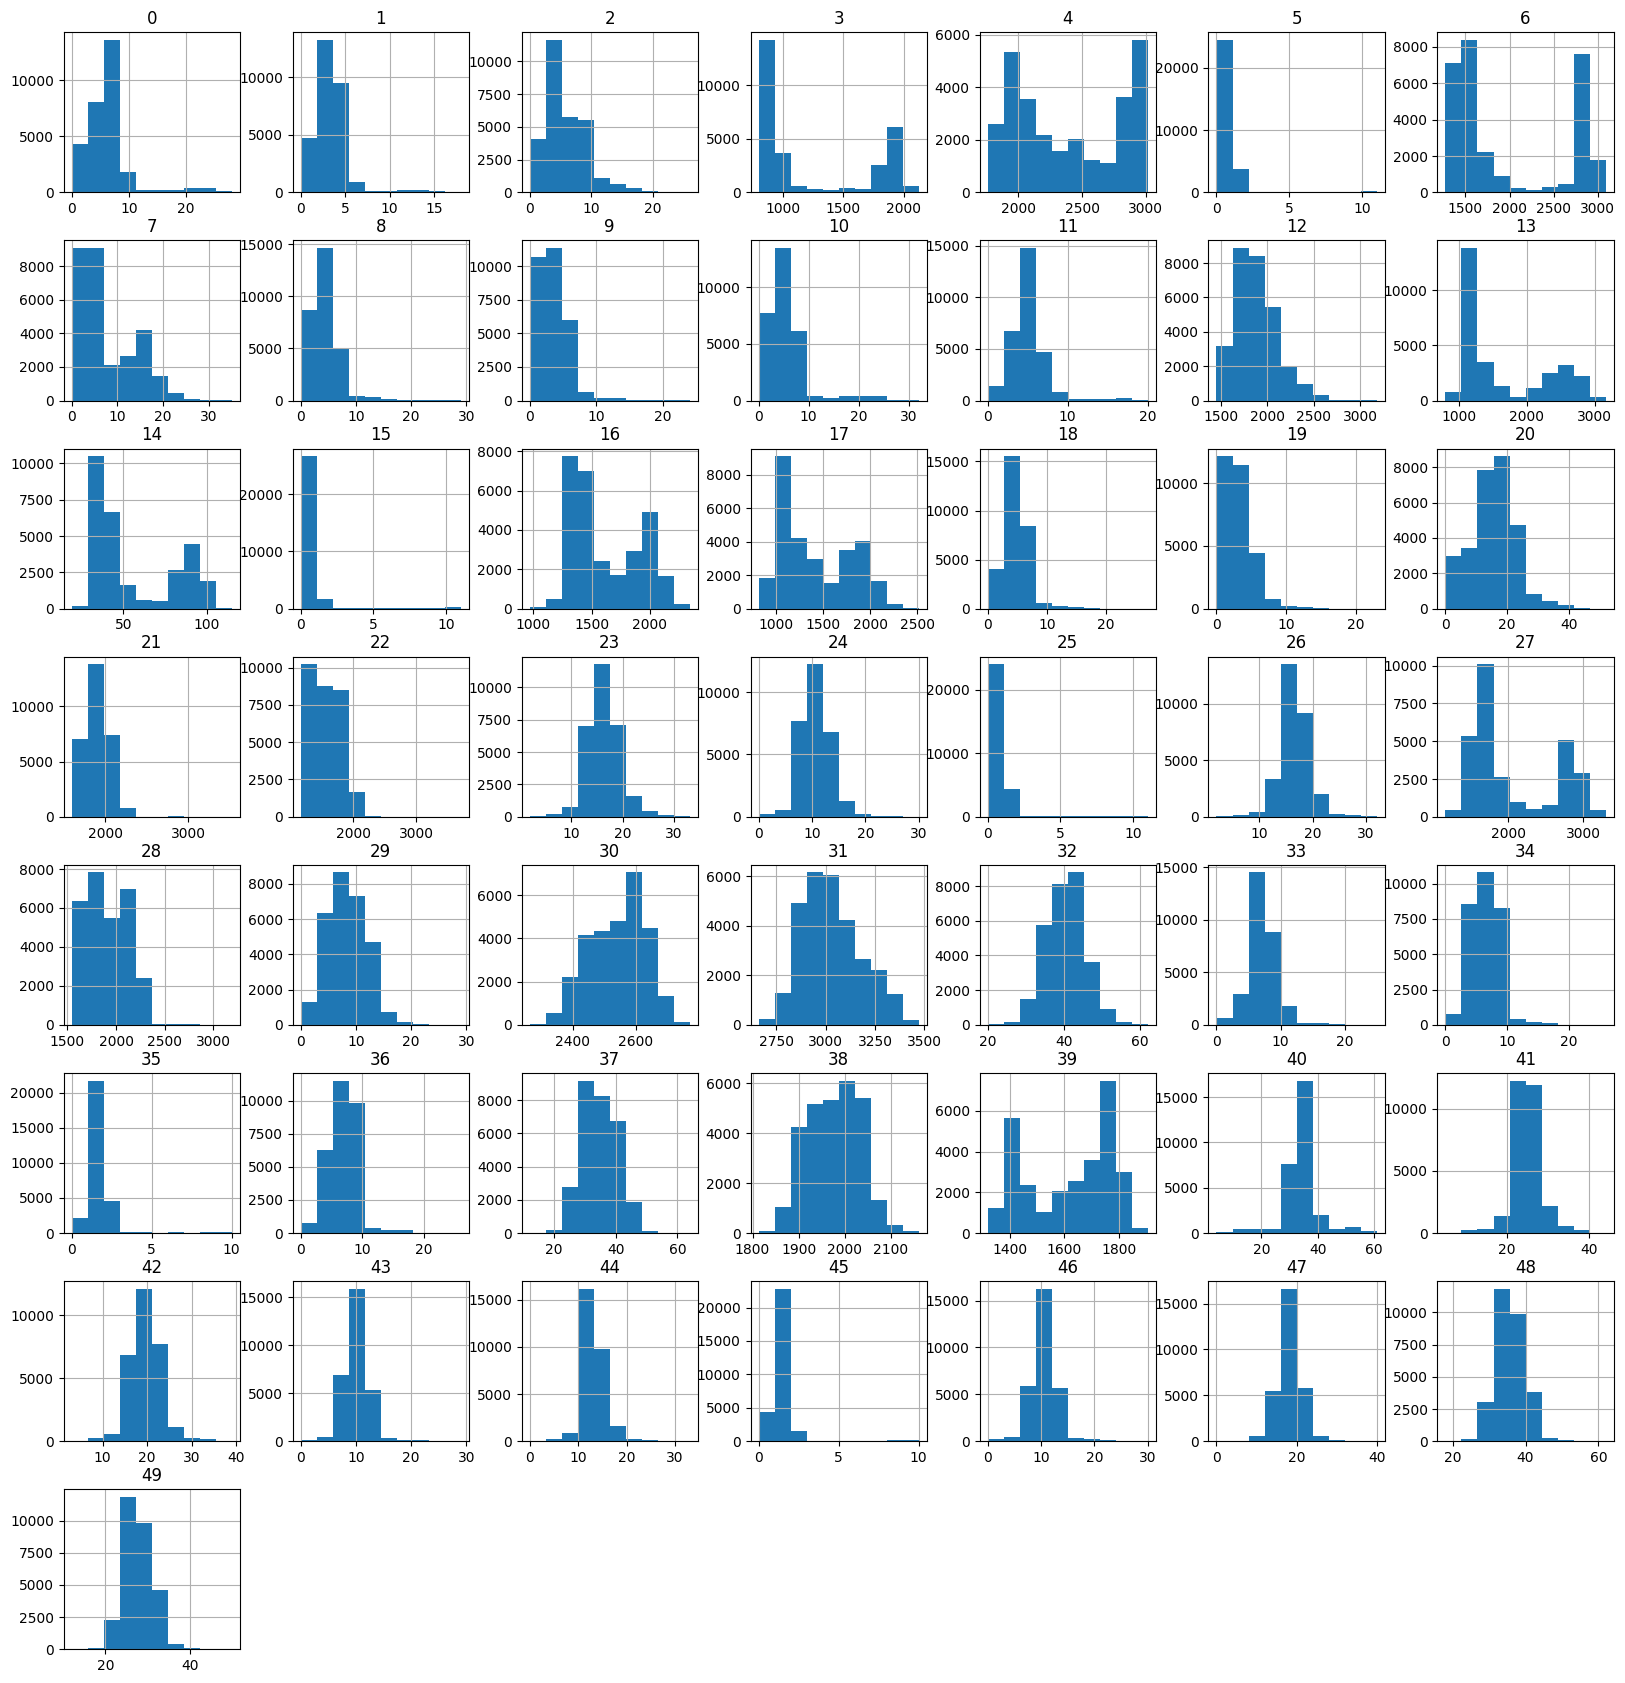

In [4]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [5]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  29145.00  29145.00  29145.00  29145.00  29145.00  29145.00  29145.00   
mean       6.07      3.12      5.71   1238.63   2385.86      1.22   1982.99   
std        4.21      2.14      3.29    467.84    410.46      1.29    650.65   
min        0.00      0.00      0.00    799.00   1757.00      0.00   1273.00   
25%        4.00      2.00      4.00    863.00   1979.00      1.00   1461.00   
50%        6.00      3.00      5.00    937.00   2305.00      1.00   1603.00   
75%        8.00      4.00      8.00   1841.00   2876.00      1.00   2831.00   
max       28.00     18.00     26.00   2125.00   3015.00     11.00   3089.00   

              7         8         9  ...        40       41        42  \
count  29145.00  29145.00  29145.00  ...  29145.00  29145.0  29145.00   
mean       7.36      3.87      3.37  ...     34.19     24.8     19.39   
std        5.93      2.47      2.19  ...      6.05      3.7      3.38   
min        0.00      0.00      0.00  ...      4.00      5.0      3.00   
25%        3.00      2.00      2.00  ...     32.00     23.0     17.00   
50%        5.00      4.00      3.00  ...     34.00     25.0     19.00   
75%       13.00      5.00      4.00  ...     36.00     26.0     21.00   
max       35.00     29.00     24.00  ...     61.00     44.0     39.00   

             43        44        45        46        47        48        49  
count  29145.00  29145.00  29145.00  29145.00  29145.00  29145.00  29145.00  
mean       9.85     13.20      1.01      9.97     17.35     35.36     27.64  
std        2.25      2.55      0.95      2.34      2.99      3.78      3.28  
min        0.00      0.00      0.00      0.00      0.00     18.00     12.00  
25%        8.00     12.00      1.00      9.00     16.00     33.00     25.00  
50%       10.00     13.00      1.00     10.00     17.00     35.00     28.00  
75%       11.00     14.00      1.00     11.00     19.00     38.00     30.00  
max       29.00     33.00     10.00     30.00     40.00     62.00     50.00  

[8 rows x 50 columns]

In [6]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [7]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

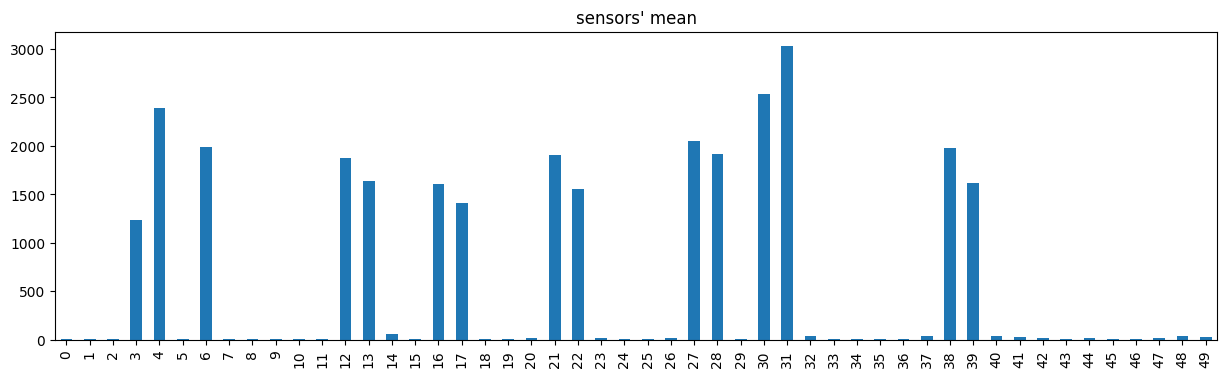

In [8]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [9]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [10]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [11]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [12]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [13]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [14]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.602; 0.68\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [15]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [16]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [17]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['3', '4', '6', '12', '13', '14', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', '40', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC']


### **Train-Test Split**

In [18]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [19]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((23337, 24), (23337,)) 
 test: ((5808, 24), (5808,))


### **Model Learning**

#### Random Forest

In [20]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [21]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.968
accuracy: 0.968


In [22]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     15146
        Open      1.000     1.000     1.000      1638
      Pistol      1.000     1.000     1.000      1634
       Thumb      1.000     1.000     1.000      1639
          OK      1.000     1.000     1.000      1644
        Grab      1.000     1.000     1.000      1636

    accuracy                          1.000     23337
   macro avg      1.000     1.000     1.000     23337
weighted avg      1.000     1.000     1.000     23337

              precision    recall  f1-score   support

     Neutral      0.987     0.988     0.987      3752
        Open      0.976     0.966     0.971       413
      Pistol      0.955     0.820     0.883       412
       Thumb      0.949     0.954     0.951       410
          OK      0.869     0.959     0.912       410
        Grab      0.929     0.961     0.945       411

    accuracy                          0.968      5808
   macro avg      0.944

In [23]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.986954    0.975550    0.954802    0.949029    0.869469   
recall        0.988006    0.966102    0.820388    0.953659    0.958537   
f1-score      0.987480    0.970803    0.882507    0.951338    0.911833   
support    3752.000000  413.000000  412.000000  410.000000  410.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.929412  0.968147     0.944203      0.968820  
recall       0.961071  0.968147     0.941294      0.968147  
f1-score     0.944976  0.968147     0.941489      0.967948  
support    411.000000  0.968147  5808.000000   5808.000000

In [24]:
from collections import OrderedDict

#create an ordered dict to store model results
review = OrderedDict([
    ('palm_file', []),
    ('model_name', []),
    ('learning_time', []),
    ('F1-Score, train', []), 
    ('F1-Score, test', []),
    ('F1-Score: Neutral', []),
    ('F1-Score: Open', []),
    ('F1-Score: Pistol', []),
    ('F1-Score: Thumb', []),
    ('F1-Score: OK', []),
    ('F1-Score: Grab', [])
    ]
)

In [25]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 2*

In [26]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

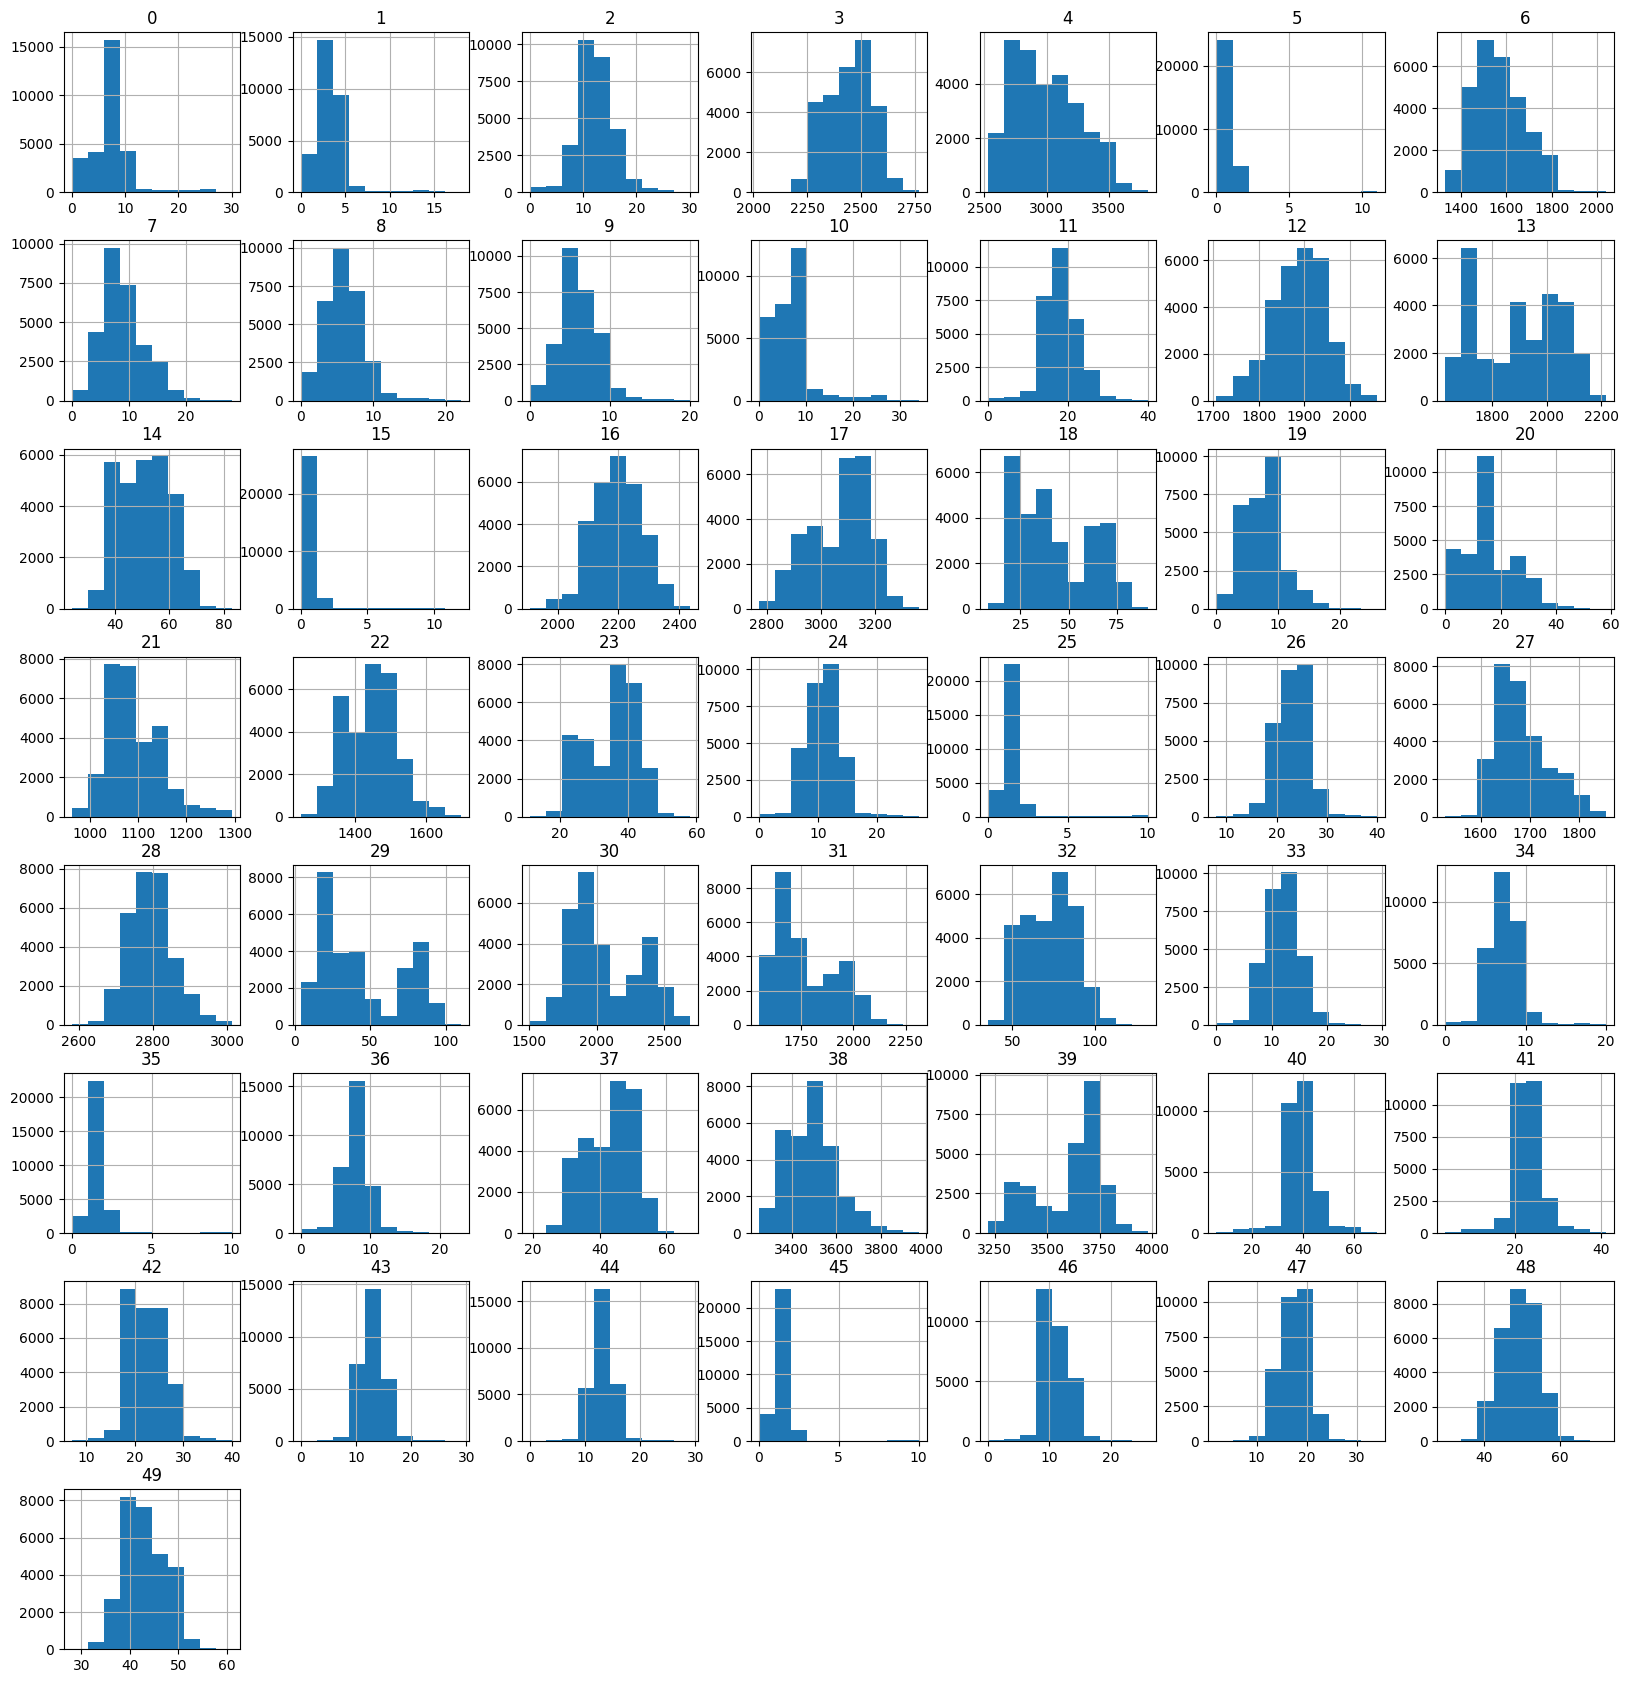

In [27]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [28]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  29137.00  29137.00  29137.00  29137.00  29137.00  29137.00  29137.00   
mean       6.87      3.13     11.85   2439.76   2995.64      1.25   1569.62   
std        4.17      2.06      3.54    108.38    264.34      1.28    109.64   
min        0.00      0.00      0.00   2025.00   2526.00      0.00   1332.00   
25%        5.00      2.00     10.00   2355.00   2770.00      1.00   1484.00   
50%        7.00      3.00     12.00   2449.00   2955.00      1.00   1559.00   
75%        8.00      4.00     14.00   2523.00   3190.00      1.00   1638.00   
max       30.00     18.00     30.00   2768.00   3811.00     11.00   2038.00   

              7         8         9  ...        40        41        42  \
count  29137.00  29137.00  29137.00  ...  29137.00  29137.00  29137.00   
mean       8.95      5.99      5.48  ...     38.74     23.01     22.44   
std        3.77      2.62      2.45  ...      6.54      3.75      3.75   
min        0.00      0.00      0.00  ...      6.00      4.00      7.00   
25%        6.00      4.00      4.00  ...     36.00     21.00     20.00   
50%        8.00      6.00      5.00  ...     38.00     23.00     22.00   
75%       11.00      8.00      7.00  ...     42.00     25.00     25.00   
max       28.00     22.00     20.00  ...     69.00     41.00     40.00   

             43        44        45        46        47        48        49  
count  29137.00  29137.00  29137.00  29137.00  29137.00  29137.00  29137.00  
mean      12.94     13.14      1.03     10.92     17.26     49.21     42.94  
std        2.48      2.37      0.98      2.35      3.03      4.80      4.31  
min        0.00      0.00      0.00      0.00      2.00     30.00     28.00  
25%       11.00     12.00      1.00     10.00     16.00     46.00     40.00  
50%       13.00     13.00      1.00     11.00     17.00     49.00     43.00  
75%       14.00     14.00      1.00     12.00     19.00     53.00     46.00  
max       29.00     29.00     10.00     26.00     34.00     72.00     61.00  

[8 rows x 50 columns]

In [29]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [30]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

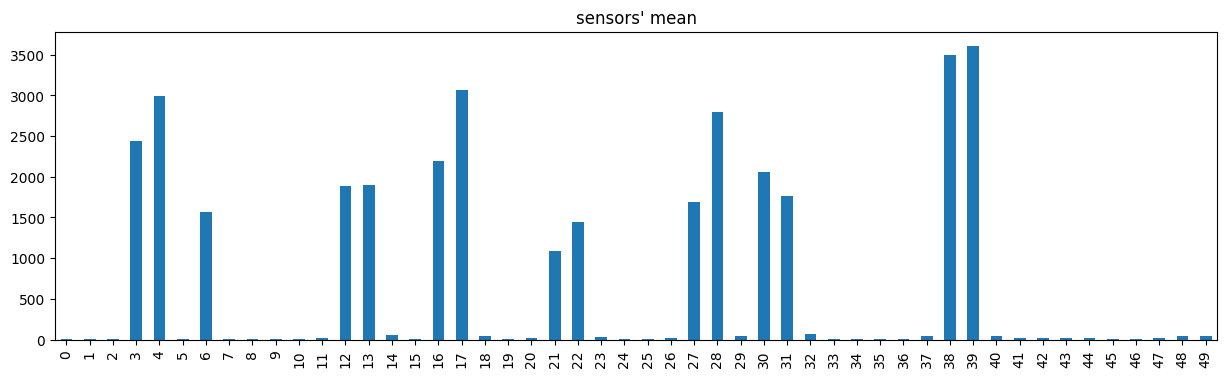

In [31]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [32]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [33]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [34]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [35]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [36]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [37]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.62; 0.683\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [38]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [39]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [40]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['3', '4', '6', '12', '13', '16', '17', '18', '20', '21', '22', '27', '28', '29', '30', '31', '32', '38', '39', '40', '48', 'ACC0', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC']


### **Train-Test Split**

In [41]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [42]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((23336, 27), (23336,)) 
 test: ((5801, 27), (5801,))


### **Model Learning**

#### Random Forest

In [43]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [44]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.876
accuracy: 0.876


In [45]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     15125
        Open      1.000     1.000     1.000      1644
      Pistol      1.000     1.000     1.000      1633
       Thumb      1.000     1.000     1.000      1645
          OK      1.000     1.000     1.000      1644
        Grab      1.000     1.000     1.000      1645

    accuracy                          1.000     23336
   macro avg      1.000     1.000     1.000     23336
weighted avg      1.000     1.000     1.000     23336

              precision    recall  f1-score   support

     Neutral      0.879     0.963     0.919      3737
        Open      0.892     0.824     0.857       410
      Pistol      0.819     0.626     0.710       420
       Thumb      0.883     0.715     0.790       410
          OK      0.866     0.643     0.738       412
        Grab      0.877     0.794     0.833       412

    accuracy                          0.876      5801
   macro avg      0.869

In [46]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.879462    0.891821    0.819315    0.882530    0.866013   
recall        0.962537    0.824390    0.626190    0.714634    0.643204   
f1-score      0.919126    0.856781    0.709852    0.789757    0.738162   
support    3737.000000  410.000000  420.000000  410.000000  412.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.876676  0.876228     0.869303      0.875045  
recall       0.793689  0.876228     0.760774      0.876228  
f1-score     0.833121  0.876228     0.807800      0.871464  
support    412.000000  0.876228  5801.000000   5801.000000

In [47]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 3*

In [48]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

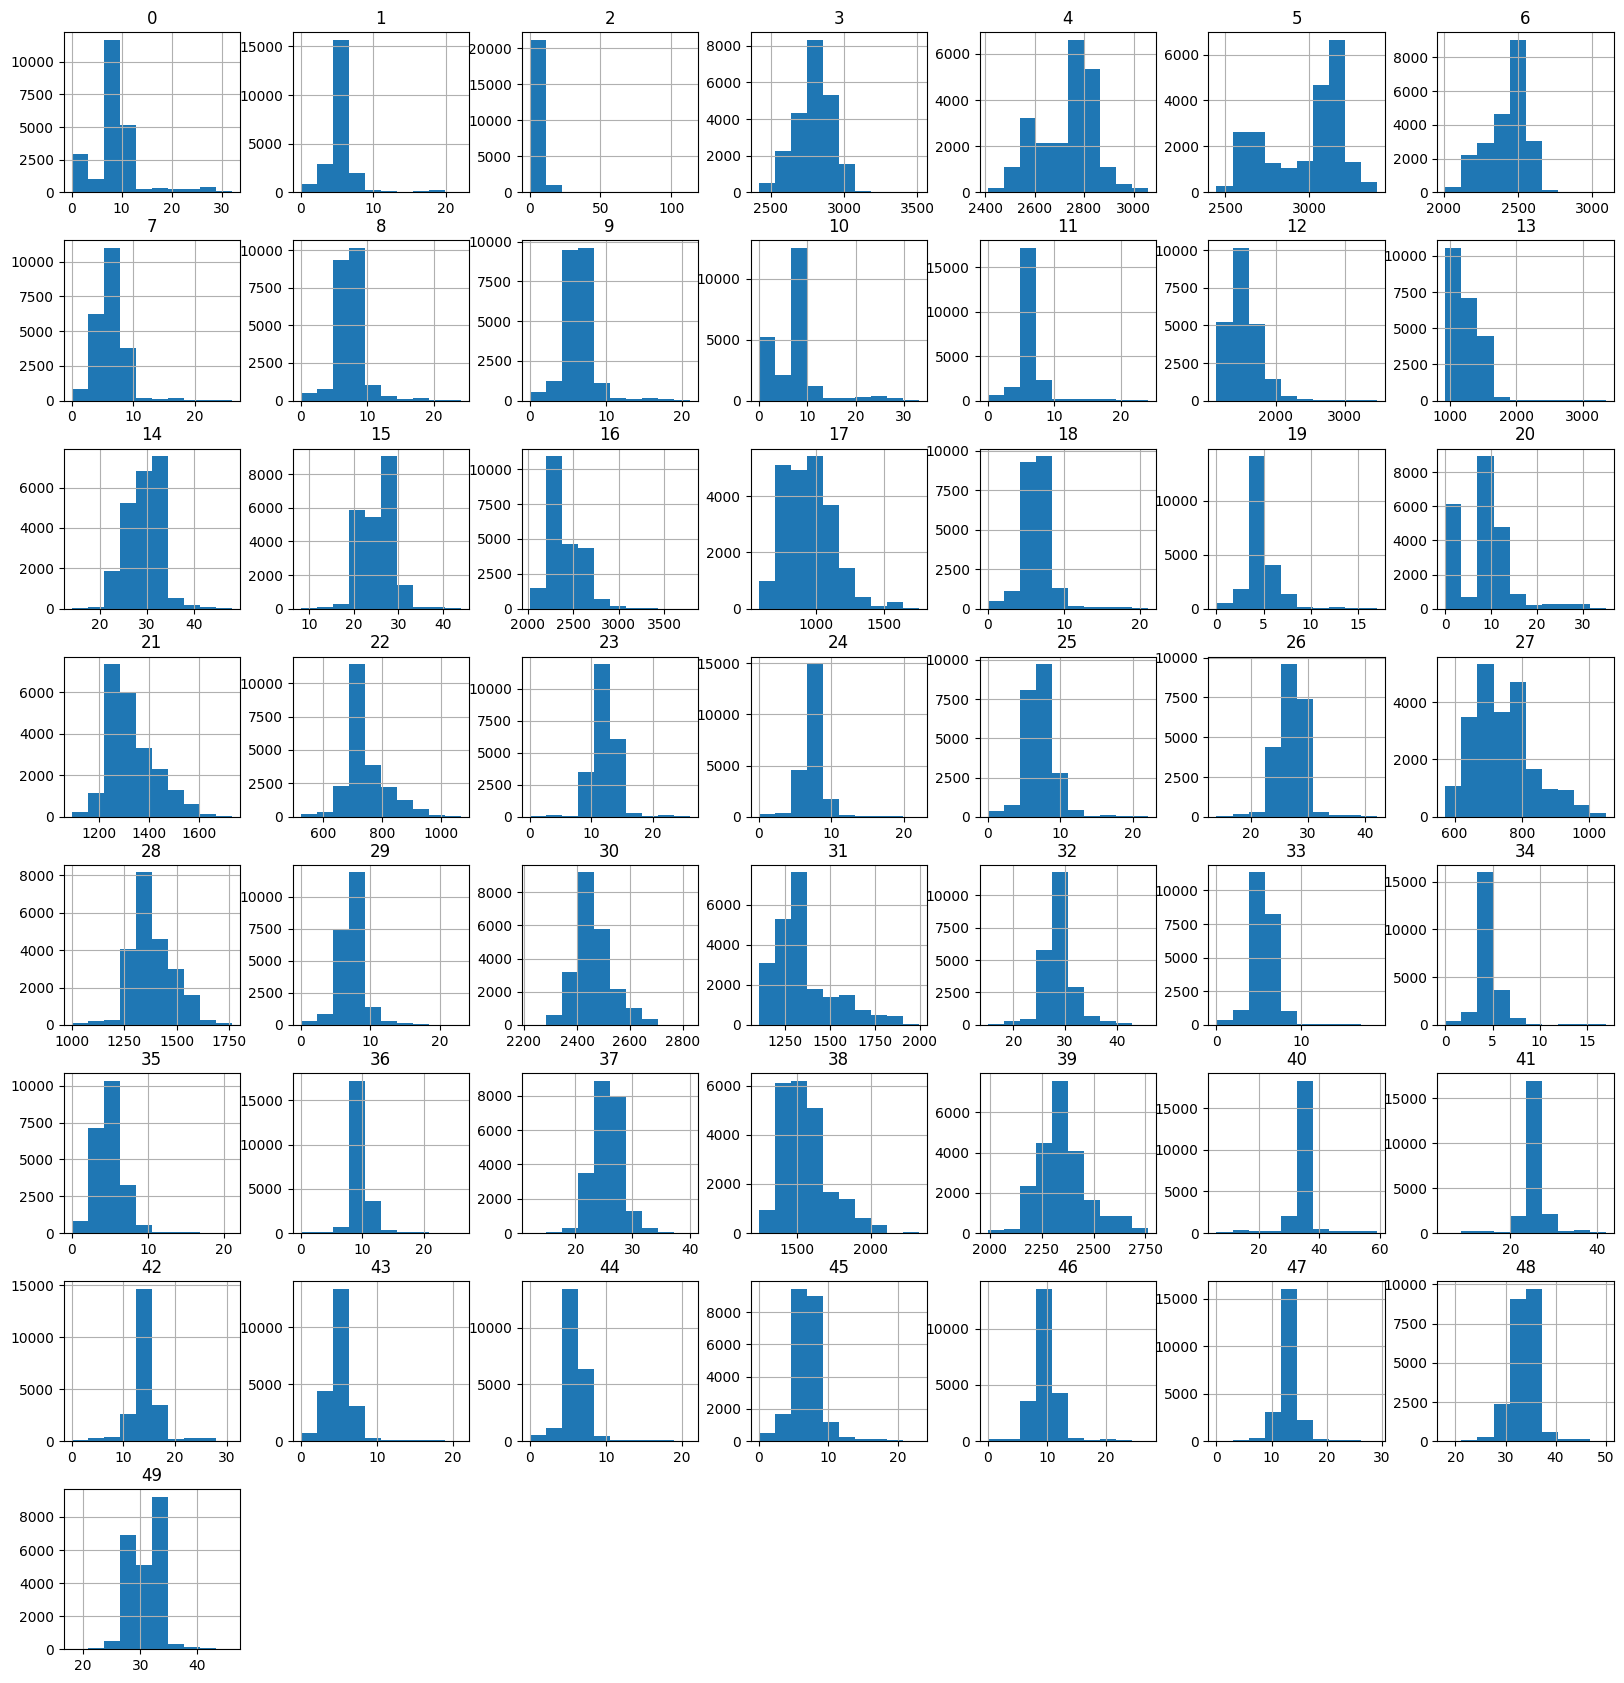

In [49]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [50]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  22368.00  22368.00  22368.00  22368.00  22368.00  22368.00  22368.00   
mean       8.68      5.62      8.23   2791.48   2730.59   2974.65   2424.21   
std        5.07      2.36      3.89    125.72    114.73    229.28    132.35   
min        0.00      0.00      0.00   2415.00   2410.00   2447.00   2011.00   
25%        8.00      5.00      7.00   2716.00   2633.00   2736.00   2341.00   
50%        9.00      5.00      8.00   2807.00   2767.00   3083.00   2460.00   
75%       10.00      6.00      9.00   2869.00   2809.00   3149.00   2518.00   
max       32.00     22.00    113.00   3508.00   3057.00   3404.00   3089.00   

              7         8         9  ...        40        41        42  \
count  22368.00  22368.00  22368.00  ...  22368.00  22368.00  22368.00   
mean       6.16      7.39      6.64  ...     34.23     25.45     14.08   
std        2.15      2.17      1.95  ...      4.77      3.20      2.72   
min        0.00      0.00      0.00  ...      6.00      5.00      0.00   
25%        5.00      6.00      6.00  ...     33.00     24.00     13.00   
50%        6.00      8.00      7.00  ...     34.00     26.00     14.00   
75%        7.00      8.00      8.00  ...     36.00     26.00     15.00   
max       26.00     24.00     21.00  ...     59.00     42.00     31.00   

             43        44        45        46        47        48        49  
count  22368.00  22368.00  22368.00  22368.00  22368.00  22368.00  22368.00  
mean       5.45      6.24      6.74      9.71     12.86     33.36     30.57  
std        1.93      1.85      2.29      2.07      2.21      2.62      2.31  
min        0.00      0.00      0.00      0.00      0.00     18.00     18.00  
25%        5.00      6.00      5.00      9.00     12.00     32.00     29.00  
50%        5.00      6.00      6.00     10.00     13.00     33.00     30.00  
75%        6.00      7.00      8.00     10.00     14.00     35.00     32.00  
max       21.00     21.00     23.00     27.00     29.00     50.00     46.00  

[8 rows x 50 columns]

In [51]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [52]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

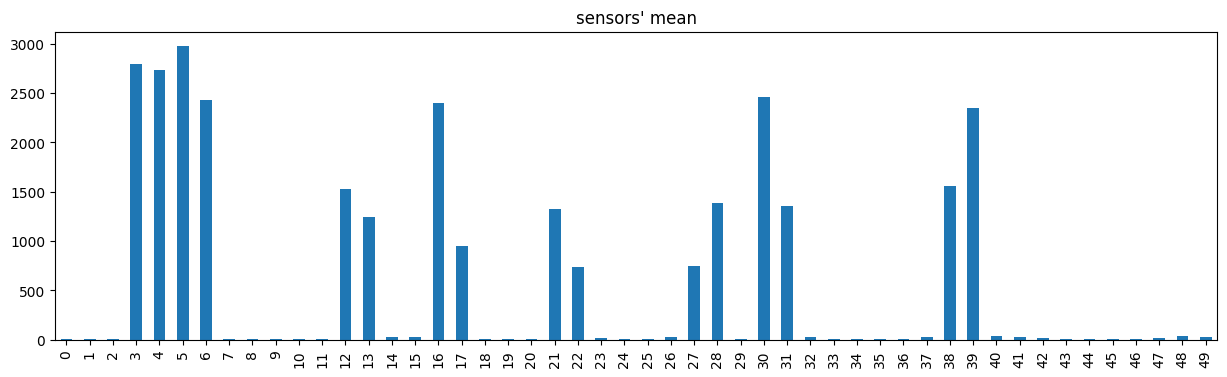

In [53]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [54]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [55]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [56]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [57]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [58]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [59]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.61; 0.58\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [60]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [61]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [62]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '3', '4', '5', '6', '10', '12', '13', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [63]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [64]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((17939, 26), (17939,)) 
 test: ((4429, 26), (4429,))


### **Model Learning**

#### Random Forest

In [65]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [66]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.946
accuracy: 0.946


In [67]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10708
        Open      1.000     1.000     1.000      1447
      Pistol      1.000     1.000     1.000      1439
       Thumb      1.000     1.000     1.000      1449
          OK      1.000     1.000     1.000      1450
        Grab      1.000     1.000     1.000      1446

    accuracy                          1.000     17939
   macro avg      1.000     1.000     1.000     17939
weighted avg      1.000     1.000     1.000     17939

              precision    recall  f1-score   support

     Neutral      0.970     0.978     0.974      2586
        Open      0.937     0.919     0.928       371
      Pistol      0.827     0.883     0.854       367
       Thumb      0.927     0.899     0.913       367
          OK      0.943     0.856     0.897       367
        Grab      0.936     0.949     0.942       371

    accuracy                          0.946      4429
   macro avg      0.923

In [68]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.969709    0.936813    0.826531    0.926966    0.942943   
recall        0.977958    0.919137    0.882834    0.899183    0.855586   
f1-score      0.973816    0.927891    0.853755    0.912863    0.897143   
support    2586.000000  371.000000  367.000000  367.000000  367.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.936170  0.946037     0.923189      0.946520  
recall       0.948787  0.946037     0.913914      0.946037  
f1-score     0.942436  0.946037     0.917984      0.945988  
support    371.000000  0.946037  4429.000000   4429.000000

In [69]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 4*

In [70]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

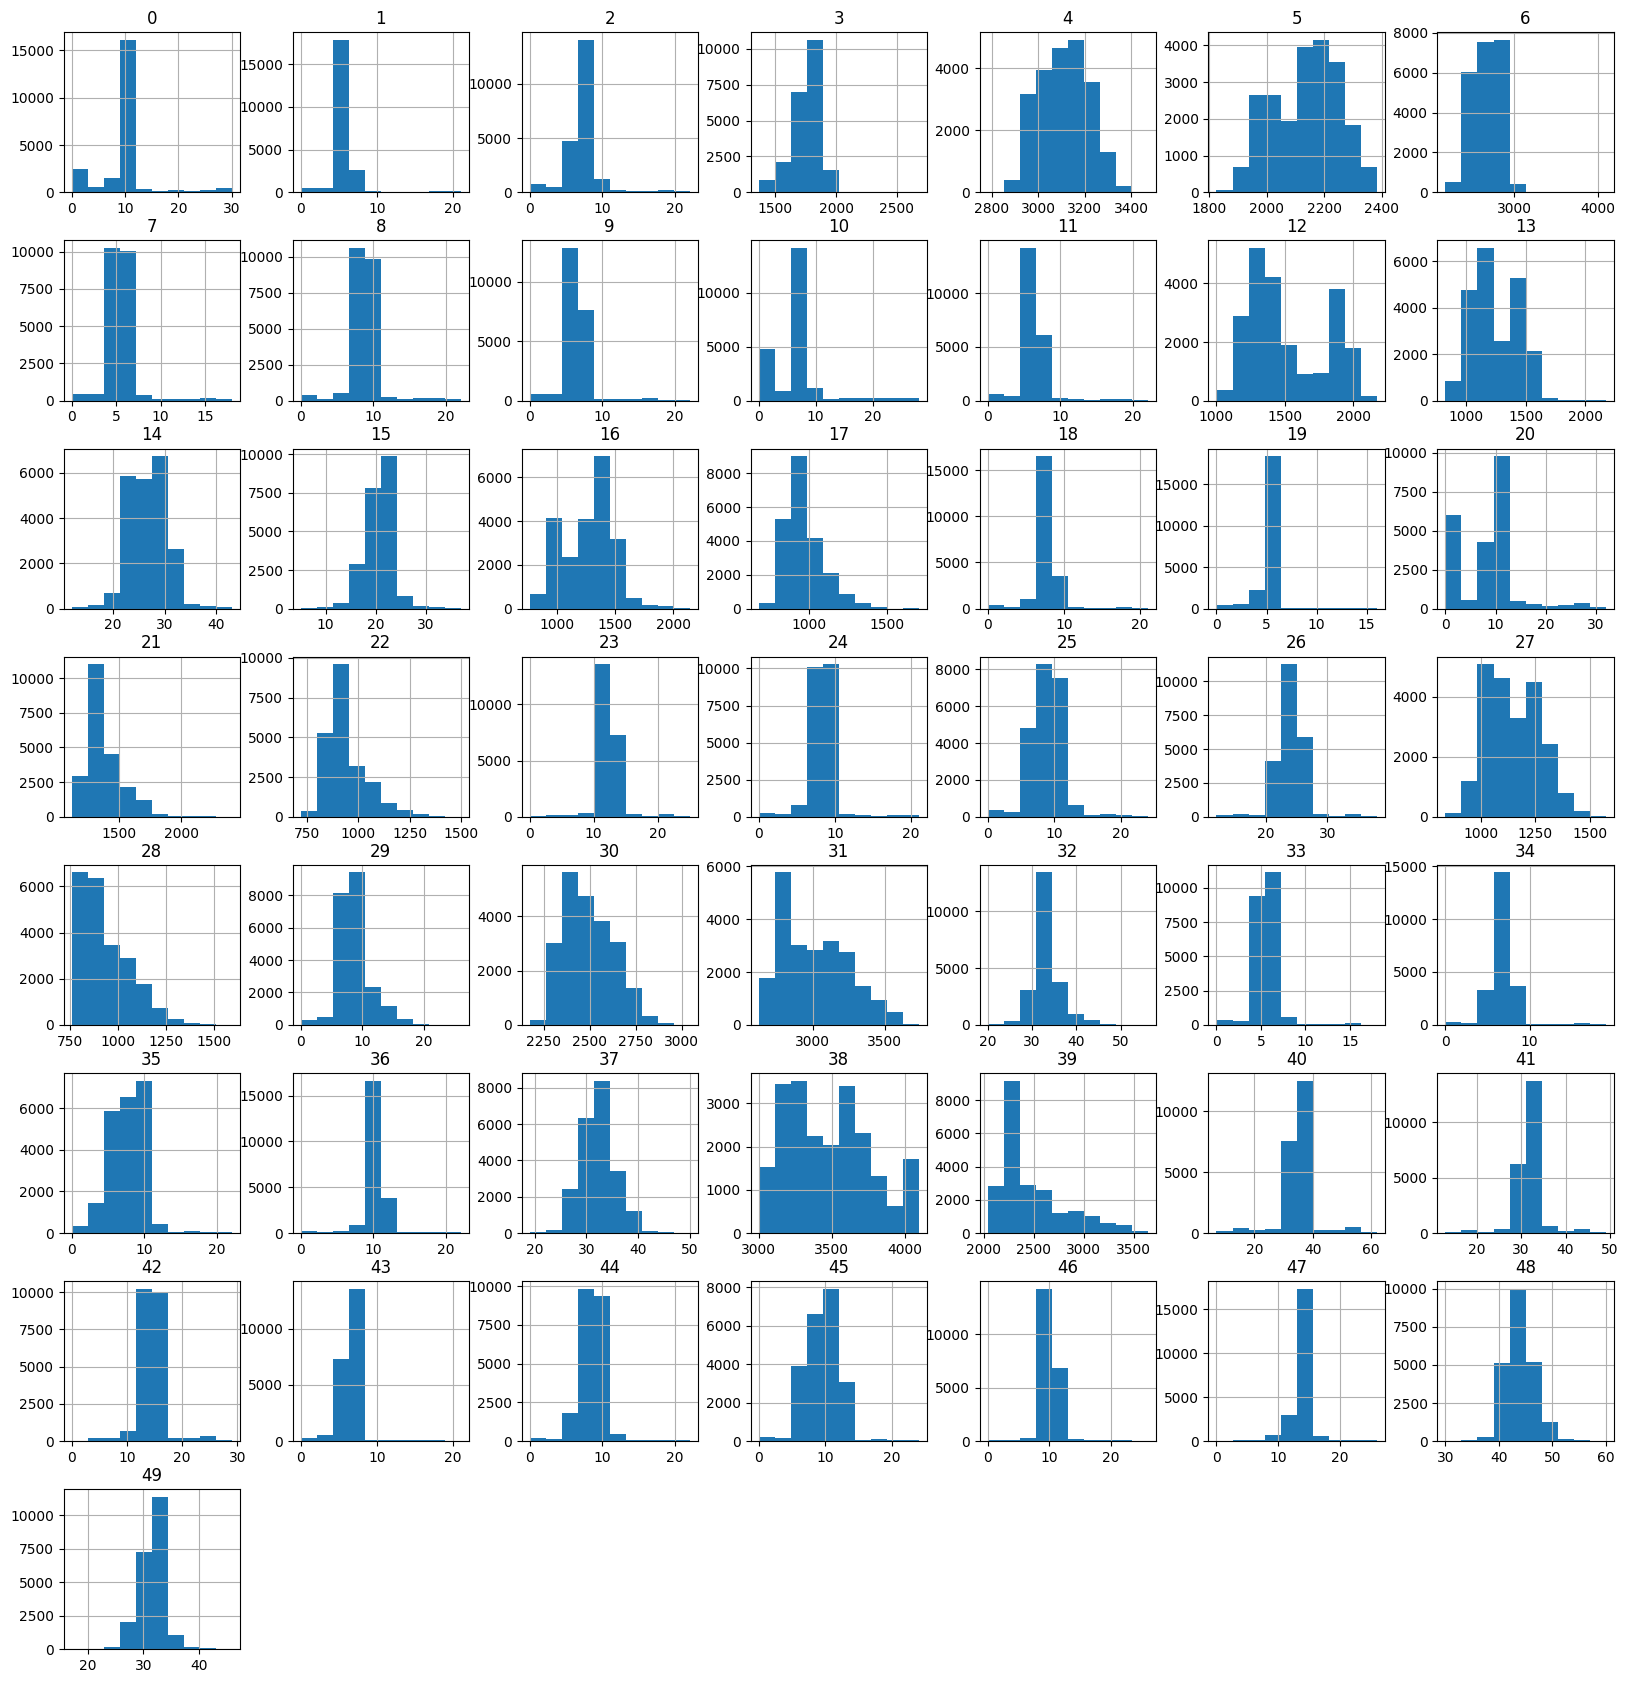

In [71]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [72]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  22204.00  22204.00  22204.00  22204.00  22204.00  22204.00  22204.00   
mean       9.06      6.14      7.34   1759.41   3107.03   2135.42   2673.66   
std        4.76      2.06      2.52    117.13    106.07    113.76    160.87   
min        0.00      0.00      0.00   1363.00   2781.00   1825.00   2180.00   
25%        9.00      6.00      6.00   1713.00   3018.00   2036.00   2548.00   
50%        9.00      6.00      7.00   1767.00   3112.00   2150.00   2663.00   
75%       10.00      6.00      8.00   1848.00   3187.00   2224.00   2814.00   
max       30.00     21.00     22.00   2679.00   3471.00   2382.00   4095.00   

              7         8         9  ...        40        41        42  \
count  22204.00  22204.00  22204.00  ...  22204.00  22204.00  22204.00   
mean       5.57      8.55      6.39  ...     34.92     31.62     14.62   
std        1.81      1.97      1.73  ...      5.42      3.34      2.52   
min        0.00      0.00      0.00  ...      7.00     13.00      0.00   
25%        5.00      8.00      6.00  ...     34.00     30.00     14.00   
50%        5.00      8.00      6.00  ...     35.00     32.00     14.00   
75%        6.00      9.00      7.00  ...     36.00     33.00     16.00   
max       18.00     22.00     22.00  ...     62.00     49.00     29.00   

             43        44        45        46        47        48        49  
count  22204.00  22204.00  22204.00  22204.00  22204.00  22204.00  22204.00  
mean       6.74      8.38      9.32     10.21     13.42     43.30     31.23  
std        1.71      1.86      2.49      1.79      1.83      2.78      2.28  
min        0.00      0.00      0.00      0.00      0.00     30.00     17.00  
25%        6.00      8.00      8.00     10.00     13.00     42.00     29.00  
50%        7.00      8.00     10.00     10.00     14.00     43.00     32.00  
75%        7.00      9.00     11.00     11.00     14.00     45.00     32.00  
max       21.00     22.00     24.00     26.00     26.00     60.00     46.00  

[8 rows x 50 columns]

In [73]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [74]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

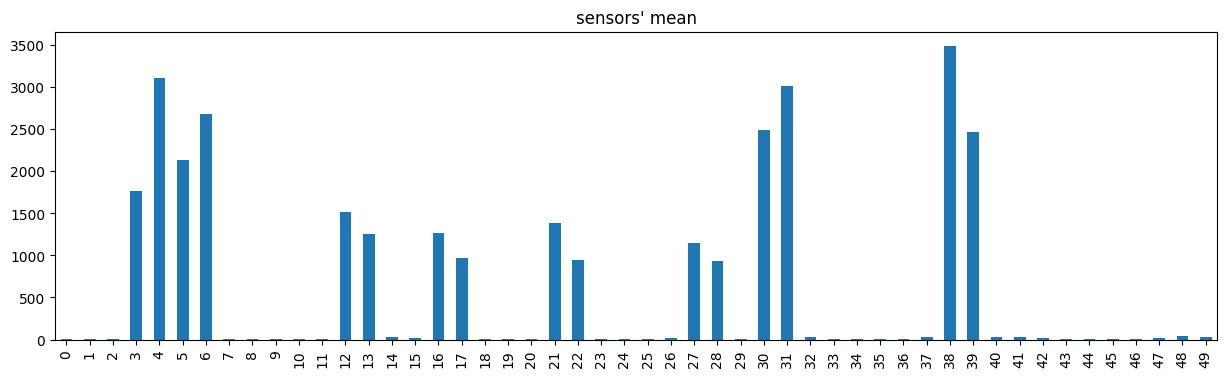

In [75]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [76]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [77]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [78]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [79]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [80]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [81]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.574; 0.576\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [82]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [83]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [84]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['3', '4', '5', '6', '10', '12', '13', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', '40', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [85]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [86]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((17771, 26), (17771,)) 
 test: ((4433, 26), (4433,))


### **Model Learning**

#### Random Forest

In [87]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [88]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.932
accuracy: 0.932


In [89]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10481
        Open      1.000     1.000     1.000      1458
      Pistol      1.000     1.000     1.000      1468
       Thumb      1.000     1.000     1.000      1450
          OK      1.000     1.000     1.000      1449
        Grab      1.000     1.000     1.000      1465

    accuracy                          1.000     17771
   macro avg      1.000     1.000     1.000     17771
weighted avg      1.000     1.000     1.000     17771

              precision    recall  f1-score   support

     Neutral      0.966     0.974     0.970      2581
        Open      0.875     0.951     0.911       367
      Pistol      0.885     0.787     0.833       371
       Thumb      0.954     0.949     0.952       373
          OK      0.937     0.791     0.858       373
        Grab      0.786     0.889     0.834       368

    accuracy                          0.932      4433
   macro avg      0.900

In [90]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.966180    0.874687    0.884848    0.954178    0.936508   
recall        0.974041    0.950954    0.787062    0.949062    0.790885   
f1-score      0.970095    0.911227    0.833096    0.951613    0.857558   
support    2581.000000  367.000000  371.000000  373.000000  373.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.786058  0.931875     0.900410      0.933340  
recall       0.888587  0.931875     0.890098      0.931875  
f1-score     0.834184  0.931875     0.892962      0.931449  
support    368.000000  0.931875  4433.000000   4433.000000

In [91]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 5*

In [92]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

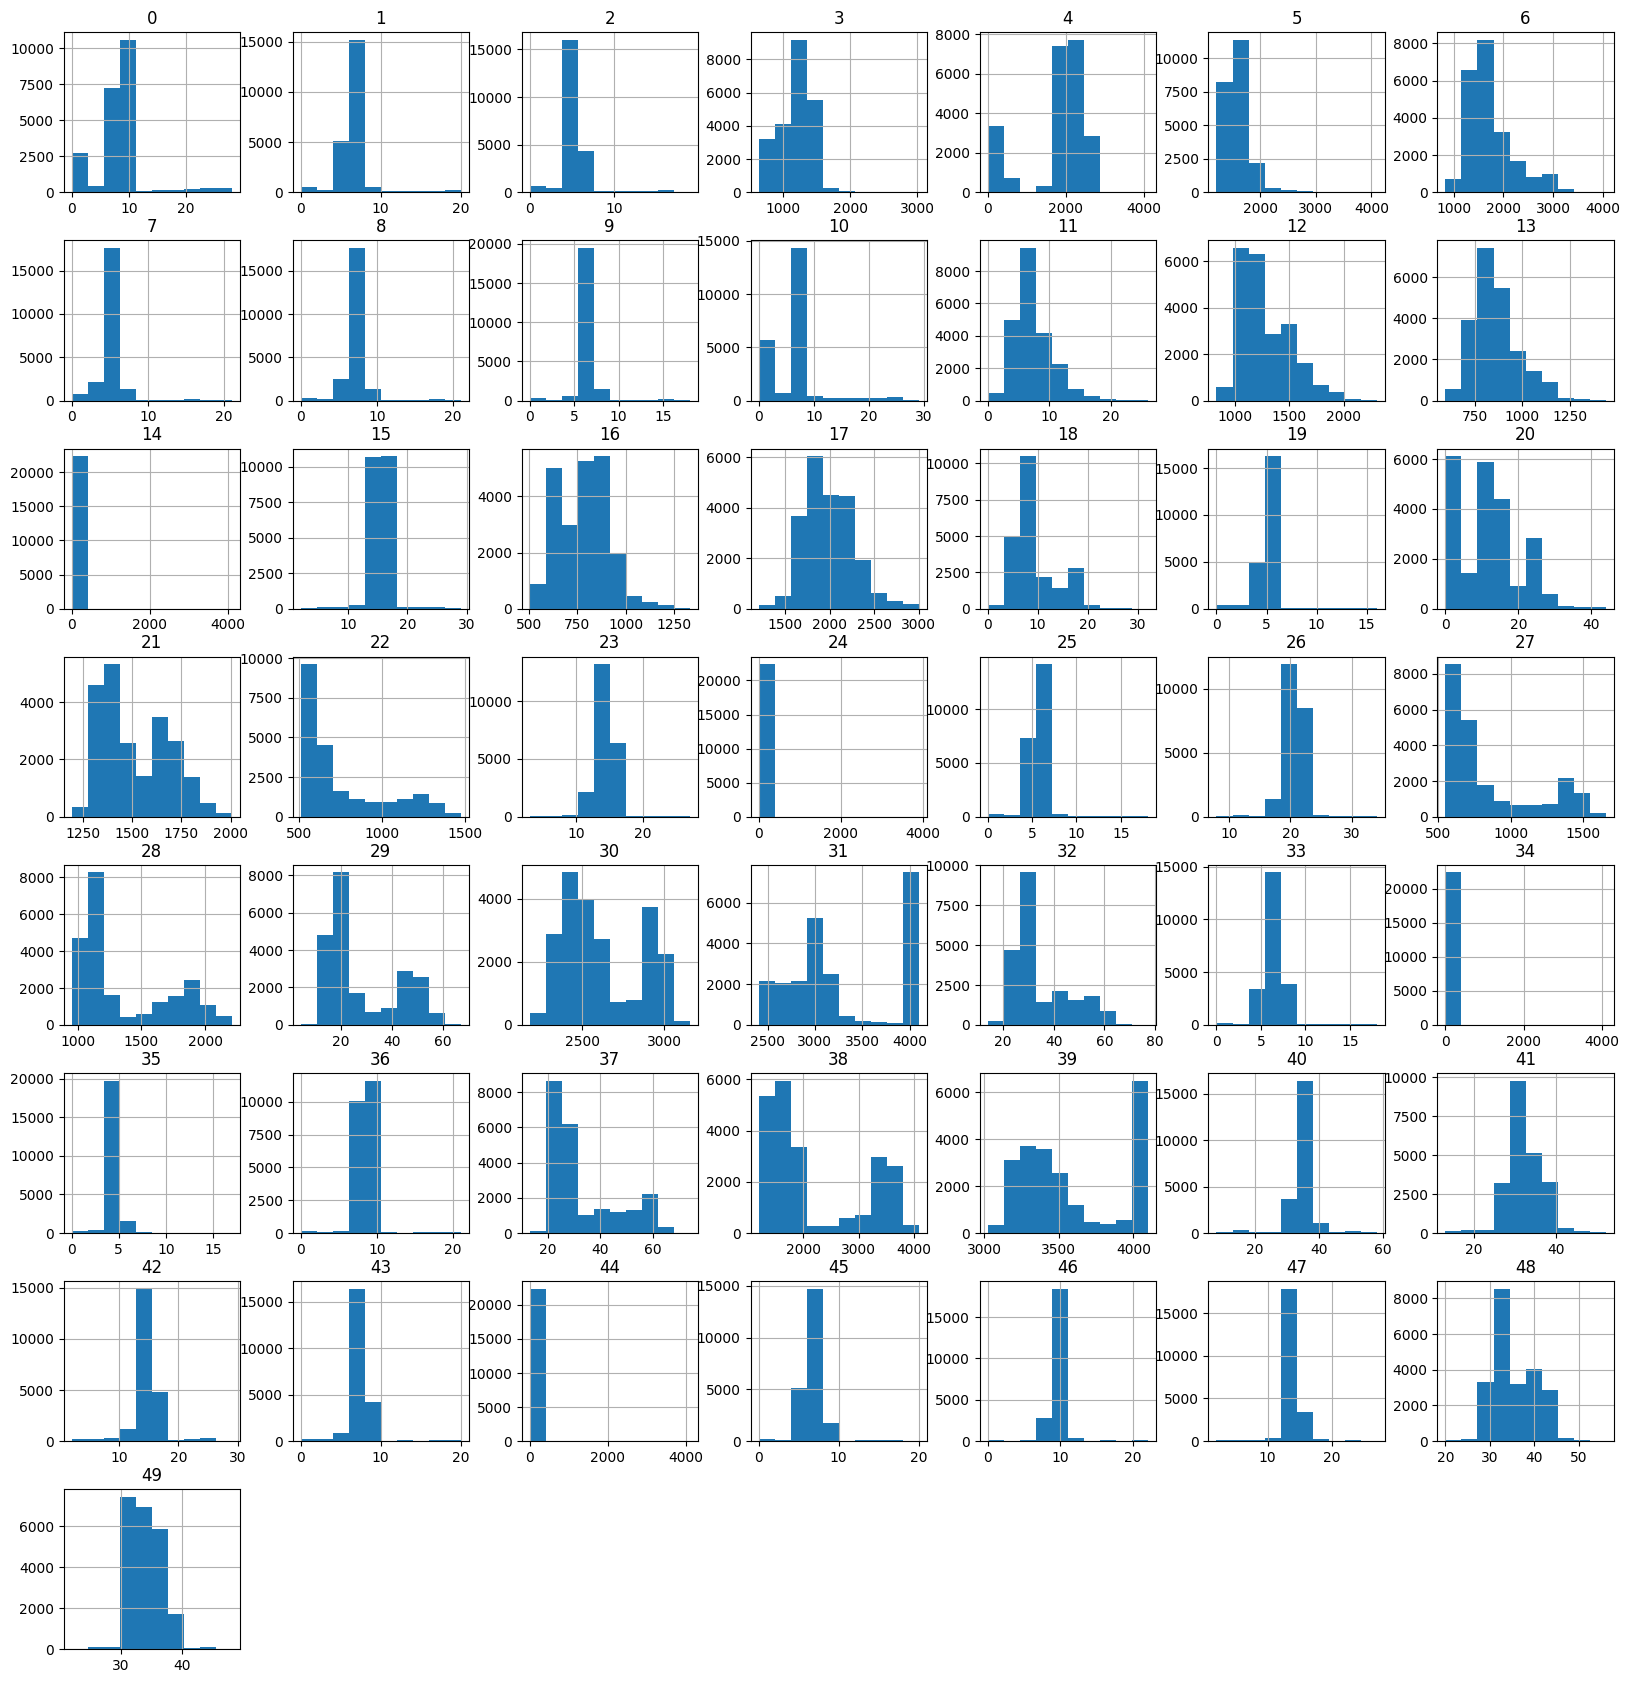

In [93]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [94]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  22375.00  22375.00  22375.00  22375.00  22375.00  22375.00  22375.00   
mean       8.26      6.06      5.17   1189.08   1777.43   1590.85   1732.47   
std        4.50      2.13      2.07    234.31    767.95    223.09    442.62   
min        0.00      0.00      0.00    634.00      0.00   1207.00    838.00   
25%        8.00      5.00      5.00    945.00   1746.00   1458.00   1453.00   
50%        9.00      6.00      5.00   1263.00   2021.00   1551.00   1590.00   
75%        9.00      6.00      5.00   1353.00   2346.00   1669.00   1890.00   
max       28.00     20.00     19.00   3019.00   4095.00   4095.00   4054.00   

             7         8         9  ...        40        41        42  \
count  22375.0  22375.00  22375.00  ...  22375.00  22375.00  22375.00   
mean       5.4      7.52      6.56  ...     34.20     32.13     14.33   
std        1.7      1.71      1.50  ...      4.32      4.38      2.61   
min        0.0      0.00      0.00  ...      8.00     13.00      2.00   
25%        5.0      7.00      6.00  ...     33.00     29.00     13.00   
50%        5.0      8.00      6.00  ...     34.00     32.00     14.00   
75%        6.0      8.00      7.00  ...     36.00     35.00     16.00   
max       21.0     21.00     18.00  ...     58.00     52.00     29.00   

             43        44        45        46        47        48        49  
count  22375.00  22375.00  22375.00  22375.00  22375.00  22375.00  22375.00  
mean       6.73     11.24      6.12      9.25     13.32     35.29     33.86  
std        1.65     31.71      1.59      1.58      1.88      4.86      2.45  
min        0.00      0.00      0.00      0.00      2.00     20.00     22.00  
25%        6.00      6.00      6.00      9.00     12.00     32.00     32.00  
50%        7.00      6.00      6.00      9.00     13.00     34.00     34.00  
75%        7.00      7.00      6.00     10.00     14.00     40.00     35.00  
max       20.00   4095.00     20.00     22.00     27.00     56.00     48.00  

[8 rows x 50 columns]

In [95]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [96]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

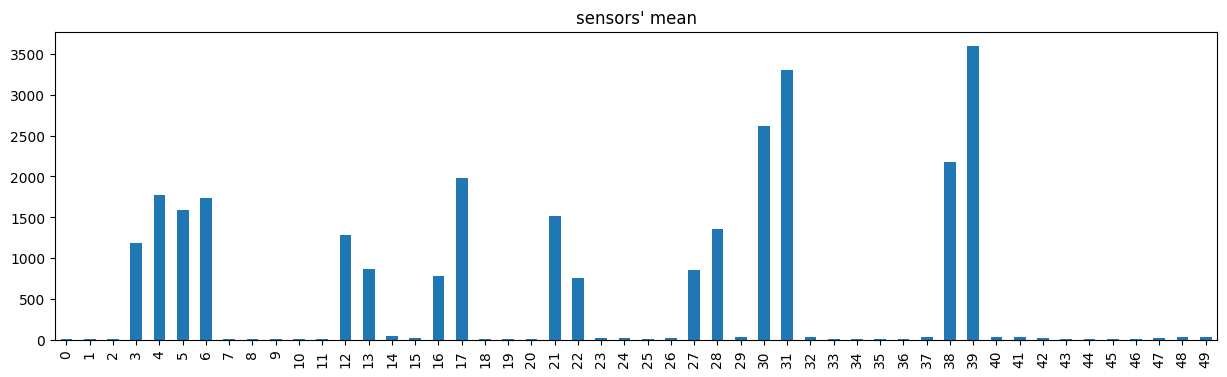

In [97]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [98]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [99]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [100]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [101]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [102]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [103]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.612; 0.588\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [104]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [105]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [106]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['3', '4', '5', '6', '12', '13', '14', '16', '17', '20', '21', '22', '24', '27', '28', '30', '31', '34', '37', '38', '39', '44', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [107]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [108]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((17936, 30), (17936,)) 
 test: ((4439, 30), (4439,))


### **Model Learning**

#### Random Forest

In [109]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [110]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.949
accuracy: 0.949


In [111]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10654
        Open      1.000     1.000     1.000      1463
      Pistol      1.000     1.000     1.000      1454
       Thumb      1.000     1.000     1.000      1452
          OK      1.000     1.000     1.000      1454
        Grab      1.000     1.000     1.000      1459

    accuracy                          1.000     17936
   macro avg      1.000     1.000     1.000     17936
weighted avg      1.000     1.000     1.000     17936

              precision    recall  f1-score   support

     Neutral      0.974     0.977     0.975      2596
        Open      0.927     0.962     0.945       372
      Pistol      0.857     0.892     0.874       369
       Thumb      0.935     0.927     0.931       370
          OK      0.950     0.887     0.917       363
        Grab      0.902     0.875     0.889       369

    accuracy                          0.949      4439
   macro avg      0.924

In [112]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.973512    0.927461    0.856771    0.934605    0.949853   
recall        0.976888    0.962366    0.891599    0.927027    0.887052   
f1-score      0.975197    0.944591    0.873838    0.930801    0.917379   
support    2596.000000  372.000000  369.000000  370.000000  363.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.902235  0.948637     0.924073      0.948846  
recall       0.875339  0.948637     0.920045      0.948637  
f1-score     0.888583  0.948637     0.921731      0.948578  
support    369.000000  0.948637  4439.000000   4439.000000

In [113]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 6*

In [114]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

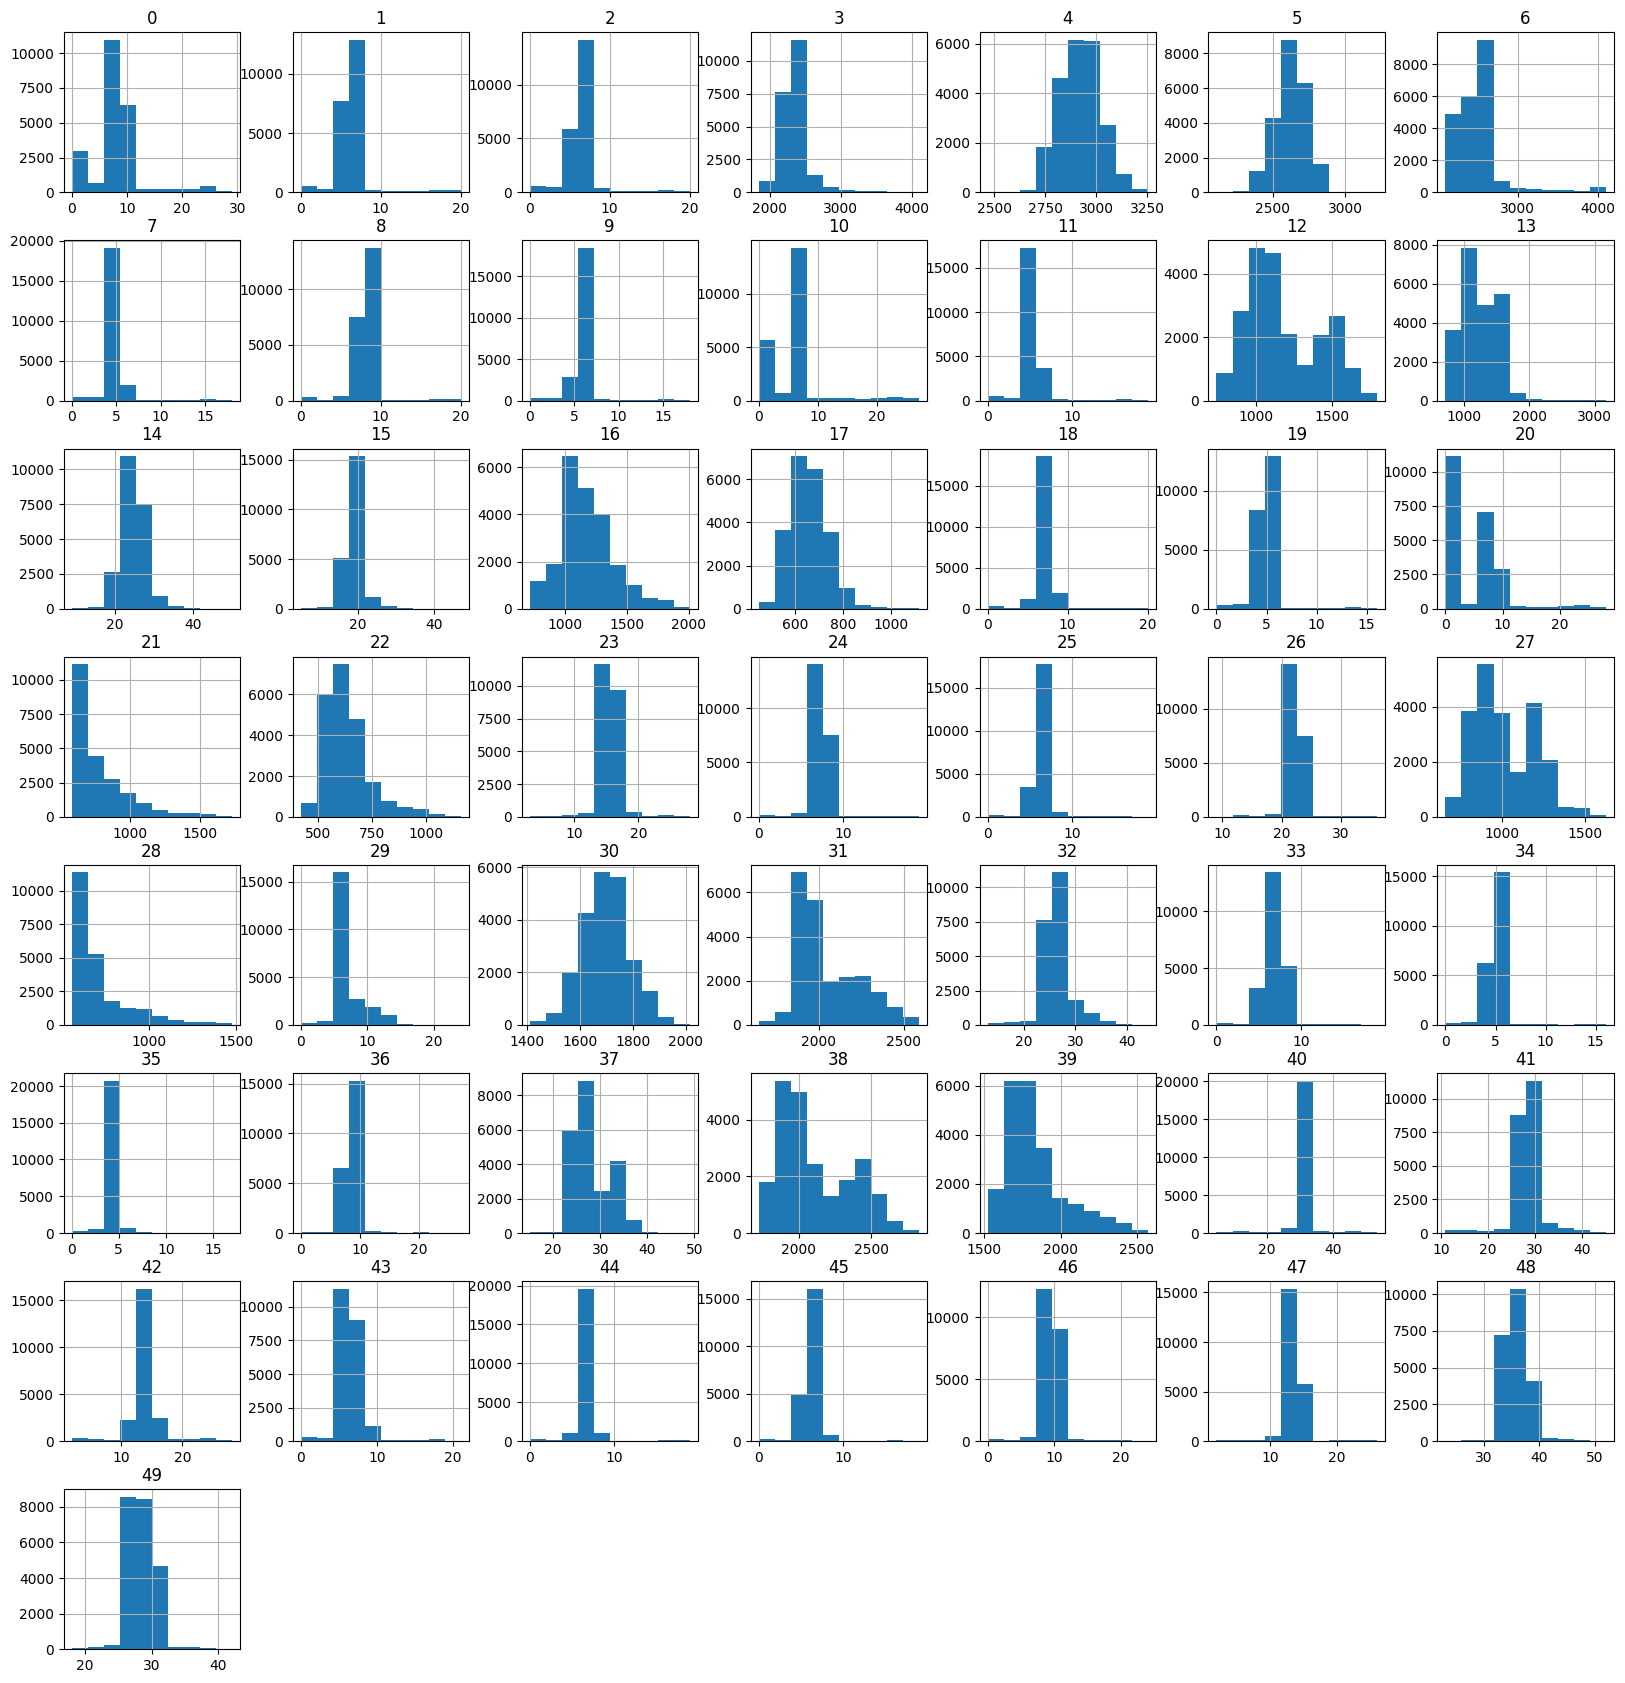

In [115]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [116]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  22361.00  22361.00  22361.00  22361.00  22361.00  22361.00  22361.00   
mean       7.97      5.77      5.90   2353.69   2916.80   2623.92   2510.15   
std        4.62      2.11      2.17    219.14     99.53    108.82    299.57   
min        0.00      0.00      0.00   1841.00   2466.00   2110.00   2102.00   
25%        8.00      5.00      5.00   2240.00   2841.00   2553.00   2336.00   
50%        8.00      6.00      6.00   2334.00   2922.00   2628.00   2503.00   
75%        9.00      6.00      6.00   2403.00   2982.00   2709.00   2592.00   
max       29.00     20.00     20.00   4095.00   3251.00   3217.00   4095.00   

              7         8         9  ...        40        41        42  \
count  22361.00  22361.00  22361.00  ...  22361.00  22361.00  22361.00   
mean       4.89      7.59      6.00  ...     30.59     27.84     13.60   
std        1.55      1.64      1.42  ...      4.34      3.16      2.48   
min        0.00      0.00      0.00  ...      5.00     11.00      2.00   
25%        4.00      7.00      6.00  ...     30.00     26.00     13.00   
50%        5.00      8.00      6.00  ...     30.00     28.00     14.00   
75%        5.00      8.00      6.00  ...     32.00     29.00     14.00   
max       18.00     20.00     18.00  ...     53.00     45.00     28.00   

             43        44        45        46        47        48        49  
count  22361.00  22361.00  22361.00  22361.00  22361.00  22361.00  22361.00  
mean       6.84      6.39      6.06      9.38     12.92     35.74     28.24  
std        1.78      1.47      1.50      1.58      1.71      2.54      1.98  
min        0.00      0.00      0.00      0.00      2.00     23.00     18.00  
25%        6.00      6.00      6.00      9.00     12.00     34.00     27.00  
50%        6.00      6.00      6.00      9.00     13.00     36.00     28.00  
75%        8.00      7.00      6.00     10.00     14.00     37.00     29.00  
max       21.00     19.00     19.00     24.00     26.00     52.00     42.00  

[8 rows x 50 columns]

In [117]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [118]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

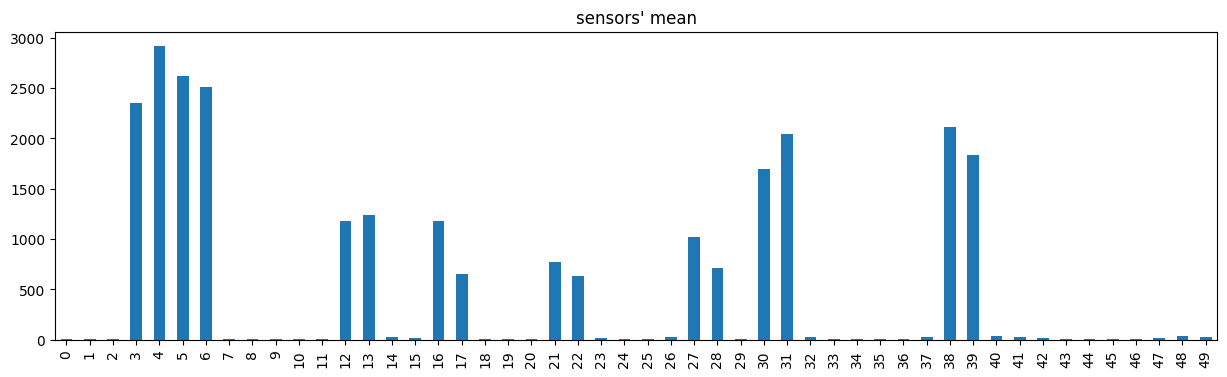

In [119]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [120]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [121]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [122]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [123]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [124]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [125]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.602; 0.578\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [126]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [127]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [128]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['3', '4', '5', '6', '10', '12', '13', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [129]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [130]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((17928, 26), (17928,)) 
 test: ((4433, 26), (4433,))


### **Model Learning**

#### Random Forest

In [131]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [132]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.945
accuracy: 0.945


In [133]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10603
        Open      1.000     1.000     1.000      1473
      Pistol      1.000     1.000     1.000      1463
       Thumb      1.000     1.000     1.000      1471
          OK      1.000     1.000     1.000      1461
        Grab      1.000     1.000     1.000      1457

    accuracy                          1.000     17928
   macro avg      1.000     1.000     1.000     17928
weighted avg      1.000     1.000     1.000     17928

              precision    recall  f1-score   support

     Neutral      0.946     0.977     0.961      2572
        Open      0.940     0.920     0.930       374
      Pistol      0.961     0.861     0.908       374
       Thumb      0.955     0.914     0.934       371
          OK      0.946     0.903     0.924       372
        Grab      0.918     0.908     0.913       370

    accuracy                          0.945      4433
   macro avg      0.944

In [134]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.945783    0.939891    0.961194    0.954930    0.946479   
recall        0.976672    0.919786    0.860963    0.913747    0.903226   
f1-score      0.960979    0.929730    0.908322    0.933884    0.924347   
support    2572.000000  374.000000  374.000000  371.000000  372.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.918033  0.944958     0.944385      0.945094  
recall       0.908108  0.944958     0.913750      0.944958  
f1-score     0.913043  0.944958     0.928384      0.944558  
support    370.000000  0.944958  4433.000000   4433.000000

In [135]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 7*

In [136]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

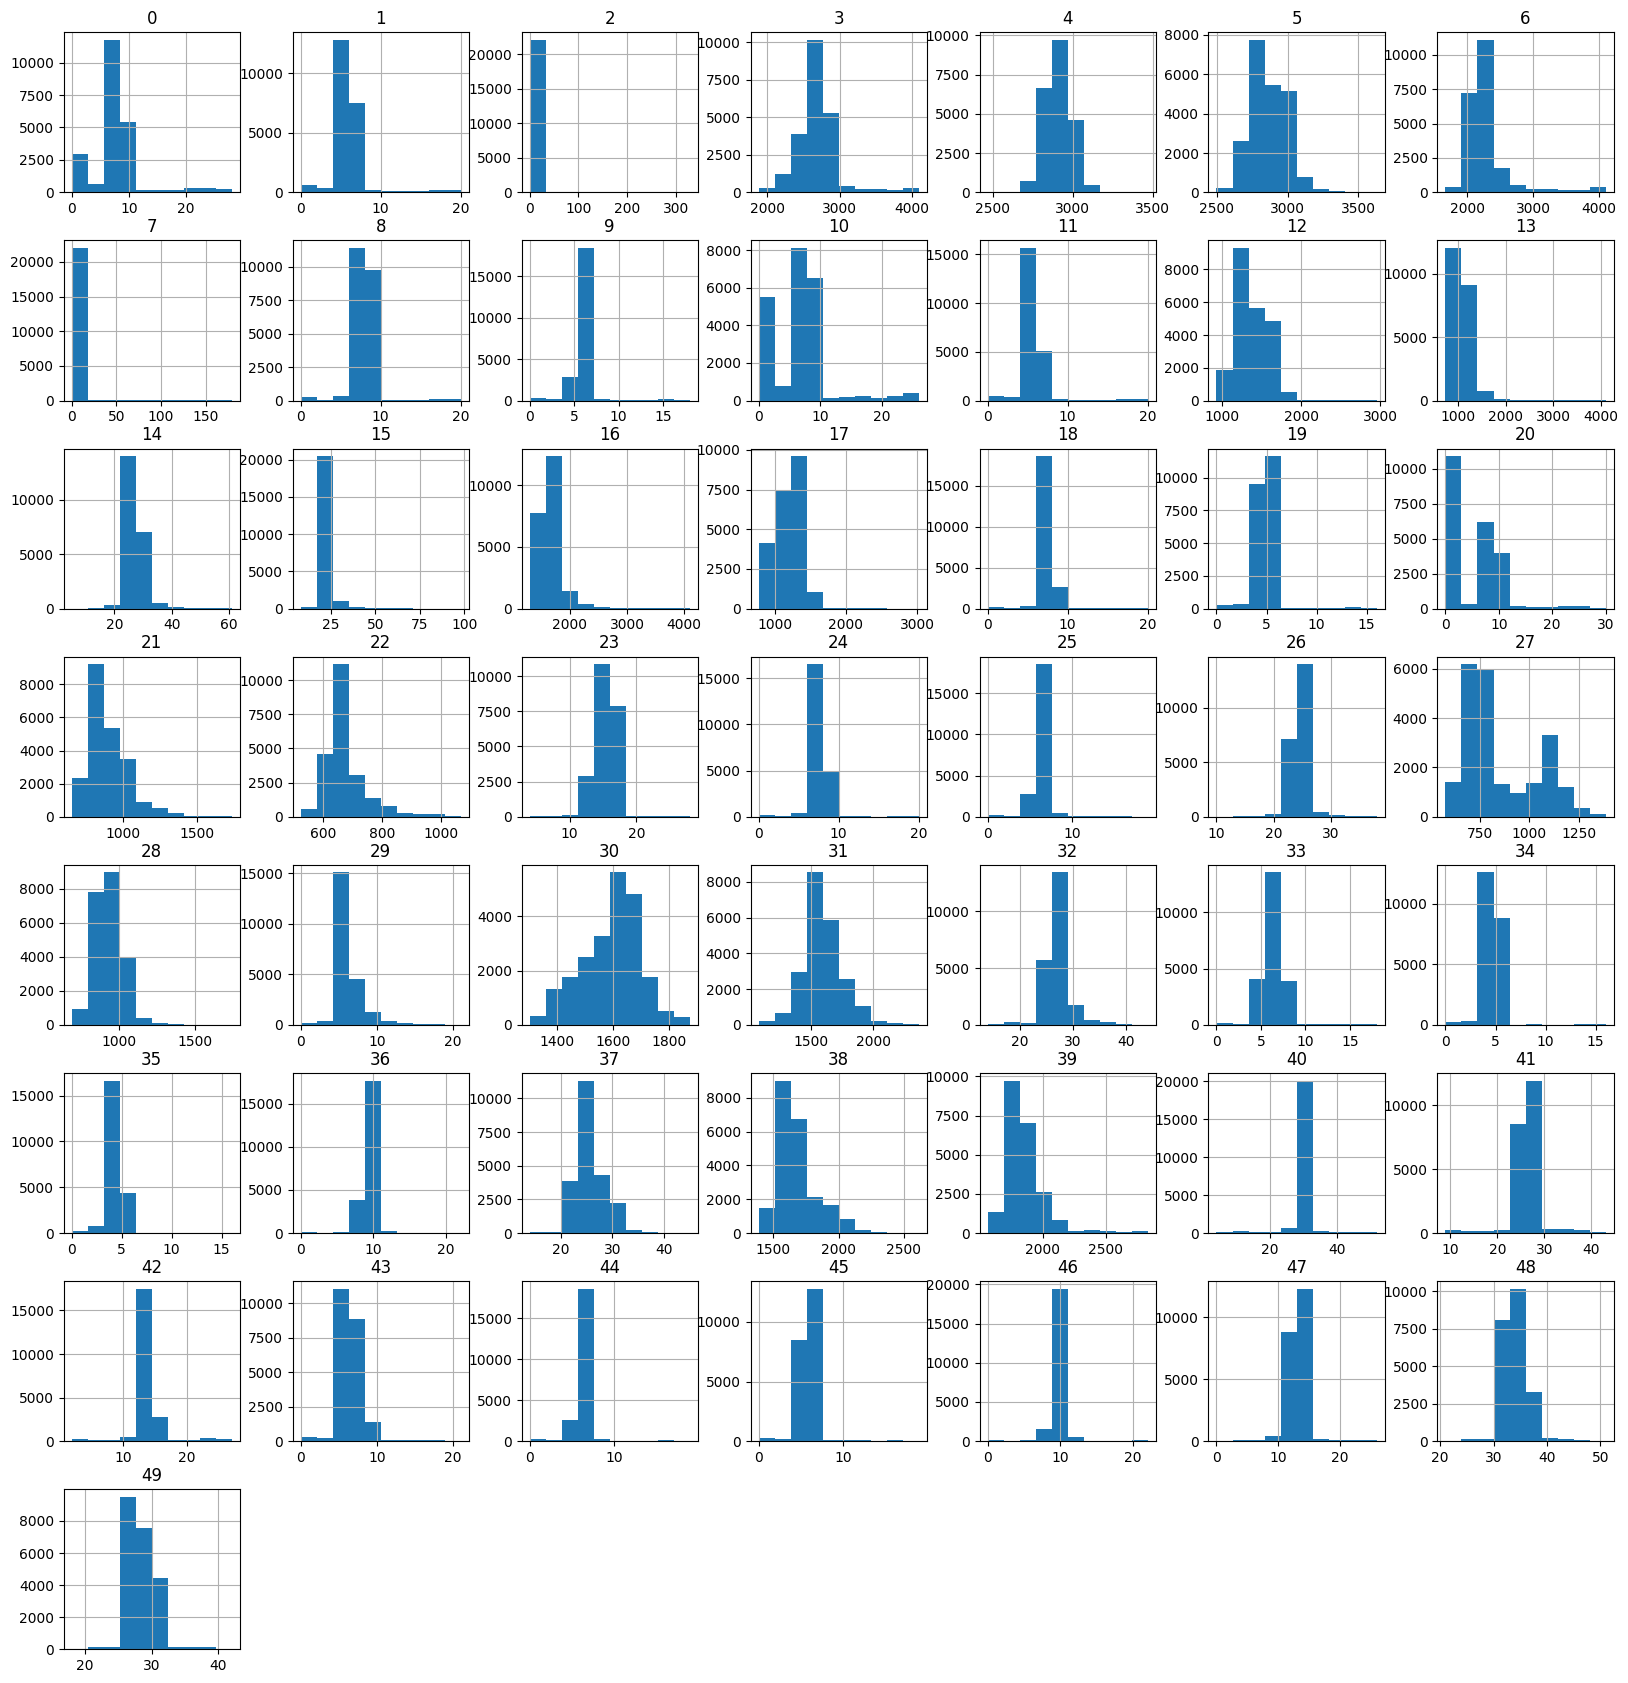

In [137]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [138]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  22200.00  22200.00  22200.00  22200.00  22200.00  22200.00  22200.00   
mean       7.91      5.48      6.90   2680.41   2905.90   2862.32   2298.61   
std        4.60      2.15      8.53    288.25     81.08    128.80    355.04   
min        0.00      0.00      0.00   1876.00   2467.00   2498.00   1673.00   
25%        8.00      5.00      6.00   2546.00   2849.00   2762.00   2122.00   
50%        8.00      5.00      6.00   2644.00   2903.00   2846.00   2226.00   
75%        9.00      6.00      7.00   2793.00   2963.00   2966.00   2333.00   
max       28.00     20.00    328.00   4095.00   3468.00   3628.00   4095.00   

              7         8         9  ...        40        41        42  \
count  22200.00  22200.00  22200.00  ...  22200.00  22200.00  22200.00   
mean       6.00      7.34      6.02  ...     29.65     25.97     13.70   
std        5.46      1.59      1.40  ...      4.26      3.05      2.45   
min        0.00      0.00      0.00  ...      4.00      9.00      2.00   
25%        5.00      7.00      6.00  ...     29.00     25.00     13.00   
50%        6.00      7.00      6.00  ...     30.00     26.00     14.00   
75%        6.00      8.00      6.00  ...     31.00     27.00     14.00   
max      179.00     20.00     18.00  ...     52.00     43.00     27.00   

             43        44        45        46        47        48        49  
count  22200.00  22200.00  22200.00  22200.00  22200.00  22200.00  22200.00  
mean       6.83      5.96      5.64      9.42     12.81     33.69     28.16  
std        1.75      1.36      1.45      1.59      1.64      2.18      1.95  
min        0.00      0.00      0.00      0.00      0.00     21.00     18.00  
25%        6.00      6.00      5.00      9.00     12.00     32.00     27.00  
50%        6.00      6.00      6.00      9.00     13.00     34.00     28.00  
75%        8.00      6.00      6.00     10.00     13.00     35.00     29.00  
max       21.00     19.00     19.00     22.00     26.00     51.00     42.00  

[8 rows x 50 columns]

In [139]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [140]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

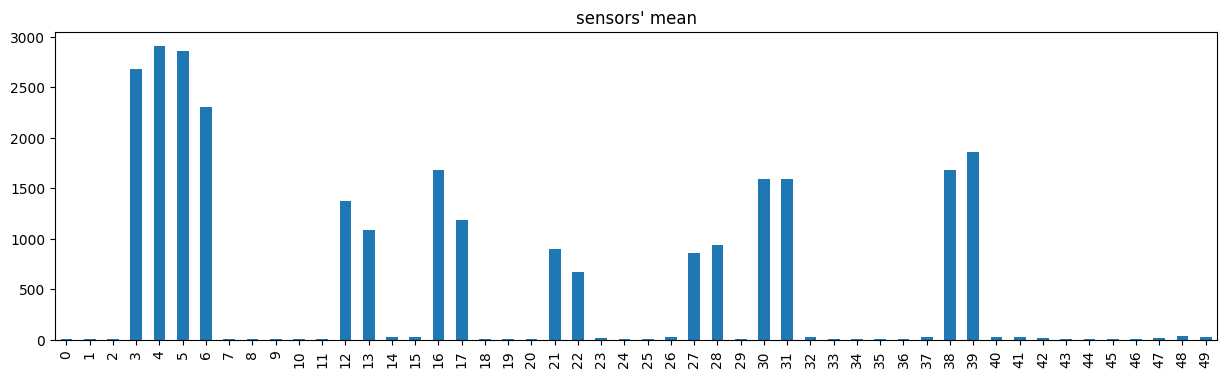

In [141]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [142]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [143]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [144]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [145]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [146]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [147]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.57; 0.594\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [148]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [149]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [150]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['2', '3', '4', '5', '6', '7', '12', '13', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [151]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [152]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((17758, 26), (17758,)) 
 test: ((4442, 26), (4442,))


### **Model Learning**

#### Random Forest

In [153]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [154]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.959
accuracy: 0.959


In [155]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10445
        Open      1.000     1.000     1.000      1466
      Pistol      1.000     1.000     1.000      1456
       Thumb      1.000     1.000     1.000      1454
          OK      1.000     1.000     1.000      1470
        Grab      1.000     1.000     1.000      1467

    accuracy                          1.000     17758
   macro avg      1.000     1.000     1.000     17758
weighted avg      1.000     1.000     1.000     17758

              precision    recall  f1-score   support

     Neutral      0.972     0.978     0.975      2595
        Open      0.944     0.949     0.946       370
      Pistol      0.941     0.863     0.900       371
       Thumb      0.975     0.940     0.957       367
          OK      0.926     0.954     0.940       369
        Grab      0.919     0.957     0.938       370

    accuracy                          0.959      4442
   macro avg      0.946

In [156]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.972424    0.943548    0.941176    0.974576    0.926316   
recall        0.978420    0.948649    0.862534    0.940054    0.953930   
f1-score      0.975413    0.946092    0.900141    0.957004    0.939920   
support    2595.000000  370.000000  371.000000  367.000000  369.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.919481  0.959253     0.946254      0.959347  
recall       0.956757  0.959253     0.940057      0.959253  
f1-score     0.937748  0.959253     0.942720      0.959077  
support    370.000000  0.959253  4442.000000   4442.000000

In [157]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 8*

In [158]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

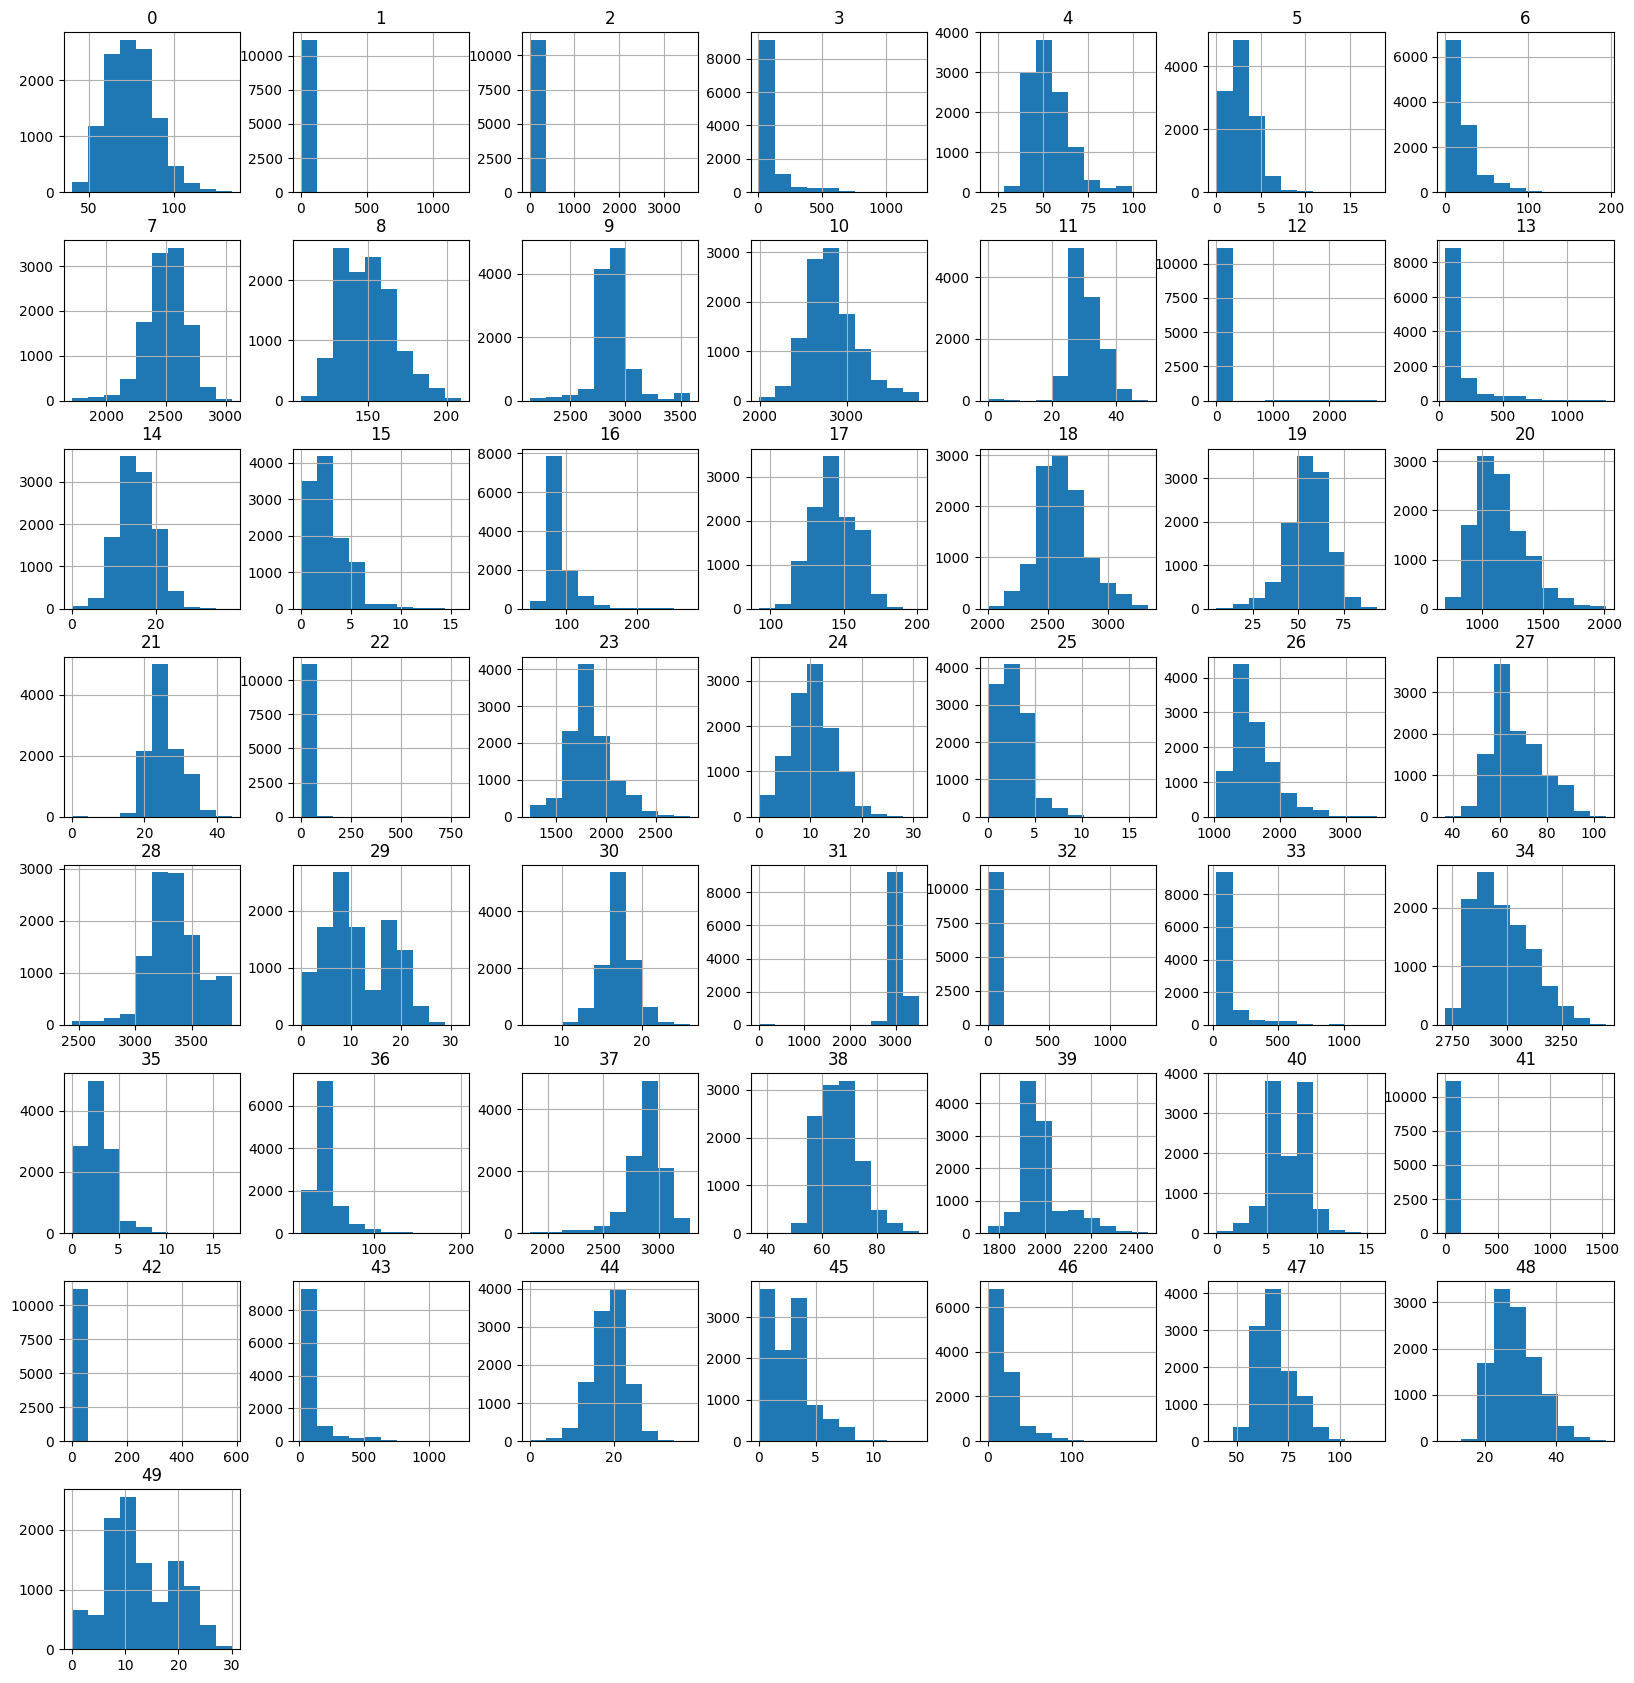

In [159]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [160]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11200.00  11200.00  11200.00  11200.00  11200.00  11200.00  11200.00   
mean      74.96     86.20     13.98     90.64     53.01      2.55     23.69   
std       13.96     17.13    154.41    141.90     11.13      1.89     18.57   
min       40.00      0.00      0.00      8.00     19.00      0.00      0.00   
25%       65.00     79.00      2.00     18.00     45.00      1.00     13.00   
50%       74.00     86.00      3.00     32.00     51.00      2.00     17.00   
75%       84.00     92.00      3.00     96.00     59.00      4.00     26.00   
max      134.00   1209.00   3567.00   1251.00    108.00     18.00    193.00   

              7         8         9  ...        40        41        42  \
count  11200.00  11200.00  11200.00  ...  11200.00  11200.00  11200.00   
mean    2498.56    149.32   2886.53  ...      6.89     28.41      2.77   
std      174.24     17.04    168.49  ...      1.81     15.32      6.09   
min     1710.00    107.00   2134.00  ...      0.00      0.00      0.00   
25%     2394.00    136.00   2806.00  ...      6.00     25.00      2.00   
50%     2507.00    148.00   2875.00  ...      7.00     28.00      2.00   
75%     2619.00    160.00   2957.00  ...      8.00     31.00      3.00   
max     3051.00    209.00   3583.00  ...     16.00   1538.00    582.00   

             43        44        45        46        47        48        49  
count  11200.00  11200.00  11200.00  11200.00  11200.00  11200.00  11200.00  
mean      85.70     18.70      2.60     22.27     68.26     28.33     12.27  
std      139.62      4.15      2.06     16.94      9.16      5.90      6.41  
min        9.00      0.00      0.00      0.00     40.00      9.00      0.00  
25%       17.00     16.00      1.00     13.00     62.00     24.00      8.00  
50%       27.00     19.00      2.00     16.00     66.00     27.00     11.00  
75%       85.25     21.00      4.00     24.00     74.00     32.00     18.00  
max     1243.00     38.00     14.00    190.00    118.00     54.00     30.00  

[8 rows x 50 columns]

In [161]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [162]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

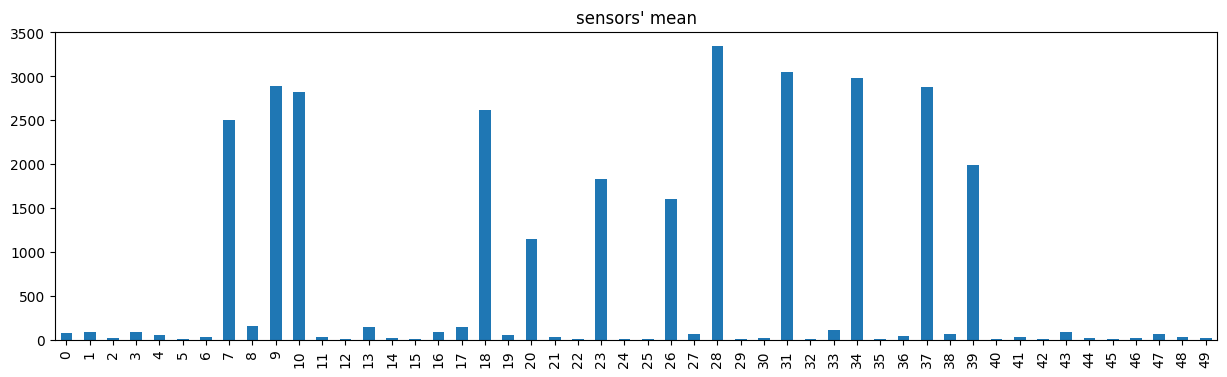

In [163]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [164]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [165]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [166]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [167]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [168]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [169]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.599; 0.58\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [170]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [171]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [172]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '2', '3', '4', '6', '7', '8', '9', '10', '12', '13', '16', '17', '18', '19', '20', '22', '23', '26', '28', '29', '31', '32', '33', '34', '36', '37', '39', '41', '42', '43', '46', '49', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [173]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [174]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5693, 41), (5693,)) 
 test: ((5507, 41), (5507,))


### **Model Learning**

#### Random Forest

In [175]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [176]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.944
accuracy: 0.944


In [177]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3405
        Open      1.000     1.000     1.000       459
      Pistol      1.000     1.000     1.000       457
       Thumb      1.000     1.000     1.000       457
          OK      1.000     1.000     1.000       458
        Grab      1.000     1.000     1.000       457

    accuracy                          1.000      5693
   macro avg      1.000     1.000     1.000      5693
weighted avg      1.000     1.000     1.000      5693

              precision    recall  f1-score   support

     Neutral      0.955     0.979     0.967      3216
        Open      0.941     0.913     0.927       458
      Pistol      0.943     0.904     0.923       459
       Thumb      0.894     0.888     0.891       457
          OK      0.926     0.845     0.884       459
        Grab      0.934     0.924     0.929       458

    accuracy                          0.944      5507
   macro avg      0.932

In [178]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.955414    0.941441    0.943182    0.894273    0.926014   
recall        0.979478    0.912664    0.904139    0.888403    0.845316   
f1-score      0.967296    0.926829    0.923248    0.891328    0.883827   
support    3216.000000  458.000000  459.000000  457.000000  459.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.933775  0.944253     0.932350      0.943909  
recall       0.923581  0.944253     0.908930      0.944253  
f1-score     0.928650  0.944253     0.920196      0.943784  
support    458.000000  0.944253  5507.000000   5507.000000

In [179]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 9*

In [180]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

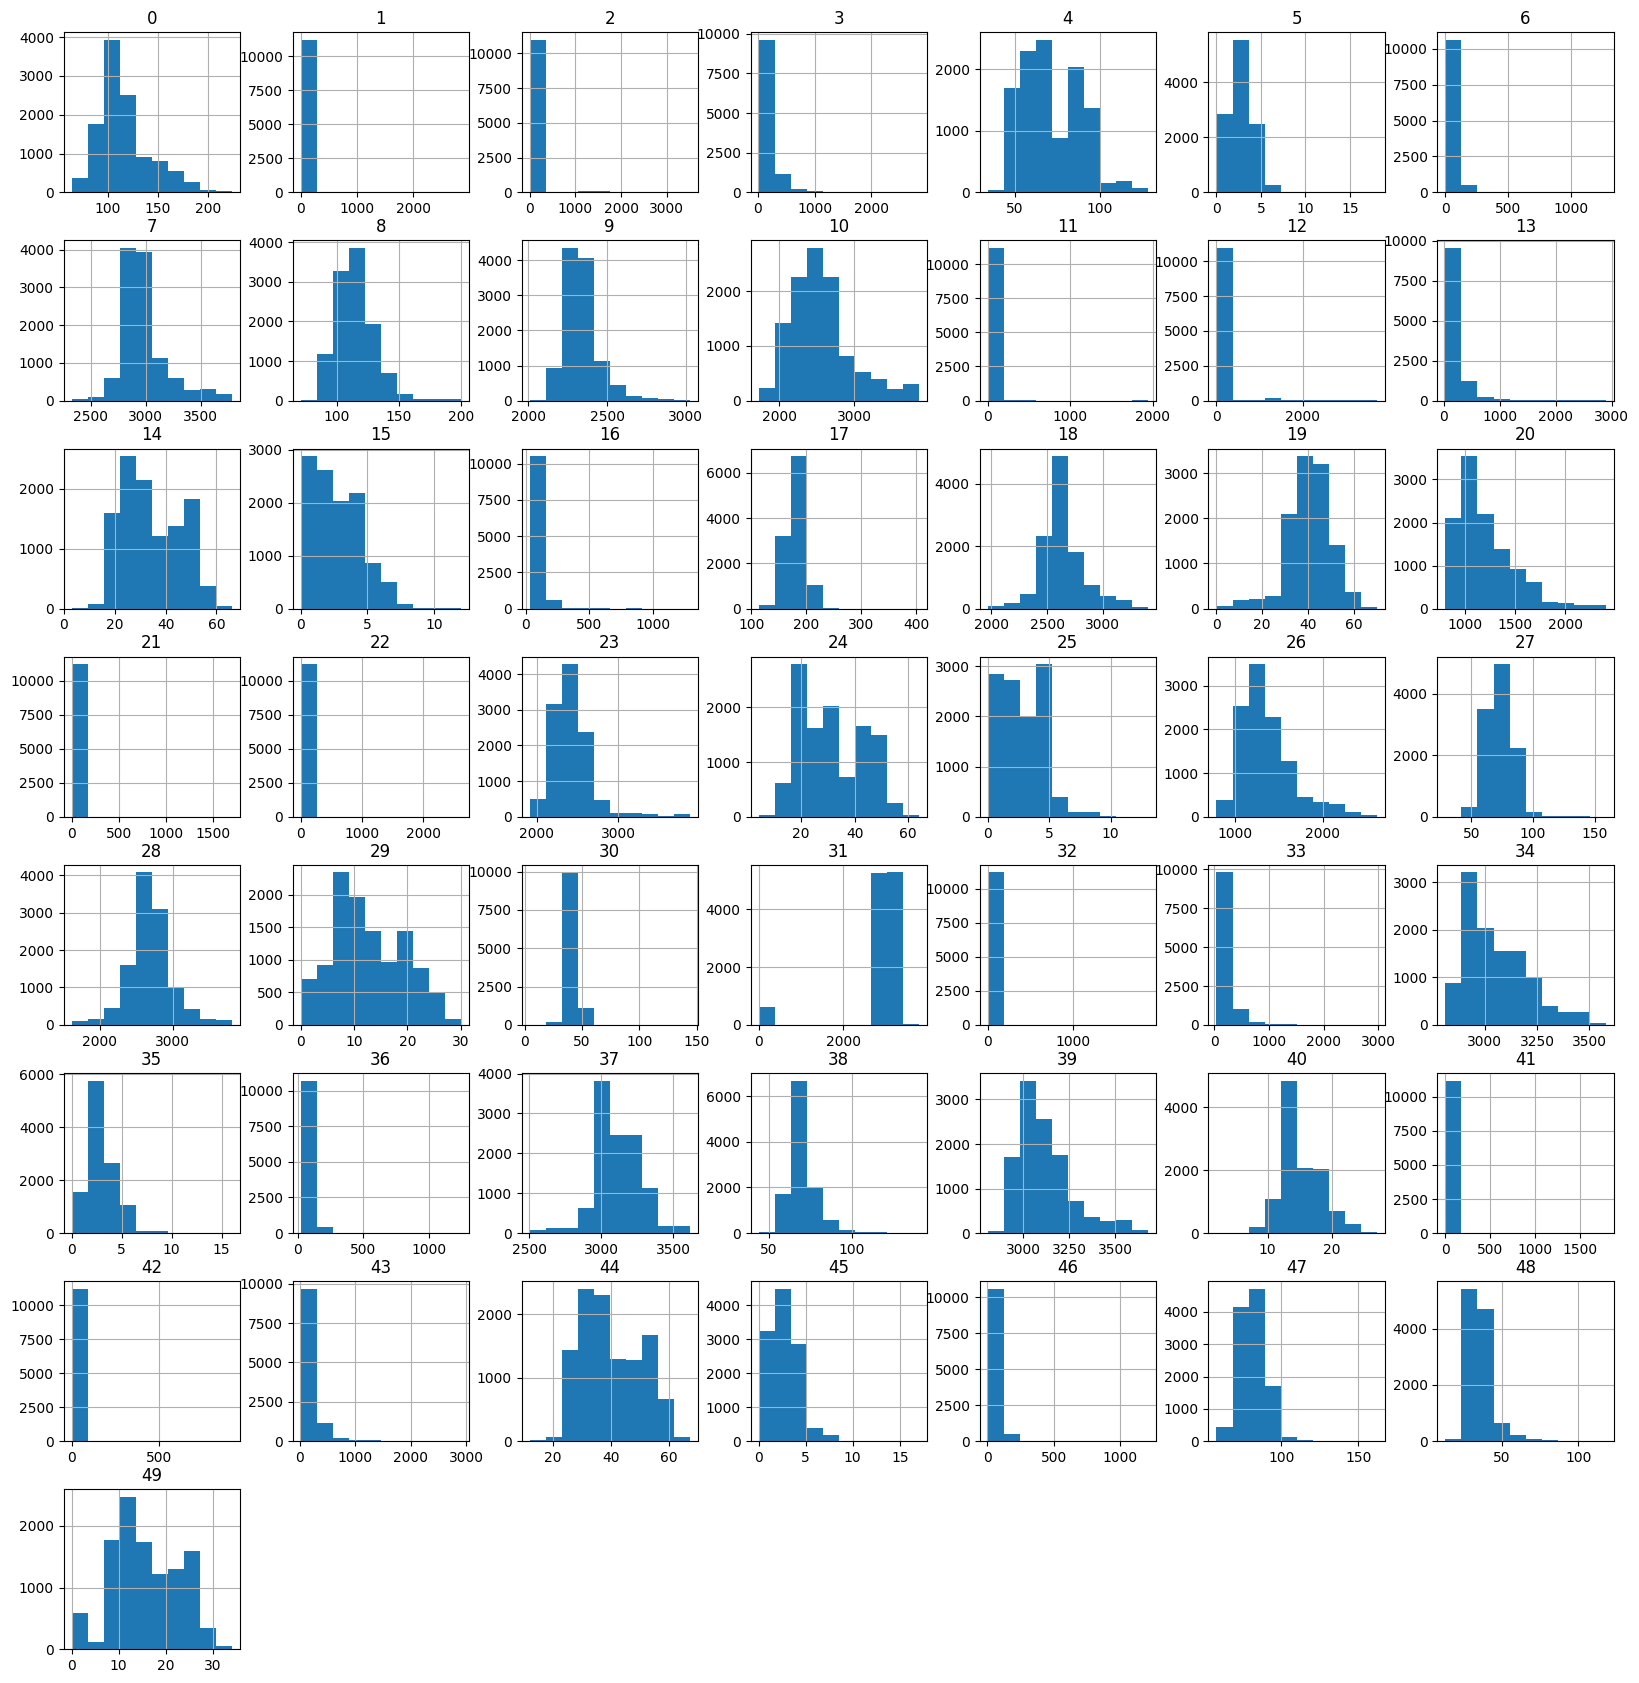

In [181]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [182]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11203.0  11203.00  11203.00  11203.00  11203.00  11203.00  11203.00   
mean     115.2     80.97     35.21    152.05     71.32      2.47     51.48   
std       25.7     42.81    221.37    220.06     16.97      1.52     61.53   
min       64.0      0.00      0.00     14.00     34.00      0.00      2.00   
25%       99.0     77.00      2.00     28.00     56.00      1.00     20.00   
50%      109.0     82.00      3.00     62.00     68.00      2.00     38.00   
75%      126.0     86.00      3.00    205.00     87.00      4.00     64.00   
max      224.0   2841.00   3498.00   2832.00    128.00     18.00   1271.00   

              7         8         9  ...        40        41        42  \
count  11203.00  11203.00  11203.00  ...  11203.00  11203.00  11203.00   
mean    2976.66    114.49   2331.16  ...     14.78     21.74      3.57   
std      204.71     15.41    110.79  ...      3.13     21.33     14.39   
min     2326.00     71.00   2008.00  ...      2.00      0.00      0.00   
25%     2859.00    103.00   2247.00  ...     12.00     20.00      2.00   
50%     2931.00    113.00   2319.00  ...     14.00     22.00      3.00   
75%     3035.00    123.00   2379.00  ...     17.00     24.00      3.00   
max     3784.00    200.00   3025.00  ...     27.00   1785.00    920.00   

             43        44        45        46        47        48        49  
count  11203.00  11203.00  11203.00  11203.00  11203.00  11203.00  11203.00  
mean     149.97     39.64      2.56     48.76     81.46     35.38     15.65  
std      218.93     10.09      1.79     60.36      8.55      8.82      7.01  
min       14.00     12.00      0.00      1.00     58.00     13.00      0.00  
25%       28.00     31.00      1.00     20.00     75.00     30.00     11.00  
50%       60.00     38.00      2.00     35.00     81.00     34.00     14.00  
75%      201.00     49.00      4.00     60.00     87.00     38.00     22.00  
max     2903.00     67.00     17.00   1209.00    162.00    118.00     34.00  

[8 rows x 50 columns]

In [183]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [184]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

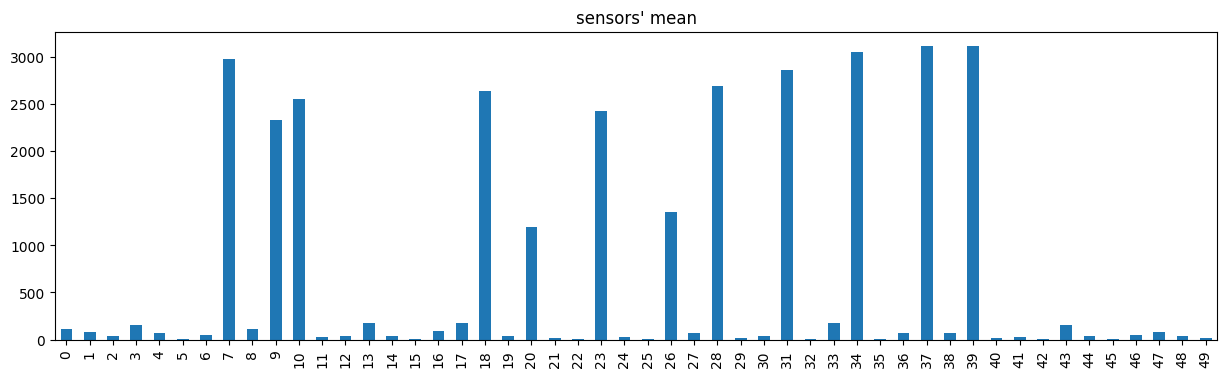

In [185]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [186]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [187]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [188]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [189]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [190]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [191]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.602; 0.579\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [192]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [193]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [194]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '16', '17', '18', '19', '20', '21', '22', '23', '26', '27', '28', '29', '31', '32', '33', '34', '36', '37', '38', '39', '41', '42', '43', '46', '47', '48', '49', 'ACC1', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [195]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [196]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5694, 46), (5694,)) 
 test: ((5509, 46), (5509,))


### **Model Learning**

#### Random Forest

In [197]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [198]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.952
accuracy: 0.952


In [199]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3407
        Open      1.000     1.000     1.000       456
      Pistol      1.000     1.000     1.000       456
       Thumb      1.000     1.000     1.000       459
          OK      1.000     1.000     1.000       457
        Grab      1.000     1.000     1.000       459

    accuracy                          1.000      5694
   macro avg      1.000     1.000     1.000      5694
weighted avg      1.000     1.000     1.000      5694

              precision    recall  f1-score   support

     Neutral      0.957     0.979     0.968      3221
        Open      0.975     0.865     0.917       458
      Pistol      0.951     0.939     0.945       458
       Thumb      0.926     0.930     0.928       459
          OK      0.924     0.899     0.911       457
        Grab      0.947     0.939     0.943       456

    accuracy                          0.952      5509
   macro avg      0.947

In [200]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.957486    0.975369    0.951327    0.926247    0.923596   
recall        0.978889    0.864629    0.938865    0.930283    0.899344   
f1-score      0.968069    0.916667    0.945055    0.928261    0.911308   
support    3221.000000  458.000000  458.000000  459.000000  457.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.946903  0.952078     0.946821      0.952170  
recall       0.938596  0.952078     0.925101      0.952078  
f1-score     0.942731  0.952078     0.935348      0.951759  
support    456.000000  0.952078  5509.000000   5509.000000

In [201]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 10*

In [202]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

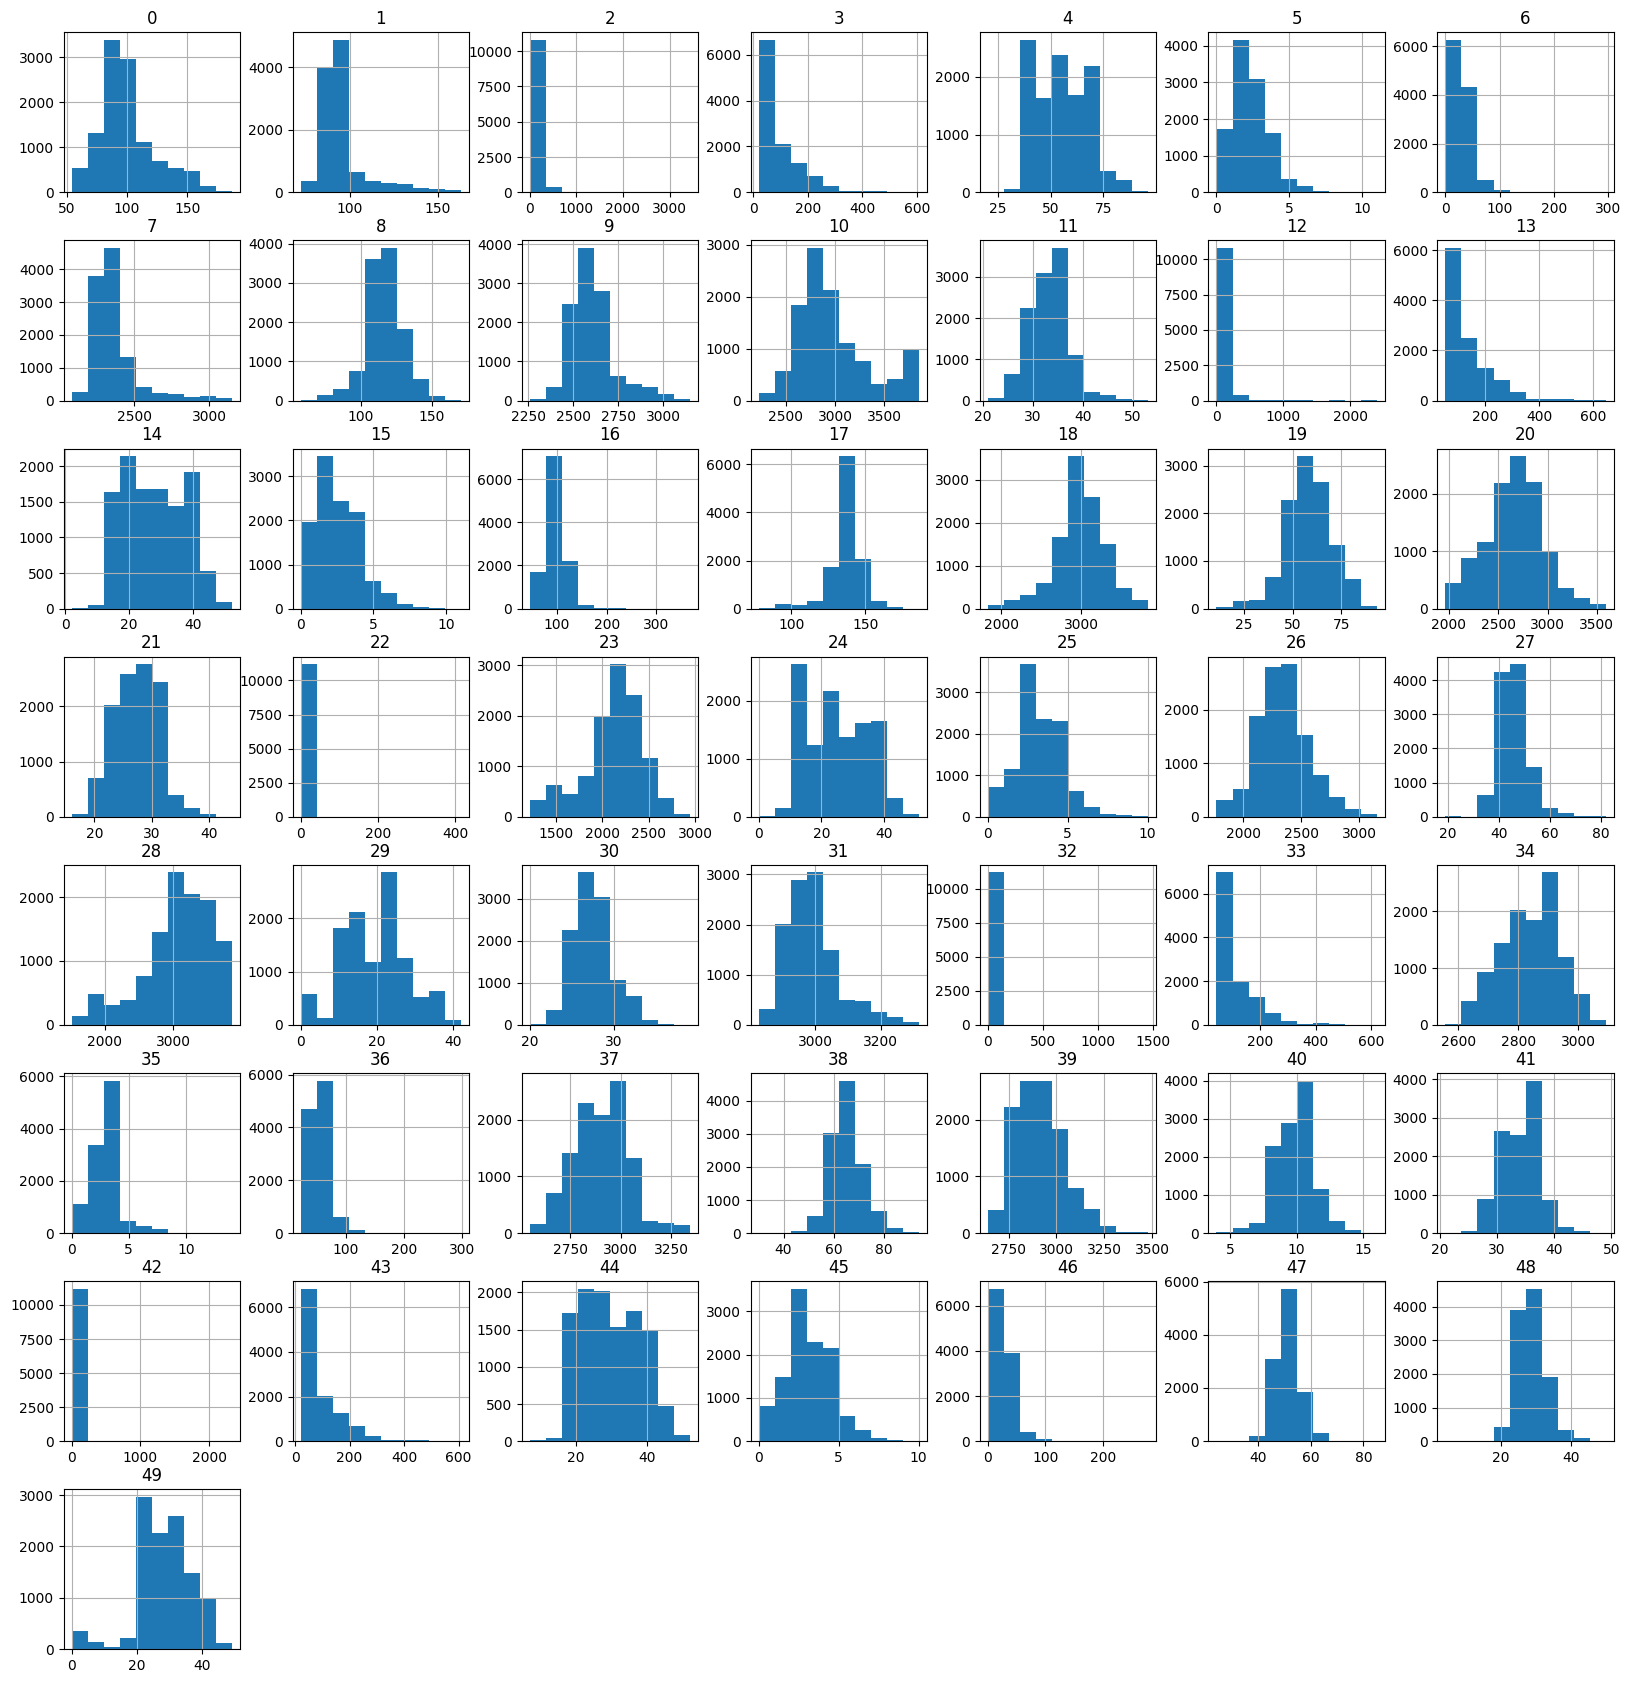

In [203]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [204]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11195.00  11195.00  11195.00  11195.00  11195.00  11195.00  11195.00   
mean      99.49     95.63     24.36     93.75     54.90      2.56     32.46   
std       23.01     13.46    120.23     77.52     12.29      1.21     17.60   
min       54.00     72.00      0.00     20.00     20.00      0.00      0.00   
25%       85.00     89.00      2.00     39.00     43.00      2.00     20.00   
50%       95.00     92.00      2.00     62.00     54.00      2.00     28.00   
75%      109.00     97.00      3.00    125.00     66.00      3.00     42.00   
max      187.00    163.00   3431.00    606.00     96.00     11.00    296.00   

              7         8         9  ...        40        41       42  \
count  11195.00  11195.00  11195.00  ...  11195.00  11195.00  11195.0   
mean    2360.17    116.15   2605.15  ...      9.65     33.98      2.9   
std      152.79     13.13    125.73  ...      1.55      3.07     31.2   
min     2083.00     58.00   2258.00  ...      4.00     21.00      0.0   
25%     2271.00    108.00   2523.00  ...      9.00     32.00      2.0   
50%     2326.00    115.00   2588.00  ...      9.00     34.00      2.0   
75%     2388.00    124.00   2650.00  ...     11.00     36.00      3.0   
max     3150.00    170.00   3148.00  ...     16.00     49.00   2325.0   

             43        44        45        46        47        48        49  
count  11195.00  11195.00  11195.00  11195.00  11195.00  11195.00  11195.00  
mean      90.33     29.66      2.60     29.11     51.00     28.17     28.35  
std       76.43      8.11      1.46     15.97      4.66      4.06      8.80  
min       20.00      7.00      0.00      0.00     24.00      4.00      0.00  
25%       37.00     22.00      2.00     18.00     48.00     25.00     23.00  
50%       59.00     29.00      2.00     24.00     51.00     28.00     29.00  
75%      120.00     37.00      4.00     37.00     54.00     30.00     34.00  
max      608.00     52.00     10.00    277.00     85.00     50.00     49.00  

[8 rows x 50 columns]

In [205]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [206]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

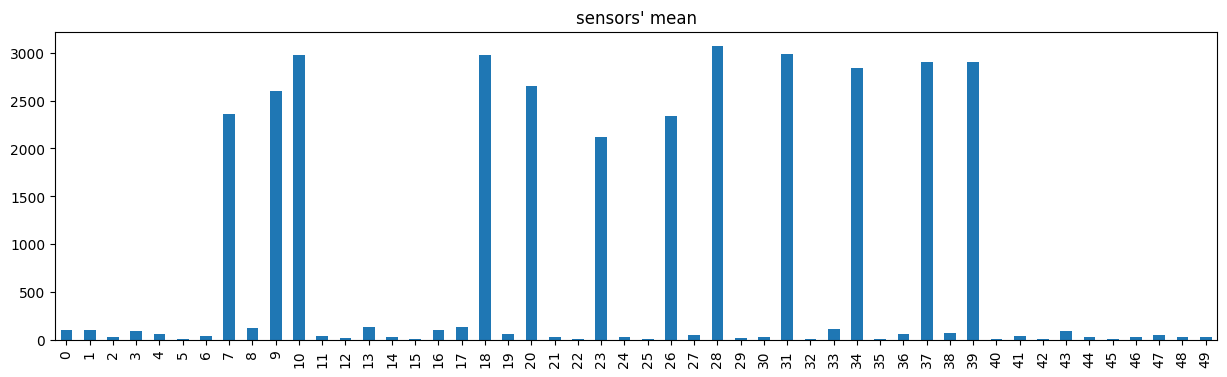

In [207]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [208]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [209]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [210]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [211]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [212]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [213]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.601; 0.578\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [214]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [215]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [216]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '2', '3', '4', '6', '7', '8', '9', '10', '12', '13', '16', '17', '18', '19', '20', '22', '23', '26', '28', '29', '31', '32', '33', '34', '36', '37', '39', '42', '43', '46', '49', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [217]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [218]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5690, 40), (5690,)) 
 test: ((5505, 40), (5505,))


### **Model Learning**

#### Random Forest

In [219]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [220]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.960
accuracy: 0.960


In [221]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3408
        Open      1.000     1.000     1.000       456
      Pistol      1.000     1.000     1.000       456
       Thumb      1.000     1.000     1.000       458
          OK      1.000     1.000     1.000       457
        Grab      1.000     1.000     1.000       455

    accuracy                          1.000      5690
   macro avg      1.000     1.000     1.000      5690
weighted avg      1.000     1.000     1.000      5690

              precision    recall  f1-score   support

     Neutral      0.967     0.980     0.973      3212
        Open      0.968     0.917     0.942       458
      Pistol      0.950     0.944     0.947       461
       Thumb      0.977     0.921     0.948       458
          OK      0.944     0.961     0.952       458
        Grab      0.915     0.919     0.917       458

    accuracy                          0.960      5505
   macro avg      0.953

In [222]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.966820    0.967742    0.949782    0.976852    0.944206   
recall        0.979763    0.917031    0.943601    0.921397    0.960699   
f1-score      0.973249    0.941704    0.946681    0.948315    0.952381   
support    3212.000000  458.000000  461.000000  458.000000  458.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.915217  0.960036     0.953437      0.960130  
recall       0.919214  0.960036     0.940284      0.960036  
f1-score     0.917211  0.960036     0.946590      0.959927  
support    458.000000  0.960036  5505.000000   5505.000000

In [223]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 11*

In [224]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

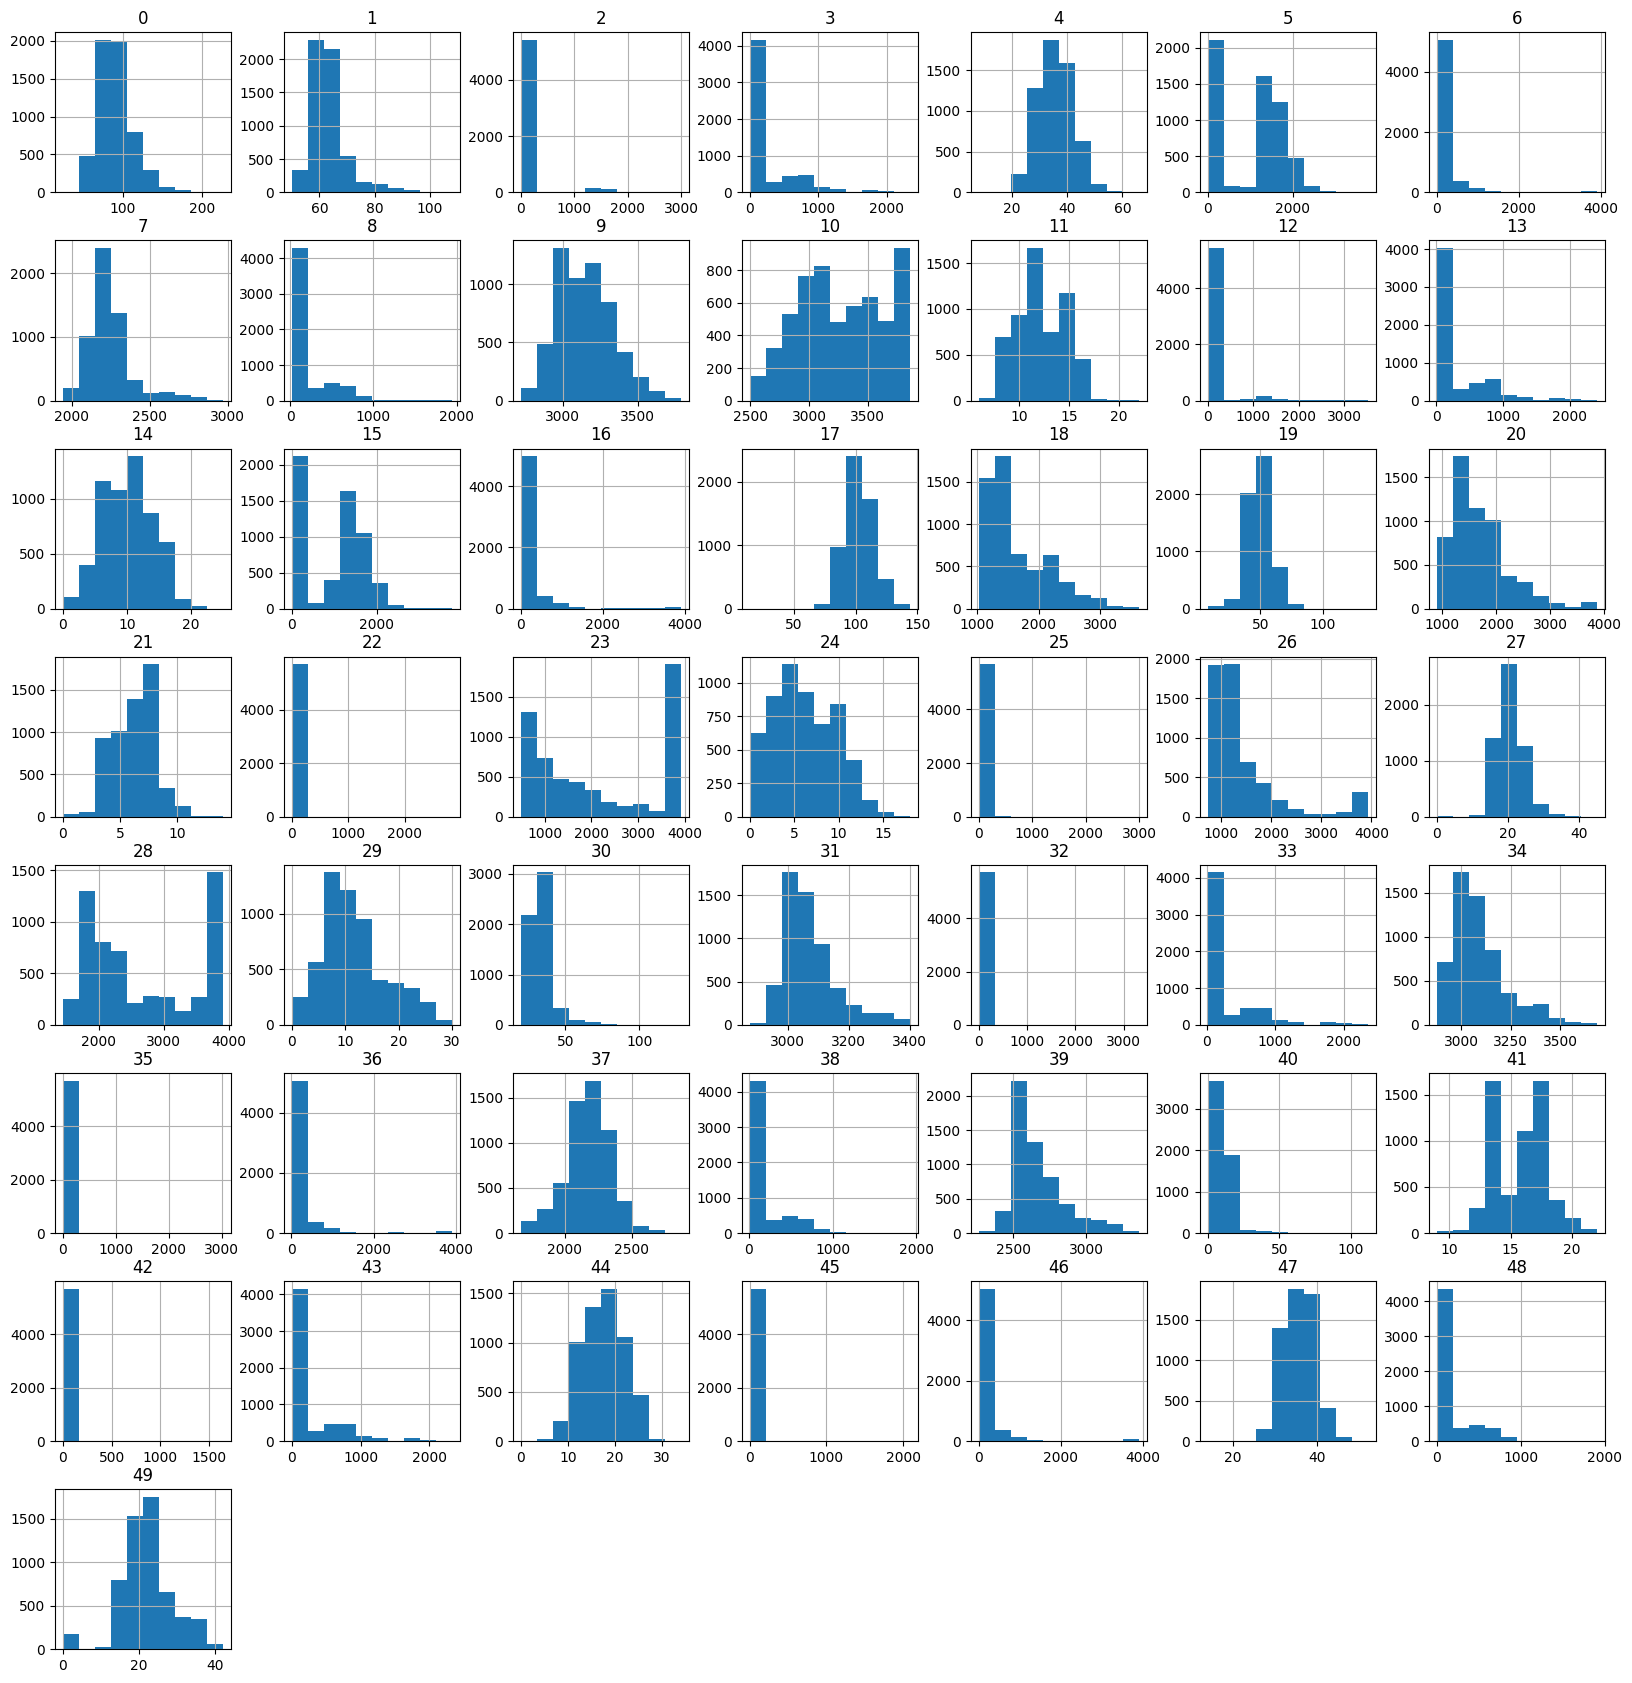

In [225]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [226]:
gestures.iloc[:, :50].describe().round(2)

0        1        2        3        4        5        6        7  \
count  5718.00  5718.00  5718.00  5718.00  5718.00  5718.00  5718.00  5718.00   
mean     90.43    63.14    86.81   238.40    35.37  1004.12   176.97  2239.69   
std      21.81     6.70   358.30   406.88     6.29   803.31   481.92   142.91   
min      24.00    50.00     0.00     0.00     8.00     0.00     0.00  1943.00   
25%      76.00    59.00     2.00     8.00    31.00     6.00    11.00  2162.00   
50%      88.00    62.00     2.00    16.00    35.00  1324.00    18.50  2208.00   
75%     102.00    66.00     3.00   370.00    40.00  1632.00   129.75  2295.00   
max     226.00   108.00  2994.00  2340.00    66.00  3759.00  3895.00  2969.00   

             8        9  ...       40       41       42       43       44  \
count  5718.00  5718.00  ...  5718.00  5718.00  5718.00  5718.00  5718.00   
mean    170.20  3151.68  ...    10.77    15.78     3.94   238.42    17.40   
std     251.07   181.99  ...     5.92     2.19    31.48   404.81     4.37   
min      18.00  2723.00  ...     0.00     9.00     0.00     0.00     0.00   
25%      31.00  3012.00  ...     8.00    14.00     2.00    11.00    14.00   
50%      37.00  3137.50  ...    10.00    16.00     2.00    18.00    17.00   
75%     210.75  3279.00  ...    12.00    18.00     3.00   366.00    21.00   
max    1944.00  3786.00  ...   112.00    22.00  1640.00  2331.00    34.00   

            45       46       47       48       49  
count  5718.00  5718.00  5718.00  5718.00  5718.00  
mean     15.58   177.75    35.49   142.62    21.88  
std      40.36   481.32     3.70   242.26     7.04  
min       0.00     0.00    14.00     0.00     0.00  
25%       4.00    13.00    32.00    12.00    18.00  
50%      10.00    20.00    36.00    16.00    22.00  
75%      16.00   128.00    38.00   167.00    26.00  
max    2089.00  3896.00    52.00  1906.00    42.00  

[8 rows x 50 columns]

In [227]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [228]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

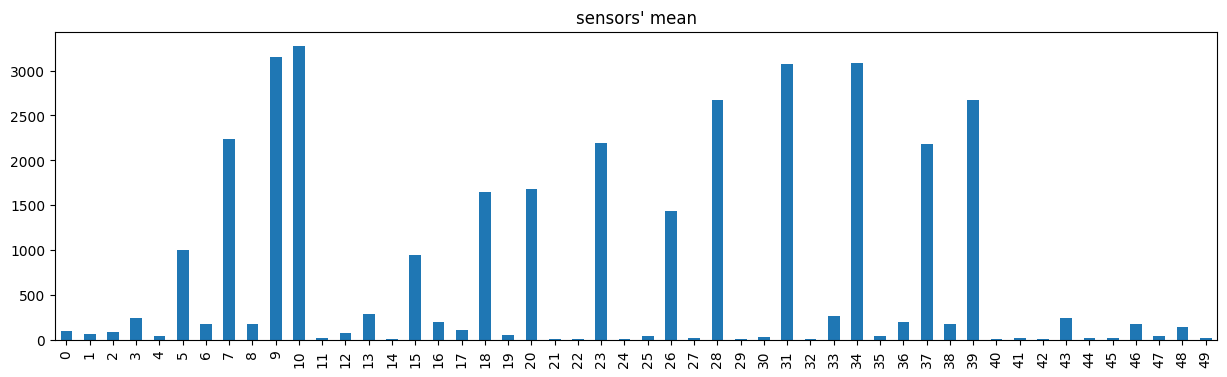

In [229]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [230]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [231]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [232]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [233]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [234]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [235]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.599; 0.583\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [236]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [237]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [238]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '48', '49', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [239]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [240]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((2769, 48), (2769,)) 
 test: ((2949, 48), (2949,))


### **Model Learning**

#### Random Forest

In [241]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [242]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.922
accuracy: 0.922


In [243]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      1700
        Open      1.000     1.000     1.000       212
      Pistol      1.000     1.000     1.000       213
       Thumb      1.000     1.000     1.000       215
          OK      1.000     1.000     1.000       214
        Grab      1.000     1.000     1.000       215

    accuracy                          1.000      2769
   macro avg      1.000     1.000     1.000      2769
weighted avg      1.000     1.000     1.000      2769

              precision    recall  f1-score   support

     Neutral      0.923     0.980     0.951      1725
        Open      0.945     0.775     0.851       244
      Pistol      0.958     0.833     0.891       246
       Thumb      0.976     0.833     0.899       245
          OK      0.844     0.893     0.868       243
        Grab      0.907     0.870     0.888       246

    accuracy                          0.922      2949
   macro avg      0.925

In [244]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.922531    0.945000    0.957944    0.976077    0.844358   
recall        0.980290    0.774590    0.833333    0.832653    0.893004   
f1-score      0.950534    0.851351    0.891304    0.898678    0.868000   
support    1725.000000  244.000000  246.000000  245.000000  243.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.906780  0.922347     0.925448      0.924037  
recall       0.869919  0.922347     0.863965      0.922347  
f1-score     0.887967  0.922347     0.891306      0.921059  
support    246.000000  0.922347  2949.000000   2949.000000

In [245]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 12*

In [246]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

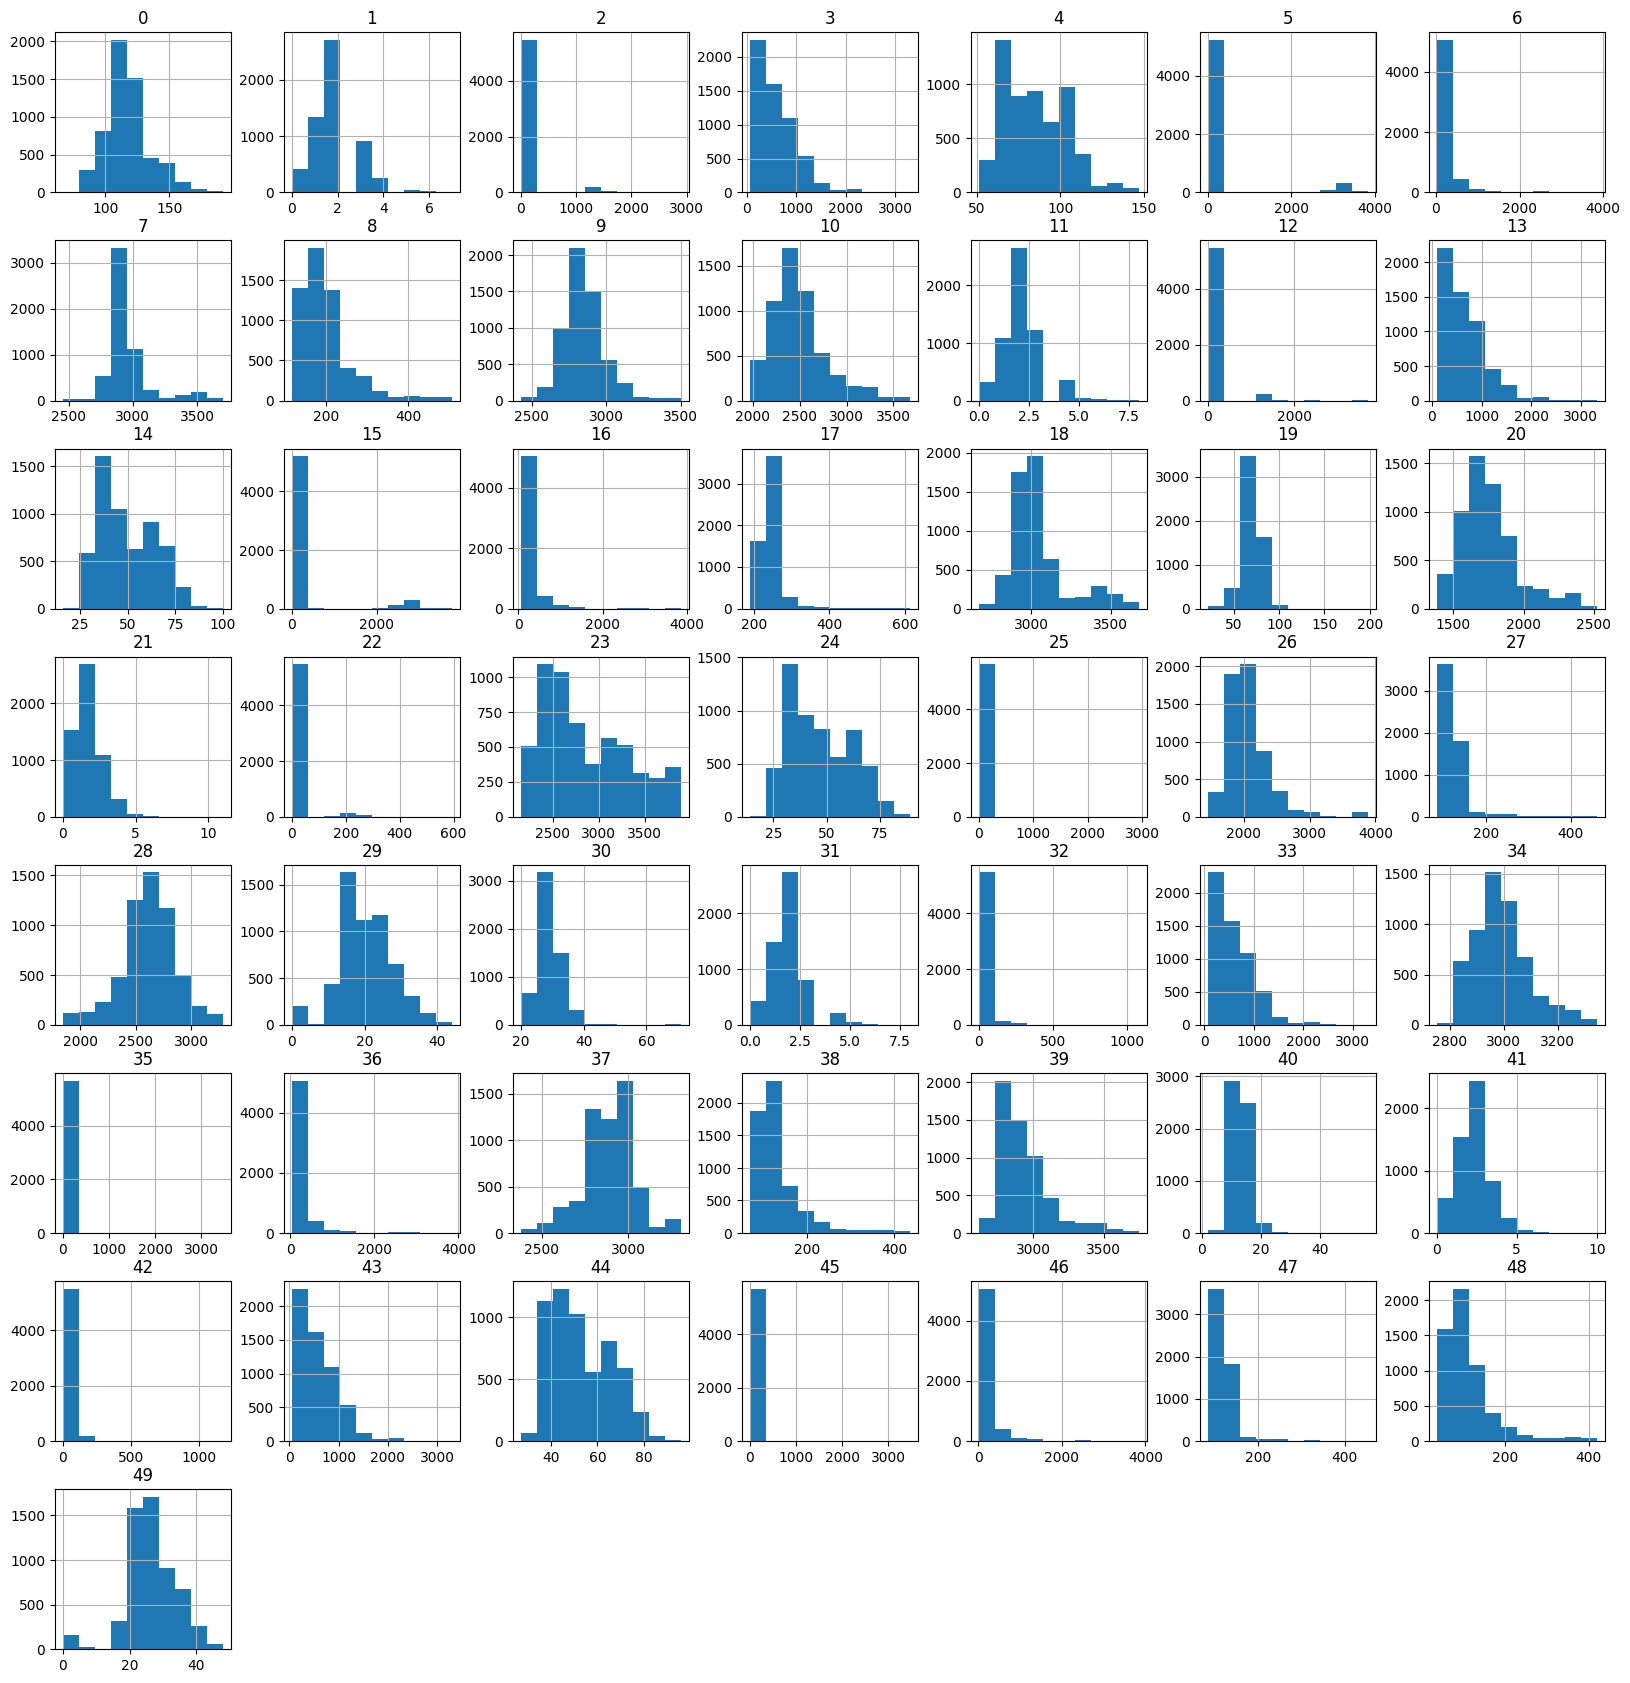

In [247]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [248]:
gestures.iloc[:, :50].describe().round(2)

0        1        2        3        4        5        6        7  \
count  5701.00  5701.00  5701.00  5701.00  5701.00  5701.00  5701.00  5701.00   
mean    117.42     1.91    60.55   557.69    84.44   269.19   190.63  2953.79   
std      17.37     1.00   281.17   420.45    18.40   864.61   345.21   169.52   
min      67.00     0.00     0.00    57.00    51.00     0.00    20.00  2456.00   
25%     108.00     1.00     2.00   186.00    68.00     2.00    40.00  2862.00   
50%     115.00     2.00     2.00   472.00    81.00     3.00    69.00  2911.00   
75%     125.00     2.00     3.00   828.00   100.00     5.00   202.00  2975.00   
max     192.00     7.00  2897.00  3295.00   147.00  3830.00  3848.00  3700.00   

             8        9  ...       40       41       42       43       44  \
count  5701.00  5701.00  ...  5701.00  5701.00  5701.00  5701.00  5701.00   
mean    197.66  2848.74  ...    12.86     1.81     8.68   551.94    52.78   
std      62.20   139.02  ...     3.71     1.06    36.98   419.81    13.03   
min     116.00  2426.00  ...     2.00     0.00     0.00    54.00    27.00   
25%     156.00  2767.00  ...    10.00     1.00     2.00   181.00    42.00   
50%     185.00  2832.00  ...    12.00     2.00     2.00   465.00    50.00   
75%     217.00  2918.00  ...    14.00     2.00     3.00   821.00    64.00   
max     506.00  3501.00  ...    56.00    10.00  1180.00  3298.00    96.00   

            45       46       47       48       49  
count  5701.00  5701.00  5701.00  5701.00  5701.00  
mean     11.97   185.12   121.13   112.68    26.15  
std      74.46   344.91    34.44    60.26     7.68  
min       0.00    16.00    85.00    38.00     0.00  
25%       2.00    35.00   105.00    70.00    22.00  
50%       3.00    64.00   113.00    99.00    25.00  
75%       5.00   193.00   128.00   128.00    31.00  
max    3464.00  3846.00   453.00   419.00    48.00  

[8 rows x 50 columns]

In [249]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [250]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

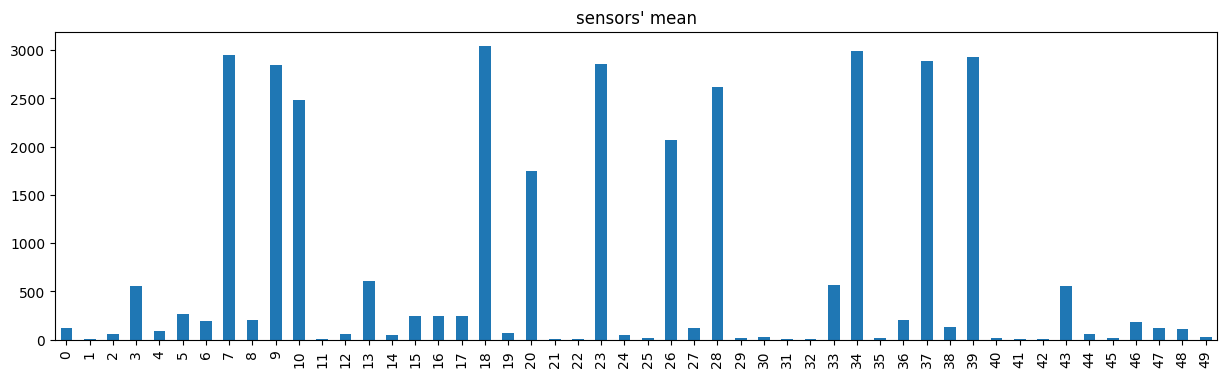

In [251]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [252]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [253]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [254]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [255]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [256]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [257]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.604; 0.581\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [258]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [259]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [260]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '25', '26', '27', '28', '29', '32', '33', '34', '35', '36', '37', '38', '39', '42', '43', '44', '45', '46', '47', '48', '49', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [261]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [262]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((2759, 50), (2759,)) 
 test: ((2942, 50), (2942,))


### **Model Learning**

#### Random Forest

In [263]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [264]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.933
accuracy: 0.933


In [265]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      1691
        Open      1.000     1.000     1.000       214
      Pistol      1.000     1.000     1.000       212
       Thumb      1.000     1.000     1.000       214
          OK      1.000     1.000     1.000       213
        Grab      1.000     1.000     1.000       215

    accuracy                          1.000      2759
   macro avg      1.000     1.000     1.000      2759
weighted avg      1.000     1.000     1.000      2759

              precision    recall  f1-score   support

     Neutral      0.941     0.981     0.961      1716
        Open      0.903     0.793     0.844       246
      Pistol      0.959     0.947     0.953       245
       Thumb      0.960     0.886     0.921       245
          OK      0.984     0.776     0.868       245
        Grab      0.822     0.927     0.871       245

    accuracy                          0.933      2942
   macro avg      0.928

In [266]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.941308    0.902778    0.958678    0.960177    0.984456   
recall        0.981352    0.792683    0.946939    0.885714    0.775510   
f1-score      0.960913    0.844156    0.952772    0.921444    0.867580   
support    1716.000000  246.000000  245.000000  245.000000  245.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.822464  0.933039     0.928310      0.934800  
recall       0.926531  0.933039     0.884788      0.933039  
f1-score     0.871401  0.933039     0.903044      0.931959  
support    245.000000  0.933039  2942.000000   2942.000000

In [267]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 13*

In [268]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

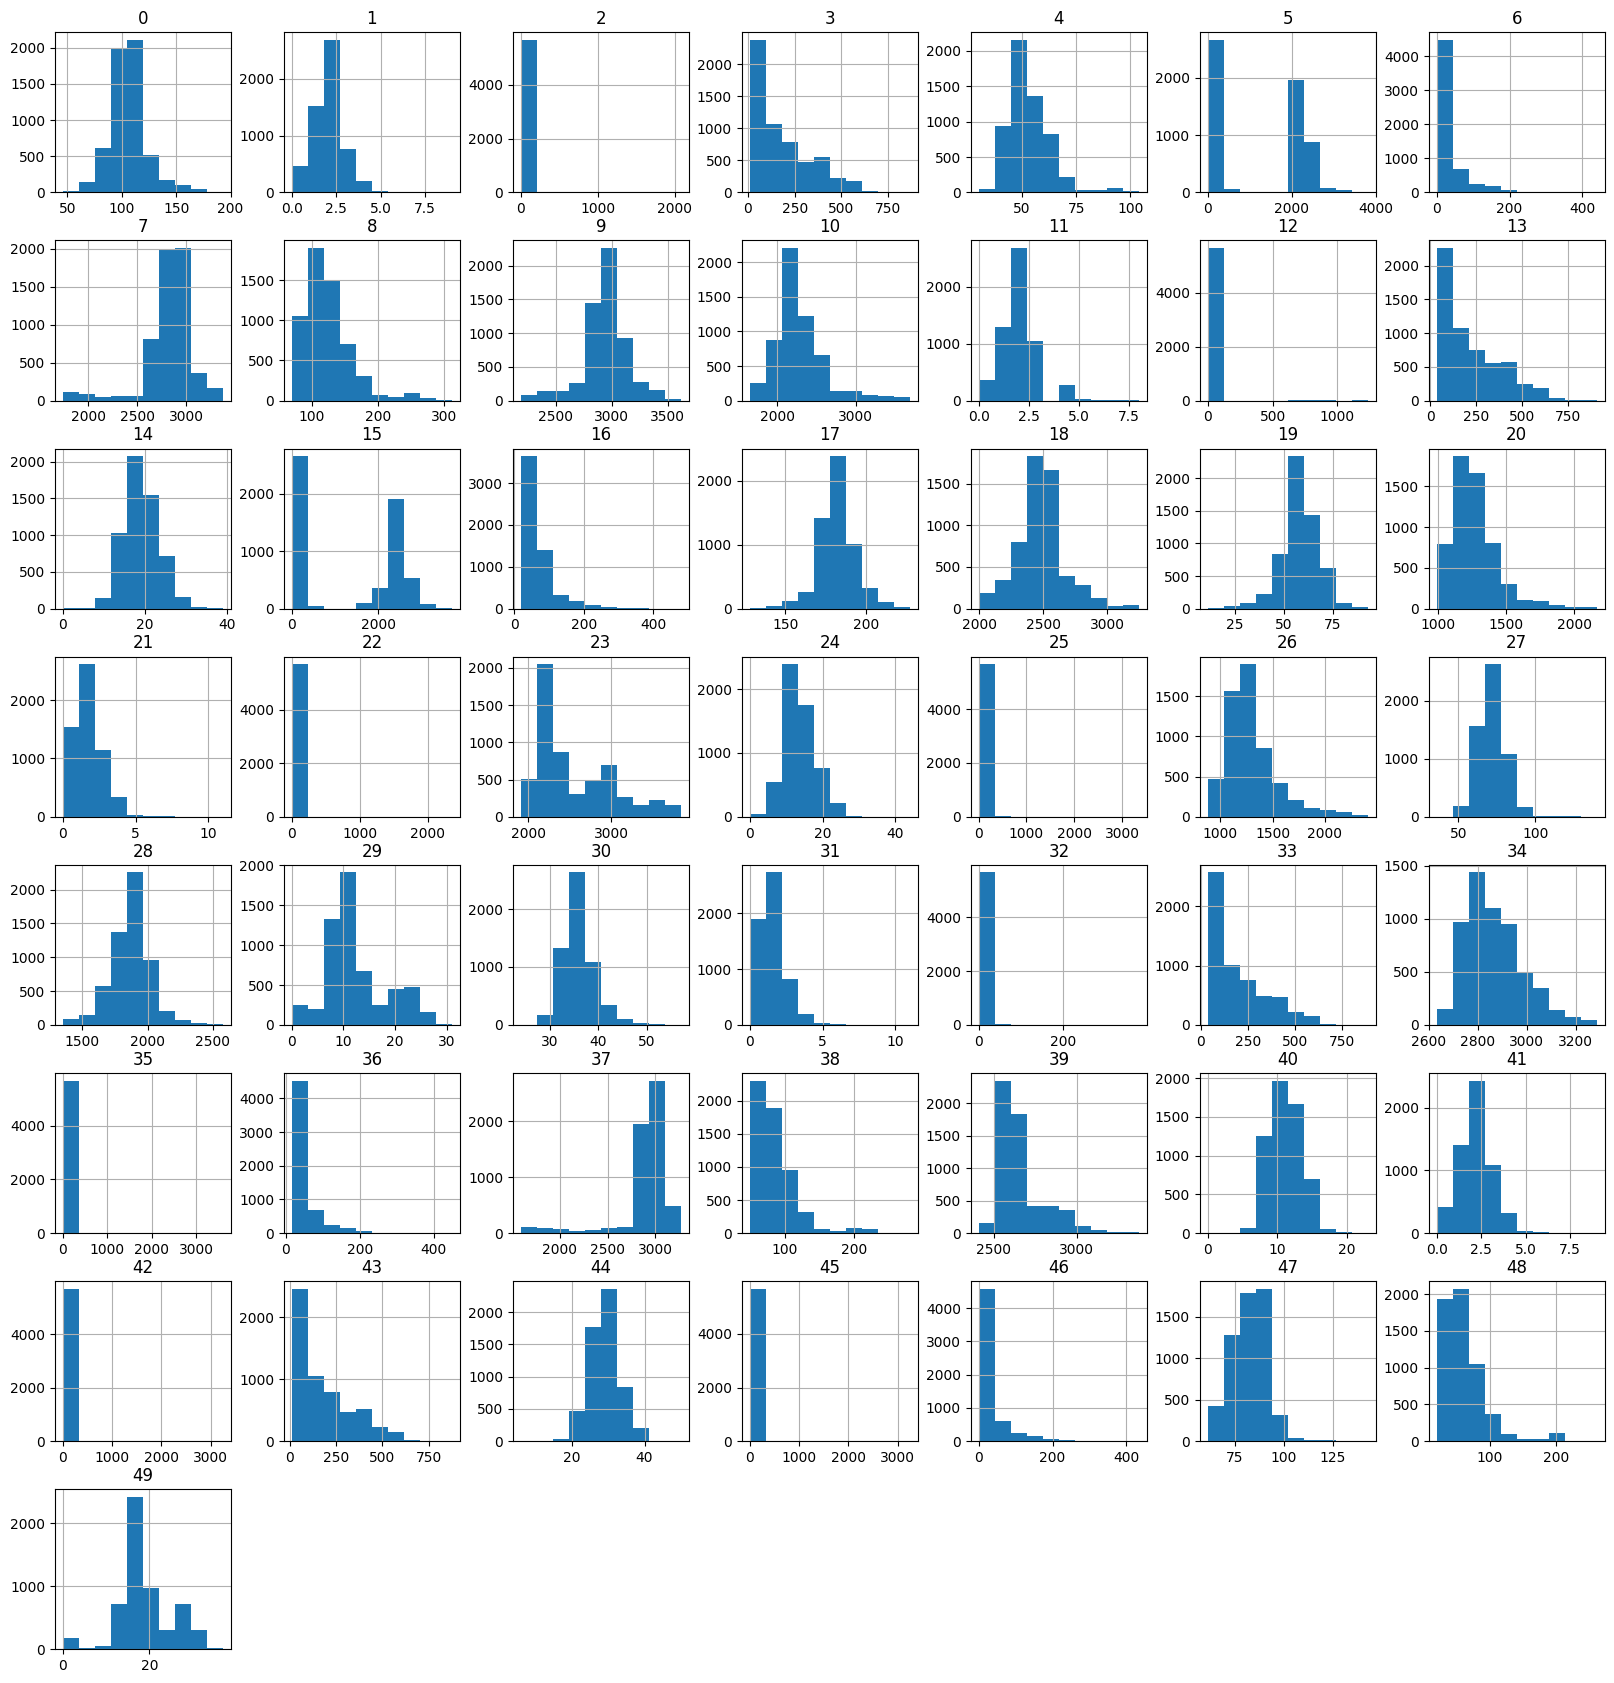

In [269]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [270]:
gestures.iloc[:, :50].describe().round(2)

0        1        2        3        4        5        6        7  \
count  5702.00  5702.00  5702.00  5702.00  5702.00  5702.00  5702.00  5702.00   
mean    106.20     1.81     8.03   175.78    53.05  1203.33    35.03  2829.13   
std      16.74     0.99    73.75   155.84     9.99  1130.64    42.83   245.21   
min      46.00     0.00     0.00    10.00    30.00     0.00     0.00  1740.00   
25%      97.00     1.00     2.00    32.00    46.00     4.00    13.00  2750.00   
50%     105.00     2.00     2.00   125.00    52.00  2038.50    17.00  2868.00   
75%     114.00     2.00     3.00   270.00    58.00  2226.00    38.00  2954.00   
max     193.00     9.00  2082.00   866.00   104.00  3812.00   440.00  3376.00   

             8        9  ...       40       41       42       43       44  \
count  5702.00  5702.00  ...  5702.00  5702.00  5702.00  5702.00  5702.00   
mean    124.92  2938.45  ...    11.13     1.95     3.66   173.03    28.79   
std      33.12   197.38  ...     2.22     1.04    55.20   154.26     4.23   
min      70.00  2185.00  ...     0.00     0.00     0.00    11.00     6.00   
25%      99.00  2866.25  ...    10.00     1.00     2.00    32.00    26.00   
50%     118.00  2942.00  ...    11.00     2.00     2.00   122.00    28.50   
75%     140.00  3042.00  ...    12.00     3.00     3.00   266.00    32.00   
max     312.00  3619.00  ...    23.00     9.00  3250.00   875.00    50.00   

            45       46       47       48       49  
count  5702.00  5702.00  5702.00  5702.00  5702.00  
mean     18.62    34.51    82.31    58.85    18.83  
std      94.53    41.28     8.67    33.29     6.24  
min       0.00     0.00    61.00    19.00     0.00  
25%       3.00    14.00    75.00    34.00    16.00  
50%      12.00    18.00    84.00    49.00    18.00  
75%      17.00    35.00    88.00    72.00    22.00  
max    3252.00   434.00   143.00   262.00    37.00  

[8 rows x 50 columns]

In [271]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [272]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

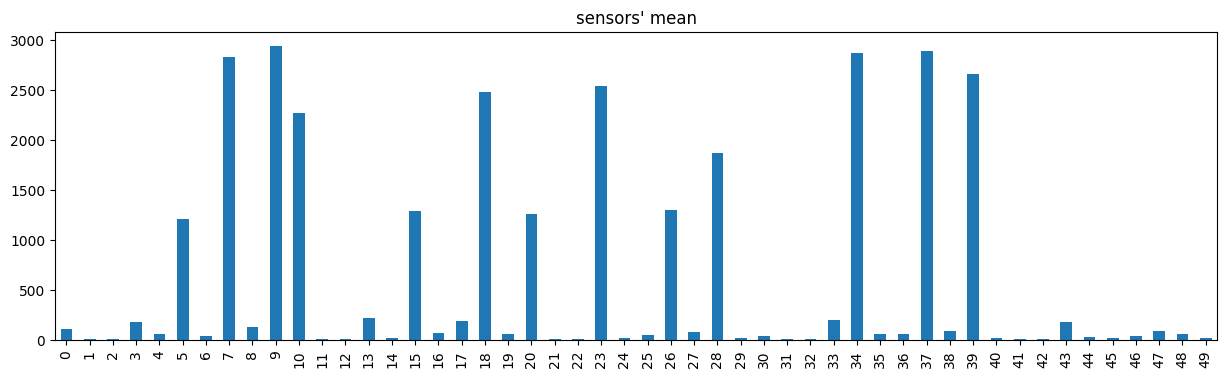

In [273]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [274]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [275]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [276]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [277]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [278]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [279]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.605; 0.579\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [280]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [281]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [282]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '32', '33', '34', '35', '36', '37', '38', '39', '42', '43', '45', '46', '47', '48', '49', 'ACC1', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [283]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [284]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((2760, 46), (2760,)) 
 test: ((2942, 46), (2942,))


### **Model Learning**

#### Random Forest

In [285]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [286]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.933
accuracy: 0.933


In [287]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      1701
        Open      1.000     1.000     1.000       211
      Pistol      1.000     1.000     1.000       212
       Thumb      1.000     1.000     1.000       212
          OK      1.000     1.000     1.000       212
        Grab      1.000     1.000     1.000       212

    accuracy                          1.000      2760
   macro avg      1.000     1.000     1.000      2760
weighted avg      1.000     1.000     1.000      2760

              precision    recall  f1-score   support

     Neutral      0.935     0.985     0.959      1717
        Open      0.971     0.816     0.887       245
      Pistol      0.938     0.927     0.933       246
       Thumb      0.966     0.808     0.880       245
          OK      0.934     0.877     0.905       244
        Grab      0.852     0.869     0.861       245

    accuracy                          0.933      2942
   macro avg      0.933

In [288]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.934771    0.970874    0.938272    0.965854    0.934498   
recall        0.984857    0.816327    0.926829    0.808163    0.877049   
f1-score      0.959161    0.886918    0.932515    0.880000    0.904863   
support    1717.000000  245.000000  246.000000  245.000000  244.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.852000  0.932699     0.932711      0.933743  
recall       0.869388  0.932699     0.880436      0.932699  
f1-score     0.860606  0.932699     0.904010      0.931614  
support    245.000000  0.932699  2942.000000   2942.000000

In [289]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 14*

In [290]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

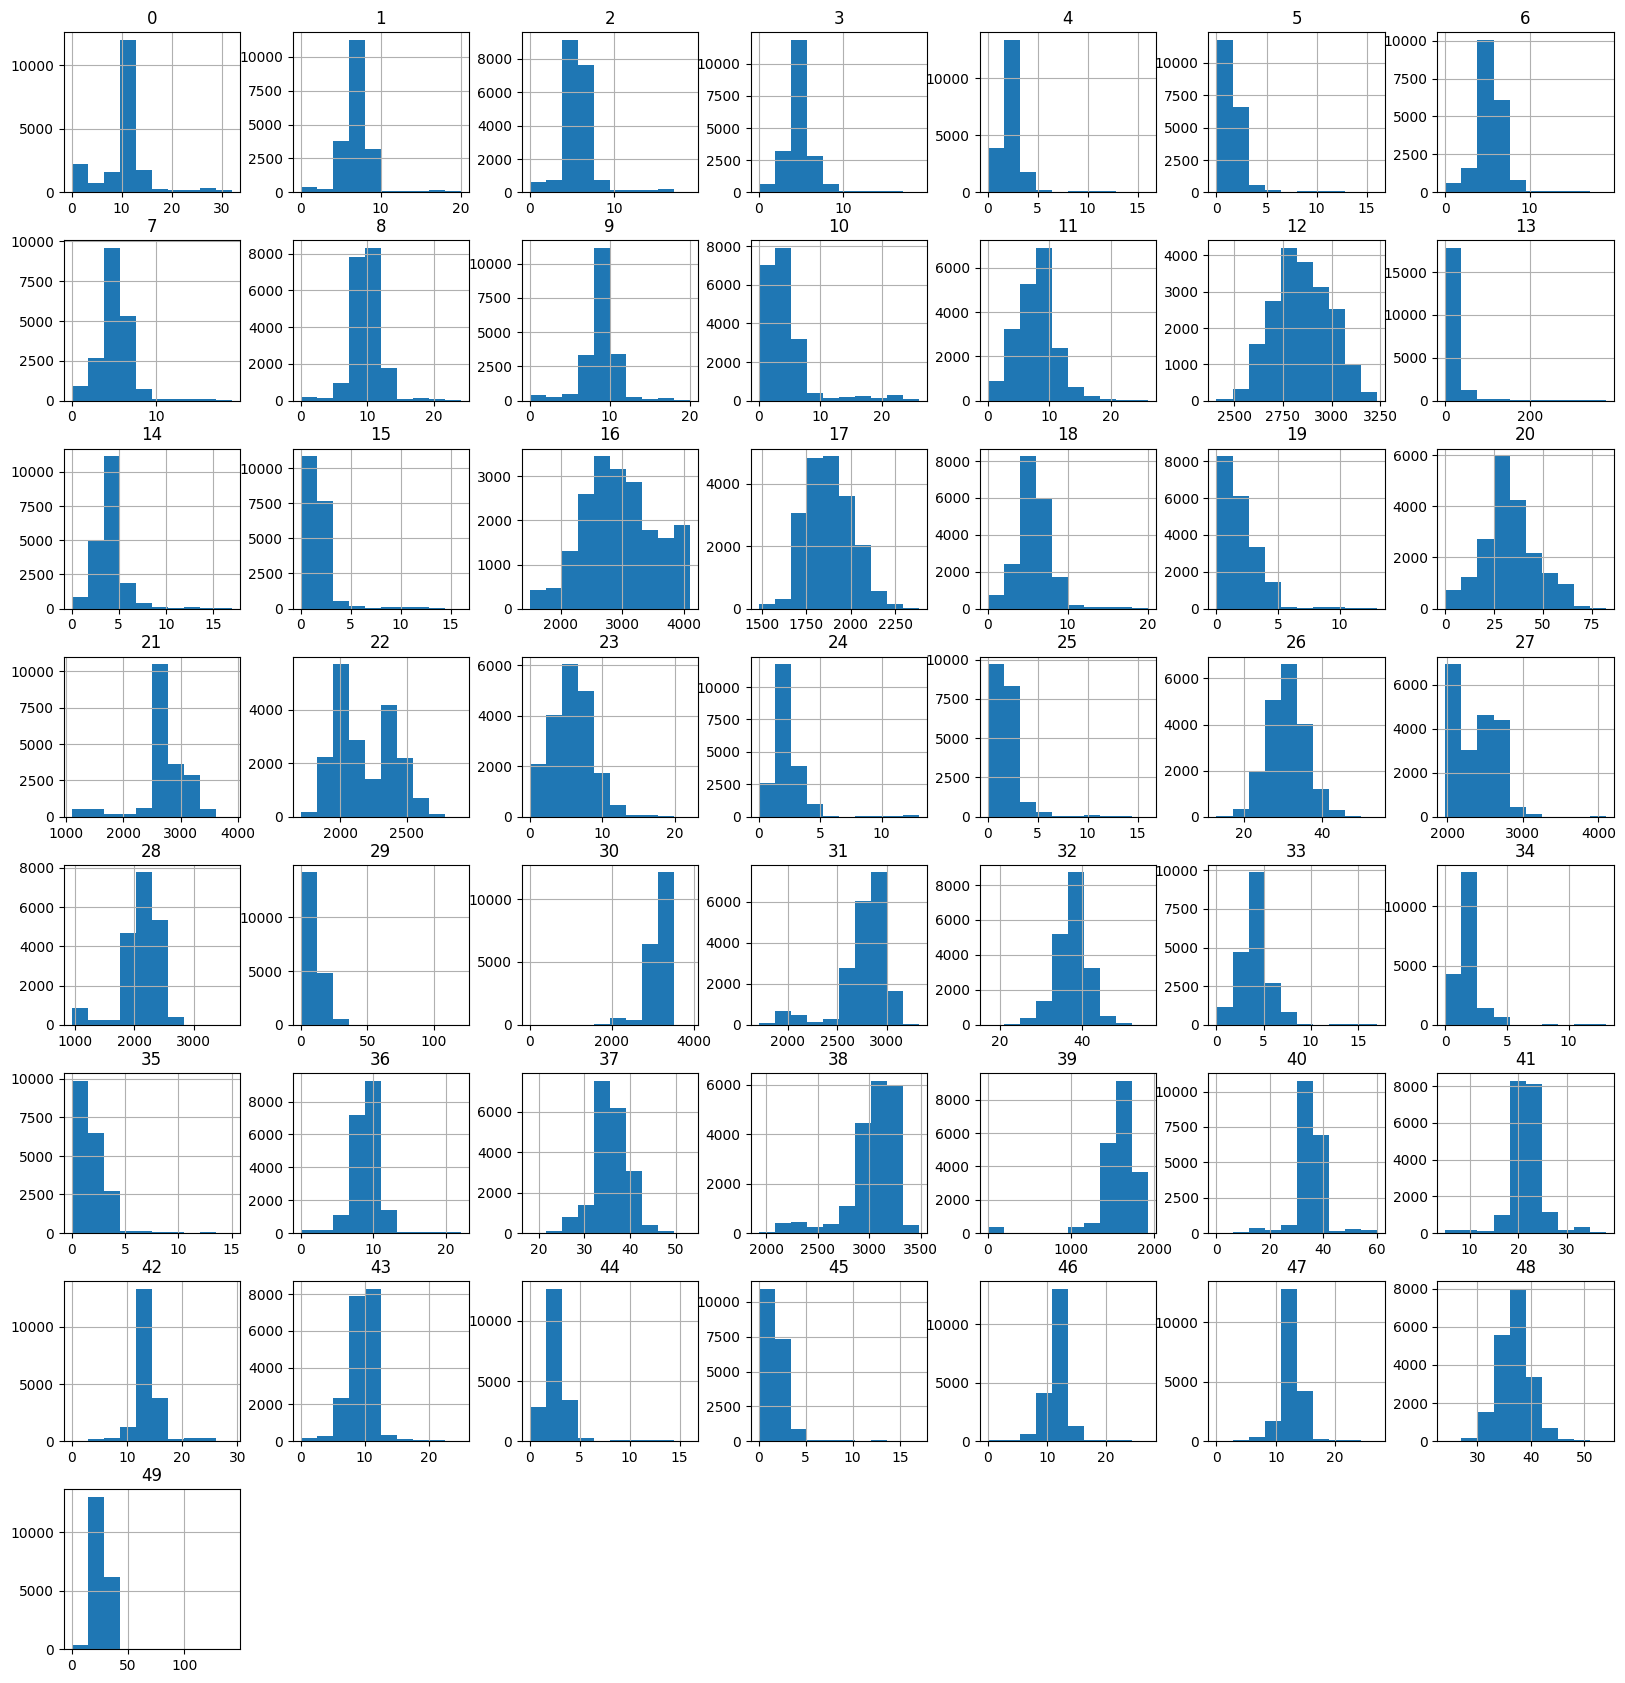

In [291]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [292]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3        4         5         6  \
count  19568.00  19568.00  19568.00  19568.00  19568.0  19568.00  19568.00   
mean      10.49      6.42      5.47      4.55      2.2      1.40      5.11   
std        5.11      2.15      2.20      1.98      1.5      1.71      1.99   
min        0.00      0.00      0.00      0.00      0.0      0.00      0.00   
25%       10.00      6.00      5.00      4.00      2.0      0.00      4.00   
50%       11.00      6.00      5.00      4.00      2.0      1.00      5.00   
75%       12.00      7.00      6.00      5.00      2.0      2.00      6.00   
max       32.00     20.00     19.00     19.00     16.0     16.00     19.00   

              7         8         9  ...        40        41        42  \
count  19568.00  19568.00  19568.00  ...  19568.00  19568.00  19568.00   
mean       4.84      9.61      8.24  ...     34.50     21.54     13.61   
std        2.05      2.13      2.14  ...      5.13      3.22      2.58   
min        0.00      0.00      0.00  ...      0.00      5.00      0.00   
25%        4.00      9.00      8.00  ...     33.00     20.00     13.00   
50%        5.00     10.00      8.00  ...     35.00     22.00     14.00   
75%        6.00     10.00      9.00  ...     36.00     23.00     14.00   
max       19.00     24.00     20.00  ...     60.00     38.00     29.00   

             43        44        45        46        47        48        49  
count  19568.00  19568.00  19568.00  19568.00  19568.00  19568.00  19568.00  
mean       9.20      2.75      1.50     11.51     12.48     36.45     27.00  
std        2.23      1.67      1.69      2.05      2.08      3.04      4.48  
min        0.00      0.00      0.00      0.00      0.00     24.00      0.00  
25%        8.00      2.00      0.00     10.00     12.00     34.00     26.00  
50%        9.00      3.00      1.00     12.00     12.00     36.00     28.00  
75%       10.00      3.00      2.00     12.00     13.00     38.00     29.00  
max       25.00     16.00     17.00     27.00     27.00     54.00    142.00  

[8 rows x 50 columns]

In [293]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [294]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

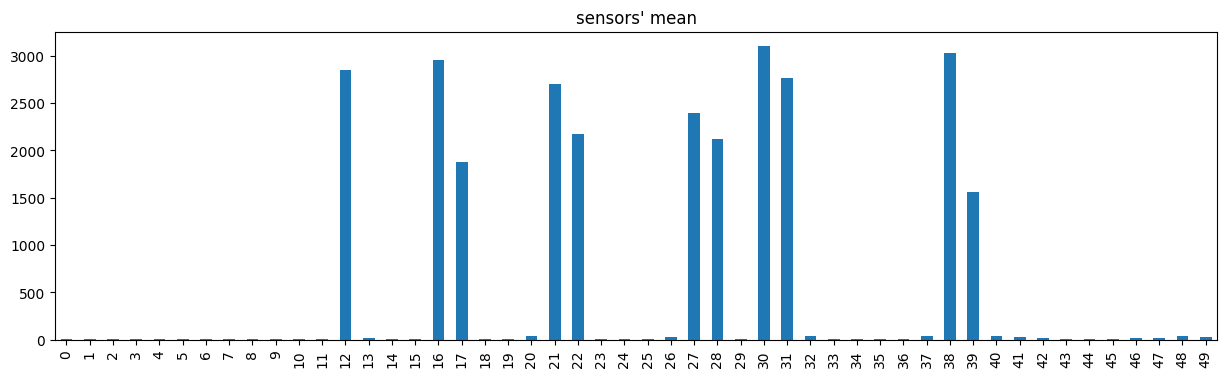

In [295]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [296]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [297]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [298]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [299]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [300]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [301]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.627; 0.678\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [302]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [303]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [304]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '12', '13', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', '40', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [305]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [306]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((15679, 22), (15679,)) 
 test: ((3889, 22), (3889,))


### **Model Learning**

#### Random Forest

In [307]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [308]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.917
accuracy: 0.917


In [309]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10161
        Open      1.000     1.000     1.000      1104
      Pistol      1.000     1.000     1.000      1088
       Thumb      1.000     1.000     1.000      1104
          OK      1.000     1.000     1.000      1104
        Grab      1.000     1.000     1.000      1118

    accuracy                          1.000     15679
   macro avg      1.000     1.000     1.000     15679
weighted avg      1.000     1.000     1.000     15679

              precision    recall  f1-score   support

     Neutral      0.922     0.956     0.938      2498
        Open      0.972     0.891     0.930       276
      Pistol      0.894     0.857     0.875       286
       Thumb      0.964     0.779     0.862       276
          OK      0.878     0.917     0.897       276
        Grab      0.836     0.791     0.813       277

    accuracy                          0.917      3889
   macro avg      0.911

In [310]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.921978    0.972332    0.894161    0.964126    0.878472   
recall        0.955564    0.891304    0.856643    0.778986    0.916667   
f1-score      0.938471    0.930057    0.875000    0.861723    0.897163   
support    2498.000000  276.000000  286.000000  276.000000  276.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.835878  0.916688     0.911158      0.917277  
recall       0.790614  0.916688     0.864963      0.916688  
f1-score     0.812616  0.916688     0.885838      0.915863  
support    277.000000  0.916688  3889.000000   3889.000000

In [311]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 15*

In [312]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

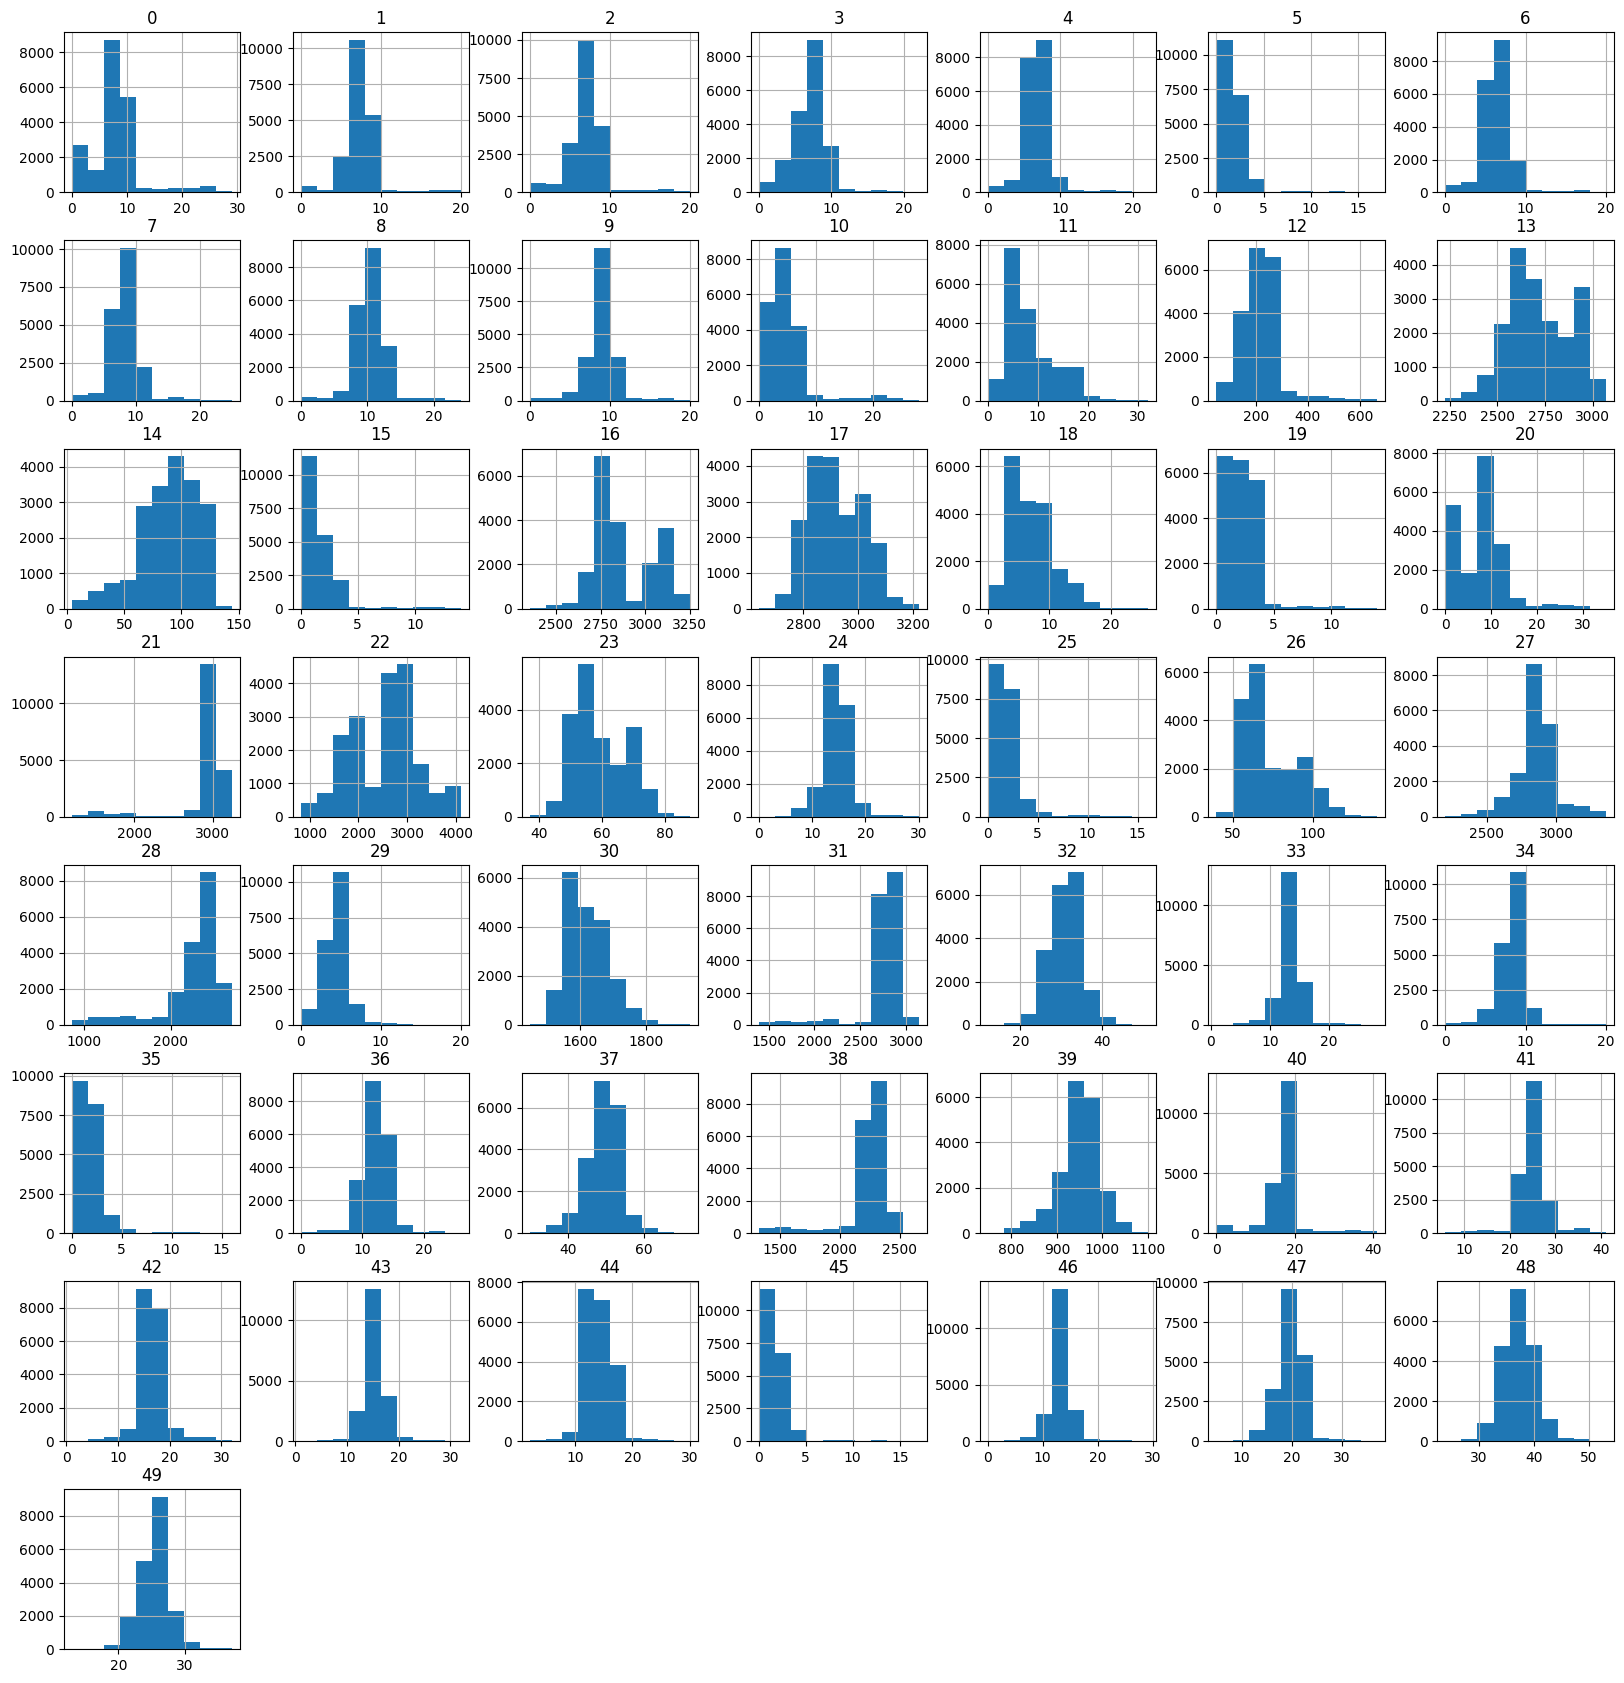

In [313]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [314]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  19566.00  19566.00  19566.00  19566.00  19566.00  19566.00  19566.00   
mean       7.74      6.75      6.52      7.00      6.77      1.49      5.83   
std        4.75      2.12      2.40      2.37      2.00      1.78      2.03   
min        0.00      0.00      0.00      0.00      0.00      0.00      0.00   
25%        7.00      6.00      6.00      6.00      6.00      0.00      5.00   
50%        8.00      7.00      6.00      7.00      7.00      1.00      6.00   
75%        9.00      8.00      8.00      8.00      8.00      2.00      6.00   
max       29.00     20.00     20.00     22.00     22.00     17.00     20.00   

              7         8         9  ...        40        41        42  \
count  19566.00  19566.00  19566.00  ...  19566.00  19566.00  19566.00   
mean       7.85     10.08      8.31  ...     17.26     24.71     16.60   
std        2.20      2.26      1.92  ...      4.96      3.27      2.58   
min        0.00      0.00      0.00  ...      0.00      6.00      1.00   
25%        7.00      9.00      8.00  ...     16.00     23.00     16.00   
50%        8.00     10.00      8.00  ...     17.00     25.00     16.00   
75%        9.00     11.00      9.00  ...     18.00     26.00     18.00   
max       25.00     24.00     20.00  ...     41.00     41.00     32.00   

             43        44        45        46        47        48        49  
count  19566.00  19566.00  19566.00  19566.00  19566.00  19566.00  19566.00  
mean      15.42     13.92      1.39     13.05     19.34     37.14     25.24  
std        2.14      2.17      1.68      2.25      2.67      3.07      2.33  
min        1.00      2.00      0.00      0.00      5.00     24.00     13.00  
25%       14.00     13.00      0.00     12.00     18.00     35.00     24.00  
50%       16.00     14.00      1.00     13.00     20.00     37.00     25.00  
75%       16.00     15.00      2.00     14.00     21.00     39.00     27.00  
max       32.00     30.00     17.00     29.00     37.00     53.00     37.00  

[8 rows x 50 columns]

In [315]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [316]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

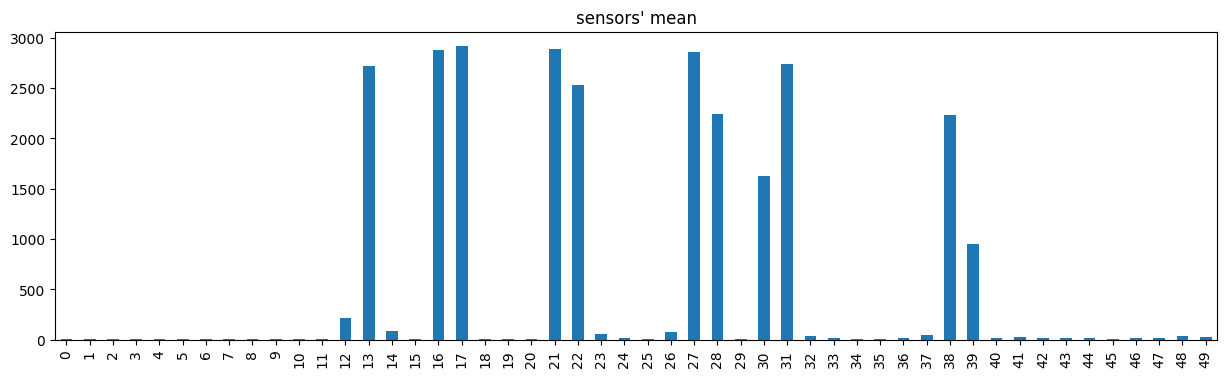

In [317]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [318]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [319]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [320]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [321]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [322]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [323]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 3\n',
 'Accuracy/correlation на концевых выборках: 0.619; 0.677\n',
 'Размер оптимального сдвига (как среднего): 12']

#### Noise / Inactive Sensors

In [324]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [325]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [326]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['12', '13', '14', '16', '17', '20', '21', '22', '26', '27', '28', '30', '31', '38', '39', '40', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [327]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [328]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((15676, 22), (15676,)) 
 test: ((3890, 22), (3890,))


### **Model Learning**

#### Random Forest

In [329]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [330]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.932
accuracy: 0.932


In [331]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10157
        Open      1.000     1.000     1.000      1104
      Pistol      1.000     1.000     1.000      1099
       Thumb      1.000     1.000     1.000      1093
          OK      1.000     1.000     1.000      1115
        Grab      1.000     1.000     1.000      1108

    accuracy                          1.000     15676
   macro avg      1.000     1.000     1.000     15676
weighted avg      1.000     1.000     1.000     15676

              precision    recall  f1-score   support

     Neutral      0.930     0.971     0.950      2499
        Open      0.992     0.884     0.935       276
      Pistol      0.905     0.824     0.862       289
       Thumb      0.949     0.824     0.882       273
          OK      0.955     0.841     0.894       276
        Grab      0.900     0.946     0.923       277

    accuracy                          0.932      3890
   macro avg      0.938

In [332]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.929502    0.991870    0.904943    0.949367    0.954733   
recall        0.970788    0.884058    0.823529    0.824176    0.840580   
f1-score      0.949697    0.934866    0.862319    0.882353    0.894027   
support    2499.000000  276.000000  289.000000  273.000000  276.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.900344  0.932391     0.938460      0.933210  
recall       0.945848  0.932391     0.881497      0.932391  
f1-score     0.922535  0.932391     0.907633      0.931543  
support    277.000000  0.932391  3890.000000   3890.000000

In [333]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 16*

In [334]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

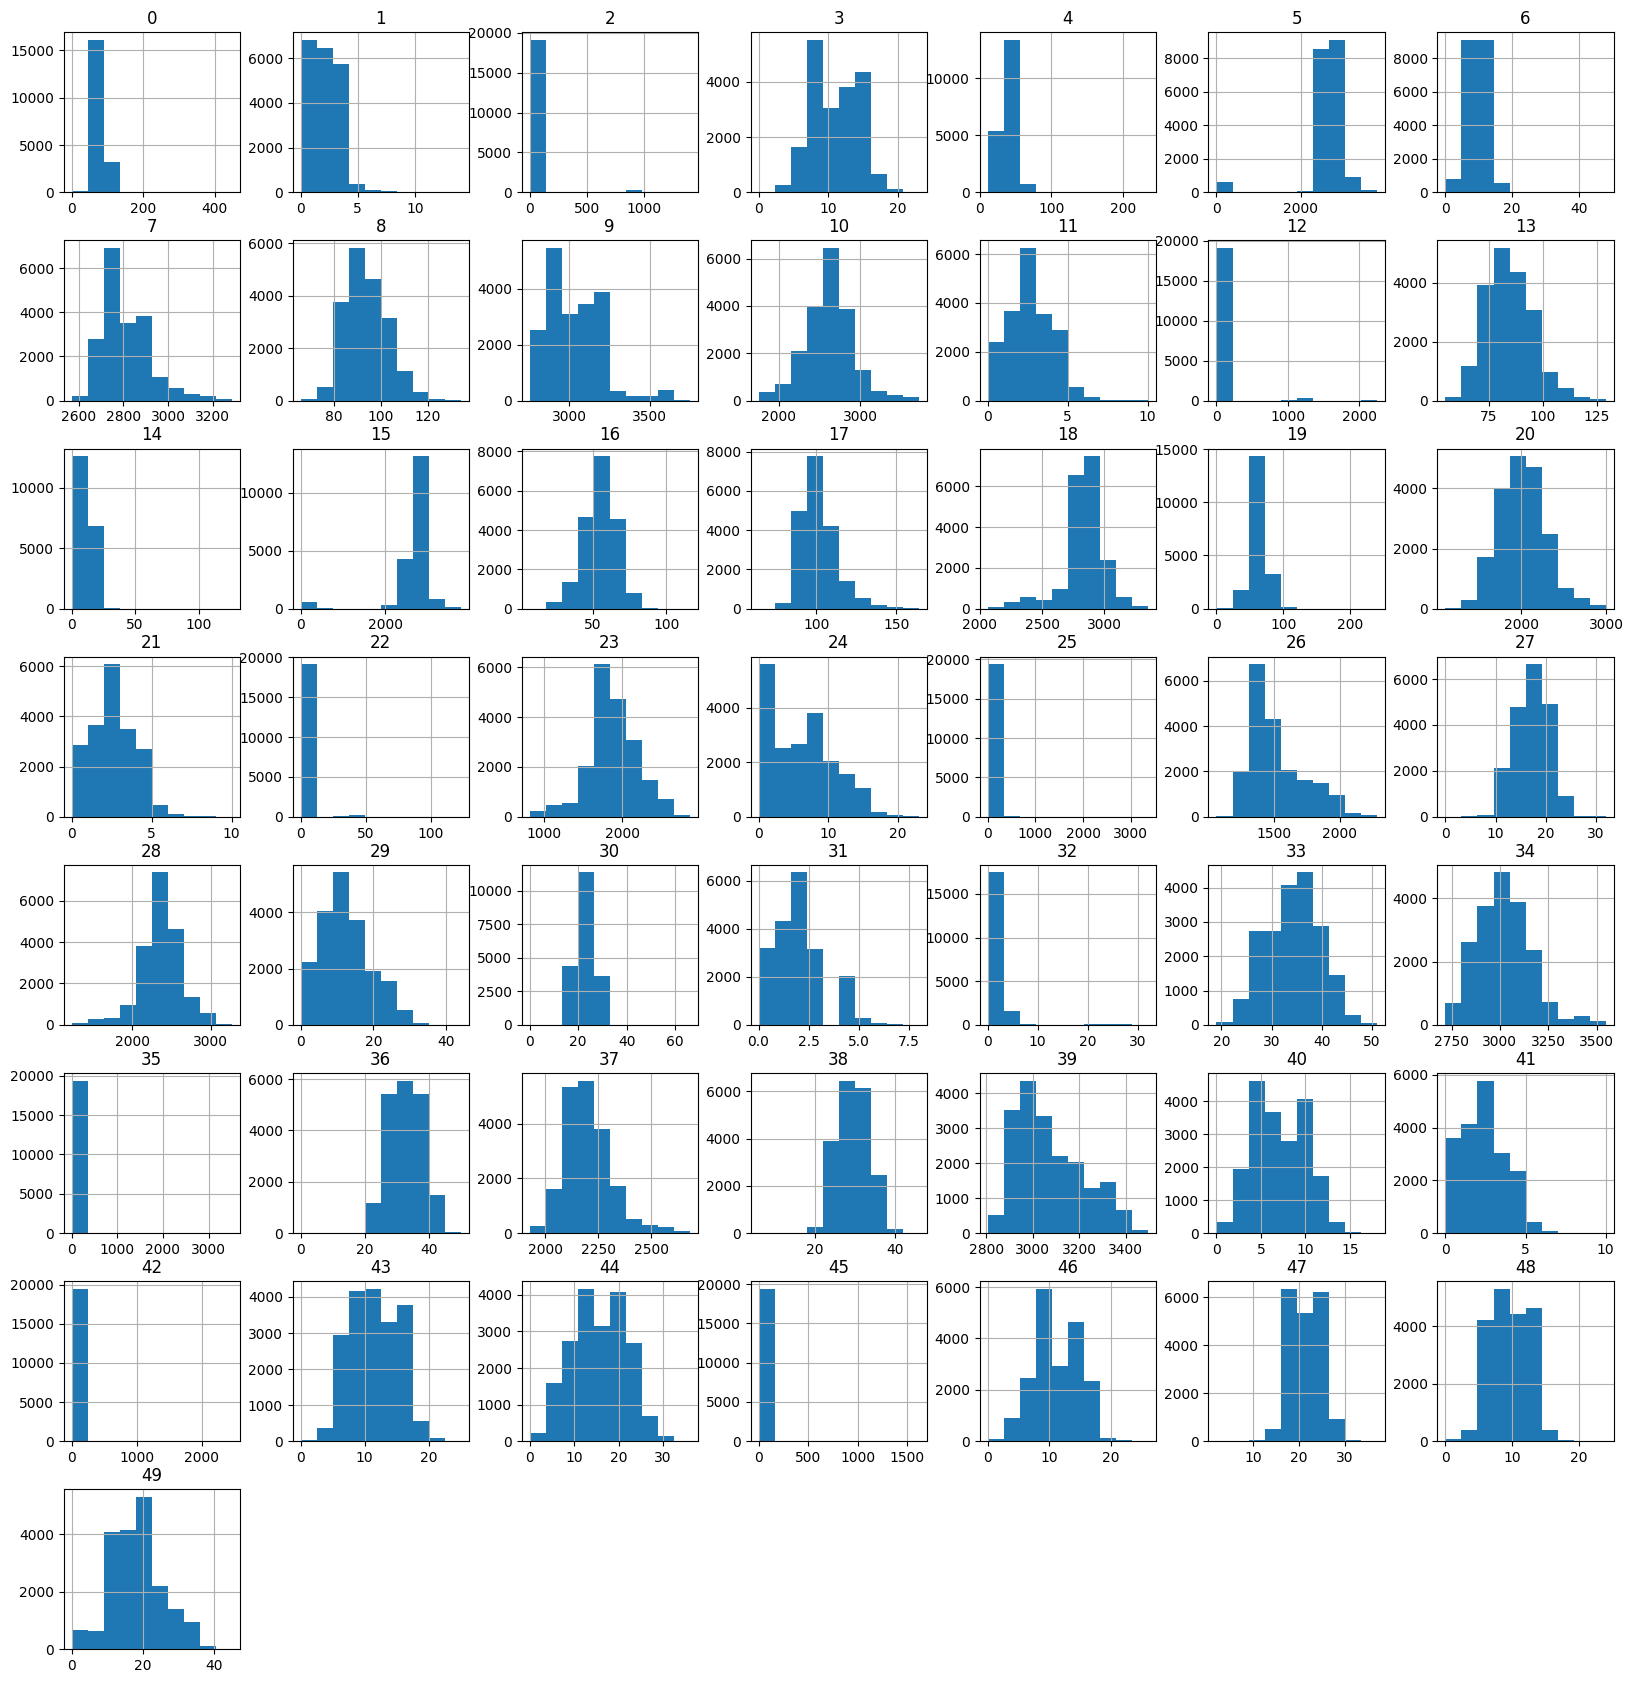

In [335]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [336]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  19472.00  19472.00  19472.00  19472.00  19472.00  19472.00  19472.00   
mean      76.95      2.01     20.14     10.98     39.36   2613.85      9.42   
std       15.09      1.33    130.04      3.44      9.09    511.07      3.01   
min        0.00      0.00      0.00      0.00     11.00      0.00      0.00   
25%       68.00      1.00      2.00      8.00     33.00   2598.00      7.00   
50%       76.00      2.00      2.00     11.00     39.00   2664.00      9.00   
75%       84.00      3.00      3.00     14.00     45.00   2749.00     12.00   
max      448.00     14.00   1404.00     23.00    234.00   3798.00     48.00   

              7         8         9  ...        40        41        42  \
count  19472.00  19472.00  19472.00  ...  19472.00  19472.00  19472.00   
mean    2807.32     93.69   3028.84  ...      6.91      1.90      2.45   
std      107.96      8.77    167.84  ...      2.90      1.38     25.73   
min     2567.00     66.00   2753.00  ...      0.00      0.00      0.00   
25%     2730.00     87.00   2887.00  ...      5.00      1.00      1.00   
50%     2780.00     93.00   2995.00  ...      7.00      2.00      2.00   
75%     2876.00     99.00   3152.00  ...      9.00      3.00      3.00   
max     3286.00    134.00   3748.00  ...     18.00     10.00   2460.00   

             43        44        45        46        47        48        49  
count  19472.00  19472.00  19472.00  19472.00  19472.00  19472.00  19472.00  
mean      11.20     15.51     15.62     10.91     21.07      9.44     17.99  
std        3.77      6.04     35.72      3.62      3.57      2.76      7.31  
min        0.00      0.00      0.00      0.00      2.00      0.00      0.00  
25%        8.00     11.00      9.00      8.00     18.00      8.00     13.00  
50%       11.00     16.00     14.00     11.00     21.00      9.00     18.00  
75%       14.00     20.00     18.00     14.00     24.00     12.00     22.00  
max       25.00     36.00   1613.00     26.00     37.00     24.00     45.00  

[8 rows x 50 columns]

In [337]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [338]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

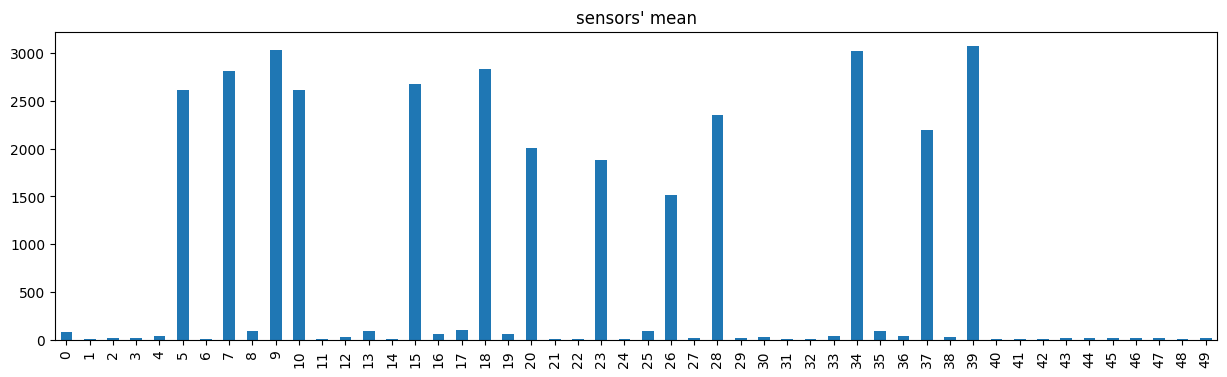

In [339]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [340]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [341]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [342]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [343]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [344]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [345]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.616; 0.679\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [346]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [347]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [348]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '2', '4', '5', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '23', '24', '25', '26', '28', '29', '33', '34', '35', '36', '37', '39', '42', '44', '45', '49', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [349]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [350]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((15602, 40), (15602,)) 
 test: ((3870, 40), (3870,))


### **Model Learning**

#### Random Forest

In [351]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [352]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.924
accuracy: 0.924


In [353]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     10119
        Open      1.000     1.000     1.000      1101
      Pistol      1.000     1.000     1.000      1089
       Thumb      1.000     1.000     1.000      1099
          OK      1.000     1.000     1.000      1097
        Grab      1.000     1.000     1.000      1097

    accuracy                          1.000     15602
   macro avg      1.000     1.000     1.000     15602
weighted avg      1.000     1.000     1.000     15602

              precision    recall  f1-score   support

     Neutral      0.929     0.959     0.944      2488
        Open      0.975     0.844     0.904       275
      Pistol      0.922     0.789     0.851       285
       Thumb      0.907     0.894     0.900       273
          OK      0.877     0.964     0.918       274
        Grab      0.896     0.811     0.851       275

    accuracy                          0.924      3870
   macro avg      0.918

In [354]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.928766    0.974790    0.922131    0.907063    0.877076   
recall        0.959003    0.843636    0.789474    0.893773    0.963504   
f1-score      0.943642    0.904483    0.850662    0.900369    0.918261   
support    2488.000000  275.000000  285.000000  273.000000  274.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.895582  0.923514     0.917568      0.923999  
recall       0.810909  0.923514     0.876716      0.923514  
f1-score     0.851145  0.923514     0.894760      0.922590  
support    275.000000  0.923514  3870.000000   3870.000000

In [355]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 17*

In [356]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

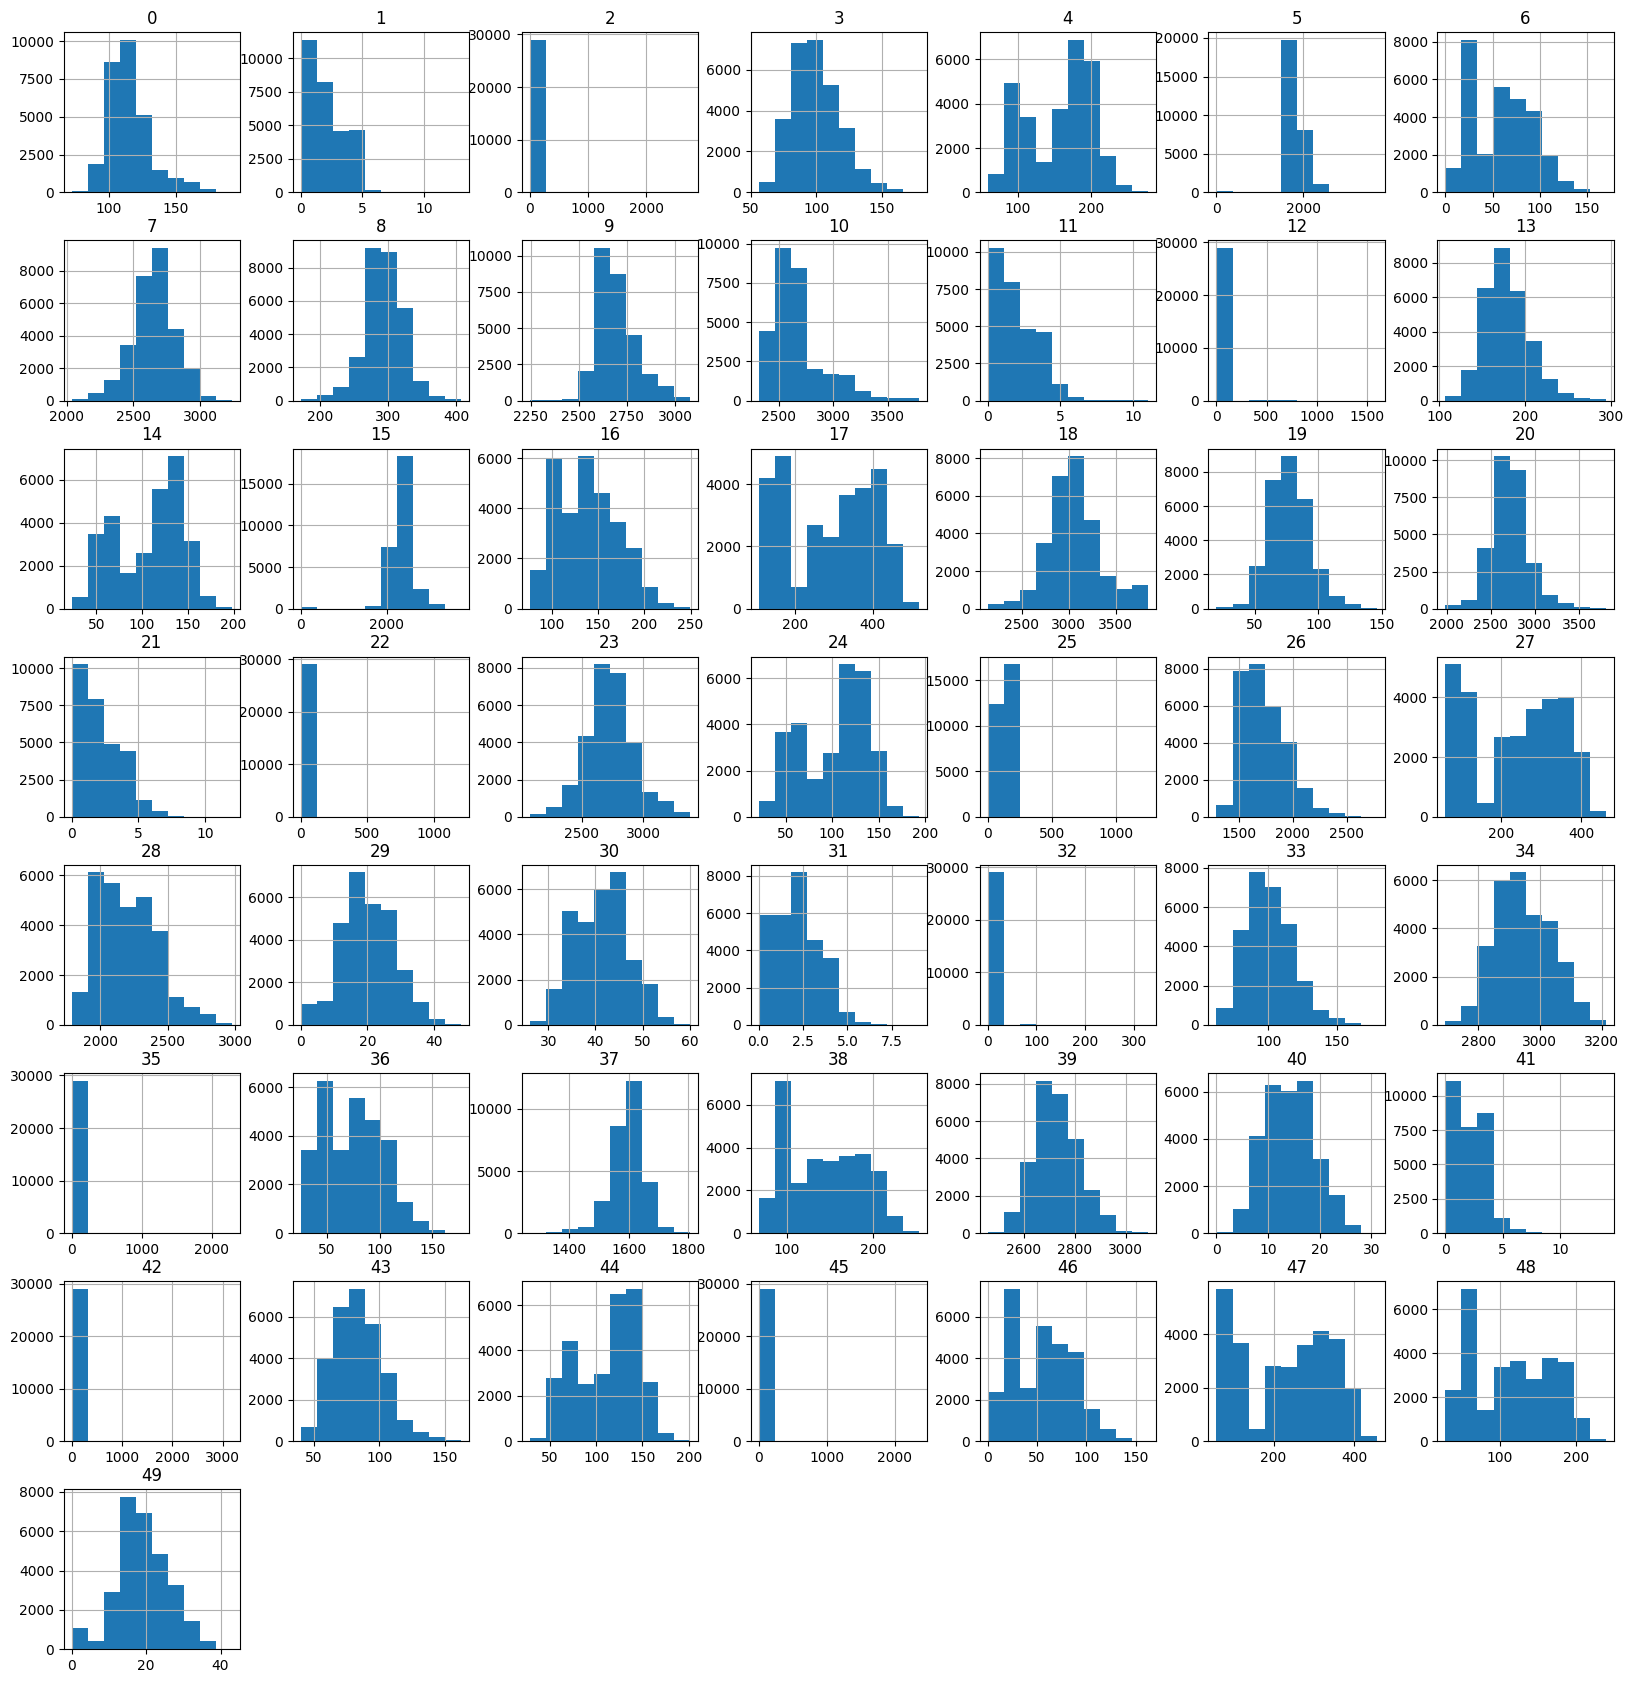

In [357]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [358]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  29083.00  29083.00  29083.00  29083.00  29083.00  29083.00  29083.00   
mean     114.18      1.96      5.84     99.44    155.72   1779.30     59.40   
std       15.94      1.45     54.06     18.08     45.19    223.27     31.49   
min       72.00      0.00      0.00     56.00     58.00      0.00      0.00   
25%      104.00      1.00      1.00     86.00    108.00   1657.00     27.00   
50%      112.00      2.00      2.00     97.00    168.00   1736.00     60.00   
75%      121.00      3.00      3.00    111.00    192.00   1892.00     84.00   
max      192.00     13.00   2748.00    178.00    278.00   3686.00    170.00   

              7         8         9  ...        40        41        42  \
count  29083.00  29083.00  29083.00  ...  29083.00  29083.00  29083.00   
mean    2652.07    292.99   2692.10  ...     14.08      2.03      2.57   
std      161.11     28.75    102.04  ...      4.61      1.52     19.55   
min     2037.00    171.00   2244.00  ...      0.00      0.00      0.00   
25%     2551.00    276.00   2618.00  ...     11.00      1.00      2.00   
50%     2658.00    292.00   2674.00  ...     14.00      2.00      2.00   
75%     2750.00    312.00   2747.00  ...     17.00      3.00      3.00   
max     3236.00    407.00   3076.00  ...     31.00     14.00   3182.00   

             43        44        45        46        47        48        49  
count  29083.00  29083.00  29083.00  29083.00  29083.00  29083.00  29083.00  
mean      83.41    111.15     20.64     54.89    229.74    115.33     19.09  
std       18.39     33.11     21.38     29.89    107.96     51.35      7.26  
min       40.00     28.00      0.00      0.00     58.00     28.00      0.00  
25%       70.00     79.00     16.00     24.00    107.00     60.00     15.00  
50%       82.00    120.00     20.00     55.00    245.00    115.00     19.00  
75%       95.00    137.00     25.00     78.00    326.00    162.00     24.00  
max      162.00    201.00   2353.00    162.00    456.00    239.00     43.00  

[8 rows x 50 columns]

In [359]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [360]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

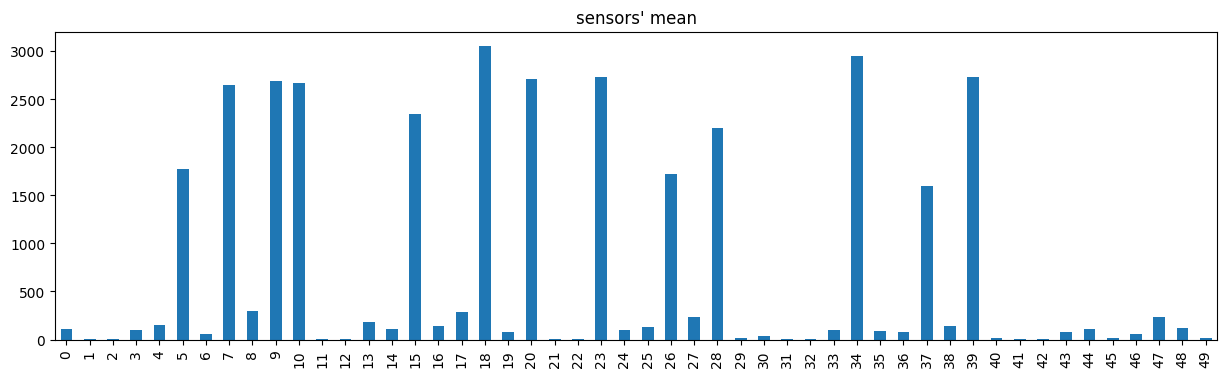

In [361]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [362]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [363]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [364]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [365]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [366]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [367]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.616; 0.68\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [368]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [369]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [370]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '42', '43', '44', '45', '46', '47', '48', '49', 'ACC1', 'GYR0', 'GYR1', 'GYR2', 'SYNC']


### **Train-Test Split**

In [371]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [372]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((23289, 49), (23289,)) 
 test: ((5794, 49), (5794,))


### **Model Learning**

#### Random Forest

In [373]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [374]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.948
accuracy: 0.948


In [375]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     15066
        Open      1.000     1.000     1.000      1649
      Pistol      1.000     1.000     1.000      1638
       Thumb      1.000     1.000     1.000      1646
          OK      1.000     1.000     1.000      1644
        Grab      1.000     1.000     1.000      1646

    accuracy                          1.000     23289
   macro avg      1.000     1.000     1.000     23289
weighted avg      1.000     1.000     1.000     23289

              precision    recall  f1-score   support

     Neutral      0.957     0.962     0.959      3724
        Open      0.979     0.903     0.939       412
      Pistol      0.888     0.939     0.913       424
       Thumb      0.979     0.920     0.949       411
          OK      0.919     0.912     0.916       411
        Grab      0.896     0.937     0.916       412

    accuracy                          0.948      5794
   macro avg      0.936

In [376]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.957231    0.978947    0.888393    0.979275    0.919118   
recall        0.961600    0.902913    0.938679    0.919708    0.912409   
f1-score      0.959411    0.939394    0.912844    0.948557    0.915751   
support    3724.000000  412.000000  424.000000  411.000000  411.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.895592  0.947532     0.936426      0.948215  
recall       0.936893  0.947532     0.928700      0.947532  
f1-score     0.915777  0.947532     0.931956      0.947610  
support    412.000000  0.947532  5794.000000   5794.000000

In [377]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 18*

In [378]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

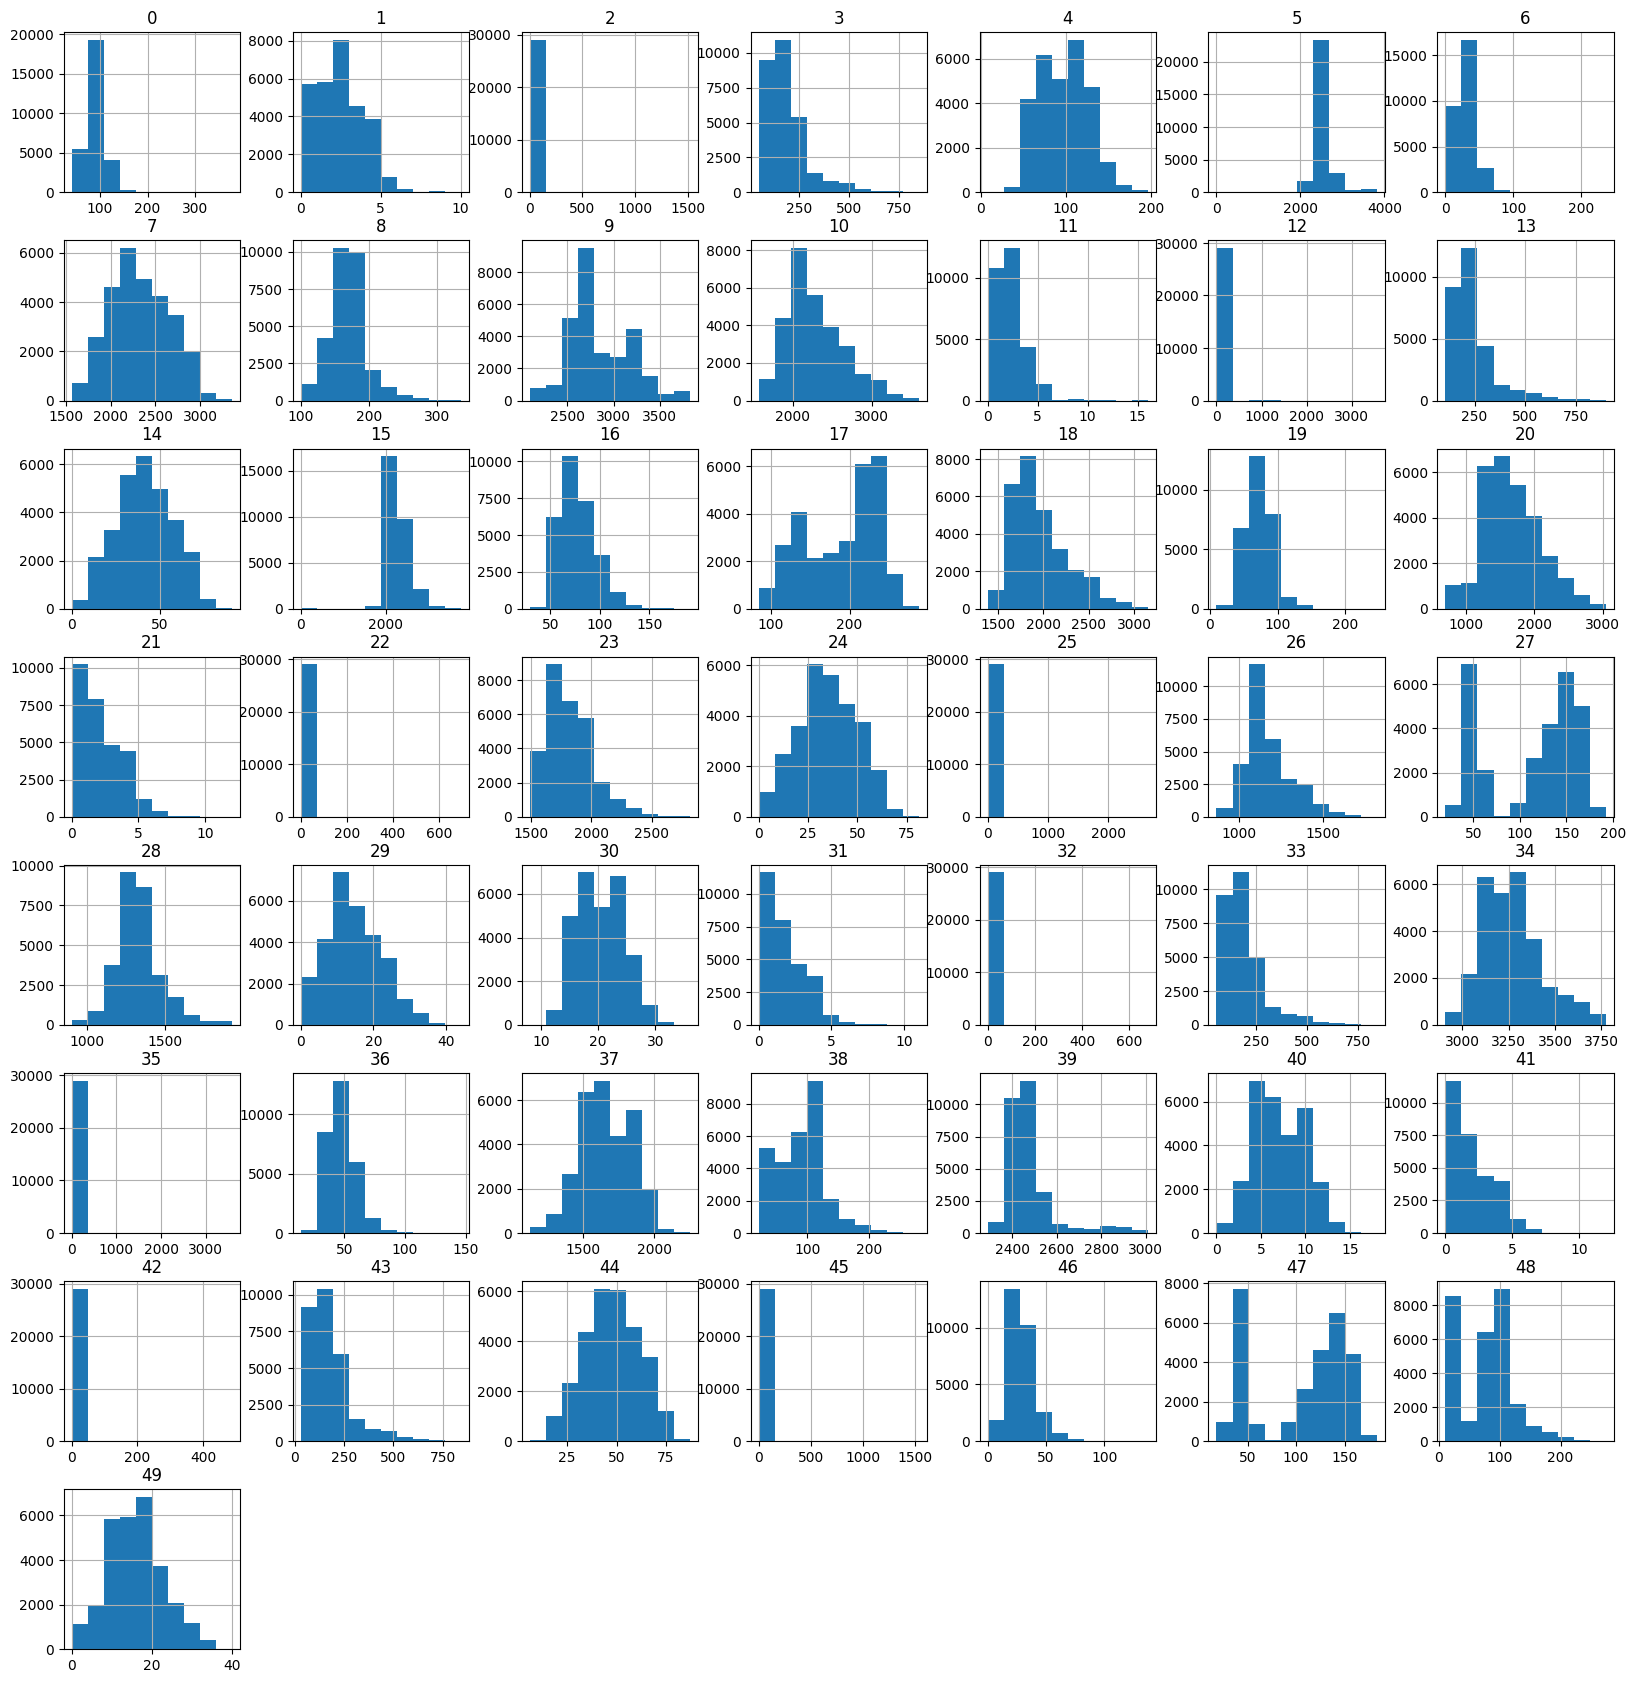

In [379]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [380]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  29090.00  29090.00  29090.00  29090.00  29090.00  29090.00  29090.00   
mean      89.45      1.96      3.90    180.63     97.08   2493.46     30.73   
std       18.51      1.47     43.07    109.88     28.66    275.25     13.21   
min       41.00      0.00      0.00     44.00      8.00      0.00      0.00   
25%       77.00      1.00      1.00     87.00     74.00   2377.00     21.00   
50%       87.00      2.00      2.00    170.00     98.00   2438.00     29.00   
75%       99.00      3.00      3.00    218.00    118.00   2550.00     38.00   
max      376.00     10.00   1519.00    850.00    196.00   3814.00    236.00   

              7         8         9  ...        40        41        42  \
count  29090.00  29090.00  29090.00  ...  29090.00  29090.00  29090.00   
mean    2323.61    169.07   2842.25  ...      6.92      1.97      2.34   
std      325.70     27.32    328.52  ...      2.80      1.53      4.22   
min     1565.00    100.00   2092.00  ...      0.00      0.00      0.00   
25%     2084.00    152.00   2618.00  ...      5.00      1.00      1.00   
50%     2294.00    169.00   2737.00  ...      7.00      2.00      2.00   
75%     2578.00    181.00   3122.00  ...      9.00      3.00      3.00   
max     3350.00    334.00   3824.00  ...     18.00     12.00    486.00   

             43        44        45        46        47        48        49  
count  29090.00  29090.00  29090.00  29090.00  29090.00  29090.00  29090.00  
mean     171.73     47.64     14.34     28.69    104.40     78.66     15.24  
std      111.75     13.75     22.54     12.01     46.14     42.75      6.92  
min       30.00      6.00      0.00      0.00     18.00     11.00      0.00  
25%       74.00     38.00      9.00     20.00     47.00     30.00     10.00  
50%      163.00     48.00     13.00     27.00    122.00     84.00     15.00  
75%      211.00     58.00     18.00     35.00    144.00    108.00     20.00  
max      841.00     87.00   1532.00    137.00    183.00    274.00     40.00  

[8 rows x 50 columns]

In [381]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [382]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

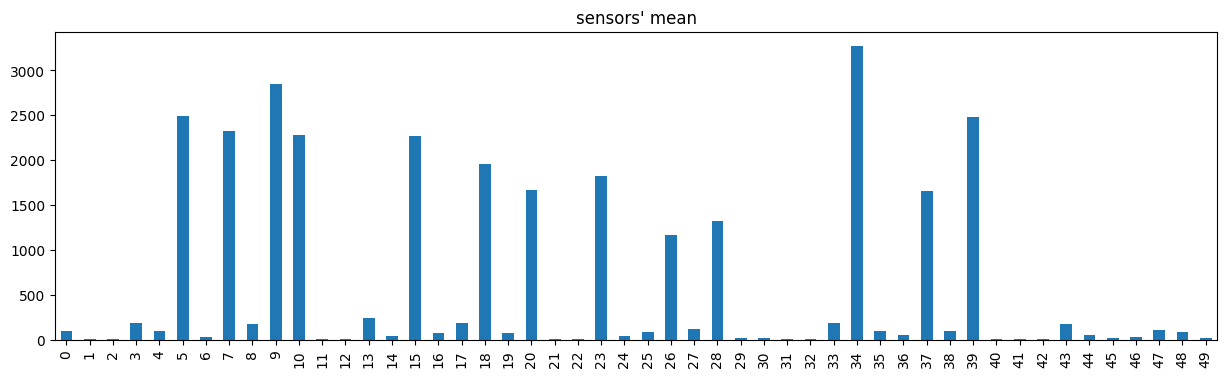

In [383]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [384]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [385]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [386]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [387]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [388]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [389]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.617; 0.68\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [390]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [391]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [392]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '25', '26', '27', '28', '29', '32', '33', '34', '35', '36', '37', '38', '39', '43', '44', '45', '46', '47', '48', '49', 'ACC1', 'GYR0', 'GYR1', 'GYR2', 'SYNC']


### **Train-Test Split**

In [393]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [394]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((23297, 47), (23297,)) 
 test: ((5793, 47), (5793,))


### **Model Learning**

#### Random Forest

In [395]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [396]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.915
accuracy: 0.915


In [397]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     15067
        Open      1.000     1.000     1.000      1645
      Pistol      1.000     1.000     1.000      1638
       Thumb      1.000     1.000     1.000      1651
          OK      1.000     1.000     1.000      1649
        Grab      1.000     1.000     1.000      1647

    accuracy                          1.000     23297
   macro avg      1.000     1.000     1.000     23297
weighted avg      1.000     1.000     1.000     23297

              precision    recall  f1-score   support

     Neutral      0.927     0.959     0.943      3724
        Open      0.985     0.803     0.885       412
      Pistol      0.809     0.903     0.853       421
       Thumb      0.916     0.923     0.919       413
          OK      0.899     0.783     0.837       411
        Grab      0.877     0.760     0.814       412

    accuracy                          0.915      5793
   macro avg      0.902

In [398]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.926608    0.985119    0.808511    0.915865    0.899441   
recall        0.959452    0.803398    0.902613    0.922518    0.783455   
f1-score      0.942744    0.885027    0.852974    0.919180    0.837451   
support    3724.000000  412.000000  421.000000  413.000000  411.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.876751  0.914897     0.902049      0.915948  
recall       0.759709  0.914897     0.855191      0.914897  
f1-score     0.814044  0.914897     0.875237      0.913812  
support    412.000000  0.914897  5793.000000   5793.000000

In [399]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 19*

In [400]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

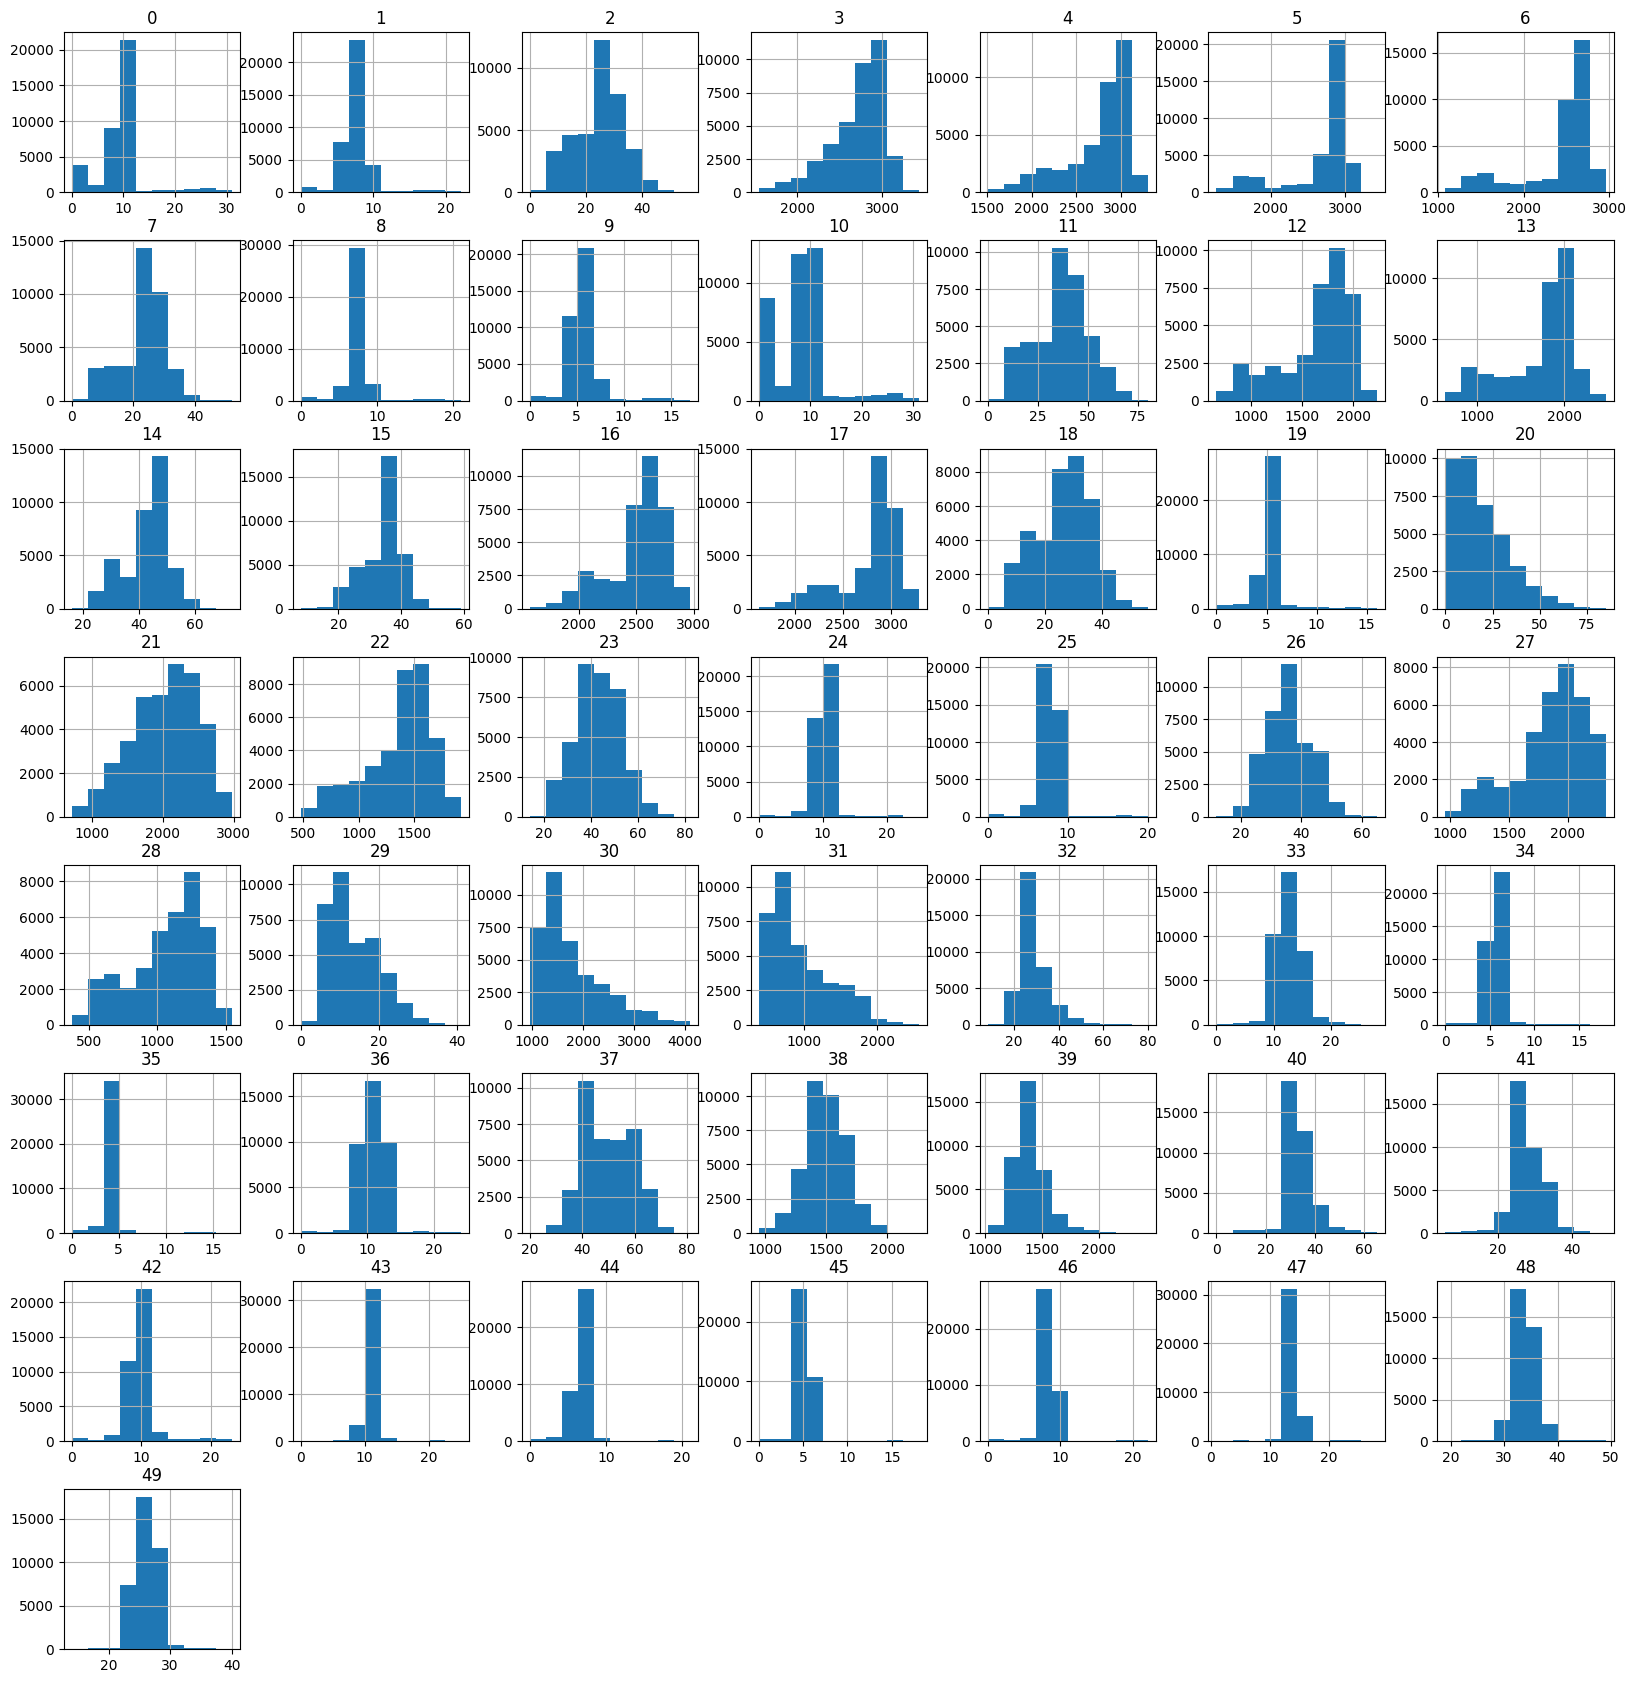

In [401]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [402]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  37608.00  37608.00  37608.00  37608.00  37608.00  37608.00  37608.00   
mean       9.46      7.54     24.79   2707.62   2746.64   2677.53   2422.82   
std        4.65      2.19      8.59    321.99    356.71    445.29    418.86   
min        0.00      0.00      0.00   1539.00   1501.00   1270.00   1088.00   
25%        9.00      7.00     19.00   2530.00   2599.00   2679.00   2434.00   
50%       10.00      8.00     26.00   2792.00   2887.00   2860.00   2584.00   
75%       10.00      8.00     30.00   2946.00   2991.00   2949.00   2667.00   
max       31.00     22.00     57.00   3434.00   3301.00   3423.00   2957.00   

              7         8         9  ...        40        41        42  \
count  37608.00  37608.00  37608.00  ...  37608.00  37608.00  37608.00   
mean      22.90      7.77      5.78  ...     33.04     27.53      9.86   
std        6.88      1.97      1.60  ...      5.95      4.18      2.28   
min        0.00      0.00      0.00  ...      0.00      6.00      0.00   
25%       20.00      7.00      5.00  ...     30.00     25.00      9.00   
50%       24.00      8.00      6.00  ...     32.00     27.00     10.00   
75%       27.00      8.00      6.00  ...     36.00     30.00     10.00   
max       52.00     21.00     17.00  ...     65.00     49.00     23.00   

             43        44        45        46        47        48        49  
count  37608.00  37608.00  37608.00  37608.00  37608.00  37608.00  37608.00  
mean      10.68      7.13      5.24      8.21     13.48     33.41     25.94  
std        1.57      1.54      1.36      1.47      1.69      2.32      1.87  
min        0.00      0.00      0.00      0.00      1.00     19.00     14.00  
25%       10.00      6.00      5.00      8.00     13.00     32.00     25.00  
50%       11.00      7.00      5.00      8.00     13.00     33.00     26.00  
75%       11.00      8.00      6.00      9.00     14.00     35.00     27.00  
max       25.00     21.00     18.00     22.00     28.00     49.00     40.00  

[8 rows x 50 columns]

In [403]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [404]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

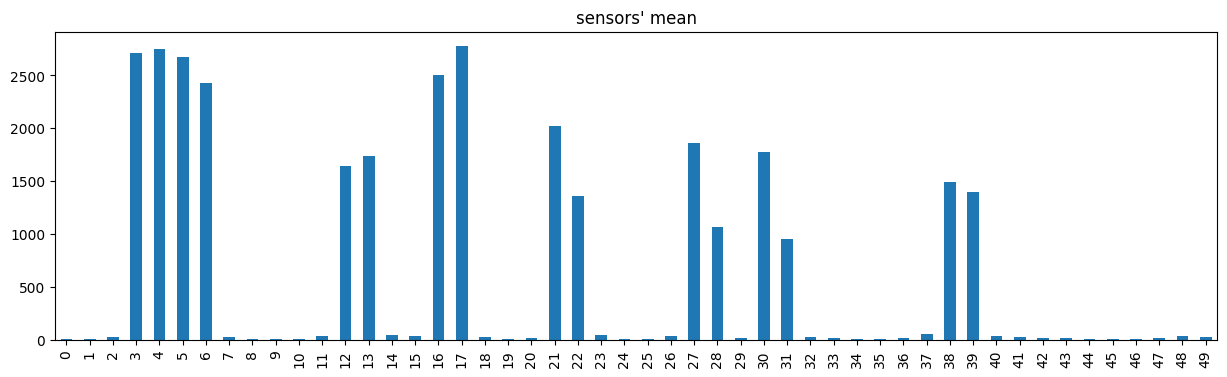

In [405]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [406]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [407]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [408]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [409]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [410]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [411]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.576; 0.62\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [412]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [413]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [414]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['2', '3', '4', '5', '6', '7', '10', '11', '12', '13', '14', '16', '17', '18', '20', '21', '22', '23', '27', '28', '30', '31', '38', '39', '40', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC']


### **Train-Test Split**

In [415]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [416]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((29532, 32), (29532,)) 
 test: ((8076, 32), (8076,))


### **Model Learning**

#### Random Forest

In [417]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [418]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.965
accuracy: 0.965


In [419]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     17417
        Open      1.000     1.000     1.000      2422
      Pistol      1.000     1.000     1.000      2421
       Thumb      1.000     1.000     1.000      2421
          OK      1.000     1.000     1.000      2425
        Grab      1.000     1.000     1.000      2426

    accuracy                          1.000     29532
   macro avg      1.000     1.000     1.000     29532
weighted avg      1.000     1.000     1.000     29532

              precision    recall  f1-score   support

     Neutral      0.980     0.987     0.984      4727
        Open      0.934     0.919     0.926       665
      Pistol      0.970     0.924     0.947       673
       Thumb      0.902     0.937     0.920       671
          OK      0.942     0.916     0.929       670
        Grab      0.969     0.967     0.968       670

    accuracy                          0.965      8076
   macro avg      0.950

In [420]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.979845    0.934251    0.970359    0.902439    0.941718   
recall        0.987307    0.918797    0.924220    0.937407    0.916418   
f1-score      0.983562    0.926459    0.946728    0.919591    0.928896   
support    4727.000000  665.000000  673.000000  671.000000  670.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.968610   0.96471     0.949537      0.964773  
recall       0.967164   0.96471     0.941885      0.964710  
f1-score     0.967886   0.96471     0.945520      0.964639  
support    670.000000   0.96471  8076.000000   8076.000000

In [421]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 20*

In [422]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

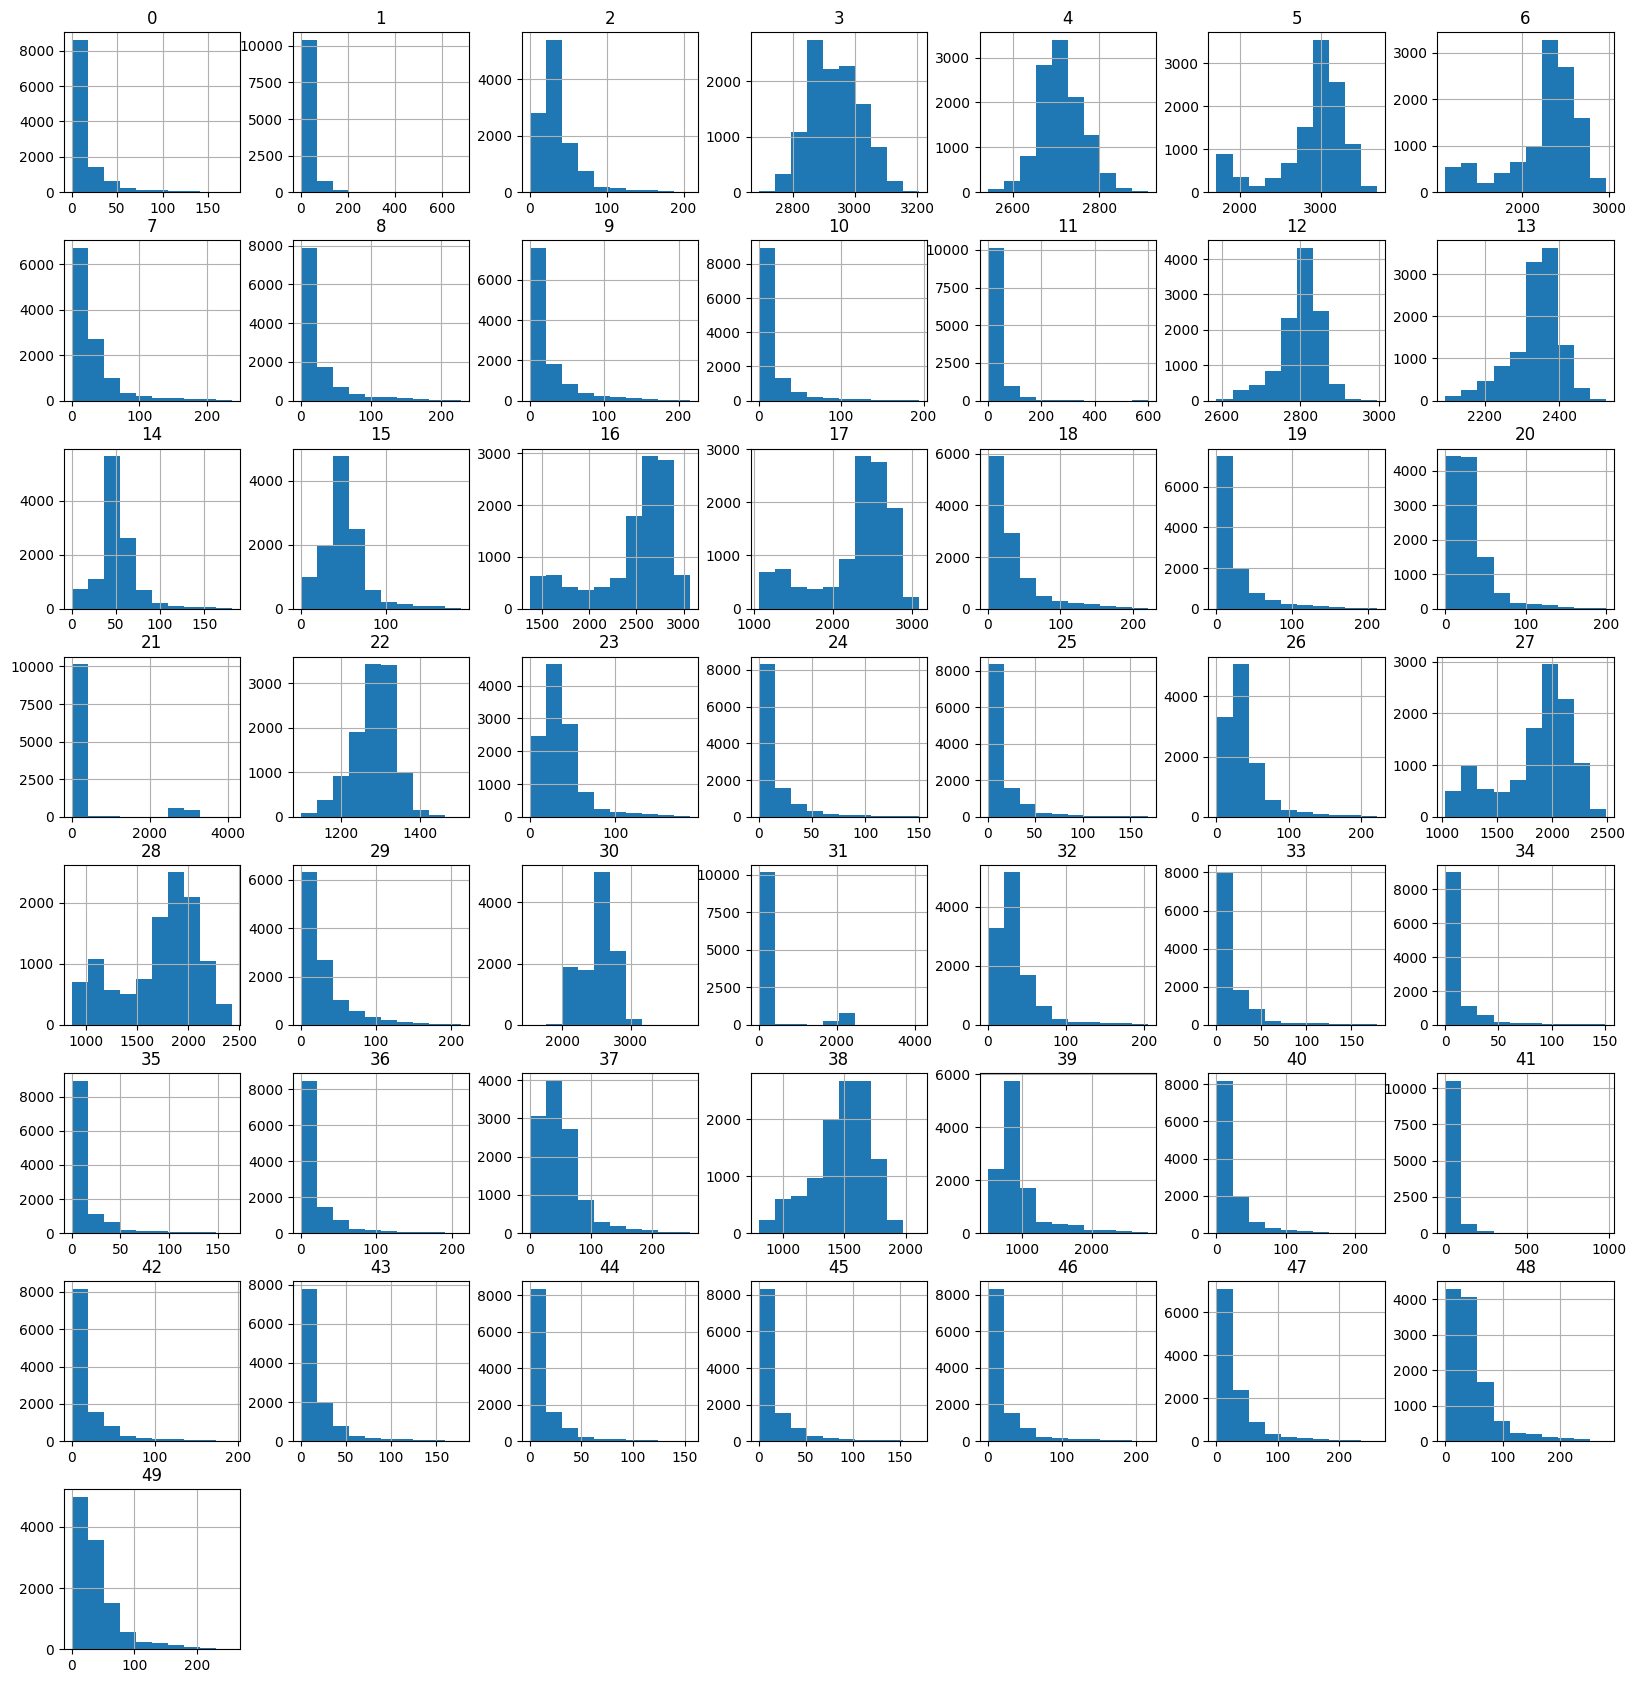

In [423]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [424]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11314.00  11314.00  11314.00  11314.00  11314.00  11314.00  11314.00   
mean      13.65     20.26     35.82   2934.45   2711.48   2885.85   2252.17   
std       22.95     32.32     28.58     82.31     51.36    437.72    407.61   
min        0.00      0.00      0.00   2690.00   2542.00   1714.00   1117.00   
25%        0.00      0.00     21.00   2871.00   2678.00   2780.00   2127.00   
50%        6.00      8.00     32.00   2928.00   2707.00   2999.00   2365.00   
75%       17.00     27.00     43.00   2994.00   2742.00   3168.00   2509.00   
max      176.00    679.00    208.00   3205.00   2912.00   3693.00   2959.00   

              7         8         9  ...       40        41        42  \
count  11314.00  11314.00  11314.00  ...  11314.0  11314.00  11314.00   
mean      26.28     22.41     22.17  ...     19.9     25.99     18.44   
std       34.66     34.77     33.07  ...     25.7     43.38     27.43   
min        0.00      0.00      0.00  ...      0.0      0.00      0.00   
25%        0.00      0.00      0.00  ...      0.0      0.00      0.00   
50%       18.00     10.00     10.00  ...     13.0     10.00     11.00   
75%       36.00     29.00     30.00  ...     25.0     32.00     21.00   
max      237.00    228.00    215.00  ...    231.0    982.00    192.00   

             43        44        45        46        47        48        49  
count  11314.00  11314.00  11314.00  11314.00  11314.00  11314.00  11314.00  
mean      17.59     13.88     15.49     19.84     28.80     42.43     36.03  
std       24.82     19.64     22.85     29.91     37.78     42.40     39.02  
min        0.00      0.00      0.00      0.00      0.00      0.00      0.00  
25%        0.00      0.00      0.00      0.00      0.00     10.00      0.00  
50%       11.00      9.00      9.00     12.00     20.00     37.00     30.00  
75%       21.00     16.00     17.00     22.00     36.00     56.00     51.00  
max      177.00    155.00    170.00    216.00    261.00    279.00    256.00  

[8 rows x 50 columns]

In [425]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [426]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

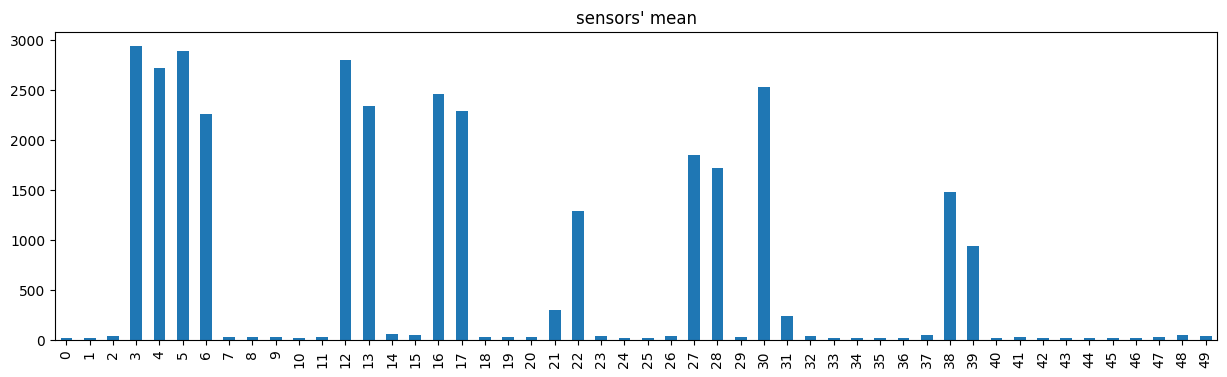

In [427]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [428]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [429]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [430]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [431]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [432]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [433]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.611; 0.601\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [434]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [435]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [436]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 'ACC0', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [437]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [438]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5747, 57), (5747,)) 
 test: ((5567, 57), (5567,))


### **Model Learning**

#### Random Forest

In [439]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [440]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.905
accuracy: 0.905


In [441]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3525
        Open      1.000     1.000     1.000       446
      Pistol      1.000     1.000     1.000       444
       Thumb      1.000     1.000     1.000       441
          OK      1.000     1.000     1.000       447
        Grab      1.000     1.000     1.000       444

    accuracy                          1.000      5747
   macro avg      1.000     1.000     1.000      5747
weighted avg      1.000     1.000     1.000      5747

              precision    recall  f1-score   support

     Neutral      0.943     0.968     0.956      3342
        Open      0.859     0.942     0.898       445
      Pistol      0.857     0.704     0.773       443
       Thumb      0.868     0.749     0.804       446
          OK      0.880     0.756     0.813       446
        Grab      0.778     0.906     0.837       445

    accuracy                          0.905      5567
   macro avg      0.864

In [442]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.943424    0.858607    0.857143    0.867532    0.879896   
recall        0.967983    0.941573    0.704289    0.748879    0.755605   
f1-score      0.955546    0.898178    0.773234    0.803851    0.813028   
support    3342.000000  445.000000  443.000000  446.000000  446.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.777992  0.905335     0.864099      0.905385  
recall       0.905618  0.905335     0.837325      0.905335  
f1-score     0.836968  0.905335     0.846801      0.903403  
support    445.000000  0.905335  5567.000000   5567.000000

In [443]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 21*

In [444]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

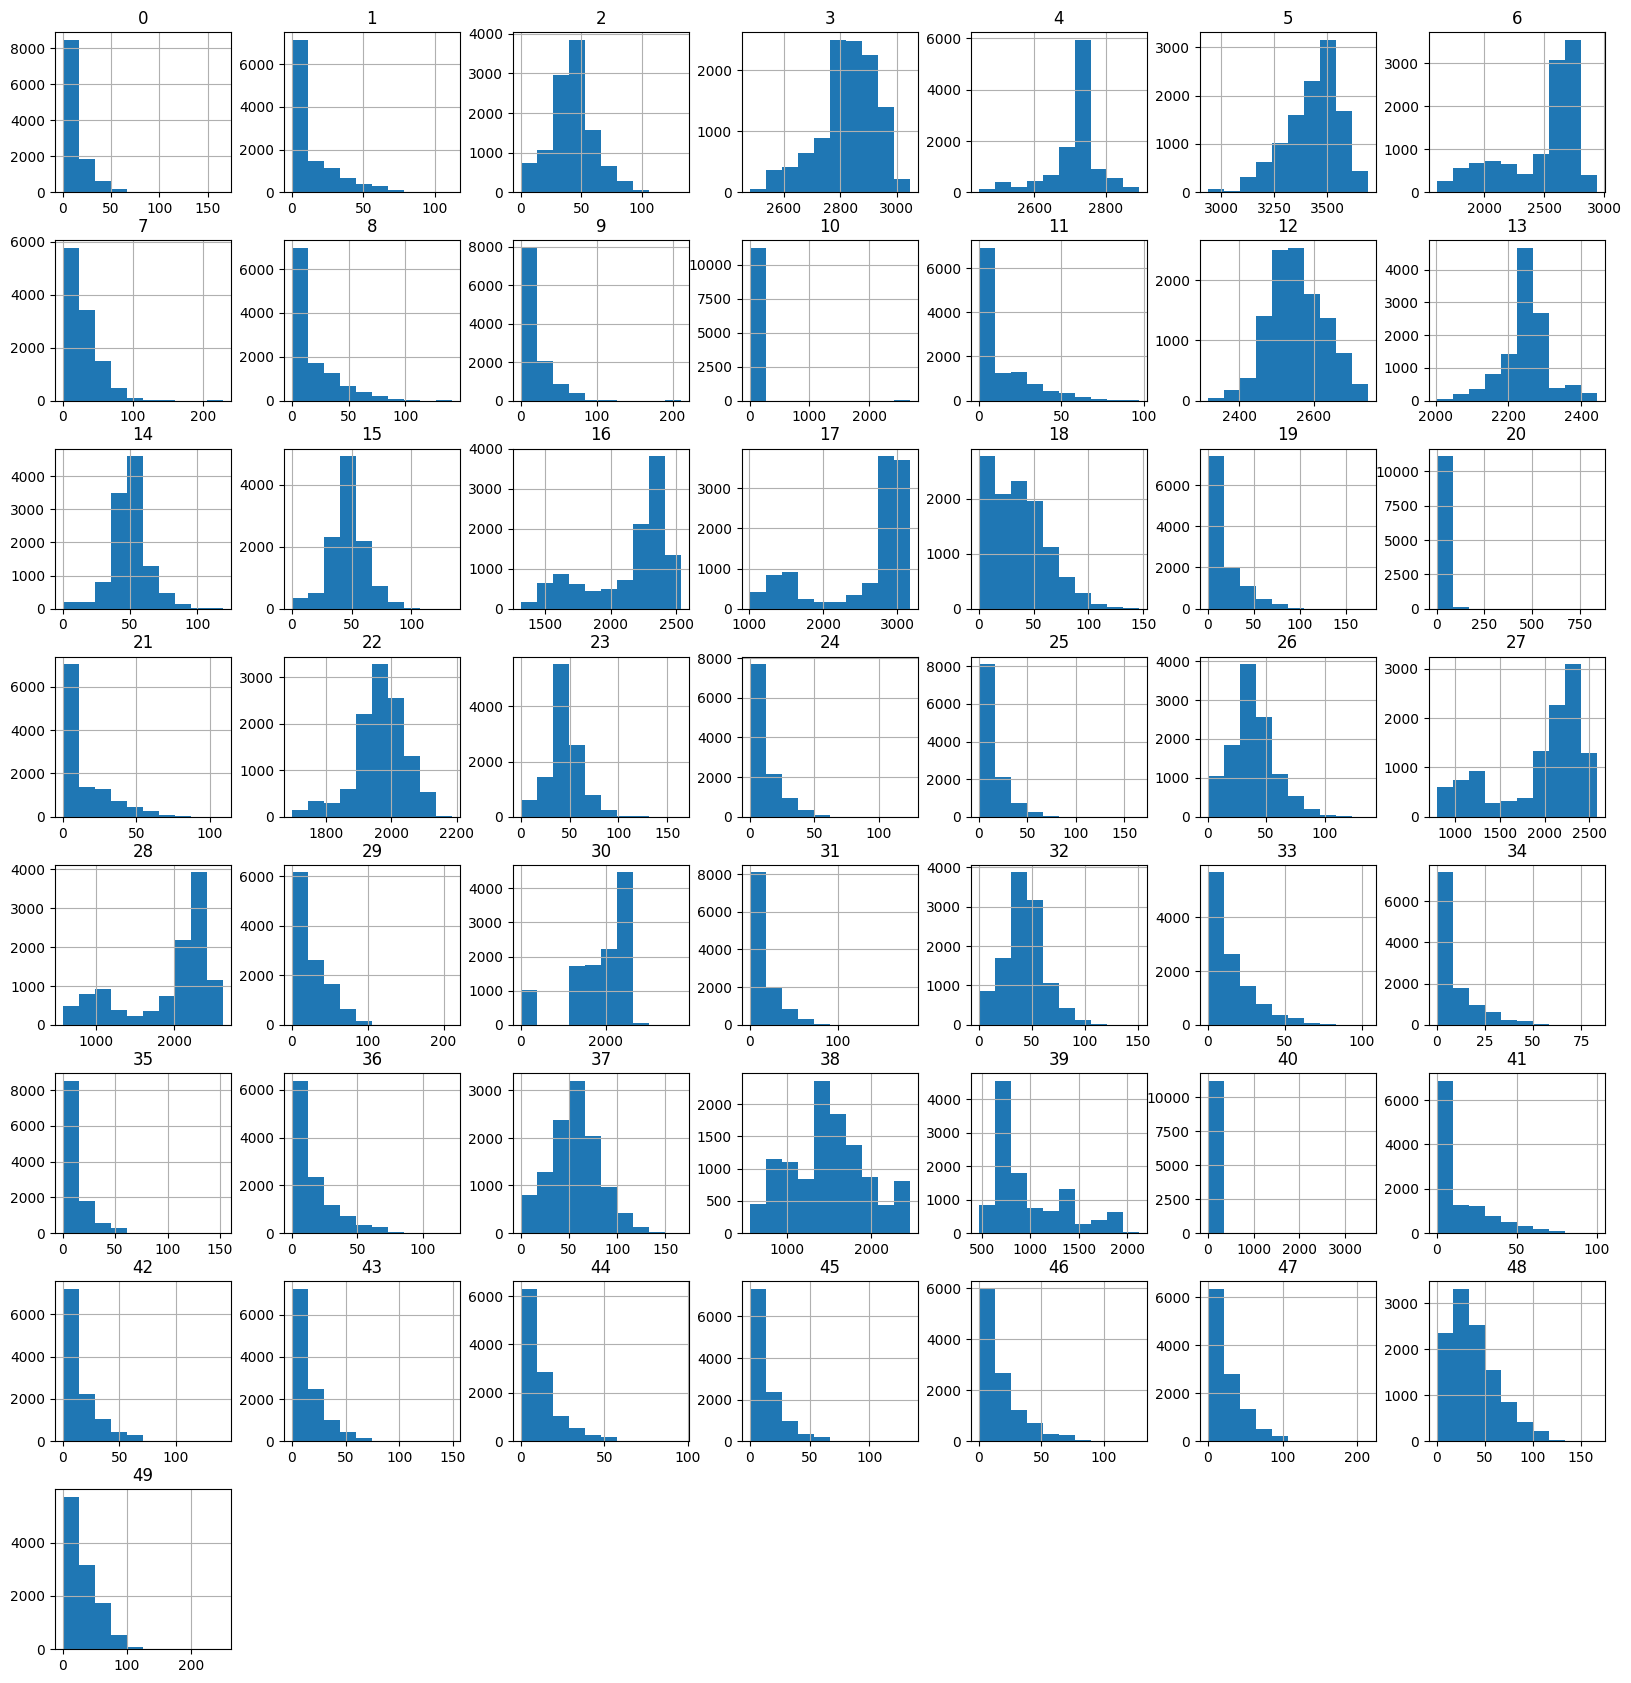

In [445]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [446]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11243.00  11243.00  11243.00  11243.00  11243.00  11243.00  11243.00   
mean      10.45     12.26     42.12   2826.99   2715.49   3432.12   2476.76   
std       14.54     17.98     18.23    103.72     71.47    129.16    319.72   
min        0.00      0.00      0.00   2480.00   2445.00   2936.00   1605.00   
25%        0.00      0.00     32.00   2782.00   2702.50   3356.00   2256.00   
50%        4.00      0.00     42.00   2830.00   2731.00   3455.00   2609.00   
75%       16.00     21.00     52.00   2912.00   2748.00   3521.00   2714.00   
max      166.00    112.00    132.00   3047.00   2893.00   3693.00   2938.00   

              7         8         9  ...        40        41        42  \
count  11243.00  11243.00  11243.00  ...  11243.00  11243.00  11243.00   
mean      25.58     14.95     14.14  ...     16.32     12.31     14.34   
std       22.79     20.76     20.21  ...     44.19     18.03     15.27   
min        0.00      0.00      0.00  ...      0.00      0.00      0.00   
25%        6.00      0.00      0.00  ...      3.00      0.00      2.00   
50%       22.00      1.00      0.00  ...     12.00      0.00     10.00   
75%       39.00     27.00     26.00  ...     23.00     21.00     20.00   
max      228.00    141.00    211.00  ...   3493.00    100.00    142.00   

             43        44        45        46        47        48        49  
count  11243.00  11243.00  11243.00  11243.00  11243.00  11243.00  11243.00  
mean      14.01     11.35     12.85     16.38     23.94     37.30     29.70  
std       14.57     11.65     13.38     17.42     22.95     26.04     24.82  
min        0.00      0.00      0.00      0.00      0.00      0.00      0.00  
25%        3.00      3.00      3.00      2.00      6.00     20.00     10.00  
50%       10.00      8.00      9.00     11.00     18.00     33.00     24.00  
75%       20.00     16.00     18.00     24.00     36.00     52.00     46.00  
max      149.00     96.00    134.00    128.00    214.00    167.00    250.00  

[8 rows x 50 columns]

In [447]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [448]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

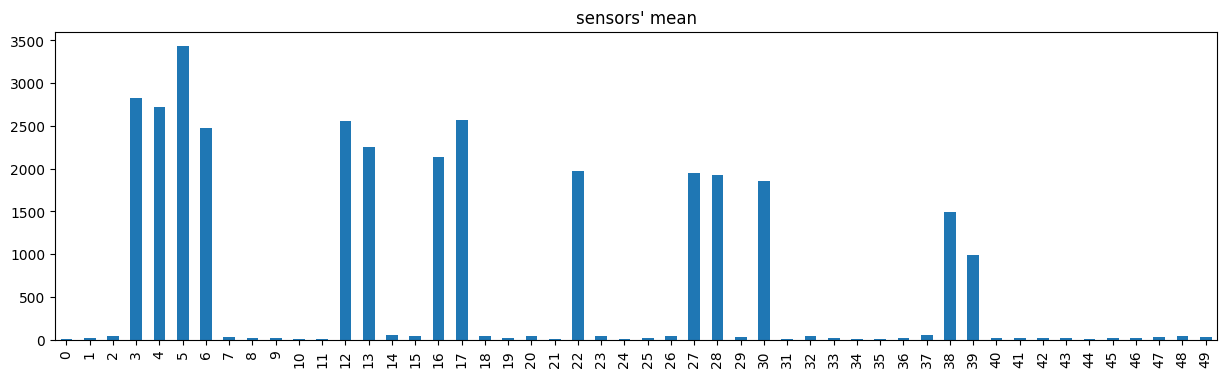

In [449]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [450]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [451]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [452]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [453]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [454]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [455]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.577; 0.628\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [456]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [457]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [458]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 'ACC0', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [459]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [460]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5361, 57), (5361,)) 
 test: ((5882, 57), (5882,))


### **Model Learning**

#### Random Forest

In [461]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [462]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.928
accuracy: 0.928


In [463]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3236
        Open      1.000     1.000     1.000       424
      Pistol      1.000     1.000     1.000       422
       Thumb      1.000     1.000     1.000       425
          OK      1.000     1.000     1.000       427
        Grab      1.000     1.000     1.000       427

    accuracy                          1.000      5361
   macro avg      1.000     1.000     1.000      5361
weighted avg      1.000     1.000     1.000      5361

              precision    recall  f1-score   support

     Neutral      0.924     0.990     0.956      3441
        Open      0.974     0.759     0.853       486
      Pistol      0.890     0.963     0.925       488
       Thumb      0.962     0.773     0.857       490
          OK      0.952     0.804     0.872       491
        Grab      0.925     0.907     0.916       486

    accuracy                          0.928      5882
   macro avg      0.938

In [464]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.923557    0.973615    0.890152    0.961929    0.951807   
recall        0.990119    0.759259    0.963115    0.773469    0.804481   
f1-score      0.955680    0.853179    0.925197    0.857466    0.871965   
support    3441.000000  486.000000  488.000000  490.000000  491.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.924528  0.928426     0.937598      0.930556  
recall       0.907407  0.928426     0.866308      0.928426  
f1-score     0.915888  0.928426     0.896562      0.926224  
support    486.000000  0.928426  5882.000000   5882.000000

In [465]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 22*

In [466]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

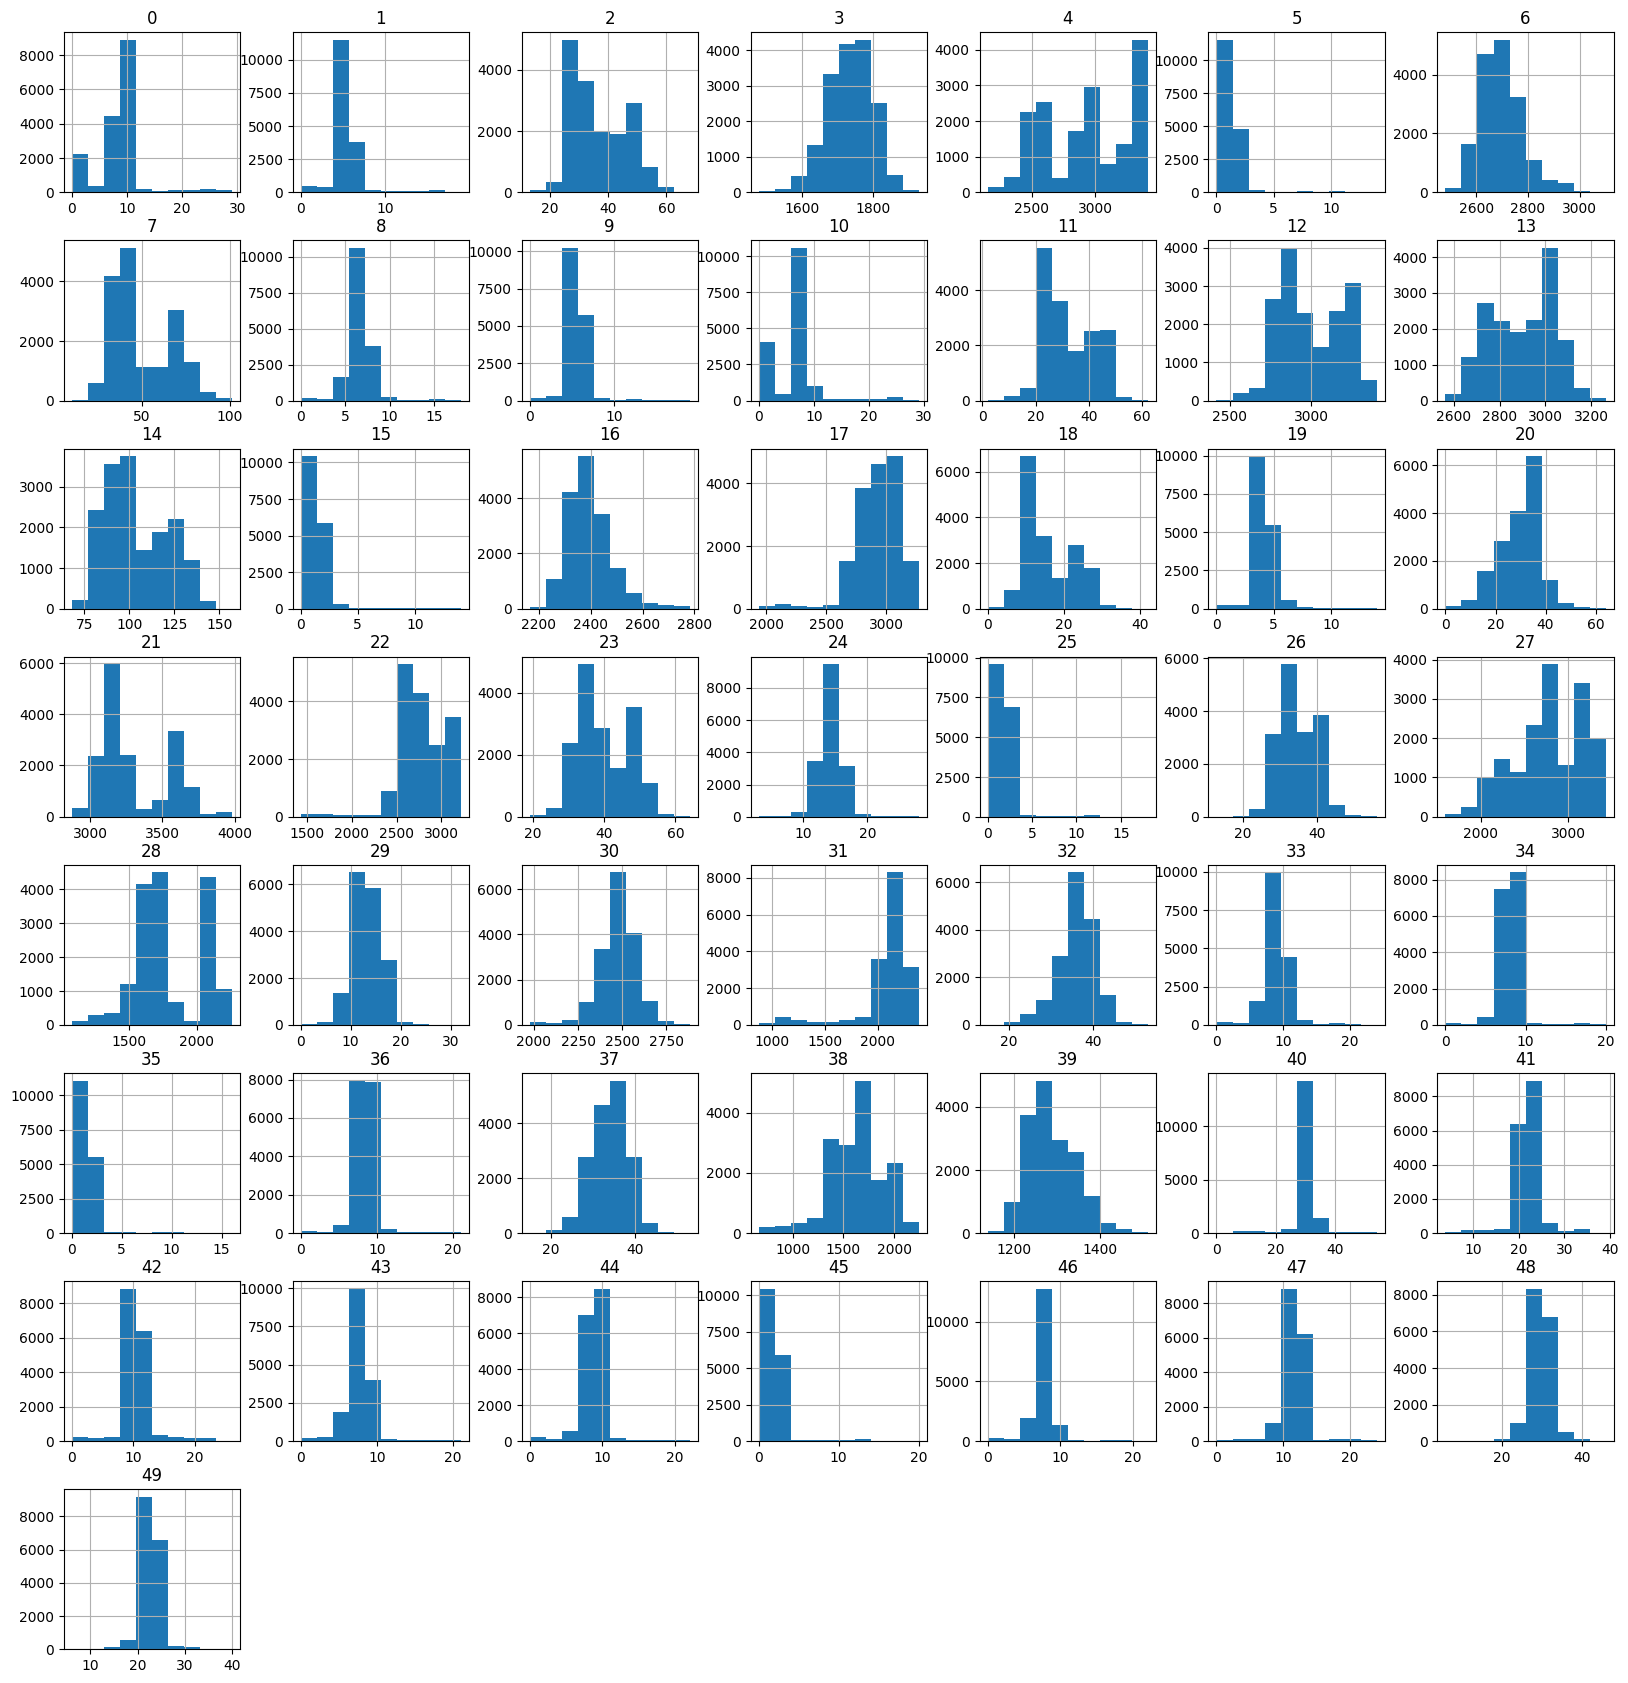

In [467]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [468]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  16837.00  16837.00  16837.00  16837.00  16837.00  16837.00  16837.00   
mean       8.28      5.10     36.30   1733.36   2924.66      1.35   2697.72   
std        4.49      2.02      9.42     63.92    329.83      1.30     82.45   
min        0.00      0.00     13.00   1478.00   2152.00      0.00   2482.00   
25%        8.00      4.00     28.00   1690.00   2591.00      1.00   2638.00   
50%        9.00      5.00     33.00   1736.00   2939.00      1.00   2692.00   
75%       10.00      6.00     45.00   1781.00   3287.00      2.00   2743.00   
max       29.00     19.00     68.00   1928.00   3412.00     14.00   3099.00   

              7         8         9  ...        40        41        42  \
count  16837.00  16837.00  16837.00  ...  16837.00  16837.00  16837.00   
mean      49.50      6.68      5.23  ...     30.00     21.79     10.50   
std       16.71      1.59      1.34  ...      4.24      2.85      2.45   
min       10.00      0.00      0.00  ...      0.00      4.00      0.00   
25%       37.00      6.00      5.00  ...     29.00     21.00     10.00   
50%       42.00      7.00      5.00  ...     30.00     22.00     10.00   
75%       66.00      8.00      6.00  ...     32.00     23.00     11.00   
max      101.00     18.00     19.00  ...     54.00     39.00     26.00   

             43        44        45        46        47        48        49  
count  16837.00  16837.00  16837.00  16837.00  16837.00  16837.00  16837.00  
mean       7.94      8.61      1.48      7.59     11.11     29.24     22.26  
std        1.93      1.81      1.49      1.74      1.90      2.77      2.04  
min        0.00      0.00      0.00      0.00      0.00      6.00      6.00  
25%        7.00      8.00      1.00      7.00     10.00     28.00     21.00  
50%        8.00      9.00      1.00      8.00     11.00     29.00     22.00  
75%        9.00      9.00      2.00      8.00     12.00     31.00     24.00  
max       21.00     22.00     20.00     22.00     24.00     46.00     40.00  

[8 rows x 50 columns]

In [469]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [470]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

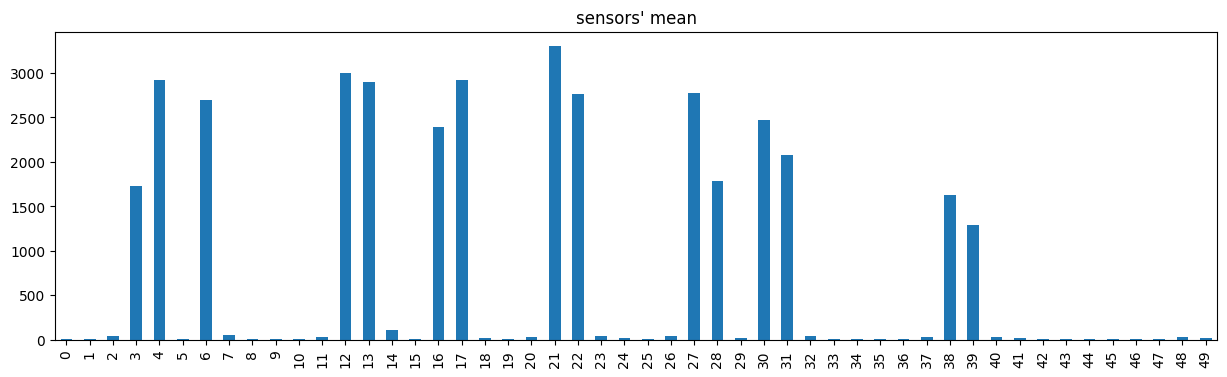

In [471]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [472]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [473]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [474]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [475]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [476]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [477]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.606; 0.584\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [478]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [479]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [480]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['3', '4', '6', '7', '12', '13', '14', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', 'SYNC', 'ts']


### **Train-Test Split**

In [481]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [482]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((13506, 20), (13506,)) 
 test: ((3331, 20), (3331,))


### **Model Learning**

#### Random Forest

In [483]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [484]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.946
accuracy: 0.946


In [485]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      8079
        Open      1.000     1.000     1.000      1082
      Pistol      1.000     1.000     1.000      1086
       Thumb      1.000     1.000     1.000      1086
          OK      1.000     1.000     1.000      1084
        Grab      1.000     1.000     1.000      1089

    accuracy                          1.000     13506
   macro avg      1.000     1.000     1.000     13506
weighted avg      1.000     1.000     1.000     13506

              precision    recall  f1-score   support

     Neutral      0.971     0.971     0.971      1950
        Open      0.898     0.872     0.885       274
      Pistol      0.906     0.894     0.900       282
       Thumb      0.949     0.956     0.953       275
          OK      0.900     0.893     0.897       272
        Grab      0.897     0.939     0.917       278

    accuracy                          0.946      3331
   macro avg      0.920

In [486]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.971267    0.898496    0.906475    0.949458    0.900000   
recall        0.970769    0.872263    0.893617    0.956364    0.893382   
f1-score      0.971018    0.885185    0.900000    0.952899    0.896679   
support    1950.000000  274.000000  282.000000  275.000000  272.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.896907  0.945962     0.920434      0.945970  
recall       0.938849  0.945962     0.920874      0.945962  
f1-score     0.917399  0.945962     0.920530      0.945904  
support    278.000000  0.945962  3331.000000   3331.000000

In [487]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 23*

In [488]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

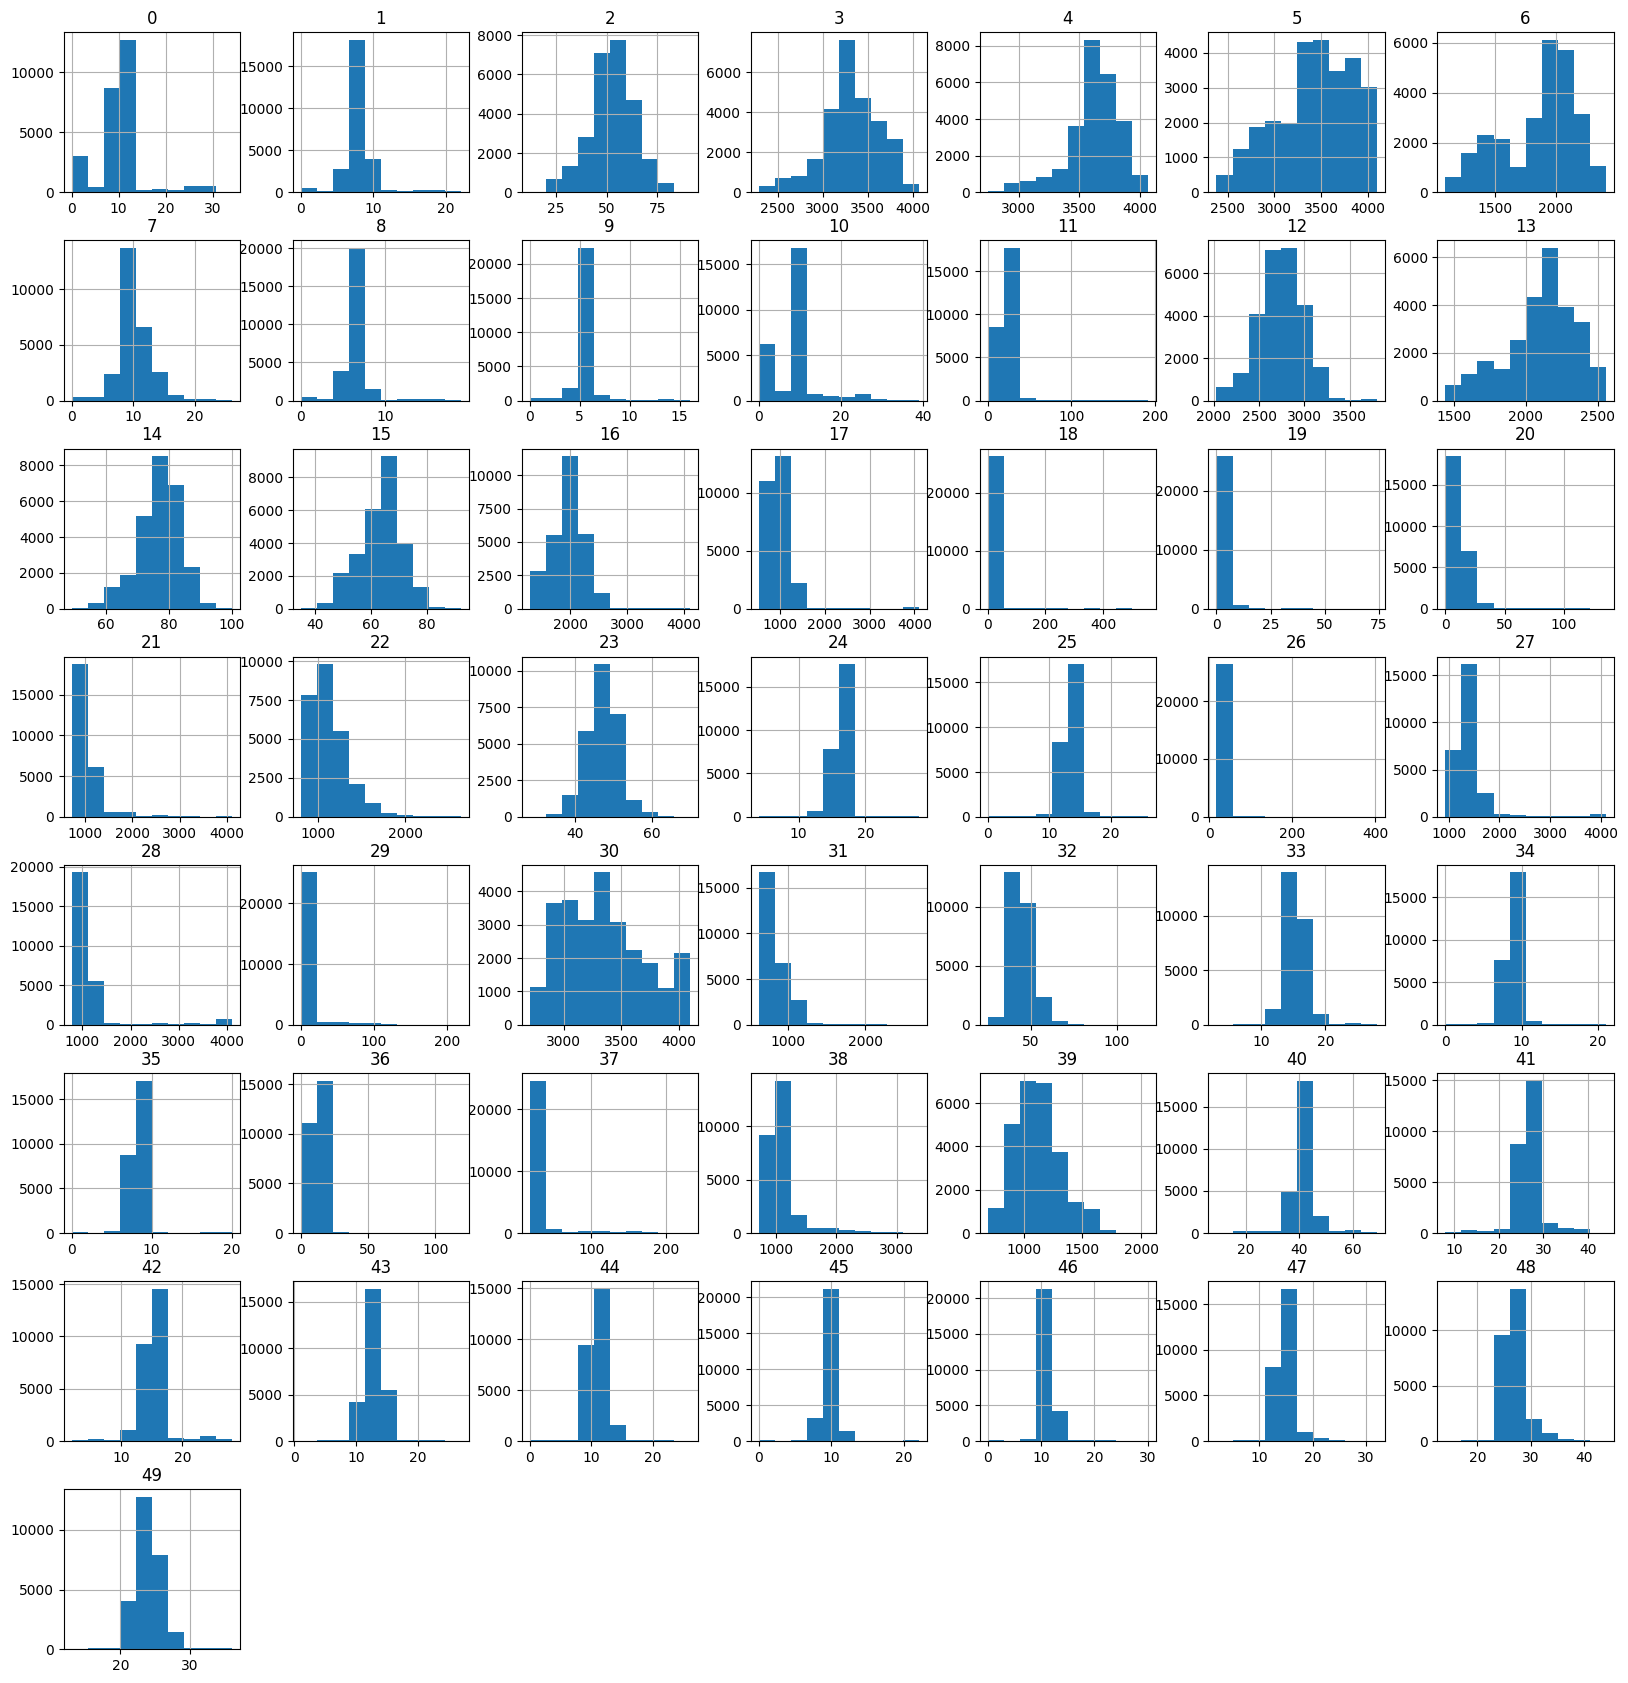

In [489]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [490]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  26648.00  26648.00  26648.00  26648.00  26648.00  26648.00  26648.00   
mean      10.26      7.88     52.37   3312.58   3618.05   3428.81   1865.30   
std        5.18      2.27     11.16    315.31    218.25    409.00    300.04   
min        0.00      0.00     12.00   2287.00   2741.00   2381.00   1093.00   
25%       10.00      7.00     46.00   3150.00   3527.00   3162.00   1626.00   
50%       11.00      8.00     52.00   3304.00   3645.00   3458.00   1943.00   
75%       11.00      8.00     60.00   3532.00   3761.00   3759.00   2090.00   
max       34.00     22.00     91.00   4068.00   4067.00   4095.00   2409.00   

              7         8         9  ...        40        41        42  \
count  26648.00  26648.00  26648.00  ...  26648.00  26648.00  26648.00   
mean      10.05      6.21      5.52  ...     40.70     26.29     15.06   
std        2.70      1.78      1.52  ...      4.92      3.28      2.56   
min        0.00      0.00      0.00  ...      9.00      8.00      2.00   
25%        8.00      6.00      5.00  ...     39.00     25.00     14.00   
50%       10.00      6.00      6.00  ...     40.00     26.00     15.00   
75%       12.00      7.00      6.00  ...     42.00     27.00     16.00   
max       26.00     19.00     16.00  ...     69.00     44.00     28.00   

             43        44       45        46        47        48        49  
count  26648.00  26648.00  26648.0  26648.00  26648.00  26648.00  26648.00  
mean      12.60     11.02      9.4     10.68     14.24     26.46     24.14  
std        1.73      1.77      1.6      1.75      1.91      2.33      1.83  
min        1.00      0.00      0.0      0.00      2.00     14.00     13.00  
25%       12.00     10.00      9.0     10.00     13.00     25.00     23.00  
50%       13.00     11.00      9.0     11.00     14.00     26.00     24.00  
75%       13.00     12.00     10.0     11.00     15.00     28.00     25.00  
max       27.00     26.00     22.0     30.00     32.00     44.00     36.00  

[8 rows x 50 columns]

In [491]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [492]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

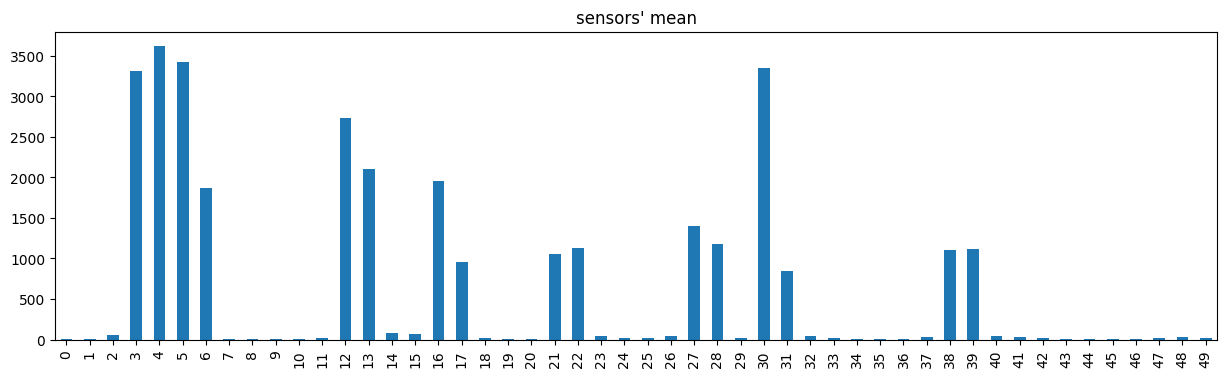

In [493]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [494]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [495]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [496]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [497]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [498]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [499]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.576; 0.632\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [500]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [501]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [502]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '2', '3', '4', '5', '6', '10', '11', '12', '13', '15', '16', '17', '18', '20', '21', '22', '26', '27', '28', '29', '30', '31', '37', '38', '39', 'ACC0', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'SYNC', 'ts']


### **Train-Test Split**

In [503]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [504]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((20756, 33), (20756,)) 
 test: ((5892, 33), (5892,))


### **Model Learning**

#### Random Forest

In [505]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [506]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.984
accuracy: 0.984


In [507]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000     12288
        Open      1.000     1.000     1.000      1694
      Pistol      1.000     1.000     1.000      1695
       Thumb      1.000     1.000     1.000      1693
          OK      1.000     1.000     1.000      1692
        Grab      1.000     1.000     1.000      1694

    accuracy                          1.000     20756
   macro avg      1.000     1.000     1.000     20756
weighted avg      1.000     1.000     1.000     20756

              precision    recall  f1-score   support

     Neutral      0.988     0.988     0.988      3482
        Open      0.986     0.979     0.982       486
      Pistol      0.979     0.967     0.973       483
       Thumb      0.979     0.979     0.979       484
          OK      0.965     0.981     0.973       478
        Grab      0.981     0.979     0.980       479

    accuracy                          0.984      5892
   macro avg      0.980

In [508]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.987658    0.985507    0.979036    0.979339    0.965021   
recall        0.988225    0.979424    0.966874    0.979339    0.981172   
f1-score      0.987941    0.982456    0.972917    0.979339    0.973029   
support    3482.000000  486.000000  483.000000  484.000000  478.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.981172  0.983707     0.979622      0.983726  
recall       0.979123  0.983707     0.979026      0.983707  
f1-score     0.980146  0.983707     0.979305      0.983707  
support    479.000000  0.983707  5892.000000   5892.000000

In [509]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 24*

In [510]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

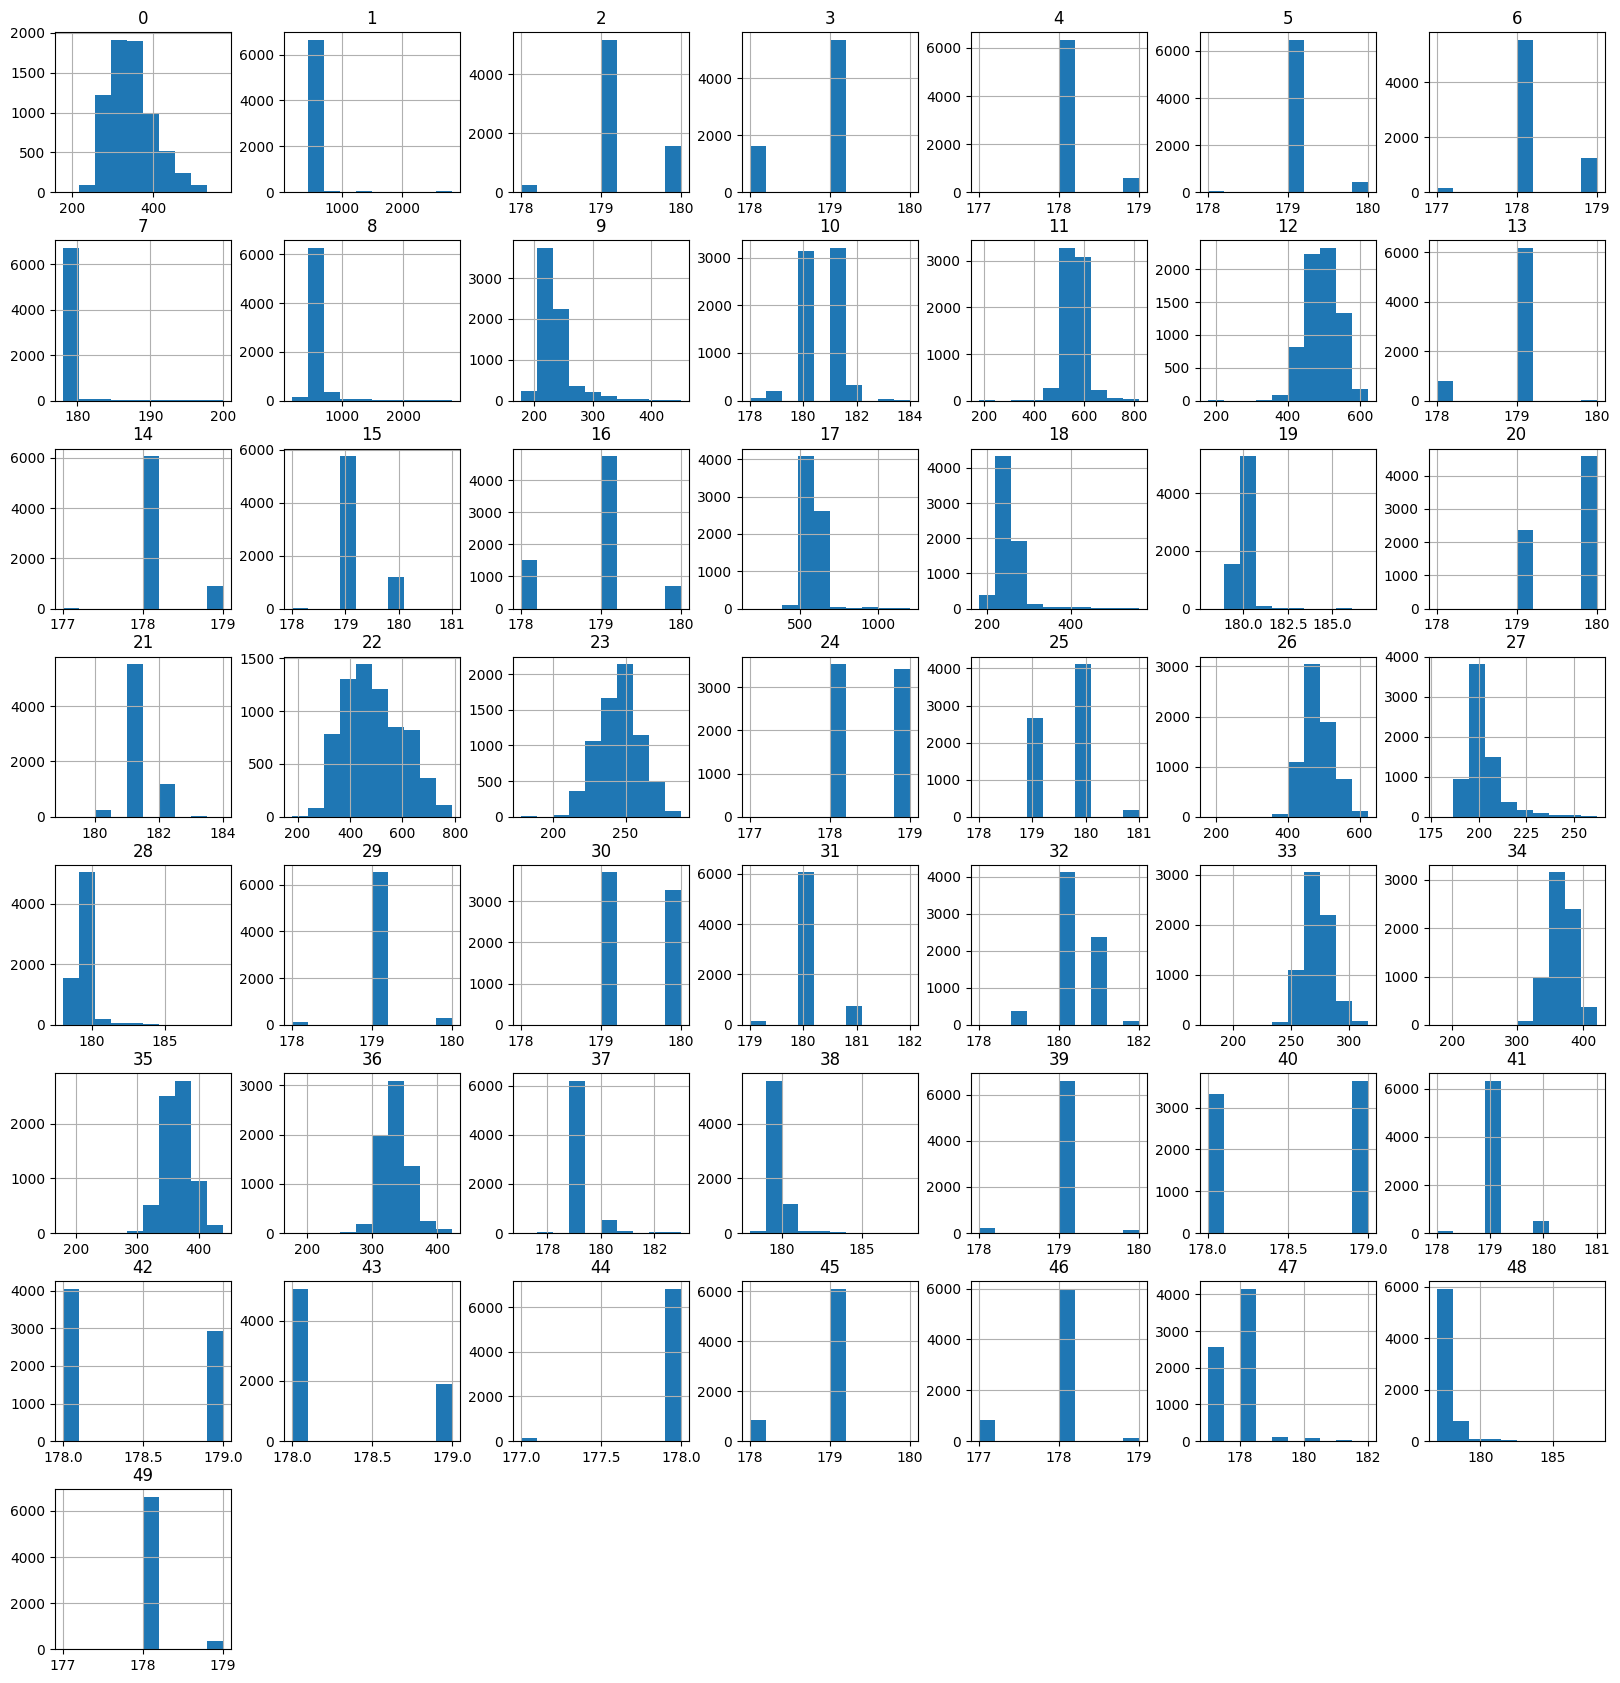

In [511]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [512]:
gestures.iloc[:, :50].describe().round(2)

0        1        2        3        4        5        6        7  \
count  6964.00  6964.00  6964.00  6964.00  6964.00  6964.00  6964.00  6964.00   
mean    346.59   608.10   179.19   178.77   178.08   179.06   178.16   179.00   
std      55.70   274.79     0.47     0.42     0.29     0.26     0.42     1.59   
min     178.00   179.00   178.00   178.00   177.00   178.00   177.00   178.00   
25%     303.00   538.00   179.00   179.00   178.00   179.00   178.00   178.00   
50%     340.00   564.00   179.00   179.00   178.00   179.00   178.00   179.00   
75%     379.00   587.00   179.00   179.00   178.00   179.00   178.00   179.00   
max     571.00  2818.00   180.00   180.00   179.00   180.00   179.00   200.00   

             8        9  ...       40       41       42       43       44  \
count  6964.00  6964.00  ...  6964.00  6964.00  6964.00  6964.00  6964.00   
mean    589.94   235.37  ...   178.52   179.06   178.42   178.27   177.98   
std     235.28    28.67  ...     0.50     0.30     0.49     0.45     0.14   
min     178.00   178.00  ...   178.00   178.00   178.00   178.00   177.00   
25%     509.00   218.00  ...   178.00   179.00   178.00   178.00   178.00   
50%     546.00   228.00  ...   179.00   179.00   178.00   178.00   178.00   
75%     594.00   244.00  ...   179.00   179.00   179.00   179.00   178.00   
max    2795.00   450.00  ...   179.00   181.00   179.00   179.00   178.00   

            45       46       47       48       49  
count  6964.00  6964.00  6964.00  6964.00  6964.00  
mean    178.88   177.90   177.69   178.23   178.05  
std       0.33     0.36     0.63     0.74     0.22  
min     178.00   177.00   177.00   177.00   177.00  
25%     179.00   178.00   177.00   178.00   178.00  
50%     179.00   178.00   178.00   178.00   178.00  
75%     179.00   178.00   178.00   178.00   178.00  
max     180.00   179.00   182.00   188.00   179.00  

[8 rows x 50 columns]

In [513]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [514]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

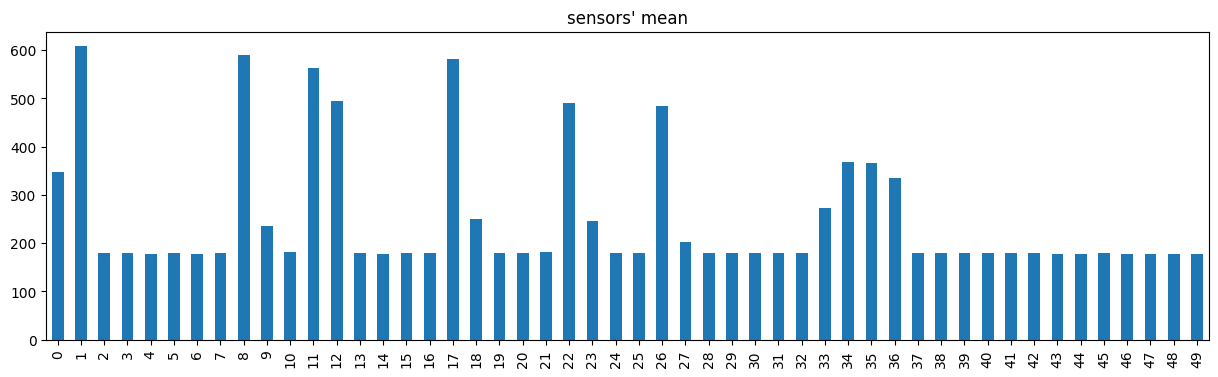

In [515]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [516]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [517]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [518]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [519]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [520]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [521]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.596; 0.582\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [522]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [523]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [524]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '23', '26', '27', '33', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [525]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [526]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((3539, 18), (3539,)) 
 test: ((3425, 18), (3425,))


### **Model Learning**

#### Random Forest

In [527]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [528]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.524
accuracy: 0.524


In [529]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      2157
        Open      1.000     1.000     1.000       277
      Pistol      1.000     1.000     1.000       267
       Thumb      1.000     1.000     1.000       279
          OK      1.000     1.000     1.000       282
        Grab      1.000     1.000     1.000       277

    accuracy                          1.000      3539
   macro avg      1.000     1.000     1.000      3539
weighted avg      1.000     1.000     1.000      3539

              precision    recall  f1-score   support

     Neutral      0.582     0.879     0.700      2027
        Open      0.000     0.000     0.000       279
      Pistol      0.000     0.000     0.000       285
       Thumb      0.113     0.032     0.050       279
          OK      0.000     0.000     0.000       276
        Grab      0.057     0.011     0.018       279

    accuracy                          0.524      3425
   macro avg      0.125

In [530]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral   Open  Pistol       Thumb     OK        Grab  \
precision     0.582163    0.0     0.0    0.112500    0.0    0.056604   
recall        0.879132    0.0     0.0    0.032258    0.0    0.010753   
f1-score      0.700472    0.0     0.0    0.050139    0.0    0.018072   
support    2027.000000  279.0   285.0  279.000000  276.0  279.000000   

           accuracy    macro avg  weighted avg  
precision  0.523796     0.125211      0.358313  
recall     0.523796     0.153690      0.523796  
f1-score   0.523796     0.128114      0.420113  
support    0.523796  3425.000000   3425.000000

In [531]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 25*

In [532]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

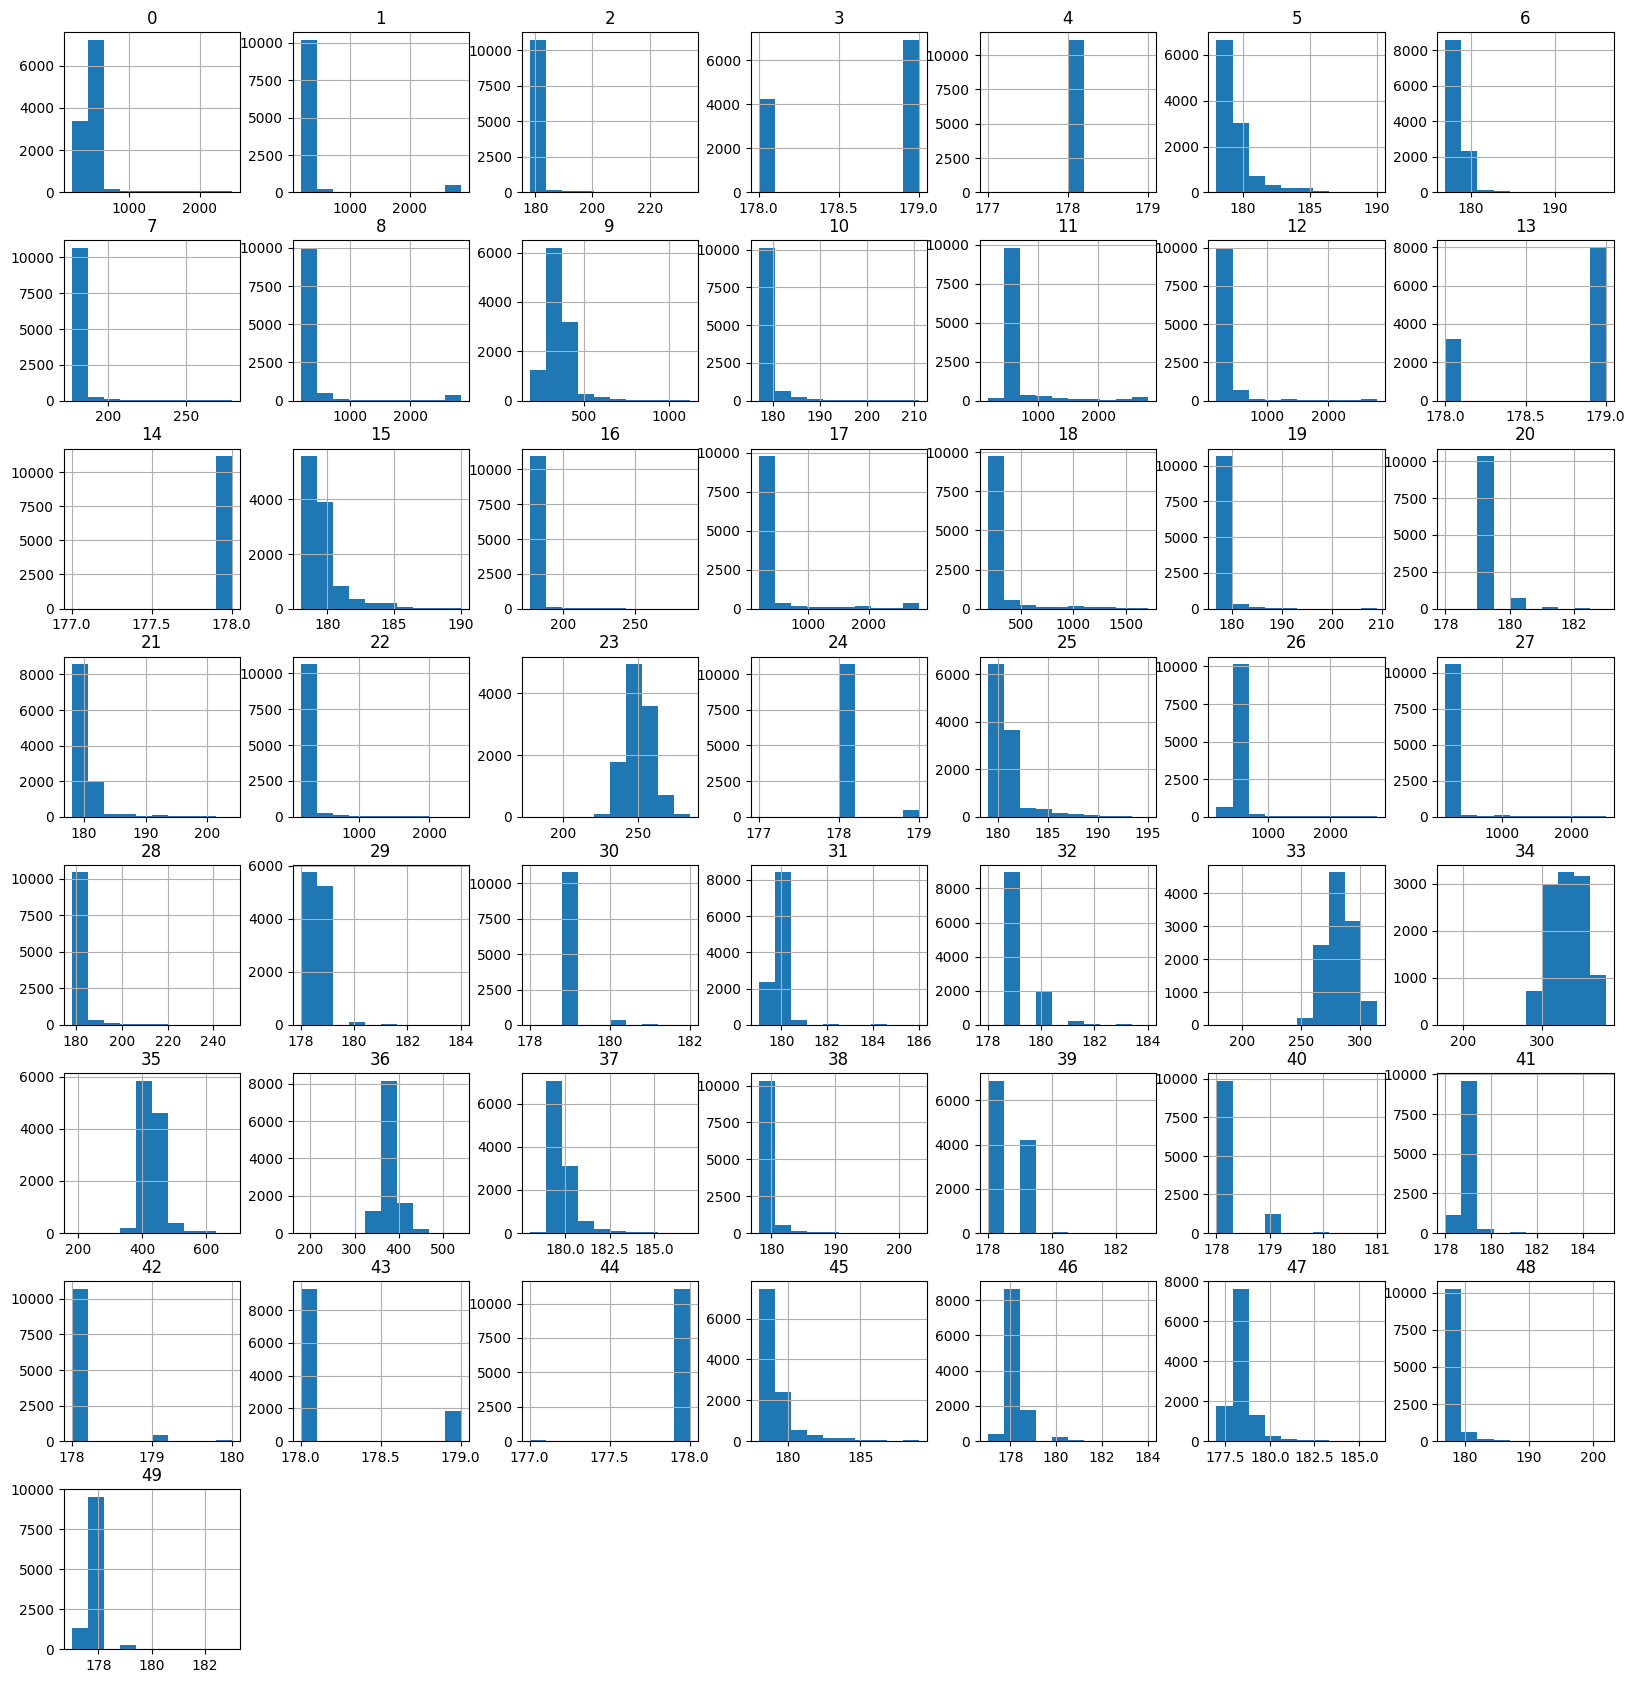

In [533]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [534]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00   
mean     482.91    403.14    179.41    178.62    178.00    179.70    178.36   
std      252.15    556.98      4.05      0.49      0.07      1.24      1.13   
min      178.00    178.00    178.00    178.00    177.00    178.00    177.00   
25%      350.00    231.00    178.00    178.00    178.00    179.00    178.00   
50%      475.00    247.00    179.00    179.00    178.00    179.00    178.00   
75%      507.00    294.00    179.00    179.00    178.00    180.00    178.00   
max     2455.00   2855.00    234.00    179.00    179.00    190.00    196.00   

              7         8         9  ...        40        41        42  \
count  11169.00  11169.00  11169.00  ...  11169.00  11169.00  11169.00   
mean     180.20    447.71    352.11  ...    178.12    178.96    178.05   
std        7.32    497.38     81.77  ...      0.35      0.53      0.23   
min      177.00    178.00    177.00  ...    178.00    178.00    178.00   
25%      178.00    295.00    305.00  ...    178.00    179.00    178.00   
50%      179.00    320.00    350.00  ...    178.00    179.00    178.00   
75%      179.00    354.00    374.00  ...    178.00    179.00    178.00   
max      279.00   2834.00   1120.00  ...    181.00    185.00    180.00   

             43        44        45        46        47        48        49  
count  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00  
mean     178.17    177.99    179.59    178.21    178.08    178.47    177.91  
std        0.37      0.09      1.22      0.65      0.86      1.65      0.40  
min      178.00    177.00    178.00    177.00    177.00    177.00    177.00  
25%      178.00    178.00    179.00    178.00    178.00    178.00    178.00  
50%      178.00    178.00    179.00    178.00    178.00    178.00    178.00  
75%      178.00    178.00    180.00    178.00    178.00    178.00    178.00  
max      179.00    178.00    189.00    184.00    186.00    202.00    183.00  

[8 rows x 50 columns]

In [535]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [536]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

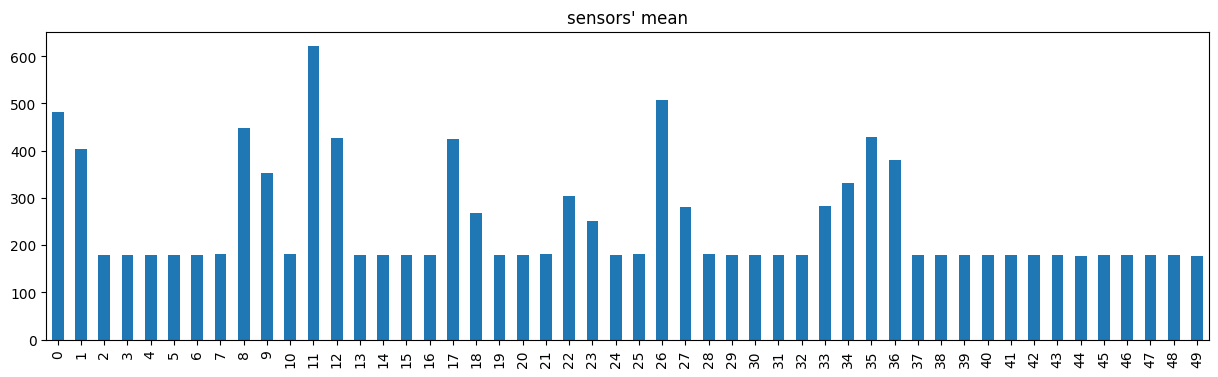

In [537]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [538]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [539]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [540]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [541]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [542]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [543]:
#display
summary

['Оптимальные свдиги для концевых выборок:   12 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.653; 0.579\n',
 'Размер оптимального сдвига (как среднего): 6']

#### Noise / Inactive Sensors

In [544]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [545]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [546]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '7', '8', '9', '11', '12', '17', '18', '22', '23', '26', '27', '28', '33', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [547]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [548]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5675, 20), (5675,)) 
 test: ((5494, 20), (5494,))


### **Model Learning**

#### Random Forest

In [549]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [550]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.844
accuracy: 0.844


In [551]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3395
        Open      1.000     1.000     1.000       455
      Pistol      1.000     1.000     1.000       451
       Thumb      1.000     1.000     1.000       459
          OK      1.000     1.000     1.000       458
        Grab      1.000     1.000     1.000       457

    accuracy                          1.000      5675
   macro avg      1.000     1.000     1.000      5675
weighted avg      1.000     1.000     1.000      5675

              precision    recall  f1-score   support

     Neutral      0.844     0.939     0.889      3205
        Open      0.776     0.771     0.773       458
      Pistol      0.836     0.683     0.751       463
       Thumb      0.827     0.716     0.768       455
          OK      0.923     0.682     0.784       456
        Grab      0.890     0.707     0.788       457

    accuracy                          0.844      5494
   macro avg      0.849

In [552]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.843566    0.775824    0.835979    0.827411    0.922849   
recall        0.938846    0.770742    0.682505    0.716484    0.682018   
f1-score      0.888659    0.773275    0.751486    0.767962    0.784363   
support    3205.000000  458.000000  463.000000  455.000000  456.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.889807  0.844194     0.849239      0.846368  
recall       0.706783  0.844194     0.749563      0.844194  
f1-score     0.787805  0.844194     0.792258      0.840439  
support    457.000000  0.844194  5494.000000   5494.000000

In [553]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 26*

In [554]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

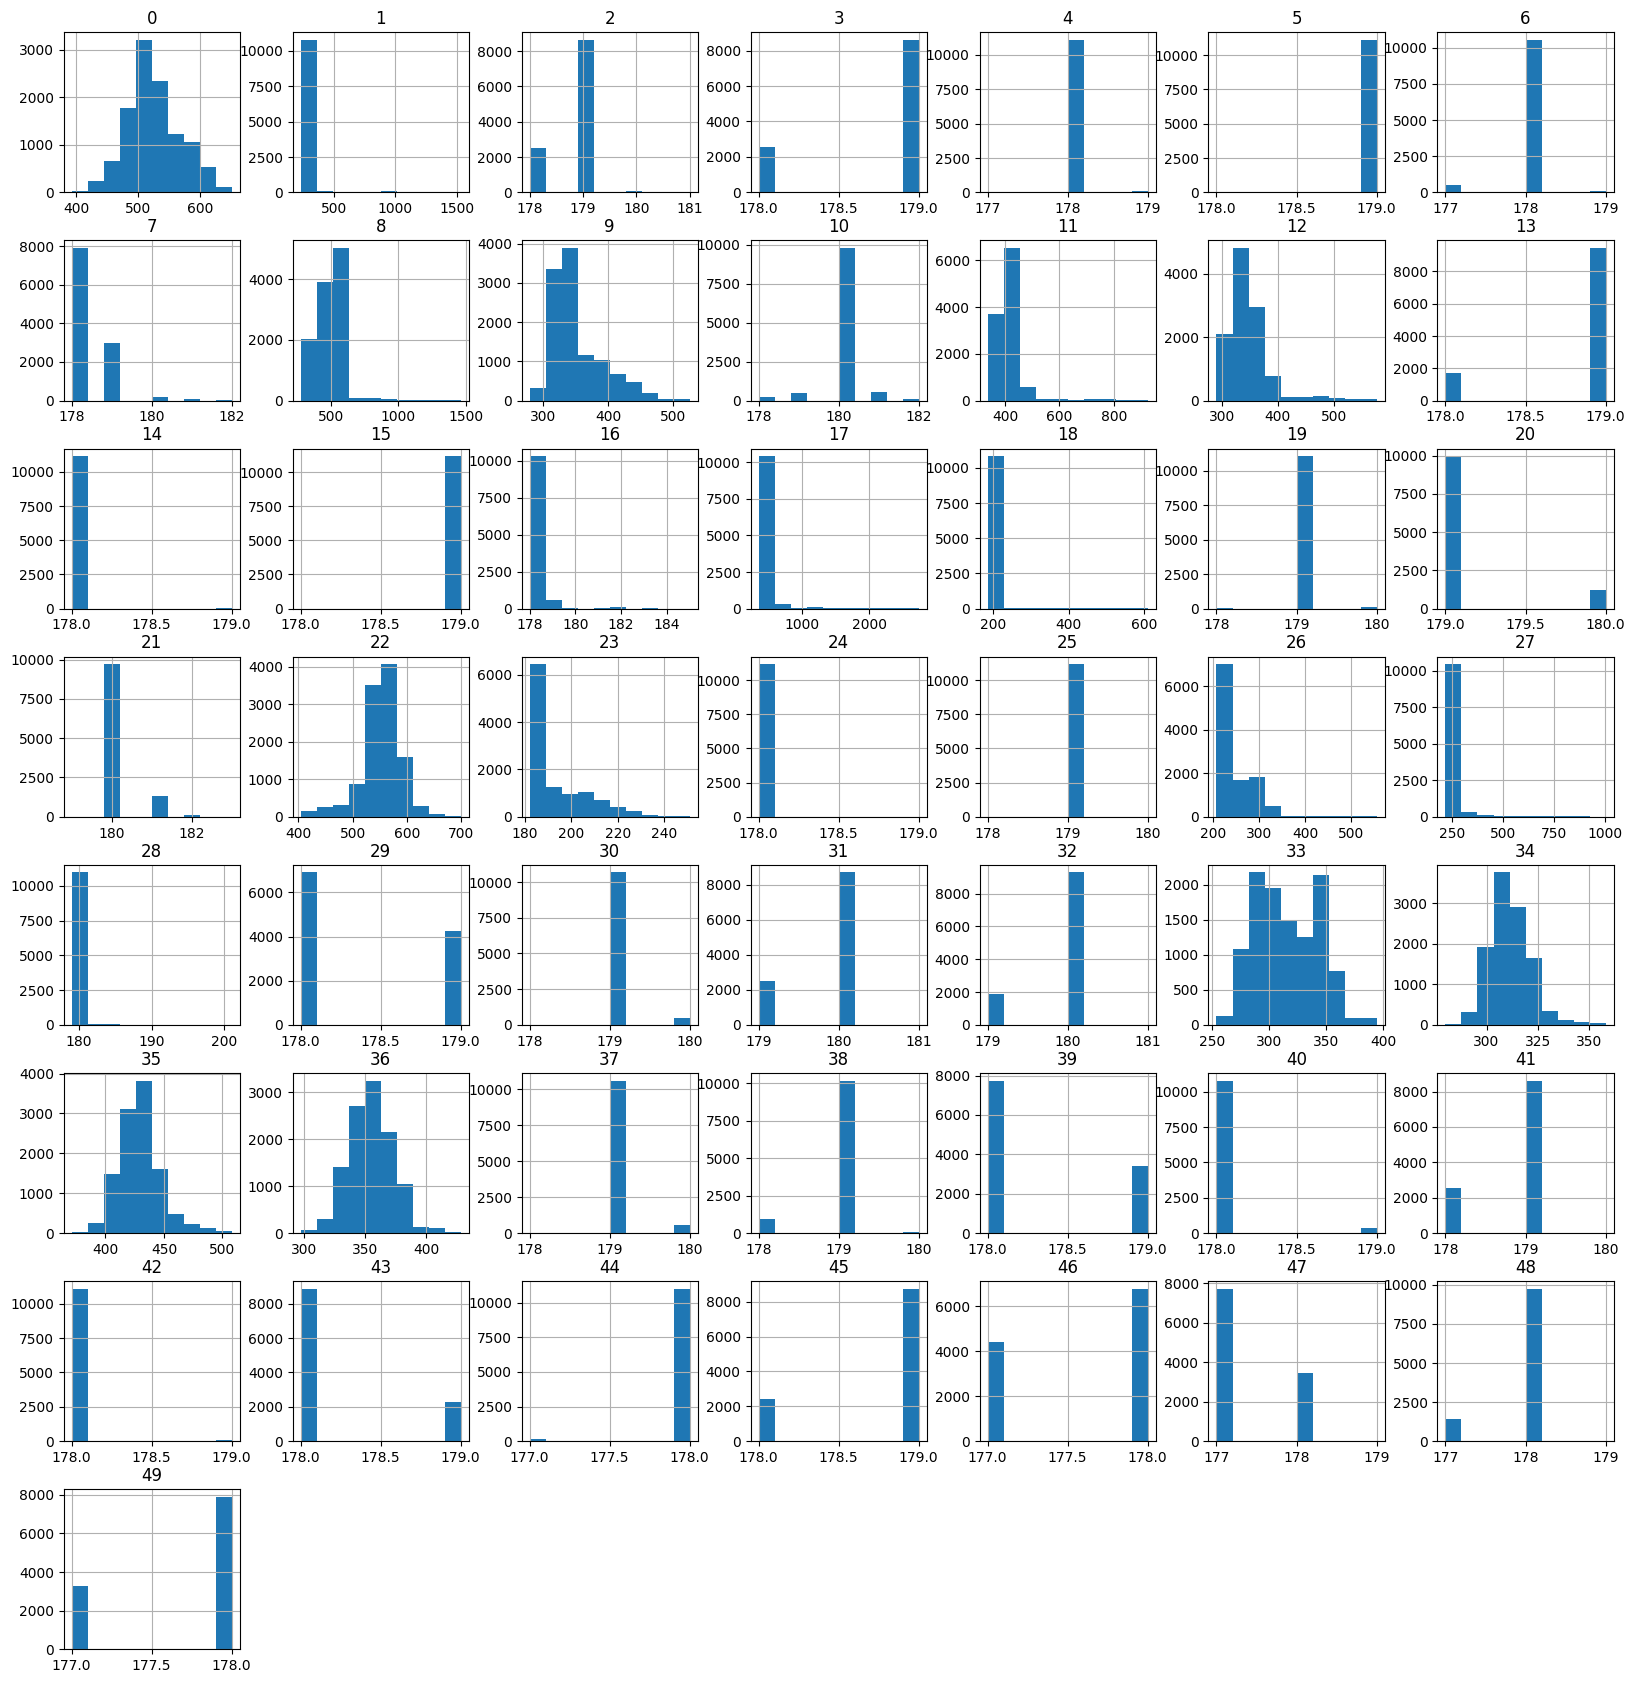

In [555]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [556]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11168.00  11168.00  11168.00  11168.00  11168.00  11168.00  11168.00   
mean     524.28    293.07    178.78    178.77    178.01    178.99    177.96   
std       42.65    109.69      0.42      0.42      0.09      0.07      0.24   
min      393.00    227.00    178.00    178.00    177.00    178.00    177.00   
25%      497.00    265.00    179.00    179.00    178.00    179.00    178.00   
50%      519.00    276.00    179.00    179.00    178.00    179.00    178.00   
75%      550.00    287.00    179.00    179.00    178.00    179.00    178.00   
max      651.00   1532.00    181.00    179.00    179.00    179.00    179.00   

              7         8         9  ...        40        41        42  \
count  11168.00  11168.00  11168.00  ...  11168.00  11168.00  11168.00   
mean     178.33    491.64    350.86  ...    178.03    178.77    178.01   
std        0.55     95.01     39.53  ...      0.18      0.42      0.08   
min      178.00    278.00    279.00  ...    178.00    178.00    178.00   
25%      178.00    425.00    324.00  ...    178.00    179.00    178.00   
50%      178.00    511.00    338.00  ...    178.00    179.00    178.00   
75%      179.00    545.00    368.00  ...    178.00    179.00    178.00   
max      182.00   1459.00    526.00  ...    179.00    180.00    179.00   

             43        44        45        46        47        48        49  
count  11168.00  11168.00  11168.00  11168.00  11168.00  11168.00  11168.00  
mean     178.21    177.99    178.78    177.61    177.31    177.87    177.71  
std        0.40      0.12      0.41      0.49      0.46      0.33      0.45  
min      178.00    177.00    178.00    177.00    177.00    177.00    177.00  
25%      178.00    178.00    179.00    177.00    177.00    178.00    177.00  
50%      178.00    178.00    179.00    178.00    177.00    178.00    178.00  
75%      178.00    178.00    179.00    178.00    178.00    178.00    178.00  
max      179.00    178.00    179.00    178.00    179.00    179.00    178.00  

[8 rows x 50 columns]

In [557]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [558]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

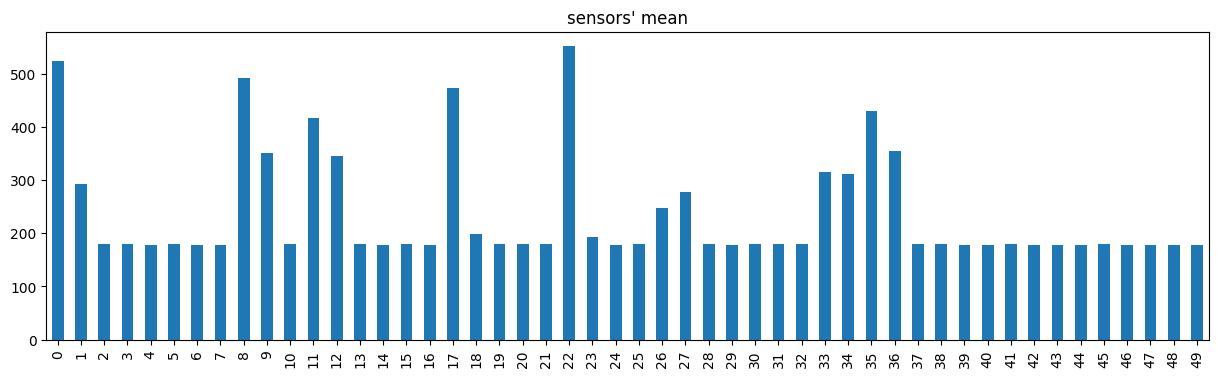

In [559]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [560]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [561]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [562]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [563]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [564]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [565]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.604; 0.578\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [566]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [567]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [568]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '23', '26', '27', '33', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [569]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [570]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5674, 18), (5674,)) 
 test: ((5494, 18), (5494,))


### **Model Learning**

#### Random Forest

In [571]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [572]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.909
accuracy: 0.909


In [573]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3393
        Open      1.000     1.000     1.000       457
      Pistol      1.000     1.000     1.000       457
       Thumb      1.000     1.000     1.000       456
          OK      1.000     1.000     1.000       456
        Grab      1.000     1.000     1.000       455

    accuracy                          1.000      5674
   macro avg      1.000     1.000     1.000      5674
weighted avg      1.000     1.000     1.000      5674

              precision    recall  f1-score   support

     Neutral      0.947     0.964     0.955      3211
        Open      0.788     0.795     0.791       458
      Pistol      0.855     0.891     0.872       457
       Thumb      0.861     0.776     0.817       456
          OK      0.878     0.912     0.895       457
        Grab      0.887     0.780     0.830       455

    accuracy                          0.909      5494
   macro avg      0.869

In [574]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.946789    0.787879    0.855042    0.861314    0.877895   
recall        0.964186    0.794760    0.890591    0.776316    0.912473   
f1-score      0.955408    0.791304    0.872454    0.816609    0.894850   
support    3211.000000  458.000000  457.000000  456.000000  457.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.887500   0.90881     0.869403      0.908175  
recall       0.780220   0.90881     0.853091      0.908810  
f1-score     0.830409   0.90881     0.860173      0.907918  
support    455.000000   0.90881  5494.000000   5494.000000

In [575]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 27*

In [576]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

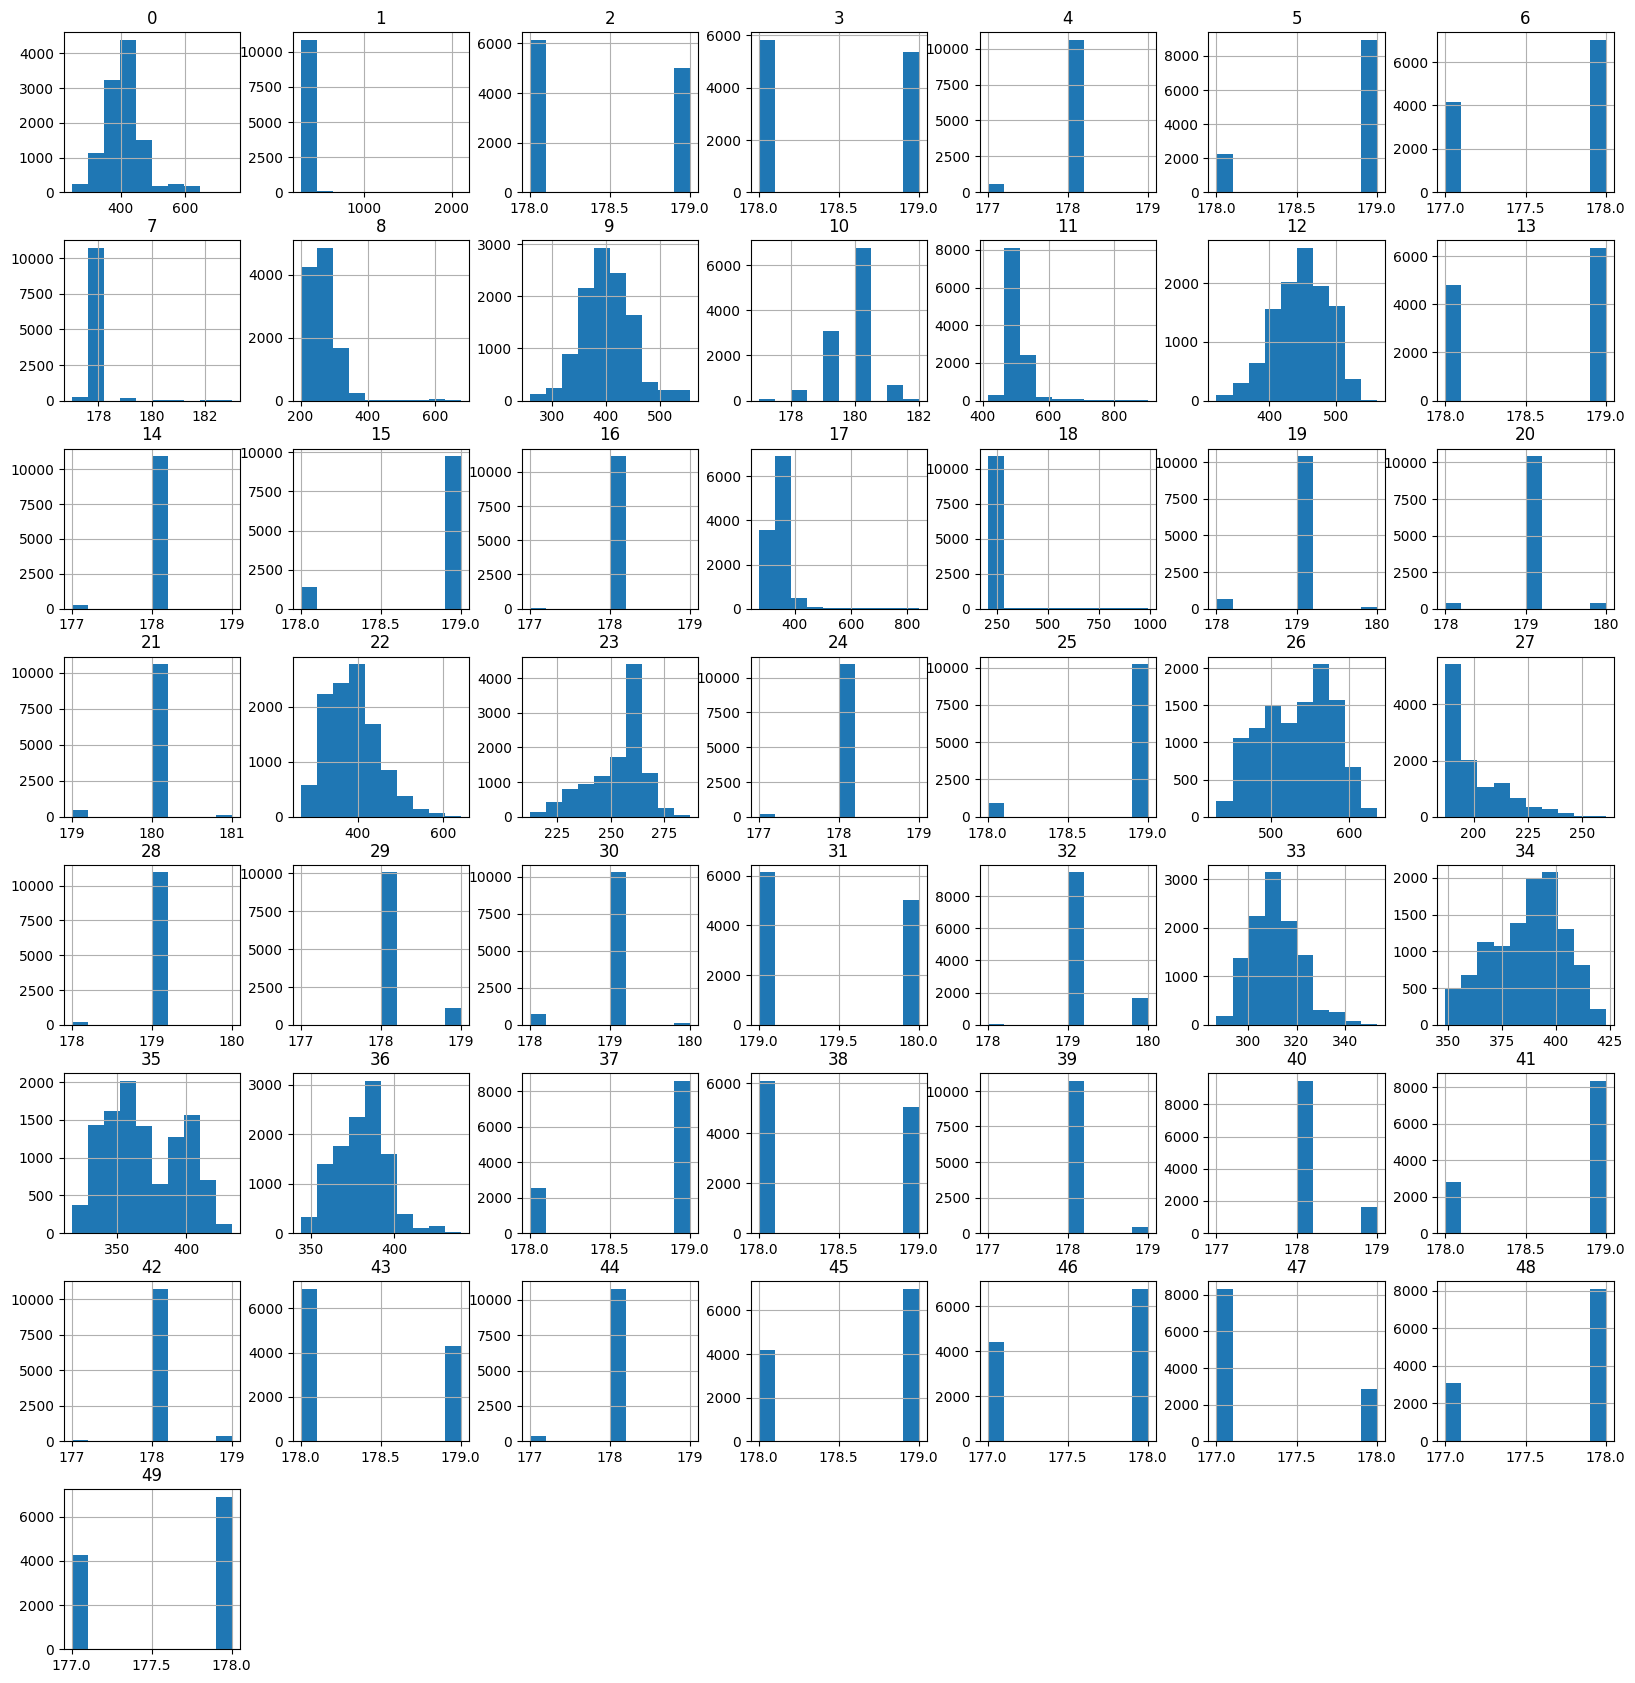

In [577]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [578]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4        5         6  \
count  11168.00  11168.00  11168.00  11168.00  11168.00  11168.0  11168.00   
mean     409.10    368.92    178.45    178.48    177.95    178.8    177.63   
std       59.86    129.64      0.50      0.50      0.22      0.4      0.48   
min      249.00    266.00    178.00    178.00    177.00    178.0    177.00   
25%      369.00    332.00    178.00    178.00    178.00    179.0    177.00   
50%      408.00    354.00    178.00    178.00    178.00    179.0    178.00   
75%      439.00    373.00    179.00    179.00    178.00    179.0    178.00   
max      743.00   2105.00    179.00    179.00    179.00    179.0    178.00   

              7         8         9  ...        40        41        42  \
count  11168.00  11168.00  11168.00  ...  11168.00  11168.00  11168.00   
mean     178.01    268.33    401.08  ...    178.14    178.75    178.03   
std        0.27     48.16     46.98  ...      0.36      0.43      0.19   
min      177.00    200.00    259.00  ...    177.00    178.00    177.00   
25%      178.00    236.00    371.00  ...    178.00    178.00    178.00   
50%      178.00    264.00    399.00  ...    178.00    179.00    178.00   
75%      178.00    286.00    432.00  ...    178.00    179.00    178.00   
max      183.00    677.00    555.00  ...    179.00    179.00    179.00   

             43        44        45        46        47        48        49  
count  11168.00  11168.00  11168.00  11168.00  11168.00  11168.00  11168.00  
mean     178.38    177.97    178.63    177.61    177.25    177.73    177.62  
std        0.49      0.18      0.48      0.49      0.44      0.45      0.49  
min      178.00    177.00    178.00    177.00    177.00    177.00    177.00  
25%      178.00    178.00    178.00    177.00    177.00    177.00    177.00  
50%      178.00    178.00    179.00    178.00    177.00    178.00    178.00  
75%      179.00    178.00    179.00    178.00    178.00    178.00    178.00  
max      179.00    179.00    179.00    178.00    178.00    178.00    178.00  

[8 rows x 50 columns]

In [579]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [580]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

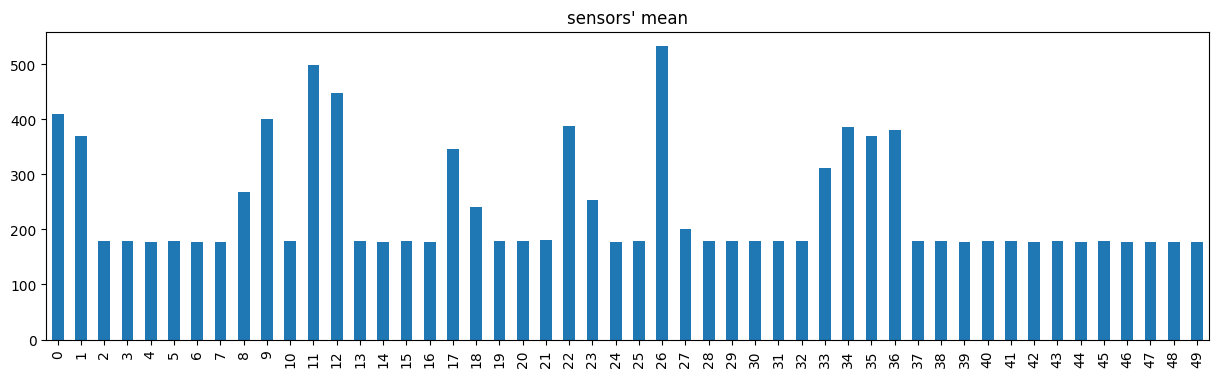

In [581]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [582]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [583]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [584]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [585]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [586]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [587]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.604; 0.579\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [588]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [589]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [590]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '23', '26', '27', '33', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [591]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [592]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5675, 18), (5675,)) 
 test: ((5493, 18), (5493,))


### **Model Learning**

#### Random Forest

In [593]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [594]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.939
accuracy: 0.939


In [595]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3393
        Open      1.000     1.000     1.000       457
      Pistol      1.000     1.000     1.000       455
       Thumb      1.000     1.000     1.000       456
          OK      1.000     1.000     1.000       457
        Grab      1.000     1.000     1.000       457

    accuracy                          1.000      5675
   macro avg      1.000     1.000     1.000      5675
weighted avg      1.000     1.000     1.000      5675

              precision    recall  f1-score   support

     Neutral      0.940     0.969     0.954      3210
        Open      0.880     0.945     0.911       456
      Pistol      0.972     0.748     0.845       460
       Thumb      0.934     0.903     0.918       455
          OK      0.948     0.960     0.954       455
        Grab      0.962     0.930     0.945       457

    accuracy                          0.939      5493
   macro avg      0.939

In [596]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.940411    0.879592    0.971751    0.934091    0.947939   
recall        0.968536    0.945175    0.747826    0.903297    0.960440   
f1-score      0.954266    0.911205    0.845209    0.918436    0.954148   
support    3210.000000  456.000000  460.000000  455.000000  455.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.961538  0.938831     0.939221      0.939845  
recall       0.929978  0.938831     0.909209      0.938831  
f1-score     0.945495  0.938831     0.921460      0.937851  
support    457.000000  0.938831  5493.000000   5493.000000

In [597]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 28*

In [598]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

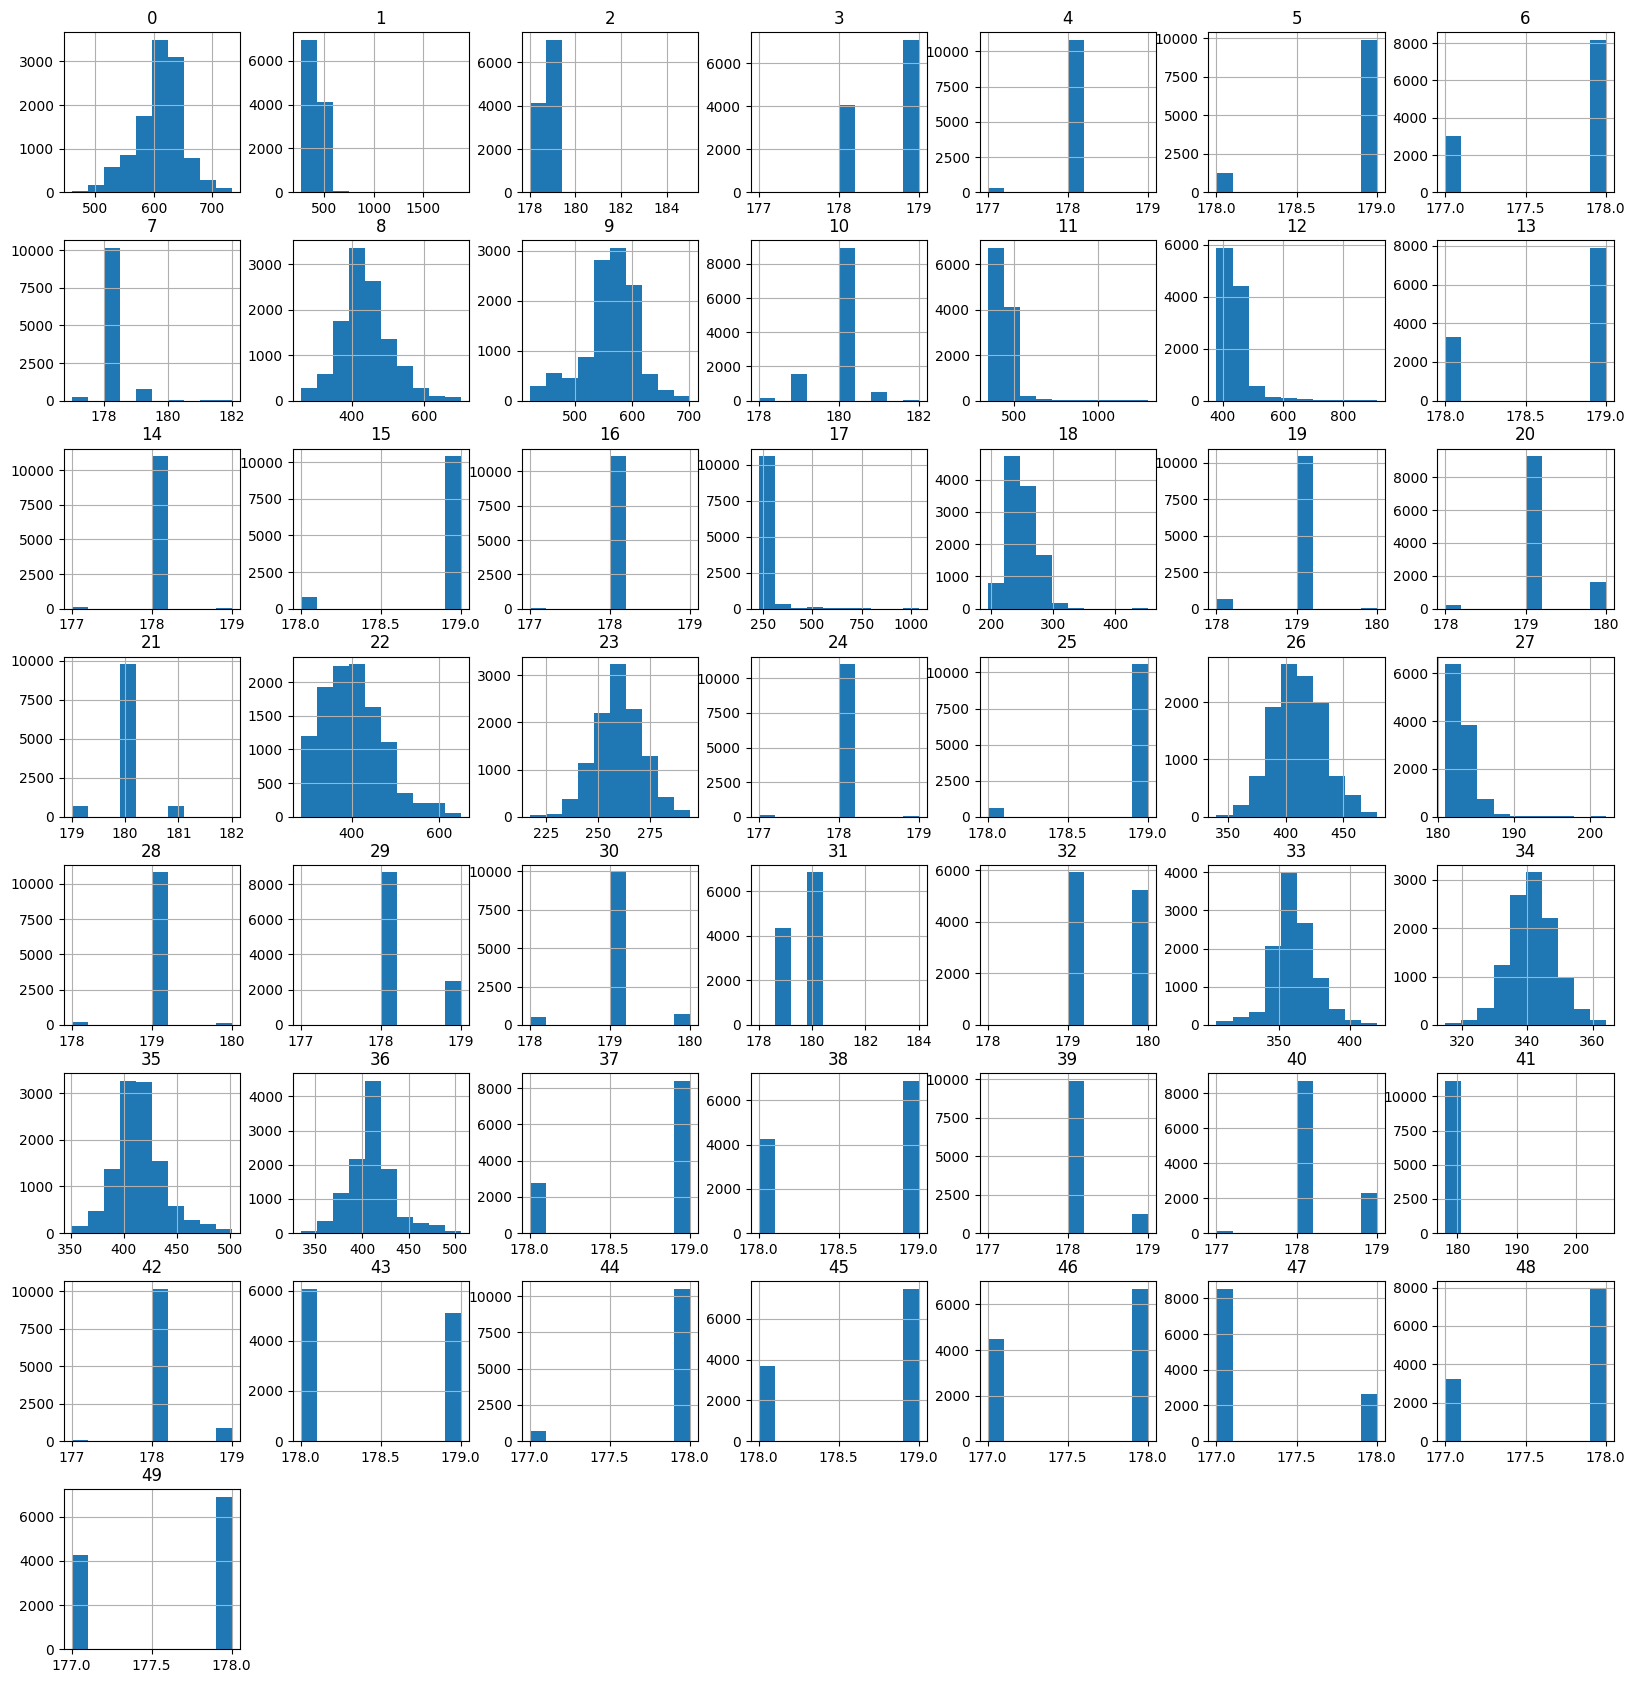

In [599]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [600]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00   
mean     609.63    412.17    178.64    178.64    177.98    178.89    177.73   
std       39.89     80.39      0.51      0.48      0.18      0.32      0.44   
min      460.00    258.00    178.00    177.00    177.00    178.00    177.00   
25%      589.00    379.00    178.00    178.00    178.00    179.00    177.00   
50%      614.00    407.00    179.00    179.00    178.00    179.00    178.00   
75%      634.00    444.00    179.00    179.00    178.00    179.00    178.00   
max      733.00   1885.00    185.00    179.00    179.00    179.00    178.00   

              7         8         9  ...        40        41        42  \
count  11169.00  11169.00  11169.00  ...  11169.00  11169.00  11169.00   
mean     178.05    436.54    561.44  ...    178.20    178.74    178.07   
std        0.31     69.14     46.78  ...      0.42      0.51      0.29   
min      177.00    259.00    421.00  ...    177.00    178.00    177.00   
25%      178.00    395.00    541.00  ...    178.00    178.00    178.00   
50%      178.00    431.00    566.00  ...    178.00    179.00    178.00   
75%      178.00    472.00    593.00  ...    178.00    179.00    178.00   
max      182.00    701.00    701.00  ...    179.00    205.00    179.00   

             43        44        45        46        47        48        49  
count  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00  11169.00  
mean     178.46    177.94    178.67    177.60    177.24    177.71    177.62  
std        0.50      0.24      0.47      0.49      0.42      0.45      0.49  
min      178.00    177.00    178.00    177.00    177.00    177.00    177.00  
25%      178.00    178.00    178.00    177.00    177.00    177.00    177.00  
50%      178.00    178.00    179.00    178.00    177.00    178.00    178.00  
75%      179.00    178.00    179.00    178.00    177.00    178.00    178.00  
max      179.00    178.00    179.00    178.00    178.00    178.00    178.00  

[8 rows x 50 columns]

In [601]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [602]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

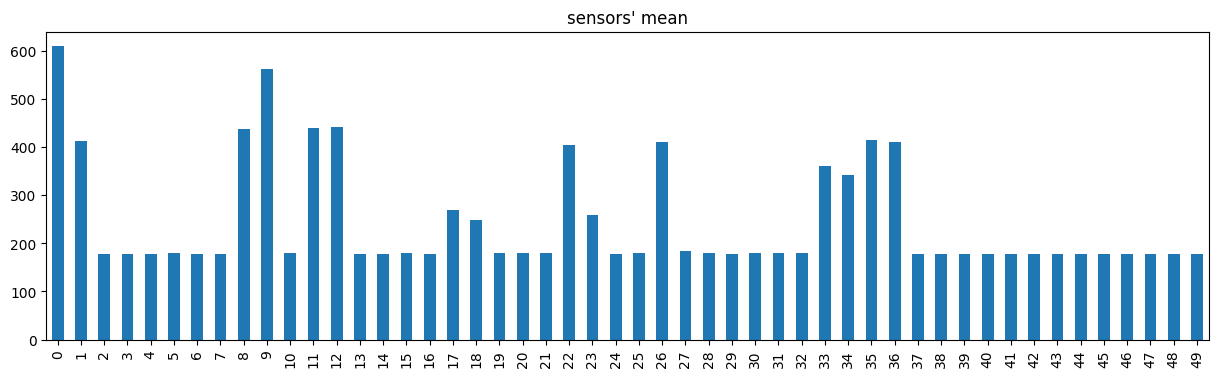

In [603]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [604]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [605]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [606]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [607]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [608]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [609]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.605; 0.579\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [610]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [611]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [612]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '23', '26', '33', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [613]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [614]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5675, 16), (5675,)) 
 test: ((5494, 16), (5494,))


### **Model Learning**

#### Random Forest

In [615]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [616]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.929
accuracy: 0.929


In [617]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3392
        Open      1.000     1.000     1.000       457
      Pistol      1.000     1.000     1.000       456
       Thumb      1.000     1.000     1.000       456
          OK      1.000     1.000     1.000       458
        Grab      1.000     1.000     1.000       456

    accuracy                          1.000      5675
   macro avg      1.000     1.000     1.000      5675
weighted avg      1.000     1.000     1.000      5675

              precision    recall  f1-score   support

     Neutral      0.943     0.971     0.957      3208
        Open      0.914     0.792     0.848       456
      Pistol      0.910     0.794     0.848       457
       Thumb      0.947     0.941     0.944       457
          OK      0.961     0.913     0.936       458
        Grab      0.819     0.906     0.860       458

    accuracy                          0.929      5494
   macro avg      0.916

In [618]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.943099    0.913924    0.909774    0.947137    0.960920   
recall        0.971322    0.791667    0.794311    0.940919    0.912664   
f1-score      0.957002    0.848414    0.848131    0.944018    0.936170   
support    3208.000000  456.000000  457.000000  457.000000  458.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.818540  0.928831     0.915566      0.929343  
recall       0.906114  0.928831     0.886166      0.928831  
f1-score     0.860104  0.928831     0.898973      0.928039  
support    458.000000  0.928831  5494.000000   5494.000000

In [619]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 29*

In [620]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

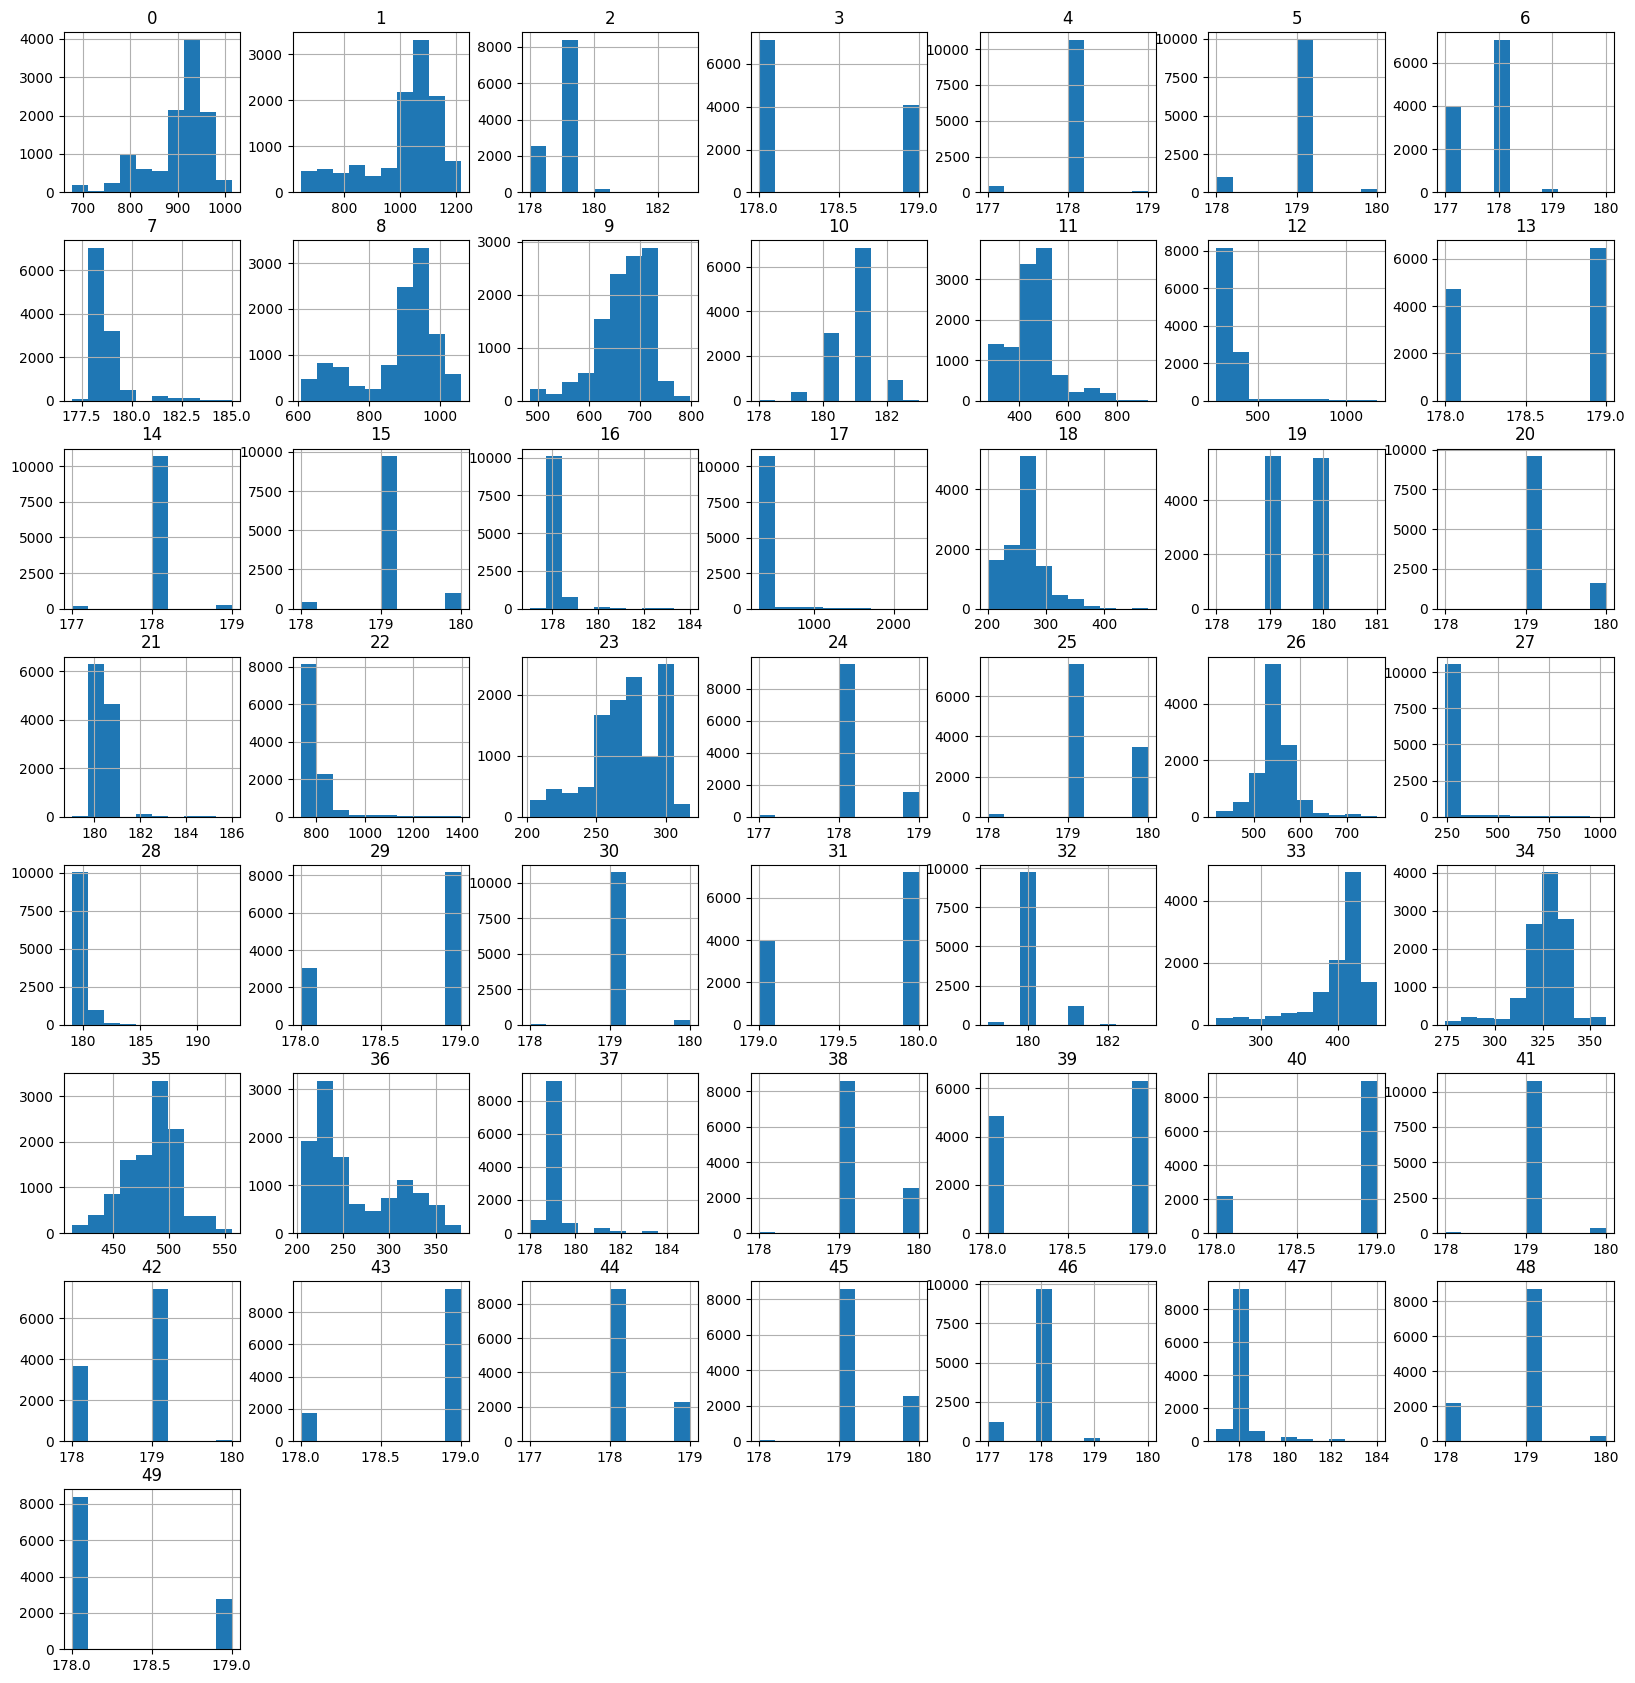

In [621]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [622]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11173.00  11173.00  11173.00  11173.00  11173.00  11173.00  11173.00   
mean     902.06   1013.65    178.81    178.36    177.97    178.93    177.66   
std       62.38    133.48      0.51      0.48      0.22      0.33      0.50   
min      677.00    645.00    178.00    178.00    177.00    178.00    177.00   
25%      885.00    983.00    179.00    178.00    178.00    179.00    177.00   
50%      920.00   1053.00    179.00    178.00    178.00    179.00    178.00   
75%      942.00   1102.00    179.00    179.00    178.00    179.00    178.00   
max     1014.00   1217.00    183.00    179.00    179.00    180.00    180.00   

              7         8         9  ...       40        41        42  \
count  11173.00  11173.00  11173.00  ...  11173.0  11173.00  11173.00   
mean     178.51    884.13    668.38  ...    178.8    179.02    178.68   
std        0.90    109.35     50.83  ...      0.4      0.19      0.48   
min      177.00    606.00    483.00  ...    178.0    178.00    178.00   
25%      178.00    852.00    640.00  ...    179.0    179.00    178.00   
50%      178.00    920.00    678.00  ...    179.0    179.00    179.00   
75%      179.00    955.00    705.00  ...    179.0    179.00    179.00   
max      185.00   1058.00    797.00  ...    179.0    180.00    180.00   

             43        44        45        46        47        48        49  
count  11173.00  11173.00  11173.00  11173.00  11173.00  11173.00  11173.00  
mean     178.85    178.21    179.22    177.92    178.12    178.83    178.25  
std        0.36      0.40      0.43      0.36      0.73      0.44      0.43  
min      178.00    177.00    178.00    177.00    177.00    178.00    178.00  
25%      179.00    178.00    179.00    178.00    178.00    179.00    178.00  
50%      179.00    178.00    179.00    178.00    178.00    179.00    178.00  
75%      179.00    178.00    179.00    178.00    178.00    179.00    178.00  
max      179.00    179.00    180.00    180.00    184.00    180.00    179.00  

[8 rows x 50 columns]

In [623]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [624]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

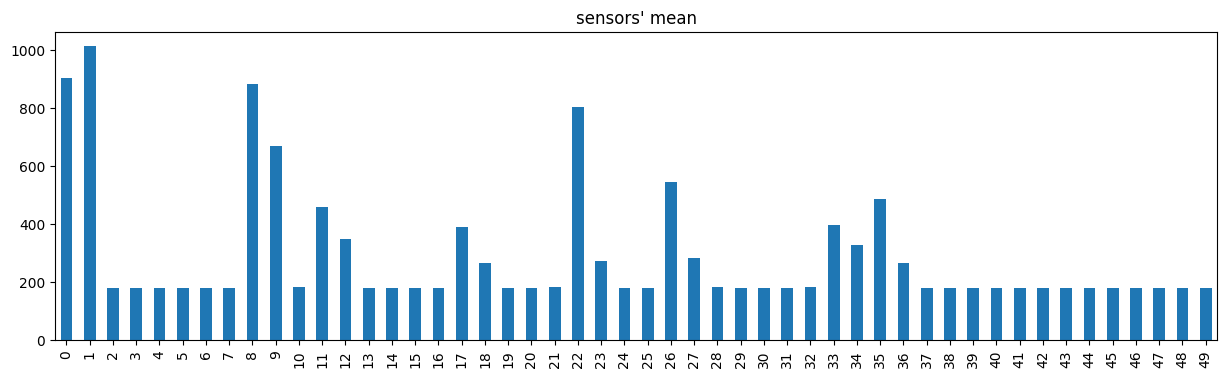

In [625]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [626]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [627]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [628]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [629]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [630]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [631]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.604; 0.58\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [632]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [633]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [634]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '23', '26', '27', '33', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [635]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [636]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5677, 18), (5677,)) 
 test: ((5496, 18), (5496,))


### **Model Learning**

#### Random Forest

In [637]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [638]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.943
accuracy: 0.943


In [639]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3392
        Open      1.000     1.000     1.000       458
      Pistol      1.000     1.000     1.000       456
       Thumb      1.000     1.000     1.000       456
          OK      1.000     1.000     1.000       457
        Grab      1.000     1.000     1.000       458

    accuracy                          1.000      5677
   macro avg      1.000     1.000     1.000      5677
weighted avg      1.000     1.000     1.000      5677

              precision    recall  f1-score   support

     Neutral      0.946     0.973     0.960      3209
        Open      0.910     0.926     0.918       458
      Pistol      0.947     0.902     0.924       458
       Thumb      0.946     0.923     0.935       456
          OK      0.948     0.912     0.930       457
        Grab      0.944     0.843     0.890       458

    accuracy                          0.943      5496
   macro avg      0.940

In [640]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.946364    0.909871    0.947248    0.946067    0.947727   
recall        0.973200    0.925764    0.901747    0.923246    0.912473   
f1-score      0.959594    0.917749    0.923937    0.934517    0.929766   
support    3209.000000  458.000000  458.000000  456.000000  457.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.943765  0.943231     0.940174      0.943269  
recall       0.842795  0.943231     0.913204      0.943231  
f1-score     0.890427  0.943231     0.925998      0.942811  
support    458.000000  0.943231  5496.000000   5496.000000

In [641]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 30*

In [642]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

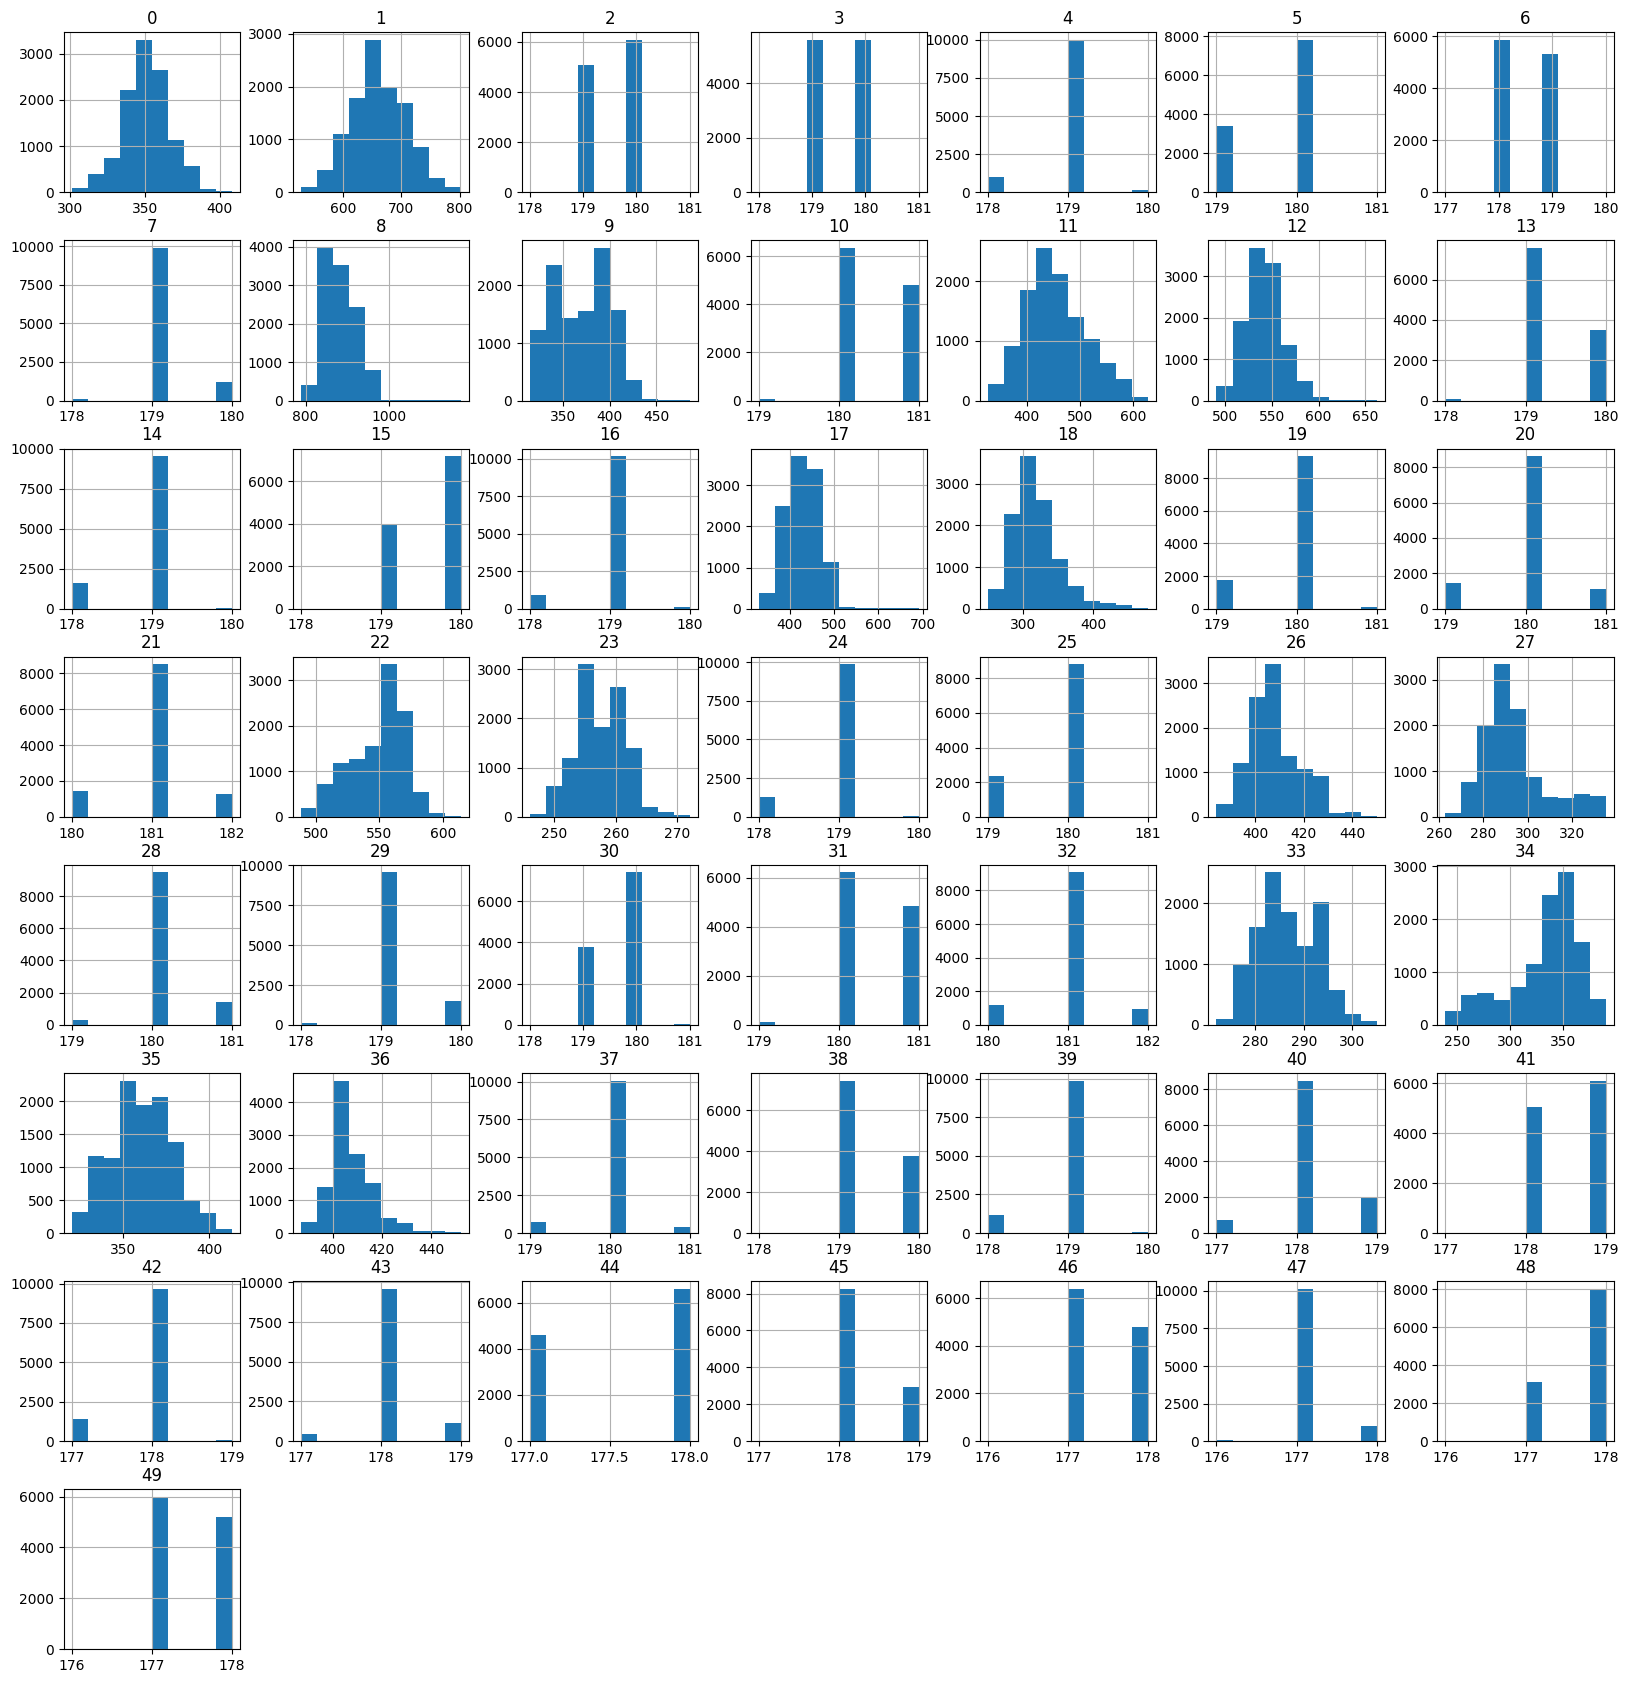

In [643]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [644]:
gestures.iloc[:, :50].describe().round(2)

0         1         2        3         4         5         6  \
count  11182.00  11182.00  11182.00  11182.0  11182.00  11182.00  11182.00   
mean     350.90    659.79    179.54    179.5    178.92    179.70    178.48   
std       15.57     46.77      0.50      0.5      0.32      0.46      0.50   
min      301.00    527.00    178.00    178.0    178.00    179.00    177.00   
25%      341.00    629.00    179.00    179.0    179.00    179.00    178.00   
50%      351.00    658.00    180.00    179.0    179.00    180.00    178.00   
75%      360.00    693.00    180.00    180.0    179.00    180.00    179.00   
max      408.00    802.00    181.00    181.0    180.00    181.00    180.00   

              7         8         9  ...        40        41        42  \
count  11182.00  11182.00  11182.00  ...  11182.00  11182.00  11182.00   
mean     179.10    882.44    369.87  ...    178.11    178.55    177.88   
std        0.33     37.89     29.63  ...      0.48      0.50      0.35   
min      178.00    788.00    314.00  ...    177.00    177.00    177.00   
25%      179.00    853.00    342.00  ...    178.00    178.00    178.00   
50%      179.00    876.00    372.00  ...    178.00    179.00    178.00   
75%      179.00    910.00    395.00  ...    178.00    179.00    178.00   
max      180.00   1173.00    486.00  ...    179.00    179.00    179.00   

             43        44        45        46        47        48        49  
count  11182.00  11182.00  11182.00  11182.00  11182.00  11182.00  11182.00  
mean     178.06    177.59    178.26    177.43    177.08    177.72    177.46  
std        0.37      0.49      0.44      0.50      0.29      0.45      0.50  
min      177.00    177.00    177.00    176.00    176.00    176.00    176.00  
25%      178.00    177.00    178.00    177.00    177.00    177.00    177.00  
50%      178.00    178.00    178.00    177.00    177.00    178.00    177.00  
75%      178.00    178.00    179.00    178.00    177.00    178.00    178.00  
max      179.00    178.00    179.00    178.00    178.00    178.00    178.00  

[8 rows x 50 columns]

In [645]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [646]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

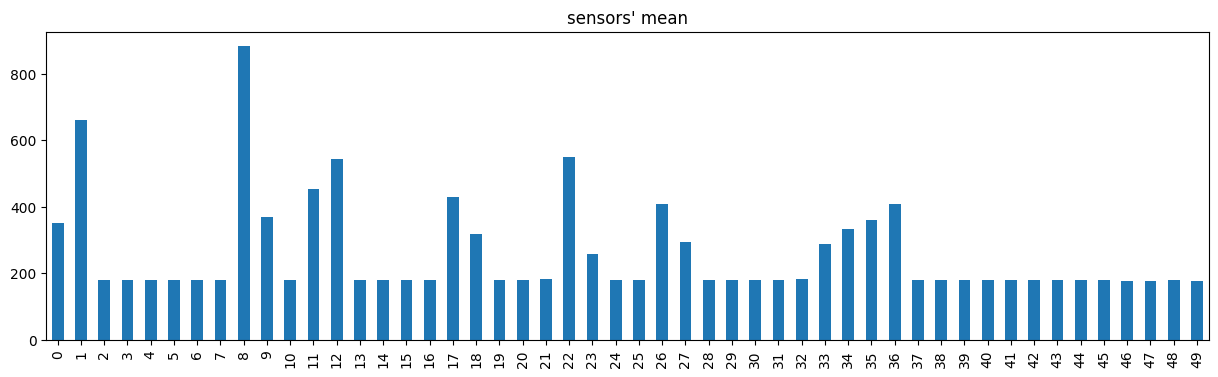

In [647]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [648]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [649]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [650]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [651]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [652]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [653]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.603; 0.586\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [654]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [655]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [656]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [657]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [658]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5681, 14), (5681,)) 
 test: ((5501, 14), (5501,))


### **Model Learning**

#### Random Forest

In [659]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [660]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.932
accuracy: 0.932


In [661]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3393
        Open      1.000     1.000     1.000       457
      Pistol      1.000     1.000     1.000       457
       Thumb      1.000     1.000     1.000       458
          OK      1.000     1.000     1.000       458
        Grab      1.000     1.000     1.000       458

    accuracy                          1.000      5681
   macro avg      1.000     1.000     1.000      5681
weighted avg      1.000     1.000     1.000      5681

              precision    recall  f1-score   support

     Neutral      0.935     0.975     0.954      3214
        Open      0.959     0.877     0.916       456
      Pistol      0.927     0.886     0.906       458
       Thumb      0.932     0.753     0.833       458
          OK      0.901     0.919     0.910       458
        Grab      0.926     0.928     0.927       457

    accuracy                          0.932      5501
   macro avg      0.930

In [662]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.934945    0.959233    0.926941    0.932432    0.901499   
recall        0.974798    0.877193    0.886463    0.753275    0.919214   
f1-score      0.954455    0.916380    0.906250    0.833333    0.910270   
support    3214.000000  456.000000  458.000000  458.000000  458.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.925764  0.932376     0.930136      0.932535  
recall       0.927790  0.932376     0.889789      0.932376  
f1-score     0.926776  0.932376     0.907911      0.931223  
support    457.000000  0.932376  5501.000000   5501.000000

In [663]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

##### *Palm File 31*

In [664]:
gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               file_number=next(n))

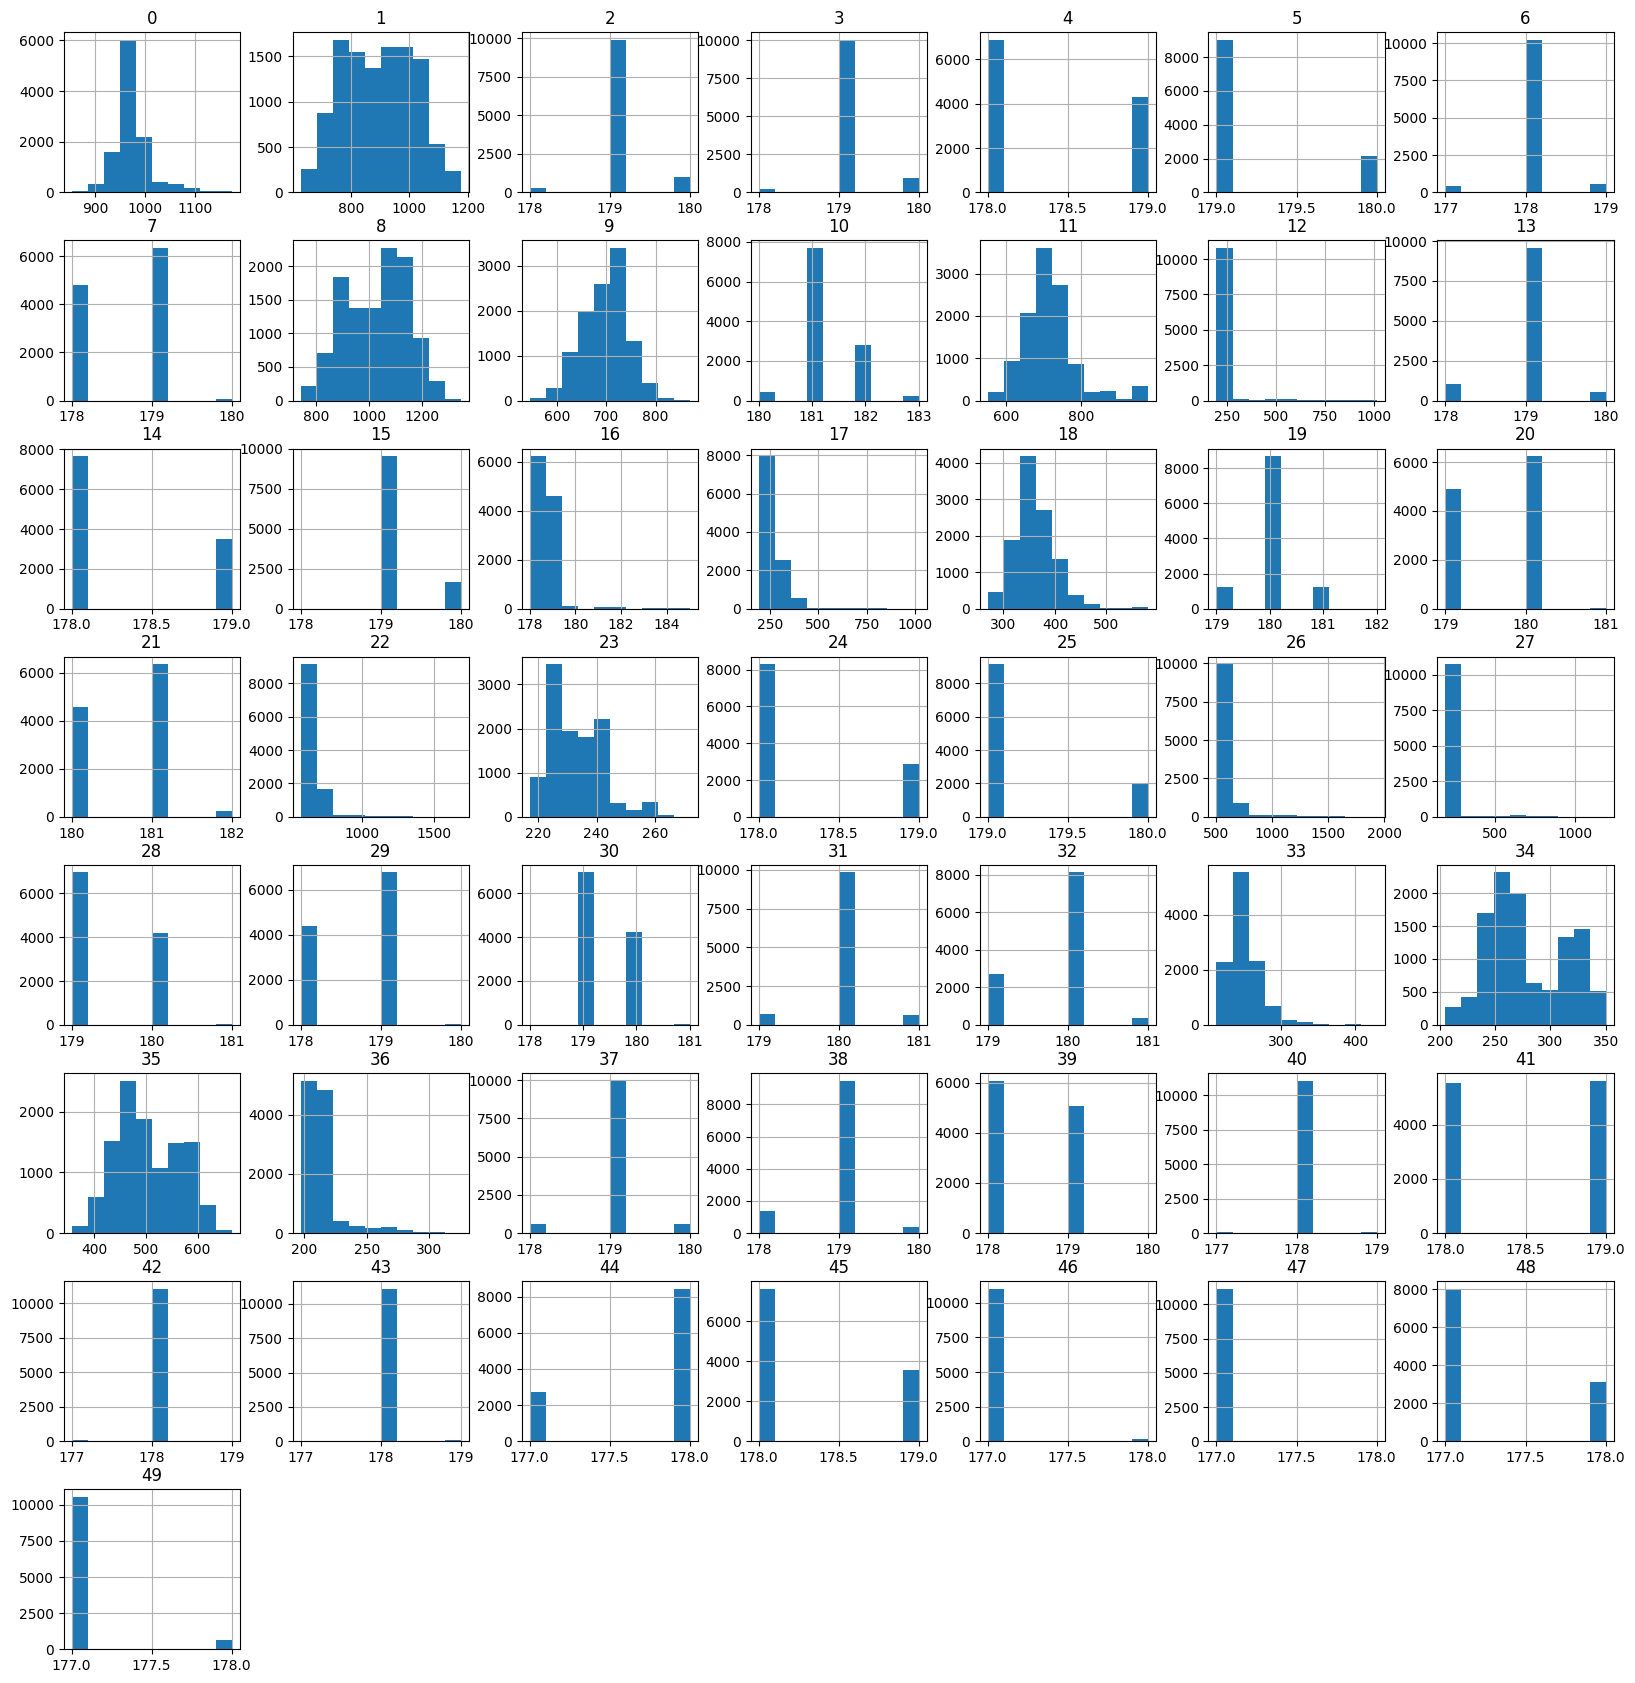

In [665]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [666]:
gestures.iloc[:, :50].describe().round(2)

0         1         2         3         4         5         6  \
count  11174.00  11174.00  11174.00  11174.00  11174.00  11174.00  11174.00   
mean     973.07    894.60    179.07    179.06    178.38    179.19    178.01   
std       36.22    120.16      0.33      0.31      0.49      0.40      0.29   
min      852.00    628.00    178.00    178.00    178.00    179.00    177.00   
25%      956.00    792.00    179.00    179.00    178.00    179.00    178.00   
50%      968.00    894.00    179.00    179.00    178.00    179.00    178.00   
75%      983.00    991.00    179.00    179.00    179.00    179.00    178.00   
max     1174.00   1176.00    180.00    180.00    179.00    180.00    179.00   

              7         8         9  ...        40       41        42  \
count  11174.00  11174.00  11174.00  ...  11174.00  11174.0  11174.00   
mean     178.58   1028.99    697.49  ...    178.00    178.5    177.99   
std        0.50    117.53     45.30  ...      0.09      0.5      0.10   
min      178.00    743.00    545.00  ...    177.00    178.0    177.00   
25%      178.00    926.00    664.00  ...    178.00    178.0    178.00   
50%      179.00   1047.00    703.00  ...    178.00    179.0    178.00   
75%      179.00   1120.00    727.00  ...    178.00    179.0    178.00   
max      180.00   1347.00    869.00  ...    179.00    179.0    179.00   

             43        44        45        46        47        48        49  
count  11174.00  11174.00  11174.00  11174.00  11174.00  11174.00  11174.00  
mean     178.01    177.75    178.32    177.01    177.00    177.28    177.06  
std        0.07      0.43      0.47      0.12      0.05      0.45      0.23  
min      177.00    177.00    178.00    177.00    177.00    177.00    177.00  
25%      178.00    178.00    178.00    177.00    177.00    177.00    177.00  
50%      178.00    178.00    178.00    177.00    177.00    177.00    177.00  
75%      178.00    178.00    179.00    177.00    177.00    178.00    177.00  
max      179.00    178.00    179.00    178.00    178.00    178.00    178.00  

[8 rows x 50 columns]

In [667]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [668]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

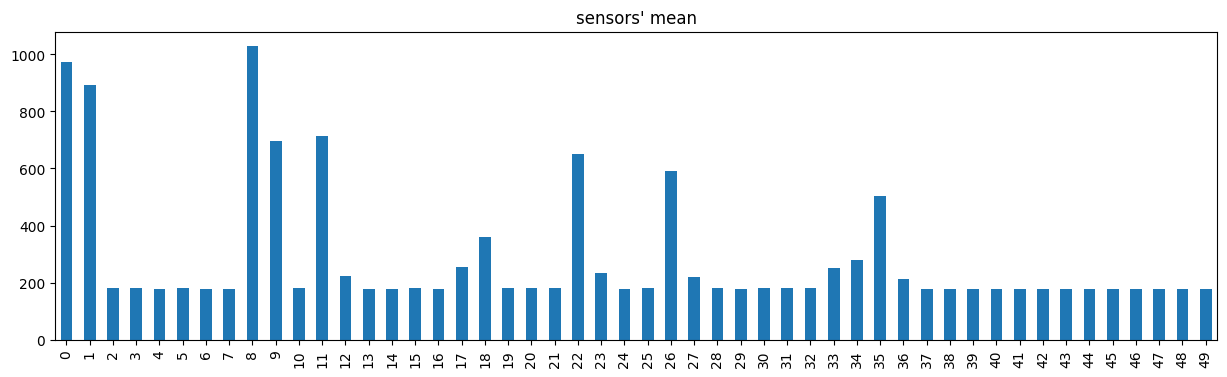

In [669]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [670]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [671]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [672]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [673]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

#### Shift Function

In [674]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [675]:
#display
summary

['Оптимальные свдиги для концевых выборок:   1 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.603; 0.581\n',
 'Размер оптимального сдвига (как среднего): 1']

#### Noise / Inactive Sensors

In [676]:
#assign variables
gestures['y_cmd'] = y
data = gestures

In [677]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns[:-1]

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [678]:
#remove inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
data = data[working_sensors + ['y_cmd']]
print(f"Used Sensors: {working_sensors}")

Used Sensors: ['0', '1', '8', '9', '11', '12', '17', '18', '22', '26', '27', '33', '34', '35', '36', 'SYNC', 'ts']


### **Train-Test Split**

In [679]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [680]:
#select the features for train
X_train = data[working_sensors].values[:last_train_idx]
y_train = data['y_cmd'][:last_train_idx]

#select the features for test
X_test = data[working_sensors].values[last_train_idx:]
y_test = data['y_cmd'][last_train_idx:]

#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((5677, 17), (5677,)) 
 test: ((5497, 17), (5497,))


### **Model Learning**

#### Random Forest

In [681]:
#create the object class
model = ensemble.RandomForestClassifier()

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [682]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 1.000
accuracy: 1.000

test data:
f1_score: 0.899
accuracy: 0.899


In [683]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      1.000     1.000     1.000      3392
        Open      1.000     1.000     1.000       458
      Pistol      1.000     1.000     1.000       457
       Thumb      1.000     1.000     1.000       455
          OK      1.000     1.000     1.000       458
        Grab      1.000     1.000     1.000       457

    accuracy                          1.000      5677
   macro avg      1.000     1.000     1.000      5677
weighted avg      1.000     1.000     1.000      5677

              precision    recall  f1-score   support

     Neutral      0.919     0.974     0.946      3212
        Open      0.899     0.702     0.789       457
      Pistol      0.946     0.724     0.820       457
       Thumb      0.867     0.796     0.830       457
          OK      0.883     0.914     0.899       456
        Grab      0.776     0.834     0.804       458

    accuracy                          0.899      5497
   macro avg      0.882

In [684]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

Neutral        Open      Pistol       Thumb          OK  \
precision     0.918673    0.899160    0.945714    0.866667    0.883475   
recall        0.974159    0.702407    0.724289    0.796499    0.914474   
f1-score      0.945603    0.788698    0.820322    0.830103    0.898707   
support    3212.000000  457.000000  457.000000  457.000000  456.000000   

                 Grab  accuracy    macro avg  weighted avg  
precision    0.776423    0.8994     0.881685      0.900203  
recall       0.834061    0.8994     0.824315      0.899400  
f1-score     0.804211    0.8994     0.847940      0.896870  
support    458.000000    0.8994  5497.000000   5497.000000

In [685]:
#add model results to the ordered dict
review['palm_file'].append(current_file)
review['model_name'].append(model.__class__.__name__)
review['learning_time'].append(model_time)
review['F1-Score, train'].append(round(metrics.f1_score(y_train, y_train_pred_rf, average="micro"), 3))
review['F1-Score, test'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average="micro"), 3))

review['F1-Score: Neutral'].append(test_rf.loc['f1-score'].iloc[0].round(3))
review['F1-Score: Open'].append(test_rf.loc['f1-score'].iloc[1].round(3))
review['F1-Score: Pistol'].append(test_rf.loc['f1-score'].iloc[2].round(3))
review['F1-Score: Thumb'].append(test_rf.loc['f1-score'].iloc[3].round(3))
review['F1-Score: OK'].append(test_rf.loc['f1-score'].iloc[4].round(3))
review['F1-Score: Grab'].append(test_rf.loc['f1-score'].iloc[5].round(3))

### **SUMMARY**

In [686]:
#write the results to a dataframe
review_summary = pd.DataFrame(review)
review_summary

palm_file              model_name  \
0                  2023-05-15_16-16-08.palm  RandomForestClassifier   
1                  2023-05-15_17-12-24.palm  RandomForestClassifier   
2                  2023-06-05_16-12-38.palm  RandomForestClassifier   
3                  2023-06-05_17-53-01.palm  RandomForestClassifier   
4                  2023-06-20_14-43-11.palm  RandomForestClassifier   
5                  2023-06-20_13-30-15.palm  RandomForestClassifier   
6                  2023-06-20_12-34-17.palm  RandomForestClassifier   
7                  2023-09-30_08-06-44.palm  RandomForestClassifier   
8                  2023-09-29_11-03-50.palm  RandomForestClassifier   
9                  2023-09-29_09-20-47.palm  RandomForestClassifier   
10                 2023-09-13_22-14-05.palm  RandomForestClassifier   
11                 2023-09-12_14-59-23.palm  RandomForestClassifier   
12                 2023-09-12_12-55-22.palm  RandomForestClassifier   
13                 2023-05-31_17-14-41.palm  RandomForestClassifier   
14                 2023-05-31_15-46-37.palm  RandomForestClassifier   
15                 2023-05-22_20-22-01.palm  RandomForestClassifier   
16                 2023-05-22_17-04-29.palm  RandomForestClassifier   
17                 2023-05-19_12-04-02.palm  RandomForestClassifier   
18  2023-04-18_19-08-47 gestures train.palm  RandomForestClassifier   
19                 2023-05-07_16-54-27.palm  RandomForestClassifier   
20                 2023-05-07_15-19-05.palm  RandomForestClassifier   
21                 2023-05-12_19-17-00.palm  RandomForestClassifier   
22                 2023-05-05_17-57-30.palm  RandomForestClassifier   
23                 2023-10-25_11-08-46.palm  RandomForestClassifier   
24         patched_2023-10-25_09-44-02.palm  RandomForestClassifier   
25                 2023-10-25_08-52-30.palm  RandomForestClassifier   
26                 2023-10-23_16-23-02.palm  RandomForestClassifier   
27                 2023-10-23_14-07-13.palm  RandomForestClassifier   
28                 2023-10-23_10-11-45.palm  RandomForestClassifier   
29                 2023-10-18_08-05-29.palm  RandomForestClassifier   
30                 2023-10-18_11-16-21.palm  RandomForestClassifier   

    learning_time  F1-Score, train  F1-Score, test  F1-Score: Neutral  \
0            9.65              1.0           0.968              0.987   
1           13.58              1.0           0.876              0.919   
2            8.47              1.0           0.946              0.974   
3            9.02              1.0           0.932              0.970   
4            8.96              1.0           0.949              0.975   
5            8.13              1.0           0.945              0.961   
6            8.90              1.0           0.959              0.975   
7            2.52              1.0           0.944              0.967   
8            2.43              1.0           0.952              0.968   
9            2.51              1.0           0.960              0.973   
10           1.02              1.0           0.922              0.951   
11           1.21              1.0           0.933              0.961   
12           1.04              1.0           0.933              0.959   
13           5.56              1.0           0.917              0.938   
14           6.65              1.0           0.932              0.950   
15           9.97              1.0           0.924              0.944   
16          18.66              1.0           0.948              0.959   
17          16.07              1.0           0.915              0.943   
18          12.37              1.0           0.965              0.984   
19           2.91              1.0           0.905              0.956   
20           2.56              1.0           0.928              0.956   
21           4.75              1.0           0.946              0.971   
22           7.89              1.0           0.984              0.988   
23       

In [687]:
#create a file name
xlx_name = 'pilots_random_forest_results_without_noise.xlsx'

#save to excel
review_summary.to_excel('./model_results/' + xlx_name, sheet_name='random_forest')